### TFG MES - Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de mes a mes (21 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN #Redes Recurrentes
from keras.layers import LSTM
from keras.layers import GRU
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [2]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-11-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testMes.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testMes.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testMes.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testMes.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [5]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



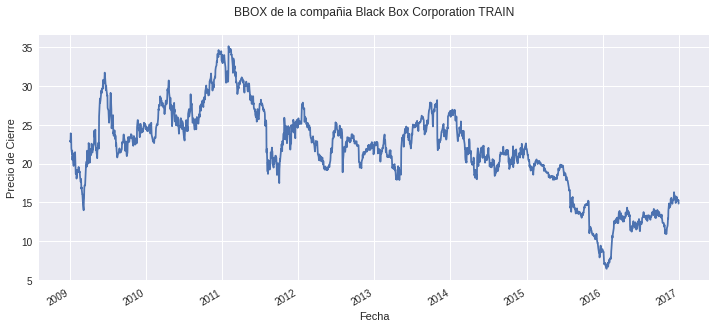

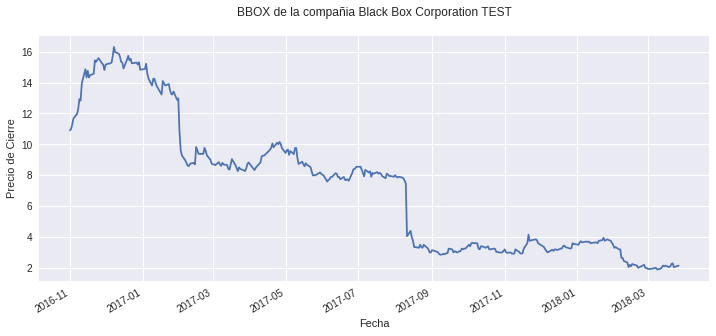

In [6]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 5
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [7]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [8]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo BBOX de la compañia Black Box Corporation


In [9]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [11]:
modelRNN42 = Sequential()
modelRNN42.add(SimpleRNN(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelRNN42.add(SimpleRNN(2,activation="relu"))
modelRNN42.add(Dense(1)) 
modelRNN42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN42.summary()
history_RNN42 = modelRNN42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 21, 4)             32        
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 2)                 14        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 125.7378 - porcentaje_margen: 0.0513 - val_loss: 8.5213 - val_porcentaje_margen: 0.3266
Epoch 2/1500
1314/1314 [==============================] - 1s 673us/step - loss: 7.9182 - porcentaje_margen: 0.2932 - val_loss: 7.3887 - val_porcentaje_margen: 0.3421
Epoch 3/1

1314/1314 [==============================] - 1s 700us/step - loss: 3.2155 - porcentaje_margen: 0.4851 - val_loss: 3.2194 - val_porcentaje_margen: 0.4995
Epoch 95/1500
1314/1314 [==============================] - 1s 697us/step - loss: 3.2078 - porcentaje_margen: 0.5037 - val_loss: 3.0862 - val_porcentaje_margen: 0.4858
Epoch 96/1500
1314/1314 [==============================] - 1s 644us/step - loss: 3.2256 - porcentaje_margen: 0.4777 - val_loss: 3.2193 - val_porcentaje_margen: 0.4587
Epoch 97/1500
1314/1314 [==============================] - 1s 568us/step - loss: 3.1726 - porcentaje_margen: 0.4777 - val_loss: 3.1820 - val_porcentaje_margen: 0.4980
Epoch 98/1500
1314/1314 [==============================] - 1s 582us/step - loss: 3.1751 - porcentaje_margen: 0.4881 - val_loss: 3.4430 - val_porcentaje_margen: 0.4453
Epoch 99/1500
1314/1314 [==============================] - 1s 575us/step - loss: 3.1668 - porcentaje_margen: 0.4821 - val_loss: 3.1264 - val_porcentaje_margen: 0.4924
Epoch 100/15

Epoch 143/1500
1314/1314 [==============================] - 1s 585us/step - loss: 2.8457 - porcentaje_margen: 0.5179 - val_loss: 2.7904 - val_porcentaje_margen: 0.4914
Epoch 144/1500
1314/1314 [==============================] - 1s 627us/step - loss: 2.8827 - porcentaje_margen: 0.5149 - val_loss: 2.7035 - val_porcentaje_margen: 0.5248
Epoch 145/1500
1314/1314 [==============================] - 1s 619us/step - loss: 2.7710 - porcentaje_margen: 0.5186 - val_loss: 2.7453 - val_porcentaje_margen: 0.5233
Epoch 146/1500
1314/1314 [==============================] - 1s 643us/step - loss: 2.7514 - porcentaje_margen: 0.5164 - val_loss: 2.6819 - val_porcentaje_margen: 0.5218
Epoch 147/1500
1314/1314 [==============================] - 1s 638us/step - loss: 2.8883 - porcentaje_margen: 0.5260 - val_loss: 2.6768 - val_porcentaje_margen: 0.5149
Epoch 148/1500
1314/1314 [==============================] - 1s 627us/step - loss: 2.7339 - porcentaje_margen: 0.5208 - val_loss: 2.6615 - val_porcentaje_margen:

Epoch 192/1500
1314/1314 [==============================] - 1s 611us/step - loss: 2.4646 - porcentaje_margen: 0.5231 - val_loss: 2.3443 - val_porcentaje_margen: 0.5506
Epoch 193/1500
1314/1314 [==============================] - 1s 669us/step - loss: 2.4336 - porcentaje_margen: 0.5402 - val_loss: 2.4107 - val_porcentaje_margen: 0.5212
Epoch 194/1500
1314/1314 [==============================] - 1s 642us/step - loss: 2.4459 - porcentaje_margen: 0.5551 - val_loss: 2.3849 - val_porcentaje_margen: 0.5331
Epoch 195/1500
1314/1314 [==============================] - 1s 672us/step - loss: 2.4484 - porcentaje_margen: 0.5528 - val_loss: 2.3223 - val_porcentaje_margen: 0.5628
Epoch 196/1500
1314/1314 [==============================] - 1s 630us/step - loss: 2.4205 - porcentaje_margen: 0.5565 - val_loss: 2.3095 - val_porcentaje_margen: 0.5599
Epoch 197/1500
1314/1314 [==============================] - ETA: 0s - loss: 2.3809 - porcentaje_margen: 0.561 - 1s 662us/step - loss: 2.3990 - porcentaje_margen

Epoch 289/1500
1314/1314 [==============================] - 1s 740us/step - loss: 1.7136 - porcentaje_margen: 0.6533 - val_loss: 1.4812 - val_porcentaje_margen: 0.6761
Epoch 290/1500
1314/1314 [==============================] - 1s 719us/step - loss: 1.6969 - porcentaje_margen: 0.6369 - val_loss: 1.5121 - val_porcentaje_margen: 0.6586
Epoch 291/1500
1314/1314 [==============================] - 1s 729us/step - loss: 1.7440 - porcentaje_margen: 0.6637 - val_loss: 1.4951 - val_porcentaje_margen: 0.6716
Epoch 292/1500
1314/1314 [==============================] - 1s 745us/step - loss: 1.6519 - porcentaje_margen: 0.6674 - val_loss: 1.4677 - val_porcentaje_margen: 0.6820
Epoch 293/1500
1314/1314 [==============================] - 1s 701us/step - loss: 1.6563 - porcentaje_margen: 0.6525 - val_loss: 1.4860 - val_porcentaje_margen: 0.6806
Epoch 294/1500
1314/1314 [==============================] - 1s 640us/step - loss: 1.6590 - porcentaje_margen: 0.6414 - val_loss: 1.4626 - val_porcentaje_margen:

Epoch 338/1500
1314/1314 [==============================] - 1s 580us/step - loss: 1.4860 - porcentaje_margen: 0.6726 - val_loss: 1.2897 - val_porcentaje_margen: 0.7118
Epoch 339/1500
1314/1314 [==============================] - 1s 616us/step - loss: 1.4733 - porcentaje_margen: 0.6890 - val_loss: 1.2839 - val_porcentaje_margen: 0.7085
Epoch 340/1500
1314/1314 [==============================] - 1s 614us/step - loss: 1.4666 - porcentaje_margen: 0.6830 - val_loss: 1.3214 - val_porcentaje_margen: 0.7178
Epoch 341/1500
1314/1314 [==============================] - 1s 627us/step - loss: 1.4886 - porcentaje_margen: 0.6689 - val_loss: 1.2876 - val_porcentaje_margen: 0.7014
Epoch 342/1500
1314/1314 [==============================] - 1s 602us/step - loss: 1.4539 - porcentaje_margen: 0.6935 - val_loss: 1.2768 - val_porcentaje_margen: 0.7100
Epoch 343/1500
1314/1314 [==============================] - 1s 598us/step - loss: 1.4262 - porcentaje_margen: 0.6793 - val_loss: 1.2998 - val_porcentaje_margen:

Epoch 387/1500
1314/1314 [==============================] - 1s 602us/step - loss: 1.2956 - porcentaje_margen: 0.6949 - val_loss: 1.2306 - val_porcentaje_margen: 0.6996
Epoch 388/1500
1314/1314 [==============================] - 1s 592us/step - loss: 1.3523 - porcentaje_margen: 0.6905 - val_loss: 1.1332 - val_porcentaje_margen: 0.7338
Epoch 389/1500
1314/1314 [==============================] - 1s 598us/step - loss: 1.2624 - porcentaje_margen: 0.7016 - val_loss: 1.1378 - val_porcentaje_margen: 0.7297
Epoch 390/1500
1314/1314 [==============================] - 1s 618us/step - loss: 1.2832 - porcentaje_margen: 0.6987 - val_loss: 1.1310 - val_porcentaje_margen: 0.7326
Epoch 391/1500
1314/1314 [==============================] - 1s 553us/step - loss: 1.2860 - porcentaje_margen: 0.7083 - val_loss: 1.1261 - val_porcentaje_margen: 0.7267
Epoch 392/1500
1314/1314 [==============================] - 1s 598us/step - loss: 1.2682 - porcentaje_margen: 0.7188 - val_loss: 1.1536 - val_porcentaje_margen:

Epoch 436/1500
1314/1314 [==============================] - 1s 611us/step - loss: 1.1812 - porcentaje_margen: 0.7262 - val_loss: 1.1028 - val_porcentaje_margen: 0.7293
Epoch 437/1500
1314/1314 [==============================] - 1s 595us/step - loss: 1.2055 - porcentaje_margen: 0.7180 - val_loss: 1.0663 - val_porcentaje_margen: 0.7386
Epoch 438/1500
1314/1314 [==============================] - 1s 573us/step - loss: 1.1812 - porcentaje_margen: 0.7314 - val_loss: 1.0671 - val_porcentaje_margen: 0.7383
Epoch 439/1500
1314/1314 [==============================] - 1s 554us/step - loss: 1.2156 - porcentaje_margen: 0.7262 - val_loss: 1.1484 - val_porcentaje_margen: 0.7115
Epoch 440/1500
1314/1314 [==============================] - 1s 585us/step - loss: 1.1691 - porcentaje_margen: 0.7143 - val_loss: 1.0632 - val_porcentaje_margen: 0.7401
Epoch 441/1500
1314/1314 [==============================] - 1s 631us/step - loss: 1.1940 - porcentaje_margen: 0.7083 - val_loss: 1.0633 - val_porcentaje_margen:

Epoch 485/1500
1314/1314 [==============================] - 1s 592us/step - loss: 1.1632 - porcentaje_margen: 0.7202 - val_loss: 1.0339 - val_porcentaje_margen: 0.7472
Epoch 486/1500
1314/1314 [==============================] - 1s 548us/step - loss: 1.1460 - porcentaje_margen: 0.7388 - val_loss: 1.0314 - val_porcentaje_margen: 0.7383
Epoch 487/1500
1314/1314 [==============================] - 1s 607us/step - loss: 1.1629 - porcentaje_margen: 0.7210 - val_loss: 1.0476 - val_porcentaje_margen: 0.7412
Epoch 488/1500
1314/1314 [==============================] - 1s 566us/step - loss: 1.1459 - porcentaje_margen: 0.7076 - val_loss: 1.0442 - val_porcentaje_margen: 0.7189
Epoch 489/1500
1314/1314 [==============================] - 1s 577us/step - loss: 1.1633 - porcentaje_margen: 0.7344 - val_loss: 1.0265 - val_porcentaje_margen: 0.7502
Epoch 490/1500
1314/1314 [==============================] - 1s 571us/step - loss: 1.1408 - porcentaje_margen: 0.7418 - val_loss: 1.1162 - val_porcentaje_margen:

Epoch 534/1500
1314/1314 [==============================] - 1s 574us/step - loss: 1.1358 - porcentaje_margen: 0.7277 - val_loss: 1.0009 - val_porcentaje_margen: 0.7528
Epoch 535/1500
1314/1314 [==============================] - 1s 592us/step - loss: 1.1227 - porcentaje_margen: 0.7292 - val_loss: 1.0624 - val_porcentaje_margen: 0.7085
Epoch 536/1500
1314/1314 [==============================] - 1s 610us/step - loss: 1.1062 - porcentaje_margen: 0.7262 - val_loss: 1.0120 - val_porcentaje_margen: 0.7412
Epoch 537/1500
1314/1314 [==============================] - 1s 574us/step - loss: 1.0962 - porcentaje_margen: 0.7552 - val_loss: 1.0245 - val_porcentaje_margen: 0.7234
Epoch 538/1500
1314/1314 [==============================] - 1s 578us/step - loss: 1.1450 - porcentaje_margen: 0.7448 - val_loss: 1.0112 - val_porcentaje_margen: 0.7412
Epoch 539/1500
1314/1314 [==============================] - 1s 625us/step - loss: 1.1070 - porcentaje_margen: 0.7374 - val_loss: 1.0343 - val_porcentaje_margen:

Epoch 583/1500
1314/1314 [==============================] - 1s 563us/step - loss: 1.1243 - porcentaje_margen: 0.7388 - val_loss: 1.0694 - val_porcentaje_margen: 0.7189
Epoch 584/1500
1314/1314 [==============================] - 1s 557us/step - loss: 1.1102 - porcentaje_margen: 0.7240 - val_loss: 1.0034 - val_porcentaje_margen: 0.7513
Epoch 585/1500
1314/1314 [==============================] - 1s 560us/step - loss: 1.1366 - porcentaje_margen: 0.7106 - val_loss: 1.0087 - val_porcentaje_margen: 0.7439
Epoch 586/1500
1314/1314 [==============================] - 1s 554us/step - loss: 1.0788 - porcentaje_margen: 0.7284 - val_loss: 1.0188 - val_porcentaje_margen: 0.7409
Epoch 587/1500
1314/1314 [==============================] - 1s 602us/step - loss: 1.1021 - porcentaje_margen: 0.7440 - val_loss: 0.9871 - val_porcentaje_margen: 0.7439
Epoch 588/1500
1314/1314 [==============================] - 1s 594us/step - loss: 1.1113 - porcentaje_margen: 0.7374 - val_loss: 1.0460 - val_porcentaje_margen:

Epoch 632/1500
1314/1314 [==============================] - 1s 568us/step - loss: 1.0714 - porcentaje_margen: 0.7470 - val_loss: 1.0195 - val_porcentaje_margen: 0.7424
Epoch 633/1500
1314/1314 [==============================] - 1s 576us/step - loss: 1.0662 - porcentaje_margen: 0.7485 - val_loss: 1.0131 - val_porcentaje_margen: 0.7364
Epoch 634/1500
1314/1314 [==============================] - 1s 580us/step - loss: 1.0671 - porcentaje_margen: 0.7485 - val_loss: 1.0265 - val_porcentaje_margen: 0.7379
Epoch 635/1500
1314/1314 [==============================] - 1s 558us/step - loss: 1.0569 - porcentaje_margen: 0.7321 - val_loss: 0.9882 - val_porcentaje_margen: 0.7546
Epoch 636/1500
1314/1314 [==============================] - 1s 598us/step - loss: 1.0954 - porcentaje_margen: 0.7329 - val_loss: 1.0066 - val_porcentaje_margen: 0.7409
Epoch 637/1500
1314/1314 [==============================] - 1s 581us/step - loss: 1.0626 - porcentaje_margen: 0.7530 - val_loss: 1.0057 - val_porcentaje_margen:

Epoch 681/1500
1314/1314 [==============================] - 1s 592us/step - loss: 1.0867 - porcentaje_margen: 0.7418 - val_loss: 0.9839 - val_porcentaje_margen: 0.7442
Epoch 682/1500
1314/1314 [==============================] - 1s 562us/step - loss: 1.0790 - porcentaje_margen: 0.7307 - val_loss: 1.0565 - val_porcentaje_margen: 0.7320
Epoch 683/1500
1314/1314 [==============================] - 1s 606us/step - loss: 1.0641 - porcentaje_margen: 0.7396 - val_loss: 1.0429 - val_porcentaje_margen: 0.7409
Epoch 684/1500
1314/1314 [==============================] - 1s 551us/step - loss: 1.0552 - porcentaje_margen: 0.7515 - val_loss: 0.9811 - val_porcentaje_margen: 0.7483
Epoch 685/1500
1314/1314 [==============================] - 1s 563us/step - loss: 1.0531 - porcentaje_margen: 0.7411 - val_loss: 0.9904 - val_porcentaje_margen: 0.7424
Epoch 686/1500
1314/1314 [==============================] - 1s 578us/step - loss: 1.0459 - porcentaje_margen: 0.7567 - val_loss: 0.9809 - val_porcentaje_margen:

Epoch 730/1500
1314/1314 [==============================] - 1s 607us/step - loss: 1.0786 - porcentaje_margen: 0.7493 - val_loss: 0.9666 - val_porcentaje_margen: 0.7543
Epoch 731/1500
1314/1314 [==============================] - 1s 615us/step - loss: 1.0731 - porcentaje_margen: 0.7463 - val_loss: 0.9793 - val_porcentaje_margen: 0.7517
Epoch 732/1500
1314/1314 [==============================] - 1s 570us/step - loss: 1.0536 - porcentaje_margen: 0.7388 - val_loss: 0.9941 - val_porcentaje_margen: 0.7457
Epoch 733/1500
1314/1314 [==============================] - 1s 565us/step - loss: 1.0520 - porcentaje_margen: 0.7381 - val_loss: 0.9819 - val_porcentaje_margen: 0.7502
Epoch 734/1500
1314/1314 [==============================] - 1s 598us/step - loss: 1.1433 - porcentaje_margen: 0.7128 - val_loss: 0.9787 - val_porcentaje_margen: 0.7465
Epoch 735/1500
1314/1314 [==============================] - 1s 606us/step - loss: 1.0812 - porcentaje_margen: 0.7202 - val_loss: 0.9672 - val_porcentaje_margen:

Epoch 779/1500
1314/1314 [==============================] - 1s 522us/step - loss: 1.0734 - porcentaje_margen: 0.7485 - val_loss: 0.9757 - val_porcentaje_margen: 0.7454
Epoch 780/1500
1314/1314 [==============================] - 1s 566us/step - loss: 1.0299 - porcentaje_margen: 0.7589 - val_loss: 1.0083 - val_porcentaje_margen: 0.7454
Epoch 781/1500
1314/1314 [==============================] - 1s 554us/step - loss: 1.0411 - porcentaje_margen: 0.7396 - val_loss: 0.9650 - val_porcentaje_margen: 0.7599
Epoch 782/1500
1314/1314 [==============================] - 1s 624us/step - loss: 1.0383 - porcentaje_margen: 0.7440 - val_loss: 0.9801 - val_porcentaje_margen: 0.7569
Epoch 783/1500
1314/1314 [==============================] - 1s 536us/step - loss: 1.0404 - porcentaje_margen: 0.7396 - val_loss: 0.9659 - val_porcentaje_margen: 0.7528
Epoch 784/1500
1314/1314 [==============================] - 1s 567us/step - loss: 1.0553 - porcentaje_margen: 0.7388 - val_loss: 0.9693 - val_porcentaje_margen:

Epoch 828/1500
1314/1314 [==============================] - 1s 535us/step - loss: 1.0341 - porcentaje_margen: 0.7507 - val_loss: 0.9568 - val_porcentaje_margen: 0.7558
Epoch 829/1500
1314/1314 [==============================] - 1s 590us/step - loss: 1.0262 - porcentaje_margen: 0.7537 - val_loss: 0.9600 - val_porcentaje_margen: 0.7543
Epoch 830/1500
1314/1314 [==============================] - 1s 574us/step - loss: 1.0365 - porcentaje_margen: 0.7478 - val_loss: 0.9935 - val_porcentaje_margen: 0.7427
Epoch 831/1500
1314/1314 [==============================] - 1s 555us/step - loss: 1.0693 - porcentaje_margen: 0.7329 - val_loss: 0.9576 - val_porcentaje_margen: 0.7588
Epoch 832/1500
1314/1314 [==============================] - 1s 535us/step - loss: 1.0463 - porcentaje_margen: 0.7567 - val_loss: 1.0490 - val_porcentaje_margen: 0.7133
Epoch 833/1500
1314/1314 [==============================] - 1s 605us/step - loss: 1.0406 - porcentaje_margen: 0.7582 - val_loss: 0.9683 - val_porcentaje_margen:

Epoch 877/1500
1314/1314 [==============================] - 1s 614us/step - loss: 1.0273 - porcentaje_margen: 0.7567 - val_loss: 0.9587 - val_porcentaje_margen: 0.7576
Epoch 878/1500
1314/1314 [==============================] - 1s 520us/step - loss: 1.0426 - porcentaje_margen: 0.7582 - val_loss: 0.9534 - val_porcentaje_margen: 0.7528
Epoch 879/1500
1314/1314 [==============================] - 1s 546us/step - loss: 1.0210 - porcentaje_margen: 0.7604 - val_loss: 0.9693 - val_porcentaje_margen: 0.7561
Epoch 880/1500
1314/1314 [==============================] - 1s 550us/step - loss: 1.0293 - porcentaje_margen: 0.7530 - val_loss: 0.9637 - val_porcentaje_margen: 0.7584
Epoch 881/1500
1314/1314 [==============================] - 1s 531us/step - loss: 1.0239 - porcentaje_margen: 0.7701 - val_loss: 0.9572 - val_porcentaje_margen: 0.7555
Epoch 882/1500
1314/1314 [==============================] - 1s 552us/step - loss: 1.0203 - porcentaje_margen: 0.7582 - val_loss: 1.0016 - val_porcentaje_margen:

Epoch 926/1500
1314/1314 [==============================] - 1s 514us/step - loss: 1.0285 - porcentaje_margen: 0.7463 - val_loss: 0.9668 - val_porcentaje_margen: 0.7555
Epoch 927/1500
1314/1314 [==============================] - 1s 495us/step - loss: 1.0382 - porcentaje_margen: 0.7426 - val_loss: 0.9799 - val_porcentaje_margen: 0.7588
Epoch 928/1500
1314/1314 [==============================] - 1s 500us/step - loss: 1.0345 - porcentaje_margen: 0.7478 - val_loss: 0.9491 - val_porcentaje_margen: 0.7617
Epoch 929/1500
1314/1314 [==============================] - 1s 538us/step - loss: 1.0316 - porcentaje_margen: 0.7433 - val_loss: 0.9464 - val_porcentaje_margen: 0.7558
Epoch 930/1500
1314/1314 [==============================] - 1s 528us/step - loss: 1.0558 - porcentaje_margen: 0.7351 - val_loss: 0.9538 - val_porcentaje_margen: 0.7591
Epoch 931/1500
1314/1314 [==============================] - 1s 561us/step - loss: 1.0545 - porcentaje_margen: 0.7470 - val_loss: 0.9505 - val_porcentaje_margen:

Epoch 1023/1500
1314/1314 [==============================] - 1s 538us/step - loss: 1.0344 - porcentaje_margen: 0.7500 - val_loss: 0.9753 - val_porcentaje_margen: 0.7502
Epoch 1024/1500
1314/1314 [==============================] - 1s 561us/step - loss: 1.0328 - porcentaje_margen: 0.7507 - val_loss: 0.9522 - val_porcentaje_margen: 0.7558
Epoch 1025/1500
1314/1314 [==============================] - 1s 528us/step - loss: 1.0247 - porcentaje_margen: 0.7493 - val_loss: 0.9435 - val_porcentaje_margen: 0.7617
Epoch 1026/1500
1314/1314 [==============================] - 1s 559us/step - loss: 1.0364 - porcentaje_margen: 0.7537 - val_loss: 0.9517 - val_porcentaje_margen: 0.7662
Epoch 1027/1500
1314/1314 [==============================] - 1s 526us/step - loss: 1.0089 - porcentaje_margen: 0.7634 - val_loss: 0.9943 - val_porcentaje_margen: 0.7617
Epoch 1028/1500
1314/1314 [==============================] - 1s 553us/step - loss: 1.0116 - porcentaje_margen: 0.7574 - val_loss: 0.9610 - val_porcentaje_m

1314/1314 [==============================] - 1s 503us/step - loss: 1.0227 - porcentaje_margen: 0.7388 - val_loss: 0.9375 - val_porcentaje_margen: 0.7617
Epoch 1120/1500
1314/1314 [==============================] - 1s 550us/step - loss: 1.0521 - porcentaje_margen: 0.7582 - val_loss: 0.9473 - val_porcentaje_margen: 0.7614
Epoch 1121/1500
1314/1314 [==============================] - 1s 547us/step - loss: 0.9977 - porcentaje_margen: 0.7634 - val_loss: 0.9523 - val_porcentaje_margen: 0.7599
Epoch 1122/1500
1314/1314 [==============================] - ETA: 0s - loss: 1.0159 - porcentaje_margen: 0.757 - 1s 509us/step - loss: 1.0145 - porcentaje_margen: 0.7619 - val_loss: 0.9913 - val_porcentaje_margen: 0.7439
Epoch 1123/1500
1314/1314 [==============================] - 1s 506us/step - loss: 1.0205 - porcentaje_margen: 0.7589 - val_loss: 0.9628 - val_porcentaje_margen: 0.7528
Epoch 1124/1500
1314/1314 [==============================] - 1s 542us/step - loss: 1.0145 - porcentaje_margen: 0.7351 -

1314/1314 [==============================] - 1s 501us/step - loss: 1.1006 - porcentaje_margen: 0.7381 - val_loss: 0.9420 - val_porcentaje_margen: 0.7659
Epoch 1216/1500
1314/1314 [==============================] - 1s 526us/step - loss: 0.9974 - porcentaje_margen: 0.7701 - val_loss: 0.9443 - val_porcentaje_margen: 0.7606
Epoch 1217/1500
1314/1314 [==============================] - 1s 501us/step - loss: 1.0083 - porcentaje_margen: 0.7485 - val_loss: 0.9502 - val_porcentaje_margen: 0.7644
Epoch 1218/1500
1314/1314 [==============================] - 1s 527us/step - loss: 0.9945 - porcentaje_margen: 0.7790 - val_loss: 0.9576 - val_porcentaje_margen: 0.7576
Epoch 1219/1500
1314/1314 [==============================] - 1s 519us/step - loss: 1.0153 - porcentaje_margen: 0.7351 - val_loss: 0.9347 - val_porcentaje_margen: 0.7603
Epoch 1220/1500
1314/1314 [==============================] - 1s 561us/step - loss: 1.0317 - porcentaje_margen: 0.7604 - val_loss: 0.9435 - val_porcentaje_margen: 0.7606
Ep

1314/1314 [==============================] - 1s 551us/step - loss: 1.0776 - porcentaje_margen: 0.7388 - val_loss: 0.9489 - val_porcentaje_margen: 0.7480
Epoch 1312/1500
1314/1314 [==============================] - 1s 524us/step - loss: 1.0023 - porcentaje_margen: 0.7560 - val_loss: 0.9299 - val_porcentaje_margen: 0.7569
Epoch 1313/1500
1314/1314 [==============================] - 1s 527us/step - loss: 0.9868 - porcentaje_margen: 0.7656 - val_loss: 0.9319 - val_porcentaje_margen: 0.7674
Epoch 1314/1500
1314/1314 [==============================] - 1s 595us/step - loss: 0.9970 - porcentaje_margen: 0.7634 - val_loss: 0.9274 - val_porcentaje_margen: 0.7588
Epoch 1315/1500
1314/1314 [==============================] - 1s 560us/step - loss: 1.0024 - porcentaje_margen: 0.7537 - val_loss: 0.9331 - val_porcentaje_margen: 0.7636
Epoch 1316/1500
1314/1314 [==============================] - 1s 503us/step - loss: 0.9956 - porcentaje_margen: 0.7671 - val_loss: 0.9275 - val_porcentaje_margen: 0.7644
Ep

1314/1314 [==============================] - 1s 549us/step - loss: 0.9890 - porcentaje_margen: 0.7388 - val_loss: 0.9356 - val_porcentaje_margen: 0.7576
Epoch 1408/1500
1314/1314 [==============================] - 1s 549us/step - loss: 0.9939 - porcentaje_margen: 0.7634 - val_loss: 0.9421 - val_porcentaje_margen: 0.7644
Epoch 1409/1500
1314/1314 [==============================] - 1s 485us/step - loss: 0.9827 - porcentaje_margen: 0.7731 - val_loss: 0.9580 - val_porcentaje_margen: 0.7442
Epoch 1410/1500
1314/1314 [==============================] - 1s 487us/step - loss: 0.9903 - porcentaje_margen: 0.7790 - val_loss: 0.9780 - val_porcentaje_margen: 0.7603
Epoch 1411/1500
1314/1314 [==============================] - 1s 504us/step - loss: 0.9899 - porcentaje_margen: 0.7671 - val_loss: 0.9488 - val_porcentaje_margen: 0.7576
Epoch 1412/1500
1314/1314 [==============================] - 1s 521us/step - loss: 0.9907 - porcentaje_margen: 0.7560 - val_loss: 0.9428 - val_porcentaje_margen: 0.7644
Ep

In [10]:
modelRNN84 = Sequential()
modelRNN84.add(SimpleRNN(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelRNN84.add(SimpleRNN(4,activation="relu"))
modelRNN84.add(Dense(1)) 
modelRNN84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN84.summary()
history_RNN84 = modelRNN84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 21, 8)             96        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 20ms/step - loss: 527.2966 - porcentaje_margen: 0.0000e+00 - val_loss: 509.4538 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 13ms/step - loss: 511.4008 - porcentaje_margen: 0.0000e+00 - val_loss: 498.0898 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [======================

Epoch 44/1500
42/42 [==============================] - 0s 11ms/step - loss: 429.0246 - porcentaje_margen: 0.0000e+00 - val_loss: 421.2317 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
42/42 [==============================] - 1s 13ms/step - loss: 427.4078 - porcentaje_margen: 0.0000e+00 - val_loss: 419.6366 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
42/42 [==============================] - 0s 10ms/step - loss: 425.7918 - porcentaje_margen: 0.0000e+00 - val_loss: 418.0398 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
42/42 [==============================] - 0s 10ms/step - loss: 424.1843 - porcentaje_margen: 0.0000e+00 - val_loss: 416.4485 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
42/42 [==============================] - 0s 10ms/step - loss: 422.5815 - porcentaje_margen: 0.0000e+00 - val_loss: 414.8594 - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
42/42 [==============================] - 1s 14ms/step - loss: 420.9752 - porcentaje_margen: 0.0000e+00 - val_loss: 4

42/42 [==============================] - 1s 14ms/step - loss: 357.0633 - porcentaje_margen: 0.0000e+00 - val_loss: 350.1555 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
42/42 [==============================] - 0s 10ms/step - loss: 355.6242 - porcentaje_margen: 0.0000e+00 - val_loss: 348.7383 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
42/42 [==============================] - 1s 14ms/step - loss: 354.2001 - porcentaje_margen: 0.0000e+00 - val_loss: 347.3275 - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
42/42 [==============================] - 1s 13ms/step - loss: 352.7689 - porcentaje_margen: 0.0000e+00 - val_loss: 345.9137 - val_porcentaje_margen: 0.0000e+00
Epoch 95/1500
42/42 [==============================] - 1s 13ms/step - loss: 351.3369 - porcentaje_margen: 0.0000e+00 - val_loss: 344.5017 - val_porcentaje_margen: 0.0000e+00
Epoch 96/1500
42/42 [==============================] - 1s 12ms/step - loss: 349.9022 - porcentaje_margen: 0.0000e+00 - val_loss: 343.0869 - val_

Epoch 138/1500
42/42 [==============================] - 1s 13ms/step - loss: 293.0712 - porcentaje_margen: 0.0000e+00 - val_loss: 287.0283 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
42/42 [==============================] - 0s 10ms/step - loss: 291.7864 - porcentaje_margen: 0.0000e+00 - val_loss: 285.7615 - val_porcentaje_margen: 0.0000e+00
Epoch 140/1500
42/42 [==============================] - 0s 9ms/step - loss: 290.5073 - porcentaje_margen: 0.0000e+00 - val_loss: 284.4987 - val_porcentaje_margen: 0.0000e+00
Epoch 141/1500
42/42 [==============================] - 0s 11ms/step - loss: 289.2331 - porcentaje_margen: 0.0000e+00 - val_loss: 283.2508 - val_porcentaje_margen: 0.0000e+00
Epoch 142/1500
42/42 [==============================] - 0s 10ms/step - loss: 287.9622 - porcentaje_margen: 0.0000e+00 - val_loss: 281.9919 - val_porcentaje_margen: 0.0000e+00
Epoch 143/1500
42/42 [==============================] - 0s 11ms/step - loss: 286.6947 - porcentaje_margen: 0.0000e+00 - val_lo

42/42 [==============================] - 1s 12ms/step - loss: 235.3291 - porcentaje_margen: 0.0037 - val_loss: 230.1609 - val_porcentaje_margen: 0.0104
Epoch 187/1500
42/42 [==============================] - 1s 12ms/step - loss: 234.2007 - porcentaje_margen: 0.0037 - val_loss: 229.0569 - val_porcentaje_margen: 0.0104
Epoch 188/1500
42/42 [==============================] - 1s 12ms/step - loss: 233.0878 - porcentaje_margen: 0.0030 - val_loss: 227.9581 - val_porcentaje_margen: 0.0104
Epoch 189/1500
42/42 [==============================] - 1s 12ms/step - loss: 231.9689 - porcentaje_margen: 0.0030 - val_loss: 226.8564 - val_porcentaje_margen: 0.0089
Epoch 190/1500
42/42 [==============================] - 1s 14ms/step - loss: 230.8622 - porcentaje_margen: 0.0022 - val_loss: 225.7785 - val_porcentaje_margen: 0.0089
Epoch 191/1500
42/42 [==============================] - 1s 14ms/step - loss: 229.7597 - porcentaje_margen: 0.0022 - val_loss: 224.6866 - val_porcentaje_margen: 0.0089
Epoch 192/150

42/42 [==============================] - 1s 12ms/step - loss: 184.3074 - porcentaje_margen: 0.0030 - val_loss: 180.0238 - val_porcentaje_margen: 0.0089
Epoch 236/1500
42/42 [==============================] - 1s 13ms/step - loss: 183.3586 - porcentaje_margen: 0.0030 - val_loss: 179.1006 - val_porcentaje_margen: 0.0060
Epoch 237/1500
42/42 [==============================] - 1s 17ms/step - loss: 182.4047 - porcentaje_margen: 0.0022 - val_loss: 178.1540 - val_porcentaje_margen: 0.0060
Epoch 238/1500
42/42 [==============================] - 1s 13ms/step - loss: 181.4482 - porcentaje_margen: 0.0022 - val_loss: 177.2238 - val_porcentaje_margen: 0.0045
Epoch 239/1500
42/42 [==============================] - 0s 11ms/step - loss: 180.5018 - porcentaje_margen: 0.0015 - val_loss: 176.2894 - val_porcentaje_margen: 0.0045
Epoch 240/1500
42/42 [==============================] - 0s 11ms/step - loss: 179.5552 - porcentaje_margen: 0.0015 - val_loss: 175.3628 - val_porcentaje_margen: 0.0045
Epoch 241/150

42/42 [==============================] - 1s 15ms/step - loss: 141.0564 - porcentaje_margen: 0.0208 - val_loss: 137.6475 - val_porcentaje_margen: 0.0179
Epoch 285/1500
42/42 [==============================] - 1s 14ms/step - loss: 140.2476 - porcentaje_margen: 0.0335 - val_loss: 136.8570 - val_porcentaje_margen: 0.0179
Epoch 286/1500
42/42 [==============================] - 1s 14ms/step - loss: 139.4485 - porcentaje_margen: 0.0223 - val_loss: 136.0780 - val_porcentaje_margen: 0.0208
Epoch 287/1500
42/42 [==============================] - 1s 13ms/step - loss: 138.6437 - porcentaje_margen: 0.0231 - val_loss: 135.2878 - val_porcentaje_margen: 0.0223
Epoch 288/1500
42/42 [==============================] - 1s 15ms/step - loss: 137.8416 - porcentaje_margen: 0.0231 - val_loss: 134.5008 - val_porcentaje_margen: 0.0223
Epoch 289/1500
42/42 [==============================] - 1s 15ms/step - loss: 137.0503 - porcentaje_margen: 0.0231 - val_loss: 133.7356 - val_porcentaje_margen: 0.0208
Epoch 290/150

42/42 [==============================] - 1s 14ms/step - loss: 105.4008 - porcentaje_margen: 0.0632 - val_loss: 102.8581 - val_porcentaje_margen: 0.0711
Epoch 334/1500
42/42 [==============================] - 1s 15ms/step - loss: 104.7479 - porcentaje_margen: 0.0640 - val_loss: 102.2162 - val_porcentaje_margen: 0.0681
Epoch 335/1500
42/42 [==============================] - 1s 13ms/step - loss: 104.0949 - porcentaje_margen: 0.0655 - val_loss: 101.5815 - val_porcentaje_margen: 0.0681
Epoch 336/1500
42/42 [==============================] - 1s 14ms/step - loss: 103.4446 - porcentaje_margen: 0.0662 - val_loss: 100.9518 - val_porcentaje_margen: 0.0681
Epoch 337/1500
42/42 [==============================] - 0s 12ms/step - loss: 102.8055 - porcentaje_margen: 0.0662 - val_loss: 100.3293 - val_porcentaje_margen: 0.0681
Epoch 338/1500
42/42 [==============================] - 1s 13ms/step - loss: 102.1721 - porcentaje_margen: 0.0670 - val_loss: 99.7133 - val_porcentaje_margen: 0.0681
Epoch 339/1500

42/42 [==============================] - 1s 17ms/step - loss: 77.3104 - porcentaje_margen: 0.0290 - val_loss: 75.6043 - val_porcentaje_margen: 0.0372
Epoch 383/1500
42/42 [==============================] - 1s 17ms/step - loss: 76.8234 - porcentaje_margen: 0.0298 - val_loss: 75.1280 - val_porcentaje_margen: 0.0372
Epoch 384/1500
42/42 [==============================] - 1s 18ms/step - loss: 76.3278 - porcentaje_margen: 0.0290 - val_loss: 74.6533 - val_porcentaje_margen: 0.0372
Epoch 385/1500
42/42 [==============================] - 1s 18ms/step - loss: 75.8404 - porcentaje_margen: 0.0283 - val_loss: 74.1805 - val_porcentaje_margen: 0.0342
Epoch 386/1500
42/42 [==============================] - 1s 16ms/step - loss: 75.3498 - porcentaje_margen: 0.0283 - val_loss: 73.7100 - val_porcentaje_margen: 0.0327
Epoch 387/1500
42/42 [==============================] - 1s 16ms/step - loss: 74.8635 - porcentaje_margen: 0.0275 - val_loss: 73.2407 - val_porcentaje_margen: 0.0327
Epoch 388/1500
42/42 [===

Epoch 432/1500
42/42 [==============================] - 1s 15ms/step - loss: 56.0797 - porcentaje_margen: 0.0060 - val_loss: 55.2022 - val_porcentaje_margen: 0.0074
Epoch 433/1500
42/42 [==============================] - 1s 15ms/step - loss: 55.7271 - porcentaje_margen: 0.0060 - val_loss: 54.8573 - val_porcentaje_margen: 0.0074
Epoch 434/1500
42/42 [==============================] - 1s 12ms/step - loss: 55.3772 - porcentaje_margen: 0.0052 - val_loss: 54.5299 - val_porcentaje_margen: 0.0074
Epoch 435/1500
42/42 [==============================] - 1s 15ms/step - loss: 55.0378 - porcentaje_margen: 0.0052 - val_loss: 54.2105 - val_porcentaje_margen: 0.0074
Epoch 436/1500
42/42 [==============================] - 1s 15ms/step - loss: 54.7005 - porcentaje_margen: 0.0052 - val_loss: 53.8784 - val_porcentaje_margen: 0.0074
Epoch 437/1500
42/42 [==============================] - 1s 15ms/step - loss: 54.3576 - porcentaje_margen: 0.0052 - val_loss: 53.5600 - val_porcentaje_margen: 0.0089
Epoch 438/

Epoch 482/1500
42/42 [==============================] - 1s 20ms/step - loss: 42.0082 - porcentaje_margen: 0.0766 - val_loss: 41.9066 - val_porcentaje_margen: 0.0655
Epoch 483/1500
42/42 [==============================] - 1s 15ms/step - loss: 41.7930 - porcentaje_margen: 0.0774 - val_loss: 41.7023 - val_porcentaje_margen: 0.0696
Epoch 484/1500
42/42 [==============================] - 1s 17ms/step - loss: 41.5818 - porcentaje_margen: 0.0781 - val_loss: 41.5117 - val_porcentaje_margen: 0.0696
Epoch 485/1500
42/42 [==============================] - 1s 19ms/step - loss: 41.3686 - porcentaje_margen: 0.0796 - val_loss: 41.3025 - val_porcentaje_margen: 0.0696
Epoch 486/1500
42/42 [==============================] - 1s 21ms/step - loss: 41.1617 - porcentaje_margen: 0.0818 - val_loss: 41.1197 - val_porcentaje_margen: 0.0711
Epoch 487/1500
42/42 [==============================] - 1s 18ms/step - loss: 40.9584 - porcentaje_margen: 0.0848 - val_loss: 40.9243 - val_porcentaje_margen: 0.0771
Epoch 488/

Epoch 532/1500
42/42 [==============================] - 1s 17ms/step - loss: 34.2992 - porcentaje_margen: 0.1622 - val_loss: 34.8790 - val_porcentaje_margen: 0.1516
Epoch 533/1500
42/42 [==============================] - 1s 16ms/step - loss: 34.2061 - porcentaje_margen: 0.1510 - val_loss: 34.7935 - val_porcentaje_margen: 0.1501
Epoch 534/1500
42/42 [==============================] - 1s 15ms/step - loss: 34.1069 - porcentaje_margen: 0.1622 - val_loss: 34.7103 - val_porcentaje_margen: 0.1486
Epoch 535/1500
42/42 [==============================] - 1s 16ms/step - loss: 34.0106 - porcentaje_margen: 0.1533 - val_loss: 34.6257 - val_porcentaje_margen: 0.1486
Epoch 536/1500
42/42 [==============================] - 1s 14ms/step - loss: 33.9164 - porcentaje_margen: 0.1525 - val_loss: 34.5390 - val_porcentaje_margen: 0.1516
Epoch 537/1500
42/42 [==============================] - 1s 17ms/step - loss: 33.8266 - porcentaje_margen: 0.1562 - val_loss: 34.4665 - val_porcentaje_margen: 0.1501
Epoch 538/

Epoch 582/1500
42/42 [==============================] - 1s 16ms/step - loss: 31.4080 - porcentaje_margen: 0.1912 - val_loss: 32.4952 - val_porcentaje_margen: 0.1925
Epoch 583/1500
42/42 [==============================] - 1s 15ms/step - loss: 31.3871 - porcentaje_margen: 0.1905 - val_loss: 32.4812 - val_porcentaje_margen: 0.1910
Epoch 584/1500
42/42 [==============================] - 1s 15ms/step - loss: 31.3664 - porcentaje_margen: 0.1823 - val_loss: 32.4631 - val_porcentaje_margen: 0.1835
Epoch 585/1500
42/42 [==============================] - 1s 18ms/step - loss: 31.3400 - porcentaje_margen: 0.1815 - val_loss: 32.4494 - val_porcentaje_margen: 0.1820
Epoch 586/1500
42/42 [==============================] - 1s 15ms/step - loss: 31.3191 - porcentaje_margen: 0.1801 - val_loss: 32.4346 - val_porcentaje_margen: 0.1835
Epoch 587/1500
42/42 [==============================] - 1s 16ms/step - loss: 31.2964 - porcentaje_margen: 0.1815 - val_loss: 32.4198 - val_porcentaje_margen: 0.1806
Epoch 588/

Epoch 632/1500
42/42 [==============================] - 1s 18ms/step - loss: 30.9268 - porcentaje_margen: 0.1756 - val_loss: 32.2491 - val_porcentaje_margen: 0.1987
Epoch 633/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.9263 - porcentaje_margen: 0.1756 - val_loss: 32.2491 - val_porcentaje_margen: 0.1987
Epoch 634/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.9257 - porcentaje_margen: 0.1860 - val_loss: 32.2495 - val_porcentaje_margen: 0.1987
Epoch 635/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.9237 - porcentaje_margen: 0.1763 - val_loss: 32.2500 - val_porcentaje_margen: 0.1987
Epoch 636/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.9199 - porcentaje_margen: 0.1756 - val_loss: 32.2513 - val_porcentaje_margen: 0.1987
Epoch 637/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.9173 - porcentaje_margen: 0.1763 - val_loss: 32.2522 - val_porcentaje_margen: 0.1987
Epoch 638/

Epoch 682/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8977 - porcentaje_margen: 0.1905 - val_loss: 32.2810 - val_porcentaje_margen: 0.2062
Epoch 683/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8985 - porcentaje_margen: 0.1905 - val_loss: 32.2836 - val_porcentaje_margen: 0.2077
Epoch 684/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8967 - porcentaje_margen: 0.1905 - val_loss: 32.2837 - val_porcentaje_margen: 0.2077
Epoch 685/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8965 - porcentaje_margen: 0.2016 - val_loss: 32.2845 - val_porcentaje_margen: 0.2062
Epoch 686/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8966 - porcentaje_margen: 0.2024 - val_loss: 32.2859 - val_porcentaje_margen: 0.2062
Epoch 687/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8965 - porcentaje_margen: 0.1912 - val_loss: 32.2860 - val_porcentaje_margen: 0.2062
Epoch 688/

Epoch 732/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8965 - porcentaje_margen: 0.2024 - val_loss: 32.2902 - val_porcentaje_margen: 0.2062
Epoch 733/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8964 - porcentaje_margen: 0.1912 - val_loss: 32.2912 - val_porcentaje_margen: 0.2077
Epoch 734/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8960 - porcentaje_margen: 0.1912 - val_loss: 32.2897 - val_porcentaje_margen: 0.2062
Epoch 735/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8961 - porcentaje_margen: 0.1912 - val_loss: 32.2916 - val_porcentaje_margen: 0.2077
Epoch 736/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8963 - porcentaje_margen: 0.1912 - val_loss: 32.2896 - val_porcentaje_margen: 0.2062
Epoch 737/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8962 - porcentaje_margen: 0.1912 - val_loss: 32.2909 - val_porcentaje_margen: 0.2077
Epoch 738/

Epoch 782/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8966 - porcentaje_margen: 0.2024 - val_loss: 32.2888 - val_porcentaje_margen: 0.2062
Epoch 783/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8964 - porcentaje_margen: 0.2024 - val_loss: 32.2880 - val_porcentaje_margen: 0.2062
Epoch 784/1500
42/42 [==============================] - 1s 13ms/step - loss: 30.8966 - porcentaje_margen: 0.1912 - val_loss: 32.2863 - val_porcentaje_margen: 0.2062
Epoch 785/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8972 - porcentaje_margen: 0.1905 - val_loss: 32.2844 - val_porcentaje_margen: 0.2062
Epoch 786/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8972 - porcentaje_margen: 0.2024 - val_loss: 32.2844 - val_porcentaje_margen: 0.2077
Epoch 787/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8962 - porcentaje_margen: 0.1912 - val_loss: 32.2857 - val_porcentaje_margen: 0.2062
Epoch 788/

Epoch 832/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8970 - porcentaje_margen: 0.1912 - val_loss: 32.2852 - val_porcentaje_margen: 0.2062
Epoch 833/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8968 - porcentaje_margen: 0.2031 - val_loss: 32.2866 - val_porcentaje_margen: 0.2062
Epoch 834/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8965 - porcentaje_margen: 0.1912 - val_loss: 32.2873 - val_porcentaje_margen: 0.2062
Epoch 835/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8970 - porcentaje_margen: 0.1912 - val_loss: 32.2888 - val_porcentaje_margen: 0.2062
Epoch 836/1500
42/42 [==============================] - ETA: 0s - loss: 30.8962 - porcentaje_margen: 0.20 - 1s 17ms/step - loss: 30.8962 - porcentaje_margen: 0.2024 - val_loss: 32.2880 - val_porcentaje_margen: 0.2062
Epoch 837/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8967 - porcentaje_margen: 0.1912 - val_loss

42/42 [==============================] - 1s 14ms/step - loss: 30.8963 - porcentaje_margen: 0.2024 - val_loss: 32.2917 - val_porcentaje_margen: 0.2062
Epoch 882/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8963 - porcentaje_margen: 0.2024 - val_loss: 32.2906 - val_porcentaje_margen: 0.2062
Epoch 883/1500
42/42 [==============================] - 1s 13ms/step - loss: 30.8964 - porcentaje_margen: 0.2024 - val_loss: 32.2896 - val_porcentaje_margen: 0.2062
Epoch 884/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8966 - porcentaje_margen: 0.1912 - val_loss: 32.2886 - val_porcentaje_margen: 0.2062
Epoch 885/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8971 - porcentaje_margen: 0.1912 - val_loss: 32.2899 - val_porcentaje_margen: 0.2062
Epoch 886/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8960 - porcentaje_margen: 0.1912 - val_loss: 32.2929 - val_porcentaje_margen: 0.2077
Epoch 887/1500
42/42 [===

Epoch 931/1500
42/42 [==============================] - 1s 18ms/step - loss: 30.8972 - porcentaje_margen: 0.1920 - val_loss: 32.2964 - val_porcentaje_margen: 0.2062
Epoch 932/1500
42/42 [==============================] - 1s 21ms/step - loss: 30.8973 - porcentaje_margen: 0.2031 - val_loss: 32.2976 - val_porcentaje_margen: 0.2062
Epoch 933/1500
42/42 [==============================] - 1s 18ms/step - loss: 30.8967 - porcentaje_margen: 0.1912 - val_loss: 32.2969 - val_porcentaje_margen: 0.2062
Epoch 934/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8967 - porcentaje_margen: 0.1912 - val_loss: 32.2964 - val_porcentaje_margen: 0.2062
Epoch 935/1500
42/42 [==============================] - 1s 19ms/step - loss: 30.8971 - porcentaje_margen: 0.1912 - val_loss: 32.2984 - val_porcentaje_margen: 0.2077
Epoch 936/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8970 - porcentaje_margen: 0.1920 - val_loss: 32.2947 - val_porcentaje_margen: 0.2062
Epoch 937/

Epoch 981/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8966 - porcentaje_margen: 0.1912 - val_loss: 32.2900 - val_porcentaje_margen: 0.2062
Epoch 982/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8963 - porcentaje_margen: 0.1912 - val_loss: 32.2911 - val_porcentaje_margen: 0.2077
Epoch 983/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8962 - porcentaje_margen: 0.2024 - val_loss: 32.2911 - val_porcentaje_margen: 0.2077
Epoch 984/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8966 - porcentaje_margen: 0.1912 - val_loss: 32.2910 - val_porcentaje_margen: 0.2077
Epoch 985/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8965 - porcentaje_margen: 0.1912 - val_loss: 32.2917 - val_porcentaje_margen: 0.2062
Epoch 986/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8963 - porcentaje_margen: 0.1920 - val_loss: 32.2930 - val_porcentaje_margen: 0.2077
Epoch 987/

42/42 [==============================] - 1s 15ms/step - loss: 30.8969 - porcentaje_margen: 0.1912 - val_loss: 32.2883 - val_porcentaje_margen: 0.2062
Epoch 1031/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8966 - porcentaje_margen: 0.2024 - val_loss: 32.2891 - val_porcentaje_margen: 0.2062
Epoch 1032/1500
42/42 [==============================] - 1s 12ms/step - loss: 30.8967 - porcentaje_margen: 0.2024 - val_loss: 32.2901 - val_porcentaje_margen: 0.2062
Epoch 1033/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8962 - porcentaje_margen: 0.2024 - val_loss: 32.2906 - val_porcentaje_margen: 0.2062
Epoch 1034/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8965 - porcentaje_margen: 0.1912 - val_loss: 32.2905 - val_porcentaje_margen: 0.2062
Epoch 1035/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8965 - porcentaje_margen: 0.1912 - val_loss: 32.2919 - val_porcentaje_margen: 0.2062
Epoch 1036/1500
42/4

42/42 [==============================] - 1s 19ms/step - loss: 30.8967 - porcentaje_margen: 0.1912 - val_loss: 32.2889 - val_porcentaje_margen: 0.2062
Epoch 1080/1500
42/42 [==============================] - 1s 18ms/step - loss: 30.8965 - porcentaje_margen: 0.1912 - val_loss: 32.2885 - val_porcentaje_margen: 0.2062
Epoch 1081/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8965 - porcentaje_margen: 0.2031 - val_loss: 32.2859 - val_porcentaje_margen: 0.2062
Epoch 1082/1500
42/42 [==============================] - 1s 18ms/step - loss: 30.8965 - porcentaje_margen: 0.1912 - val_loss: 32.2862 - val_porcentaje_margen: 0.2062
Epoch 1083/1500
42/42 [==============================] - 1s 18ms/step - loss: 30.8969 - porcentaje_margen: 0.1912 - val_loss: 32.2869 - val_porcentaje_margen: 0.2062
Epoch 1084/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8964 - porcentaje_margen: 0.2024 - val_loss: 32.2871 - val_porcentaje_margen: 0.2062
Epoch 1085/1500
42/4

42/42 [==============================] - 1s 20ms/step - loss: 30.8961 - porcentaje_margen: 0.1912 - val_loss: 32.2868 - val_porcentaje_margen: 0.2062
Epoch 1129/1500
42/42 [==============================] - 1s 18ms/step - loss: 30.8969 - porcentaje_margen: 0.1920 - val_loss: 32.2857 - val_porcentaje_margen: 0.2062
Epoch 1130/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8974 - porcentaje_margen: 0.1912 - val_loss: 32.2877 - val_porcentaje_margen: 0.2062
Epoch 1131/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8970 - porcentaje_margen: 0.2016 - val_loss: 32.2866 - val_porcentaje_margen: 0.2062
Epoch 1132/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8970 - porcentaje_margen: 0.1920 - val_loss: 32.2863 - val_porcentaje_margen: 0.2062
Epoch 1133/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8963 - porcentaje_margen: 0.2024 - val_loss: 32.2848 - val_porcentaje_margen: 0.2062
Epoch 1134/1500
42/4

42/42 [==============================] - 1s 16ms/step - loss: 30.8970 - porcentaje_margen: 0.1905 - val_loss: 32.2837 - val_porcentaje_margen: 0.2077
Epoch 1178/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8967 - porcentaje_margen: 0.2024 - val_loss: 32.2843 - val_porcentaje_margen: 0.2077
Epoch 1179/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8972 - porcentaje_margen: 0.2024 - val_loss: 32.2849 - val_porcentaje_margen: 0.2062
Epoch 1180/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8973 - porcentaje_margen: 0.2128 - val_loss: 32.2834 - val_porcentaje_margen: 0.2077
Epoch 1181/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8970 - porcentaje_margen: 0.1912 - val_loss: 32.2837 - val_porcentaje_margen: 0.2077
Epoch 1182/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8978 - porcentaje_margen: 0.2016 - val_loss: 32.2833 - val_porcentaje_margen: 0.2077
Epoch 1183/1500
42/4

42/42 [==============================] - 1s 16ms/step - loss: 30.8965 - porcentaje_margen: 0.1912 - val_loss: 32.2900 - val_porcentaje_margen: 0.2062
Epoch 1227/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8960 - porcentaje_margen: 0.2024 - val_loss: 32.2912 - val_porcentaje_margen: 0.2077
Epoch 1228/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8964 - porcentaje_margen: 0.1912 - val_loss: 32.2920 - val_porcentaje_margen: 0.2062
Epoch 1229/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8969 - porcentaje_margen: 0.2024 - val_loss: 32.2906 - val_porcentaje_margen: 0.2077
Epoch 1230/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8968 - porcentaje_margen: 0.2024 - val_loss: 32.2925 - val_porcentaje_margen: 0.2062
Epoch 1231/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8978 - porcentaje_margen: 0.1912 - val_loss: 32.2896 - val_porcentaje_margen: 0.2062
Epoch 1232/1500
42/4

42/42 [==============================] - 1s 15ms/step - loss: 30.8964 - porcentaje_margen: 0.1912 - val_loss: 32.2891 - val_porcentaje_margen: 0.2062
Epoch 1276/1500
42/42 [==============================] - 1s 13ms/step - loss: 30.8955 - porcentaje_margen: 0.2024 - val_loss: 32.2862 - val_porcentaje_margen: 0.2062
Epoch 1277/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8968 - porcentaje_margen: 0.2024 - val_loss: 32.2854 - val_porcentaje_margen: 0.2062
Epoch 1278/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8968 - porcentaje_margen: 0.1912 - val_loss: 32.2845 - val_porcentaje_margen: 0.2062
Epoch 1279/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8969 - porcentaje_margen: 0.1905 - val_loss: 32.2867 - val_porcentaje_margen: 0.2062
Epoch 1280/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8968 - porcentaje_margen: 0.2024 - val_loss: 32.2875 - val_porcentaje_margen: 0.2062
Epoch 1281/1500
42/4

42/42 [==============================] - 1s 16ms/step - loss: 30.8964 - porcentaje_margen: 0.1920 - val_loss: 32.2933 - val_porcentaje_margen: 0.2077
Epoch 1325/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8970 - porcentaje_margen: 0.2031 - val_loss: 32.2940 - val_porcentaje_margen: 0.2062
Epoch 1326/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8966 - porcentaje_margen: 0.2031 - val_loss: 32.2924 - val_porcentaje_margen: 0.2062
Epoch 1327/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8966 - porcentaje_margen: 0.1912 - val_loss: 32.2911 - val_porcentaje_margen: 0.2077
Epoch 1328/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8959 - porcentaje_margen: 0.1912 - val_loss: 32.2885 - val_porcentaje_margen: 0.2062
Epoch 1329/1500
42/42 [==============================] - 1s 14ms/step - loss: 30.8965 - porcentaje_margen: 0.1912 - val_loss: 32.2908 - val_porcentaje_margen: 0.2077
Epoch 1330/1500
42/4

42/42 [==============================] - 1s 17ms/step - loss: 30.8964 - porcentaje_margen: 0.1920 - val_loss: 32.2922 - val_porcentaje_margen: 0.2062
Epoch 1374/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8968 - porcentaje_margen: 0.1912 - val_loss: 32.2931 - val_porcentaje_margen: 0.2077
Epoch 1375/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8965 - porcentaje_margen: 0.2031 - val_loss: 32.2932 - val_porcentaje_margen: 0.2077
Epoch 1376/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8969 - porcentaje_margen: 0.1920 - val_loss: 32.2939 - val_porcentaje_margen: 0.2062
Epoch 1377/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8972 - porcentaje_margen: 0.1912 - val_loss: 32.2909 - val_porcentaje_margen: 0.2077
Epoch 1378/1500
42/42 [==============================] - 1s 18ms/step - loss: 30.8963 - porcentaje_margen: 0.1912 - val_loss: 32.2922 - val_porcentaje_margen: 0.2062
Epoch 1379/1500
42/4

42/42 [==============================] - 1s 15ms/step - loss: 30.8964 - porcentaje_margen: 0.1912 - val_loss: 32.2857 - val_porcentaje_margen: 0.2062
Epoch 1423/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8966 - porcentaje_margen: 0.2024 - val_loss: 32.2841 - val_porcentaje_margen: 0.2077
Epoch 1424/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8967 - porcentaje_margen: 0.1905 - val_loss: 32.2836 - val_porcentaje_margen: 0.2077
Epoch 1425/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8969 - porcentaje_margen: 0.1905 - val_loss: 32.2857 - val_porcentaje_margen: 0.2062
Epoch 1426/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8966 - porcentaje_margen: 0.2024 - val_loss: 32.2857 - val_porcentaje_margen: 0.2062
Epoch 1427/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8966 - porcentaje_margen: 0.1912 - val_loss: 32.2864 - val_porcentaje_margen: 0.2062
Epoch 1428/1500
42/4

42/42 [==============================] - 1s 15ms/step - loss: 30.8962 - porcentaje_margen: 0.1912 - val_loss: 32.2892 - val_porcentaje_margen: 0.2062
Epoch 1472/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8963 - porcentaje_margen: 0.1912 - val_loss: 32.2908 - val_porcentaje_margen: 0.2077
Epoch 1473/1500
42/42 [==============================] - 1s 13ms/step - loss: 30.8965 - porcentaje_margen: 0.2135 - val_loss: 32.2911 - val_porcentaje_margen: 0.2077
Epoch 1474/1500
42/42 [==============================] - 1s 16ms/step - loss: 30.8963 - porcentaje_margen: 0.1912 - val_loss: 32.2906 - val_porcentaje_margen: 0.2062
Epoch 1475/1500
42/42 [==============================] - 1s 15ms/step - loss: 30.8990 - porcentaje_margen: 0.1920 - val_loss: 32.2870 - val_porcentaje_margen: 0.2062
Epoch 1476/1500
42/42 [==============================] - 1s 17ms/step - loss: 30.8987 - porcentaje_margen: 0.2024 - val_loss: 32.2892 - val_porcentaje_margen: 0.2062
Epoch 1477/1500
42/4

In [11]:
modelRNN168 = Sequential()
modelRNN168.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN168.add(SimpleRNN(8,activation="relu"))
modelRNN168.add(Dense(1)) 
modelRNN168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN168.summary()
history_RNN168 = modelRNN168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 26ms/step - loss: 488.2523 - porcentaje_margen: 0.0000e+00 - val_loss: 446.6298 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 21ms/step - loss: 338.4630 - porcentaje_margen: 0.0000e+00 - val_loss: 15.4700 - val_porcentaje_margen: 0.0685
Epoch 3/1500
42/42 [=========================

Epoch 47/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0495 - porcentaje_margen: 0.6109 - val_loss: 1.9438 - val_porcentaje_margen: 0.6157
Epoch 48/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.8298 - porcentaje_margen: 0.6406 - val_loss: 2.1978 - val_porcentaje_margen: 0.5317
Epoch 49/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.9022 - porcentaje_margen: 0.6101 - val_loss: 2.0741 - val_porcentaje_margen: 0.5585
Epoch 50/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.7770 - porcentaje_margen: 0.6533 - val_loss: 1.9087 - val_porcentaje_margen: 0.6321
Epoch 51/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.7853 - porcentaje_margen: 0.6190 - val_loss: 2.1785 - val_porcentaje_margen: 0.5362
Epoch 52/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.7825 - porcentaje_margen: 0.6295 - val_loss: 1.8555 - val_porcentaje_margen: 0.6262
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 19ms/step - loss: 1.2796 - porcentaje_margen: 0.7232 - val_loss: 1.2839 - val_porcentaje_margen: 0.7059
Epoch 98/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.4187 - porcentaje_margen: 0.6726 - val_loss: 1.2924 - val_porcentaje_margen: 0.6921
Epoch 99/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.3205 - porcentaje_margen: 0.7143 - val_loss: 1.7068 - val_porcentaje_margen: 0.6058
Epoch 100/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.3232 - porcentaje_margen: 0.6882 - val_loss: 1.2655 - val_porcentaje_margen: 0.7055
Epoch 101/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.3508 - porcentaje_margen: 0.6994 - val_loss: 1.4389 - val_porcentaje_margen: 0.6895
Epoch 102/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.2681 - porcentaje_margen: 0.7091 - val_loss: 1.6724 - val_porcentaje_margen: 0.6372
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 19ms/step - loss: 1.1873 - porcentaje_margen: 0.7135 - val_loss: 1.2032 - val_porcentaje_margen: 0.7189
Epoch 148/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.2637 - porcentaje_margen: 0.7173 - val_loss: 1.3217 - val_porcentaje_margen: 0.7040
Epoch 149/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.2357 - porcentaje_margen: 0.7121 - val_loss: 1.3187 - val_porcentaje_margen: 0.7108
Epoch 150/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.1784 - porcentaje_margen: 0.7396 - val_loss: 1.1901 - val_porcentaje_margen: 0.7219
Epoch 151/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.2017 - porcentaje_margen: 0.7269 - val_loss: 1.1975 - val_porcentaje_margen: 0.7174
Epoch 152/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.2411 - porcentaje_margen: 0.7106 - val_loss: 1.2644 - val_porcentaje_margen: 0.7257
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 19ms/step - loss: 1.0700 - porcentaje_margen: 0.7500 - val_loss: 1.2219 - val_porcentaje_margen: 0.7293
Epoch 198/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.2565 - porcentaje_margen: 0.7143 - val_loss: 1.1058 - val_porcentaje_margen: 0.7502
Epoch 199/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.0903 - porcentaje_margen: 0.7604 - val_loss: 1.1117 - val_porcentaje_margen: 0.7338
Epoch 200/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.0868 - porcentaje_margen: 0.7463 - val_loss: 1.1160 - val_porcentaje_margen: 0.7293
Epoch 201/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.1002 - porcentaje_margen: 0.7284 - val_loss: 1.1185 - val_porcentaje_margen: 0.7308
Epoch 202/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.1273 - porcentaje_margen: 0.7485 - val_loss: 1.0975 - val_porcentaje_margen: 0.7469
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.9913 - porcentaje_margen: 0.7716 - val_loss: 1.0059 - val_porcentaje_margen: 0.7677
Epoch 248/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.0382 - porcentaje_margen: 0.7574 - val_loss: 1.0138 - val_porcentaje_margen: 0.7796
Epoch 249/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.0210 - porcentaje_margen: 0.7560 - val_loss: 1.0170 - val_porcentaje_margen: 0.7662
Epoch 250/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9818 - porcentaje_margen: 0.7656 - val_loss: 1.0112 - val_porcentaje_margen: 0.7796
Epoch 251/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9926 - porcentaje_margen: 0.7798 - val_loss: 1.0586 - val_porcentaje_margen: 0.7659
Epoch 252/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9743 - porcentaje_margen: 0.7634 - val_loss: 1.0150 - val_porcentaje_margen: 0.7811
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 0.9422 - porcentaje_margen: 0.7805 - val_loss: 0.9798 - val_porcentaje_margen: 0.7852
Epoch 298/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8662 - porcentaje_margen: 0.7991 - val_loss: 0.9586 - val_porcentaje_margen: 0.7956
Epoch 299/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.8875 - porcentaje_margen: 0.7708 - val_loss: 1.7146 - val_porcentaje_margen: 0.6047
Epoch 300/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.1155 - porcentaje_margen: 0.7180 - val_loss: 0.9272 - val_porcentaje_margen: 0.7912
Epoch 301/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.8868 - porcentaje_margen: 0.7812 - val_loss: 0.9485 - val_porcentaje_margen: 0.7941
Epoch 302/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8928 - porcentaje_margen: 0.7865 - val_loss: 0.9261 - val_porcentaje_margen: 0.8001
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.9030 - porcentaje_margen: 0.7753 - val_loss: 0.9048 - val_porcentaje_margen: 0.8046
Epoch 348/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8566 - porcentaje_margen: 0.7917 - val_loss: 0.9019 - val_porcentaje_margen: 0.7971
Epoch 349/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8862 - porcentaje_margen: 0.7626 - val_loss: 0.9262 - val_porcentaje_margen: 0.7927
Epoch 350/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.8666 - porcentaje_margen: 0.7850 - val_loss: 0.9074 - val_porcentaje_margen: 0.7923
Epoch 351/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8837 - porcentaje_margen: 0.7708 - val_loss: 0.8986 - val_porcentaje_margen: 0.7956
Epoch 352/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8532 - porcentaje_margen: 0.7976 - val_loss: 0.9881 - val_porcentaje_margen: 0.7695
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.8672 - porcentaje_margen: 0.7835 - val_loss: 0.9093 - val_porcentaje_margen: 0.7956
Epoch 398/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.8236 - porcentaje_margen: 0.7954 - val_loss: 0.9686 - val_porcentaje_margen: 0.8061
Epoch 399/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.8513 - porcentaje_margen: 0.7894 - val_loss: 0.8812 - val_porcentaje_margen: 0.8046
Epoch 400/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8248 - porcentaje_margen: 0.8051 - val_loss: 0.8867 - val_porcentaje_margen: 0.8046
Epoch 401/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8343 - porcentaje_margen: 0.7969 - val_loss: 1.0813 - val_porcentaje_margen: 0.7505
Epoch 402/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8321 - porcentaje_margen: 0.7999 - val_loss: 0.8916 - val_porcentaje_margen: 0.8031
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.8072 - porcentaje_margen: 0.7850 - val_loss: 0.9109 - val_porcentaje_margen: 0.7885
Epoch 448/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8008 - porcentaje_margen: 0.7917 - val_loss: 0.9086 - val_porcentaje_margen: 0.7870
Epoch 449/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.7864 - porcentaje_margen: 0.7969 - val_loss: 0.8673 - val_porcentaje_margen: 0.8072
Epoch 450/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.7871 - porcentaje_margen: 0.7984 - val_loss: 0.9730 - val_porcentaje_margen: 0.7897
Epoch 451/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8038 - porcentaje_margen: 0.8043 - val_loss: 0.8974 - val_porcentaje_margen: 0.8075
Epoch 452/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.7945 - porcentaje_margen: 0.8028 - val_loss: 0.9150 - val_porcentaje_margen: 0.7882
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 0.7708 - porcentaje_margen: 0.8036 - val_loss: 0.8671 - val_porcentaje_margen: 0.8218
Epoch 498/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7849 - porcentaje_margen: 0.8088 - val_loss: 0.8862 - val_porcentaje_margen: 0.8064
Epoch 499/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.7482 - porcentaje_margen: 0.8199 - val_loss: 0.9353 - val_porcentaje_margen: 0.7915
Epoch 500/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7481 - porcentaje_margen: 0.8110 - val_loss: 0.8455 - val_porcentaje_margen: 0.8218
Epoch 501/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.7544 - porcentaje_margen: 0.8185 - val_loss: 0.9195 - val_porcentaje_margen: 0.7927
Epoch 502/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.7327 - porcentaje_margen: 0.8170 - val_loss: 0.8831 - val_porcentaje_margen: 0.8090
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 0.7187 - porcentaje_margen: 0.8296 - val_loss: 0.8549 - val_porcentaje_margen: 0.8165
Epoch 548/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.7449 - porcentaje_margen: 0.8118 - val_loss: 0.8233 - val_porcentaje_margen: 0.8239
Epoch 549/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.7563 - porcentaje_margen: 0.8244 - val_loss: 0.8484 - val_porcentaje_margen: 0.8188
Epoch 550/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.7270 - porcentaje_margen: 0.8222 - val_loss: 0.8502 - val_porcentaje_margen: 0.8254
Epoch 551/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.7338 - porcentaje_margen: 0.8155 - val_loss: 0.9253 - val_porcentaje_margen: 0.7882
Epoch 552/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.7659 - porcentaje_margen: 0.8065 - val_loss: 0.8591 - val_porcentaje_margen: 0.8239
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 0.6924 - porcentaje_margen: 0.8356 - val_loss: 0.7974 - val_porcentaje_margen: 0.8385
Epoch 598/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6999 - porcentaje_margen: 0.8281 - val_loss: 0.8030 - val_porcentaje_margen: 0.8444
Epoch 599/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7424 - porcentaje_margen: 0.8118 - val_loss: 0.9265 - val_porcentaje_margen: 0.7998
Epoch 600/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7440 - porcentaje_margen: 0.8051 - val_loss: 0.8671 - val_porcentaje_margen: 0.8120
Epoch 601/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.7036 - porcentaje_margen: 0.8266 - val_loss: 0.8771 - val_porcentaje_margen: 0.8161
Epoch 602/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.7505 - porcentaje_margen: 0.8214 - val_loss: 0.9165 - val_porcentaje_margen: 0.8061
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 23ms/step - loss: 0.6909 - porcentaje_margen: 0.8237 - val_loss: 0.8062 - val_porcentaje_margen: 0.8352
Epoch 648/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.7101 - porcentaje_margen: 0.8311 - val_loss: 0.7902 - val_porcentaje_margen: 0.8366
Epoch 649/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.7147 - porcentaje_margen: 0.8140 - val_loss: 0.8055 - val_porcentaje_margen: 0.8504
Epoch 650/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.7059 - porcentaje_margen: 0.8304 - val_loss: 0.8109 - val_porcentaje_margen: 0.8489
Epoch 651/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.6990 - porcentaje_margen: 0.8385 - val_loss: 1.0363 - val_porcentaje_margen: 0.7670
Epoch 652/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.7377 - porcentaje_margen: 0.8155 - val_loss: 0.7911 - val_porcentaje_margen: 0.8444
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 0.7025 - porcentaje_margen: 0.8326 - val_loss: 0.8235 - val_porcentaje_margen: 0.8358
Epoch 698/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6903 - porcentaje_margen: 0.8170 - val_loss: 0.9430 - val_porcentaje_margen: 0.7894
Epoch 699/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.7673 - porcentaje_margen: 0.8065 - val_loss: 0.8915 - val_porcentaje_margen: 0.8102
Epoch 700/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6882 - porcentaje_margen: 0.8266 - val_loss: 0.8092 - val_porcentaje_margen: 0.8328
Epoch 701/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.6979 - porcentaje_margen: 0.8140 - val_loss: 0.7894 - val_porcentaje_margen: 0.8474
Epoch 702/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7759 - porcentaje_margen: 0.8021 - val_loss: 0.8333 - val_porcentaje_margen: 0.8266
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 19ms/step - loss: 0.7013 - porcentaje_margen: 0.8393 - val_loss: 0.8458 - val_porcentaje_margen: 0.8191
Epoch 748/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6793 - porcentaje_margen: 0.8274 - val_loss: 0.9502 - val_porcentaje_margen: 0.7864
Epoch 749/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7257 - porcentaje_margen: 0.8266 - val_loss: 0.8008 - val_porcentaje_margen: 0.8447
Epoch 750/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7058 - porcentaje_margen: 0.8199 - val_loss: 0.8342 - val_porcentaje_margen: 0.8304
Epoch 751/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6804 - porcentaje_margen: 0.8318 - val_loss: 0.7817 - val_porcentaje_margen: 0.8429
Epoch 752/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6871 - porcentaje_margen: 0.8438 - val_loss: 0.7817 - val_porcentaje_margen: 0.8563
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 21ms/step - loss: 0.6926 - porcentaje_margen: 0.8318 - val_loss: 0.8433 - val_porcentaje_margen: 0.8218
Epoch 798/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6753 - porcentaje_margen: 0.8378 - val_loss: 0.7862 - val_porcentaje_margen: 0.8459
Epoch 799/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6874 - porcentaje_margen: 0.8356 - val_loss: 0.8654 - val_porcentaje_margen: 0.8165
Epoch 800/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.6945 - porcentaje_margen: 0.8274 - val_loss: 0.9205 - val_porcentaje_margen: 0.8001
Epoch 801/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.7301 - porcentaje_margen: 0.8170 - val_loss: 0.7792 - val_porcentaje_margen: 0.8578
Epoch 802/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6847 - porcentaje_margen: 0.8326 - val_loss: 0.7817 - val_porcentaje_margen: 0.8533
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 19ms/step - loss: 0.6827 - porcentaje_margen: 0.8348 - val_loss: 0.7965 - val_porcentaje_margen: 0.8504
Epoch 848/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.7003 - porcentaje_margen: 0.8229 - val_loss: 0.7816 - val_porcentaje_margen: 0.8474
Epoch 849/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6784 - porcentaje_margen: 0.8415 - val_loss: 0.7968 - val_porcentaje_margen: 0.8381
Epoch 850/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6916 - porcentaje_margen: 0.8222 - val_loss: 0.7947 - val_porcentaje_margen: 0.8459
Epoch 851/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6826 - porcentaje_margen: 0.8356 - val_loss: 0.7805 - val_porcentaje_margen: 0.8548
Epoch 852/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.7030 - porcentaje_margen: 0.8311 - val_loss: 0.8408 - val_porcentaje_margen: 0.8206
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.7645 - porcentaje_margen: 0.8095 - val_loss: 0.7838 - val_porcentaje_margen: 0.8578
Epoch 898/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6973 - porcentaje_margen: 0.8073 - val_loss: 0.8058 - val_porcentaje_margen: 0.8429
Epoch 899/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8147 - porcentaje_margen: 0.8021 - val_loss: 0.7883 - val_porcentaje_margen: 0.8533
Epoch 900/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6878 - porcentaje_margen: 0.8229 - val_loss: 0.7951 - val_porcentaje_margen: 0.8519
Epoch 901/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.6637 - porcentaje_margen: 0.8311 - val_loss: 0.7813 - val_porcentaje_margen: 0.8560
Epoch 902/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6965 - porcentaje_margen: 0.8259 - val_loss: 0.8273 - val_porcentaje_margen: 0.8333
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.6785 - porcentaje_margen: 0.8199 - val_loss: 0.7877 - val_porcentaje_margen: 0.8325
Epoch 948/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6779 - porcentaje_margen: 0.8452 - val_loss: 0.8081 - val_porcentaje_margen: 0.8322
Epoch 949/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.6687 - porcentaje_margen: 0.8244 - val_loss: 0.7958 - val_porcentaje_margen: 0.8355
Epoch 950/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6675 - porcentaje_margen: 0.8363 - val_loss: 0.7775 - val_porcentaje_margen: 0.8578
Epoch 951/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.6737 - porcentaje_margen: 0.8333 - val_loss: 0.9172 - val_porcentaje_margen: 0.7912
Epoch 952/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.6967 - porcentaje_margen: 0.8304 - val_loss: 1.0033 - val_porcentaje_margen: 0.7703
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 0.6587 - porcentaje_margen: 0.8311 - val_loss: 0.8453 - val_porcentaje_margen: 0.8295
Epoch 998/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6981 - porcentaje_margen: 0.8333 - val_loss: 0.7818 - val_porcentaje_margen: 0.8444
Epoch 999/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6854 - porcentaje_margen: 0.8251 - val_loss: 0.7757 - val_porcentaje_margen: 0.8533
Epoch 1000/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.6613 - porcentaje_margen: 0.8423 - val_loss: 0.7834 - val_porcentaje_margen: 0.8459
Epoch 1001/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6619 - porcentaje_margen: 0.8333 - val_loss: 0.8507 - val_porcentaje_margen: 0.8117
Epoch 1002/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6863 - porcentaje_margen: 0.8348 - val_loss: 0.7775 - val_porcentaje_margen: 0.8399
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 16ms/step - loss: 0.7020 - porcentaje_margen: 0.8393 - val_loss: 0.8090 - val_porcentaje_margen: 0.8370
Epoch 1048/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.7229 - porcentaje_margen: 0.8266 - val_loss: 0.7969 - val_porcentaje_margen: 0.8325
Epoch 1049/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7025 - porcentaje_margen: 0.8296 - val_loss: 0.8604 - val_porcentaje_margen: 0.8128
Epoch 1050/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.7060 - porcentaje_margen: 0.8251 - val_loss: 0.7985 - val_porcentaje_margen: 0.8355
Epoch 1051/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.6732 - porcentaje_margen: 0.8207 - val_loss: 1.0218 - val_porcentaje_margen: 0.7688
Epoch 1052/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7407 - porcentaje_margen: 0.8155 - val_loss: 0.8045 - val_porcentaje_margen: 0.8366
Epoch 1053/1500
42/42 [=========

Epoch 1097/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6657 - porcentaje_margen: 0.8371 - val_loss: 0.8455 - val_porcentaje_margen: 0.8113
Epoch 1098/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6545 - porcentaje_margen: 0.8289 - val_loss: 1.0010 - val_porcentaje_margen: 0.7680
Epoch 1099/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.7566 - porcentaje_margen: 0.8028 - val_loss: 0.7690 - val_porcentaje_margen: 0.8533
Epoch 1100/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.6687 - porcentaje_margen: 0.8400 - val_loss: 0.7760 - val_porcentaje_margen: 0.8533
Epoch 1101/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.6689 - porcentaje_margen: 0.8266 - val_loss: 0.8318 - val_porcentaje_margen: 0.8199
Epoch 1102/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6578 - porcentaje_margen: 0.8438 - val_loss: 0.7920 - val_porcentaje_margen: 0.8474
Epoch 1103/1500


Epoch 1147/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6944 - porcentaje_margen: 0.8311 - val_loss: 0.7891 - val_porcentaje_margen: 0.8340
Epoch 1148/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6487 - porcentaje_margen: 0.8452 - val_loss: 0.8169 - val_porcentaje_margen: 0.8414
Epoch 1149/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6639 - porcentaje_margen: 0.8363 - val_loss: 0.7758 - val_porcentaje_margen: 0.8429
Epoch 1150/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6585 - porcentaje_margen: 0.8304 - val_loss: 0.7942 - val_porcentaje_margen: 0.8474
Epoch 1151/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6496 - porcentaje_margen: 0.8333 - val_loss: 0.7986 - val_porcentaje_margen: 0.8414
Epoch 1152/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6646 - porcentaje_margen: 0.8371 - val_loss: 0.9526 - val_porcentaje_margen: 0.7975
Epoch 1153/1500


Epoch 1197/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6467 - porcentaje_margen: 0.8452 - val_loss: 0.8767 - val_porcentaje_margen: 0.8138
Epoch 1198/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6523 - porcentaje_margen: 0.8348 - val_loss: 0.7902 - val_porcentaje_margen: 0.8504
Epoch 1199/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6519 - porcentaje_margen: 0.8497 - val_loss: 0.8237 - val_porcentaje_margen: 0.8429
Epoch 1200/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6848 - porcentaje_margen: 0.8266 - val_loss: 0.8647 - val_porcentaje_margen: 0.8057
Epoch 1201/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6771 - porcentaje_margen: 0.8266 - val_loss: 0.8413 - val_porcentaje_margen: 0.8284
Epoch 1202/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6927 - porcentaje_margen: 0.8185 - val_loss: 0.8132 - val_porcentaje_margen: 0.8399
Epoch 1203/1500


Epoch 1247/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6577 - porcentaje_margen: 0.8348 - val_loss: 0.7923 - val_porcentaje_margen: 0.8295
Epoch 1248/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6386 - porcentaje_margen: 0.8385 - val_loss: 0.7922 - val_porcentaje_margen: 0.8489
Epoch 1249/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6797 - porcentaje_margen: 0.8259 - val_loss: 0.8207 - val_porcentaje_margen: 0.8310
Epoch 1250/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6962 - porcentaje_margen: 0.8289 - val_loss: 0.7827 - val_porcentaje_margen: 0.8489
Epoch 1251/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.6658 - porcentaje_margen: 0.8348 - val_loss: 0.7805 - val_porcentaje_margen: 0.8280
Epoch 1252/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6469 - porcentaje_margen: 0.8452 - val_loss: 0.9679 - val_porcentaje_margen: 0.7837
Epoch 1253/1500


Epoch 1297/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6421 - porcentaje_margen: 0.8408 - val_loss: 0.8168 - val_porcentaje_margen: 0.8429
Epoch 1298/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6463 - porcentaje_margen: 0.8378 - val_loss: 0.7981 - val_porcentaje_margen: 0.8429
Epoch 1299/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.6531 - porcentaje_margen: 0.8438 - val_loss: 0.7809 - val_porcentaje_margen: 0.8489
Epoch 1300/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6517 - porcentaje_margen: 0.8378 - val_loss: 0.8034 - val_porcentaje_margen: 0.8429
Epoch 1301/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6635 - porcentaje_margen: 0.8393 - val_loss: 0.9158 - val_porcentaje_margen: 0.7900
Epoch 1302/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.7058 - porcentaje_margen: 0.8296 - val_loss: 0.8965 - val_porcentaje_margen: 0.8037
Epoch 1303/1500


Epoch 1347/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6697 - porcentaje_margen: 0.8356 - val_loss: 0.7776 - val_porcentaje_margen: 0.8325
Epoch 1348/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6695 - porcentaje_margen: 0.8400 - val_loss: 0.7786 - val_porcentaje_margen: 0.8533
Epoch 1349/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6342 - porcentaje_margen: 0.8460 - val_loss: 0.7795 - val_porcentaje_margen: 0.8399
Epoch 1350/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6326 - porcentaje_margen: 0.8497 - val_loss: 0.7725 - val_porcentaje_margen: 0.8459
Epoch 1351/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6311 - porcentaje_margen: 0.8475 - val_loss: 0.7805 - val_porcentaje_margen: 0.8355
Epoch 1352/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6337 - porcentaje_margen: 0.8504 - val_loss: 0.7729 - val_porcentaje_margen: 0.8489
Epoch 1353/1500


Epoch 1397/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6444 - porcentaje_margen: 0.8519 - val_loss: 0.7961 - val_porcentaje_margen: 0.8280
Epoch 1398/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6453 - porcentaje_margen: 0.8452 - val_loss: 0.7800 - val_porcentaje_margen: 0.8504
Epoch 1399/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6419 - porcentaje_margen: 0.8482 - val_loss: 0.7863 - val_porcentaje_margen: 0.8489
Epoch 1400/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6360 - porcentaje_margen: 0.8534 - val_loss: 0.8100 - val_porcentaje_margen: 0.8280
Epoch 1401/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.6759 - porcentaje_margen: 0.8222 - val_loss: 0.7810 - val_porcentaje_margen: 0.8370
Epoch 1402/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.6425 - porcentaje_margen: 0.8467 - val_loss: 0.8744 - val_porcentaje_margen: 0.8198
Epoch 1403/1500


42/42 [==============================] - 1s 18ms/step - loss: 0.6515 - porcentaje_margen: 0.8482 - val_loss: 0.8055 - val_porcentaje_margen: 0.8414
Epoch 1447/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6493 - porcentaje_margen: 0.8423 - val_loss: 0.7854 - val_porcentaje_margen: 0.8474
Epoch 1448/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.6478 - porcentaje_margen: 0.8385 - val_loss: 0.7811 - val_porcentaje_margen: 0.8385
Epoch 1449/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6362 - porcentaje_margen: 0.8467 - val_loss: 0.7904 - val_porcentaje_margen: 0.8504
Epoch 1450/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6282 - porcentaje_margen: 0.8609 - val_loss: 0.7802 - val_porcentaje_margen: 0.8489
Epoch 1451/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.6363 - porcentaje_margen: 0.8504 - val_loss: 0.8126 - val_porcentaje_margen: 0.8191
Epoch 1452/1500
42/42 [=========

42/42 [==============================] - 1s 16ms/step - loss: 0.8121 - porcentaje_margen: 0.7917 - val_loss: 0.8997 - val_porcentaje_margen: 0.8105
Epoch 1497/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8017 - porcentaje_margen: 0.8051 - val_loss: 0.9416 - val_porcentaje_margen: 0.7864
Epoch 1498/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8001 - porcentaje_margen: 0.8125 - val_loss: 0.8711 - val_porcentaje_margen: 0.8057
Epoch 1499/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.7541 - porcentaje_margen: 0.8118 - val_loss: 0.8789 - val_porcentaje_margen: 0.8180
Epoch 1500/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.7581 - porcentaje_margen: 0.8095 - val_loss: 0.8855 - val_porcentaje_margen: 0.8102


In [14]:
modelRNN1684 = Sequential()
modelRNN1684.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN1684.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN1684.add(SimpleRNN(4,activation="relu"))
modelRNN1684.add(Dense(1)) 
modelRNN1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN1684.summary()
history_RNN1684 = modelRNN1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - loss: 503.5503 - porcentaje_margen: 0.0000e+00 - val_loss: 497.0478 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [=======

Epoch 42/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 430.7695 - porcentaje_margen: 0.0000e+00 - val_loss: 426.9397 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 429.1556 - porcentaje_margen: 0.0000e+00 - val_loss: 425.3361 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
1314/1314 [==============================] - 1s 934us/step - loss: 427.5301 - porcentaje_margen: 0.0000e+00 - val_loss: 423.7198 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
1314/1314 [==============================] - 1s 963us/step - loss: 425.9118 - porcentaje_margen: 0.0000e+00 - val_loss: 422.1145 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 424.2992 - porcentaje_margen: 0.0000e+00 - val_loss: 420.5115 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 422.6897 - porcentaje_margen: 0.

Epoch 134/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 297.0450 - porcentaje_margen: 0.0000e+00 - val_loss: 294.1317 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
1314/1314 [==============================] - 1s 994us/step - loss: 295.7525 - porcentaje_margen: 0.0000e+00 - val_loss: 292.8443 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
1314/1314 [==============================] - 1s 996us/step - loss: 294.4694 - porcentaje_margen: 0.0000e+00 - val_loss: 291.5743 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 293.1869 - porcentaje_margen: 0.0000e+00 - val_loss: 290.2982 - val_porcentaje_margen: 0.0000e+00
Epoch 138/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 291.8993 - porcentaje_margen: 0.0000e+00 - val_loss: 289.0199 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 290.6136 - porcentaje_marg

Epoch 181/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 239.9539 - porcentaje_margen: 0.0060 - val_loss: 237.4921 - val_porcentaje_margen: 0.0104
Epoch 182/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 238.8159 - porcentaje_margen: 0.0060 - val_loss: 236.3641 - val_porcentaje_margen: 0.0089
Epoch 183/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 237.6987 - porcentaje_margen: 0.0067 - val_loss: 235.2616 - val_porcentaje_margen: 0.0089
Epoch 184/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 236.5789 - porcentaje_margen: 0.0060 - val_loss: 234.1475 - val_porcentaje_margen: 0.0074
Epoch 185/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 235.4507 - porcentaje_margen: 0.0060 - val_loss: 233.0322 - val_porcentaje_margen: 0.0060
Epoch 186/1500
1314/1314 [==============================] - 1s 986us/step - loss: 234.3288 - porcentaje_margen: 0.0060 - val_loss: 231.9204 - val_porc

1314/1314 [==============================] - 1s 1ms/step - loss: 189.2000 - porcentaje_margen: 0.0067 - val_loss: 187.2011 - val_porcentaje_margen: 0.0030
Epoch 230/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 188.2325 - porcentaje_margen: 0.0060 - val_loss: 186.2461 - val_porcentaje_margen: 0.0030
Epoch 231/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 187.2656 - porcentaje_margen: 0.0060 - val_loss: 185.2846 - val_porcentaje_margen: 0.0030
Epoch 232/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 186.2898 - porcentaje_margen: 0.0060 - val_loss: 184.3220 - val_porcentaje_margen: 0.0030
Epoch 233/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 185.3208 - porcentaje_margen: 0.0060 - val_loss: 183.3568 - val_porcentaje_margen: 0.0030
Epoch 234/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 184.3573 - porcentaje_margen: 0.0067 - val_loss: 182.4091 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 1s 1ms/step - loss: 145.9931 - porcentaje_margen: 0.0164 - val_loss: 144.4446 - val_porcentaje_margen: 0.0235
Epoch 278/1500
1314/1314 [==============================] - 1s 946us/step - loss: 145.1632 - porcentaje_margen: 0.0164 - val_loss: 143.6233 - val_porcentaje_margen: 0.0279
Epoch 279/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 144.3368 - porcentaje_margen: 0.0164 - val_loss: 142.8110 - val_porcentaje_margen: 0.0265
Epoch 280/1500
1314/1314 [==============================] - 1s 945us/step - loss: 143.5175 - porcentaje_margen: 0.0156 - val_loss: 141.9965 - val_porcentaje_margen: 0.0279
Epoch 281/1500
1314/1314 [==============================] - 1s 948us/step - loss: 142.7020 - porcentaje_margen: 0.0171 - val_loss: 141.1948 - val_porcentaje_margen: 0.0279
Epoch 282/1500
1314/1314 [==============================] - 1s 982us/step - loss: 141.8919 - porcentaje_margen: 0.0179 - val_loss: 140.3910 - val_porcentaje_ma

1314/1314 [==============================] - 1s 1ms/step - loss: 110.0906 - porcentaje_margen: 0.0692 - val_loss: 108.9933 - val_porcentaje_margen: 0.0719
Epoch 326/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 109.4264 - porcentaje_margen: 0.0707 - val_loss: 108.3404 - val_porcentaje_margen: 0.0704
Epoch 327/1500
1314/1314 [==============================] - 1s 983us/step - loss: 108.7681 - porcentaje_margen: 0.0603 - val_loss: 107.6897 - val_porcentaje_margen: 0.0689
Epoch 328/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 108.1042 - porcentaje_margen: 0.0625 - val_loss: 107.0359 - val_porcentaje_margen: 0.0704
Epoch 329/1500
1314/1314 [==============================] - 1s 995us/step - loss: 107.4504 - porcentaje_margen: 0.0625 - val_loss: 106.3914 - val_porcentaje_margen: 0.0675
Epoch 330/1500
1314/1314 [==============================] - 1s 943us/step - loss: 106.8008 - porcentaje_margen: 0.0632 - val_loss: 105.7508 - val_porcentaje_marg

1314/1314 [==============================] - 1s 1ms/step - loss: 59.8287 - porcentaje_margen: 0.0082 - val_loss: 59.5942 - val_porcentaje_margen: 0.0089
Epoch 422/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 59.4599 - porcentaje_margen: 0.0082 - val_loss: 59.2343 - val_porcentaje_margen: 0.0089
Epoch 423/1500
1314/1314 [==============================] - 1s 945us/step - loss: 59.0866 - porcentaje_margen: 0.0074 - val_loss: 58.8668 - val_porcentaje_margen: 0.0089
Epoch 424/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 58.7185 - porcentaje_margen: 0.0082 - val_loss: 58.5103 - val_porcentaje_margen: 0.0089
Epoch 425/1500
1314/1314 [==============================] - 1s 993us/step - loss: 58.3537 - porcentaje_margen: 0.0067 - val_loss: 58.1523 - val_porcentaje_margen: 0.0089
Epoch 426/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 57.9910 - porcentaje_margen: 0.0052 - val_loss: 57.8018 - val_porcentaje_margen: 0.0089
Epo

1314/1314 [==============================] - 1s 937us/step - loss: 35.9568 - porcentaje_margen: 0.1369 - val_loss: 36.4853 - val_porcentaje_margen: 0.1321
Epoch 518/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 35.8300 - porcentaje_margen: 0.1488 - val_loss: 36.3662 - val_porcentaje_margen: 0.1351
Epoch 519/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 35.7083 - porcentaje_margen: 0.1376 - val_loss: 36.2469 - val_porcentaje_margen: 0.1366
Epoch 520/1500
1314/1314 [==============================] - 1s 989us/step - loss: 35.5835 - porcentaje_margen: 0.1481 - val_loss: 36.1322 - val_porcentaje_margen: 0.1366
Epoch 521/1500
1314/1314 [==============================] - 1s 968us/step - loss: 35.4687 - porcentaje_margen: 0.1376 - val_loss: 36.0260 - val_porcentaje_margen: 0.1351
Epoch 522/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 35.3533 - porcentaje_margen: 0.1384 - val_loss: 35.9156 - val_porcentaje_margen: 0.1336
E

1314/1314 [==============================] - 1s 1ms/step - loss: 31.0997 - porcentaje_margen: 0.1793 - val_loss: 32.0758 - val_porcentaje_margen: 0.1782
Epoch 614/1500
1314/1314 [==============================] - 1s 997us/step - loss: 31.0944 - porcentaje_margen: 0.1778 - val_loss: 32.0737 - val_porcentaje_margen: 0.1782
Epoch 615/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0900 - porcentaje_margen: 0.1778 - val_loss: 32.0699 - val_porcentaje_margen: 0.1797
Epoch 616/1500
1314/1314 [==============================] - 1s 948us/step - loss: 31.0857 - porcentaje_margen: 0.1778 - val_loss: 32.0684 - val_porcentaje_margen: 0.1797
Epoch 617/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0819 - porcentaje_margen: 0.1786 - val_loss: 32.0658 - val_porcentaje_margen: 0.1797
Epoch 618/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0780 - porcentaje_margen: 0.1793 - val_loss: 32.0636 - val_porcentaje_margen: 0.1797
Epo

1314/1314 [==============================] - 1s 965us/step - loss: 31.0114 - porcentaje_margen: 0.1942 - val_loss: 32.0495 - val_porcentaje_margen: 0.1931
Epoch 710/1500
1314/1314 [==============================] - 1s 994us/step - loss: 31.0122 - porcentaje_margen: 0.1949 - val_loss: 32.0502 - val_porcentaje_margen: 0.1931
Epoch 711/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0113 - porcentaje_margen: 0.1942 - val_loss: 32.0491 - val_porcentaje_margen: 0.1931
Epoch 712/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0122 - porcentaje_margen: 0.2165 - val_loss: 32.0494 - val_porcentaje_margen: 0.1931
Epoch 713/1500
1314/1314 [==============================] - 1s 948us/step - loss: 31.0116 - porcentaje_margen: 0.2046 - val_loss: 32.0493 - val_porcentaje_margen: 0.1931
Epoch 714/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0121 - porcentaje_margen: 0.2054 - val_loss: 32.0494 - val_porcentaje_margen: 0.1931
E

1314/1314 [==============================] - 1s 994us/step - loss: 31.0118 - porcentaje_margen: 0.1942 - val_loss: 32.0494 - val_porcentaje_margen: 0.1931
Epoch 806/1500
1314/1314 [==============================] - 1s 941us/step - loss: 31.0115 - porcentaje_margen: 0.2054 - val_loss: 32.0497 - val_porcentaje_margen: 0.1931
Epoch 807/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0115 - porcentaje_margen: 0.2054 - val_loss: 32.0498 - val_porcentaje_margen: 0.1931
Epoch 808/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0117 - porcentaje_margen: 0.1942 - val_loss: 32.0495 - val_porcentaje_margen: 0.1931
Epoch 809/1500
1314/1314 [==============================] - 1s 944us/step - loss: 31.0123 - porcentaje_margen: 0.1942 - val_loss: 32.0492 - val_porcentaje_margen: 0.1931
Epoch 810/1500
1314/1314 [==============================] - 1s 974us/step - loss: 31.0120 - porcentaje_margen: 0.1935 - val_loss: 32.0487 - val_porcentaje_margen: 0.1931

1314/1314 [==============================] - 1s 963us/step - loss: 31.0117 - porcentaje_margen: 0.2046 - val_loss: 32.0488 - val_porcentaje_margen: 0.1931
Epoch 902/1500
1314/1314 [==============================] - 1s 971us/step - loss: 31.0119 - porcentaje_margen: 0.2054 - val_loss: 32.0488 - val_porcentaje_margen: 0.1931
Epoch 903/1500
1314/1314 [==============================] - 1s 948us/step - loss: 31.0125 - porcentaje_margen: 0.2054 - val_loss: 32.0499 - val_porcentaje_margen: 0.1931
Epoch 904/1500
1314/1314 [==============================] - 1s 977us/step - loss: 31.0113 - porcentaje_margen: 0.1942 - val_loss: 32.0491 - val_porcentaje_margen: 0.1931
Epoch 905/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0119 - porcentaje_margen: 0.1935 - val_loss: 32.0493 - val_porcentaje_margen: 0.1931
Epoch 906/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0118 - porcentaje_margen: 0.2165 - val_loss: 32.0501 - val_porcentaje_margen: 0.1931

1314/1314 [==============================] - 1s 978us/step - loss: 31.0125 - porcentaje_margen: 0.2202 - val_loss: 32.0537 - val_porcentaje_margen: 0.1931
Epoch 998/1500
1314/1314 [==============================] - 1s 968us/step - loss: 31.0122 - porcentaje_margen: 0.2083 - val_loss: 32.0537 - val_porcentaje_margen: 0.1931
Epoch 999/1500
1314/1314 [==============================] - 1s 942us/step - loss: 31.0117 - porcentaje_margen: 0.1972 - val_loss: 32.0550 - val_porcentaje_margen: 0.1931
Epoch 1000/1500
1314/1314 [==============================] - 1s 898us/step - loss: 31.0128 - porcentaje_margen: 0.2091 - val_loss: 32.0561 - val_porcentaje_margen: 0.1916
Epoch 1001/1500
1314/1314 [==============================] - 1s 987us/step - loss: 31.0122 - porcentaje_margen: 0.1979 - val_loss: 32.0566 - val_porcentaje_margen: 0.1916
Epoch 1002/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0125 - porcentaje_margen: 0.2091 - val_loss: 32.0565 - val_porcentaje_margen: 0

1314/1314 [==============================] - 1s 946us/step - loss: 31.0121 - porcentaje_margen: 0.1942 - val_loss: 32.0485 - val_porcentaje_margen: 0.1916
Epoch 1094/1500
1314/1314 [==============================] - 1s 995us/step - loss: 31.0127 - porcentaje_margen: 0.1935 - val_loss: 32.0482 - val_porcentaje_margen: 0.1916
Epoch 1095/1500
1314/1314 [==============================] - 1s 945us/step - loss: 31.0119 - porcentaje_margen: 0.1942 - val_loss: 32.0495 - val_porcentaje_margen: 0.1931
Epoch 1096/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0114 - porcentaje_margen: 0.1935 - val_loss: 32.0493 - val_porcentaje_margen: 0.1931
Epoch 1097/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0117 - porcentaje_margen: 0.1935 - val_loss: 32.0490 - val_porcentaje_margen: 0.1931
Epoch 1098/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0116 - porcentaje_margen: 0.1935 - val_loss: 32.0476 - val_porcentaje_margen: 0.1

1314/1314 [==============================] - 1s 913us/step - loss: 31.0116 - porcentaje_margen: 0.2158 - val_loss: 32.0494 - val_porcentaje_margen: 0.1931
Epoch 1190/1500
1314/1314 [==============================] - 1s 983us/step - loss: 31.0118 - porcentaje_margen: 0.1942 - val_loss: 32.0492 - val_porcentaje_margen: 0.1931
Epoch 1191/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0116 - porcentaje_margen: 0.1935 - val_loss: 32.0488 - val_porcentaje_margen: 0.1931
Epoch 1192/1500
1314/1314 [==============================] - 1s 907us/step - loss: 31.0114 - porcentaje_margen: 0.2054 - val_loss: 32.0497 - val_porcentaje_margen: 0.1931
Epoch 1193/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0118 - porcentaje_margen: 0.1949 - val_loss: 32.0504 - val_porcentaje_margen: 0.1931
Epoch 1194/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0120 - porcentaje_margen: 0.2061 - val_loss: 32.0508 - val_porcentaje_margen: 0.1

1314/1314 [==============================] - 1s 976us/step - loss: 31.0117 - porcentaje_margen: 0.1935 - val_loss: 32.0476 - val_porcentaje_margen: 0.1916
Epoch 1286/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0123 - porcentaje_margen: 0.1935 - val_loss: 32.0477 - val_porcentaje_margen: 0.1916
Epoch 1287/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0118 - porcentaje_margen: 0.1935 - val_loss: 32.0479 - val_porcentaje_margen: 0.1916
Epoch 1288/1500
1314/1314 [==============================] - 1s 966us/step - loss: 31.0114 - porcentaje_margen: 0.1935 - val_loss: 32.0486 - val_porcentaje_margen: 0.1931
Epoch 1289/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0119 - porcentaje_margen: 0.1935 - val_loss: 32.0490 - val_porcentaje_margen: 0.1931
Epoch 1290/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0115 - porcentaje_margen: 0.2046 - val_loss: 32.0485 - val_porcentaje_margen: 0.191

1314/1314 [==============================] - 1s 929us/step - loss: 31.0130 - porcentaje_margen: 0.1935 - val_loss: 32.0475 - val_porcentaje_margen: 0.1916
Epoch 1382/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0118 - porcentaje_margen: 0.1927 - val_loss: 32.0470 - val_porcentaje_margen: 0.1901
Epoch 1383/1500
1314/1314 [==============================] - 1s 966us/step - loss: 31.0117 - porcentaje_margen: 0.1912 - val_loss: 32.0473 - val_porcentaje_margen: 0.1901
Epoch 1384/1500
1314/1314 [==============================] - 1s 969us/step - loss: 31.0121 - porcentaje_margen: 0.1942 - val_loss: 32.0479 - val_porcentaje_margen: 0.1916
Epoch 1385/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0117 - porcentaje_margen: 0.2054 - val_loss: 32.0483 - val_porcentaje_margen: 0.1916
Epoch 1386/1500
1314/1314 [==============================] - 1s 941us/step - loss: 31.0117 - porcentaje_margen: 0.1942 - val_loss: 32.0487 - val_porcentaje_margen: 0

1314/1314 [==============================] - 1s 1ms/step - loss: 31.0126 - porcentaje_margen: 0.1935 - val_loss: 32.0488 - val_porcentaje_margen: 0.1931
Epoch 1478/1500
1314/1314 [==============================] - 1s 966us/step - loss: 31.0118 - porcentaje_margen: 0.2054 - val_loss: 32.0483 - val_porcentaje_margen: 0.1916
Epoch 1479/1500
1314/1314 [==============================] - 1s 996us/step - loss: 31.0118 - porcentaje_margen: 0.2054 - val_loss: 32.0486 - val_porcentaje_margen: 0.1931
Epoch 1480/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0118 - porcentaje_margen: 0.2158 - val_loss: 32.0492 - val_porcentaje_margen: 0.1931
Epoch 1481/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 31.0115 - porcentaje_margen: 0.2046 - val_loss: 32.0490 - val_porcentaje_margen: 0.1931
Epoch 1482/1500
1314/1314 [==============================] - 1s 914us/step - loss: 31.0118 - porcentaje_margen: 0.2046 - val_loss: 32.0490 - val_porcentaje_margen: 0.1

In [15]:
modelRNN16D84 = Sequential()
modelRNN16D84.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN16D84.add(Dropout(0.2))
modelRNN16D84.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN16D84.add(SimpleRNN(4,activation="relu"))
modelRNN16D84.add(Dense(1)) 
modelRNN16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN16D84.summary()
history_RNN16D84 = modelRNN16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 21, 16)            320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

1314/1314 [==============================] - 1s 1ms/step - loss: 361.5417 - porcentaje_margen: 0.0000e+00 - val_loss: 358.1672 - val_porcentaje_margen: 0.0000e+00
Epoch 88/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 360.0844 - porcentaje_margen: 0.0000e+00 - val_loss: 356.7129 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 358.6254 - porcentaje_margen: 0.0000e+00 - val_loss: 355.2707 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 357.1796 - porcentaje_margen: 0.0000e+00 - val_loss: 353.8379 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 355.7417 - porcentaje_margen: 0.0000e+00 - val_loss: 352.4083 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 354.2990 - porcentaje_margen: 0.0000e+00 - val_los

1314/1314 [==============================] - 2s 1ms/step - loss: 3.5771 - porcentaje_margen: 0.4680 - val_loss: 18.3040 - val_porcentaje_margen: 0.0547
Epoch 185/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.3485 - porcentaje_margen: 0.4888 - val_loss: 16.0225 - val_porcentaje_margen: 0.0607
Epoch 186/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.3860 - porcentaje_margen: 0.5067 - val_loss: 16.1149 - val_porcentaje_margen: 0.0577
Epoch 187/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.3708 - porcentaje_margen: 0.4918 - val_loss: 16.3813 - val_porcentaje_margen: 0.0592
Epoch 188/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.2809 - porcentaje_margen: 0.4844 - val_loss: 16.1867 - val_porcentaje_margen: 0.0592
Epoch 189/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.2984 - porcentaje_margen: 0.4762 - val_loss: 13.9229 - val_porcentaje_margen: 0.0741
Epoch 190/150

1314/1314 [==============================] - 2s 1ms/step - loss: 2.3792 - porcentaje_margen: 0.5588 - val_loss: 16.6590 - val_porcentaje_margen: 0.0484
Epoch 283/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.3473 - porcentaje_margen: 0.5595 - val_loss: 18.2154 - val_porcentaje_margen: 0.0440
Epoch 284/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4043 - porcentaje_margen: 0.5394 - val_loss: 18.3738 - val_porcentaje_margen: 0.0398
Epoch 285/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.6526 - porcentaje_margen: 0.5365 - val_loss: 13.2298 - val_porcentaje_margen: 0.0618
Epoch 286/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.5233 - porcentaje_margen: 0.5193 - val_loss: 13.2503 - val_porcentaje_margen: 0.0618
Epoch 287/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3255 - porcentaje_margen: 0.5618 - val_loss: 13.1920 - val_porcentaje_margen: 0.0604
Epoch 288/150

Epoch 380/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0592 - porcentaje_margen: 0.5952 - val_loss: 14.3870 - val_porcentaje_margen: 0.0372
Epoch 381/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.6579 - porcentaje_margen: 0.6406 - val_loss: 13.3409 - val_porcentaje_margen: 0.0402
Epoch 382/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7612 - porcentaje_margen: 0.6443 - val_loss: 19.4276 - val_porcentaje_margen: 0.0283
Epoch 383/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8826 - porcentaje_margen: 0.6317 - val_loss: 17.0706 - val_porcentaje_margen: 0.0327
Epoch 384/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.7934 - porcentaje_margen: 0.6295 - val_loss: 13.4162 - val_porcentaje_margen: 0.0402
Epoch 385/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7455 - porcentaje_margen: 0.6317 - val_loss: 16.9283 - val_porcentaje_margen: 0.031

1314/1314 [==============================] - 2s 1ms/step - loss: 1.5496 - porcentaje_margen: 0.6629 - val_loss: 13.6219 - val_porcentaje_margen: 0.0372
Epoch 430/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8634 - porcentaje_margen: 0.5952 - val_loss: 14.5016 - val_porcentaje_margen: 0.0327
Epoch 431/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.5410 - porcentaje_margen: 0.6808 - val_loss: 13.5343 - val_porcentaje_margen: 0.0372
Epoch 432/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4658 - porcentaje_margen: 0.6957 - val_loss: 17.3193 - val_porcentaje_margen: 0.0283
Epoch 433/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4211 - porcentaje_margen: 0.6689 - val_loss: 12.5979 - val_porcentaje_margen: 0.0402
Epoch 434/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.5366 - porcentaje_margen: 0.6853 - val_loss: 15.1394 - val_porcentaje_margen: 0.0342
Epoch 435/150

1314/1314 [==============================] - 1s 1ms/step - loss: 1.4353 - porcentaje_margen: 0.6808 - val_loss: 16.7120 - val_porcentaje_margen: 0.0238
Epoch 528/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2555 - porcentaje_margen: 0.7143 - val_loss: 14.6343 - val_porcentaje_margen: 0.0312
Epoch 529/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2589 - porcentaje_margen: 0.7284 - val_loss: 12.7202 - val_porcentaje_margen: 0.0402
Epoch 530/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2996 - porcentaje_margen: 0.7217 - val_loss: 13.3040 - val_porcentaje_margen: 0.0342
Epoch 531/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3020 - porcentaje_margen: 0.7128 - val_loss: 16.3408 - val_porcentaje_margen: 0.0268
Epoch 532/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2963 - porcentaje_margen: 0.7076 - val_loss: 13.3033 - val_porcentaje_margen: 0.0357
Epoch 533/150

1314/1314 [==============================] - 1s 1ms/step - loss: 1.2332 - porcentaje_margen: 0.7225 - val_loss: 14.1160 - val_porcentaje_margen: 0.0312
Epoch 626/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.3106 - porcentaje_margen: 0.7054 - val_loss: 12.7236 - val_porcentaje_margen: 0.0342
Epoch 627/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2649 - porcentaje_margen: 0.7225 - val_loss: 14.9685 - val_porcentaje_margen: 0.0268
Epoch 628/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.3106 - porcentaje_margen: 0.6987 - val_loss: 14.8811 - val_porcentaje_margen: 0.0238
Epoch 629/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2290 - porcentaje_margen: 0.7366 - val_loss: 14.0578 - val_porcentaje_margen: 0.0253
Epoch 630/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.3887 - porcentaje_margen: 0.7001 - val_loss: 14.2838 - val_porcentaje_margen: 0.0238
Epoch 631/150

1314/1314 [==============================] - 1s 1ms/step - loss: 1.2632 - porcentaje_margen: 0.7046 - val_loss: 15.0124 - val_porcentaje_margen: 0.0268
Epoch 724/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2110 - porcentaje_margen: 0.6964 - val_loss: 12.3971 - val_porcentaje_margen: 0.0387
Epoch 725/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3743 - porcentaje_margen: 0.7054 - val_loss: 11.7032 - val_porcentaje_margen: 0.0372
Epoch 726/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2225 - porcentaje_margen: 0.7217 - val_loss: 11.4708 - val_porcentaje_margen: 0.0372
Epoch 727/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2054 - porcentaje_margen: 0.7269 - val_loss: 13.1491 - val_porcentaje_margen: 0.0342
Epoch 728/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1716 - porcentaje_margen: 0.7113 - val_loss: 15.3328 - val_porcentaje_margen: 0.0253
Epoch 729/150

1314/1314 [==============================] - 1s 1ms/step - loss: 1.1606 - porcentaje_margen: 0.7478 - val_loss: 15.8005 - val_porcentaje_margen: 0.0208
Epoch 822/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1208 - porcentaje_margen: 0.7396 - val_loss: 11.6919 - val_porcentaje_margen: 0.0372
Epoch 823/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1652 - porcentaje_margen: 0.7329 - val_loss: 12.7364 - val_porcentaje_margen: 0.0357
Epoch 824/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1435 - porcentaje_margen: 0.7433 - val_loss: 10.6746 - val_porcentaje_margen: 0.0428
Epoch 825/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1423 - porcentaje_margen: 0.7396 - val_loss: 18.0891 - val_porcentaje_margen: 0.0193
Epoch 826/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2963 - porcentaje_margen: 0.7016 - val_loss: 13.5459 - val_porcentaje_margen: 0.0298
Epoch 827/150

1314/1314 [==============================] - 1s 1ms/step - loss: 1.1247 - porcentaje_margen: 0.7173 - val_loss: 10.4621 - val_porcentaje_margen: 0.0387
Epoch 920/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1381 - porcentaje_margen: 0.7396 - val_loss: 10.7673 - val_porcentaje_margen: 0.0372
Epoch 921/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2351 - porcentaje_margen: 0.7150 - val_loss: 10.2113 - val_porcentaje_margen: 0.0387
Epoch 922/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2835 - porcentaje_margen: 0.7247 - val_loss: 12.4258 - val_porcentaje_margen: 0.0327
Epoch 923/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1728 - porcentaje_margen: 0.7344 - val_loss: 13.7983 - val_porcentaje_margen: 0.0253
Epoch 924/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1868 - porcentaje_margen: 0.7262 - val_loss: 10.8497 - val_porcentaje_margen: 0.0387
Epoch 925/150

1314/1314 [==============================] - 2s 1ms/step - loss: 1.1069 - porcentaje_margen: 0.7582 - val_loss: 10.4936 - val_porcentaje_margen: 0.0357
Epoch 1018/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1528 - porcentaje_margen: 0.7173 - val_loss: 15.6352 - val_porcentaje_margen: 0.0208
Epoch 1019/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1726 - porcentaje_margen: 0.7217 - val_loss: 13.1134 - val_porcentaje_margen: 0.0253
Epoch 1020/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1279 - porcentaje_margen: 0.7292 - val_loss: 12.8222 - val_porcentaje_margen: 0.0268
Epoch 1021/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1411 - porcentaje_margen: 0.7121 - val_loss: 11.8453 - val_porcentaje_margen: 0.0312
Epoch 1022/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1911 - porcentaje_margen: 0.7448 - val_loss: 14.2038 - val_porcentaje_margen: 0.0238
Epoch 10

Epoch 1066/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0922 - porcentaje_margen: 0.7530 - val_loss: 12.3019 - val_porcentaje_margen: 0.0283
Epoch 1067/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1613 - porcentaje_margen: 0.7426 - val_loss: 13.5084 - val_porcentaje_margen: 0.0253
Epoch 1068/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0877 - porcentaje_margen: 0.7530 - val_loss: 12.0331 - val_porcentaje_margen: 0.0298
Epoch 1069/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1221 - porcentaje_margen: 0.7537 - val_loss: 11.9192 - val_porcentaje_margen: 0.0312
Epoch 1070/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1197 - porcentaje_margen: 0.7626 - val_loss: 13.2260 - val_porcentaje_margen: 0.0253
Epoch 1071/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0925 - porcentaje_margen: 0.7463 - val_loss: 14.6433 - val_porcentaje_margen:

Epoch 1115/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1532 - porcentaje_margen: 0.7374 - val_loss: 20.3286 - val_porcentaje_margen: 0.0179
Epoch 1116/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3634 - porcentaje_margen: 0.6749 - val_loss: 11.6836 - val_porcentaje_margen: 0.0327
Epoch 1117/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1265 - porcentaje_margen: 0.7381 - val_loss: 9.8311 - val_porcentaje_margen: 0.0458
Epoch 1118/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1498 - porcentaje_margen: 0.7359 - val_loss: 17.0004 - val_porcentaje_margen: 0.0208
Epoch 1119/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1063 - porcentaje_margen: 0.7284 - val_loss: 14.1423 - val_porcentaje_margen: 0.0253
Epoch 1120/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0692 - porcentaje_margen: 0.7530 - val_loss: 12.0883 - val_porcentaje_margen: 

Epoch 1212/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0963 - porcentaje_margen: 0.7500 - val_loss: 15.2633 - val_porcentaje_margen: 0.0253
Epoch 1213/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0762 - porcentaje_margen: 0.7433 - val_loss: 12.8064 - val_porcentaje_margen: 0.0283
Epoch 1214/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0377 - porcentaje_margen: 0.7574 - val_loss: 12.6920 - val_porcentaje_margen: 0.0268
Epoch 1215/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2344 - porcentaje_margen: 0.7083 - val_loss: 17.2125 - val_porcentaje_margen: 0.0238
Epoch 1216/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1543 - porcentaje_margen: 0.7500 - val_loss: 14.0437 - val_porcentaje_margen: 0.0253
Epoch 1217/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0888 - porcentaje_margen: 0.7448 - val_loss: 9.1574 - val_porcentaje_margen: 

Epoch 1261/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2239 - porcentaje_margen: 0.7299 - val_loss: 13.8531 - val_porcentaje_margen: 0.0253
Epoch 1262/1500
1314/1314 [==============================] - 1s 977us/step - loss: 1.0903 - porcentaje_margen: 0.7634 - val_loss: 13.2707 - val_porcentaje_margen: 0.0268
Epoch 1263/1500
1314/1314 [==============================] - 1s 986us/step - loss: 1.0964 - porcentaje_margen: 0.7440 - val_loss: 13.3413 - val_porcentaje_margen: 0.0283
Epoch 1264/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0487 - porcentaje_margen: 0.7530 - val_loss: 14.3165 - val_porcentaje_margen: 0.0238
Epoch 1265/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0199 - porcentaje_margen: 0.7708 - val_loss: 12.5826 - val_porcentaje_margen: 0.0268
Epoch 1266/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1681 - porcentaje_margen: 0.7173 - val_loss: 13.5337 - val_porcentaje_mar

Epoch 1310/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.0574 - porcentaje_margen: 0.7597 - val_loss: 14.2171 - val_porcentaje_margen: 0.0298
Epoch 1311/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0314 - porcentaje_margen: 0.7552 - val_loss: 10.7077 - val_porcentaje_margen: 0.0413
Epoch 1312/1500
1314/1314 [==============================] - 1s 988us/step - loss: 1.0789 - porcentaje_margen: 0.7612 - val_loss: 14.3581 - val_porcentaje_margen: 0.0253
Epoch 1313/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1168 - porcentaje_margen: 0.7560 - val_loss: 13.6506 - val_porcentaje_margen: 0.0253
Epoch 1314/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9905 - porcentaje_margen: 0.7723 - val_loss: 13.9038 - val_porcentaje_margen: 0.0268
Epoch 1315/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0502 - porcentaje_margen: 0.7686 - val_loss: 16.6826 - val_porcentaje_marge

Epoch 1359/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2915 - porcentaje_margen: 0.7046 - val_loss: 14.5237 - val_porcentaje_margen: 0.0268
Epoch 1360/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0672 - porcentaje_margen: 0.7597 - val_loss: 10.9713 - val_porcentaje_margen: 0.0384
Epoch 1361/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1348 - porcentaje_margen: 0.7329 - val_loss: 11.4749 - val_porcentaje_margen: 0.0384
Epoch 1362/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0537 - porcentaje_margen: 0.7604 - val_loss: 10.0592 - val_porcentaje_margen: 0.0398
Epoch 1363/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0683 - porcentaje_margen: 0.7507 - val_loss: 14.4363 - val_porcentaje_margen: 0.0283
Epoch 1364/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0177 - porcentaje_margen: 0.7775 - val_loss: 14.4943 - val_porcentaje_margen:

Epoch 1408/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1244 - porcentaje_margen: 0.7537 - val_loss: 15.0853 - val_porcentaje_margen: 0.0238
Epoch 1409/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2652 - porcentaje_margen: 0.7247 - val_loss: 10.7684 - val_porcentaje_margen: 0.0369
Epoch 1410/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1168 - porcentaje_margen: 0.7321 - val_loss: 17.4397 - val_porcentaje_margen: 0.0208
Epoch 1411/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1002 - porcentaje_margen: 0.7307 - val_loss: 18.2148 - val_porcentaje_margen: 0.0179
Epoch 1412/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3972 - porcentaje_margen: 0.6838 - val_loss: 15.0530 - val_porcentaje_margen: 0.0238
Epoch 1413/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0342 - porcentaje_margen: 0.7560 - val_loss: 11.8873 - val_porcentaje_margen:

Epoch 1457/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0240 - porcentaje_margen: 0.7671 - val_loss: 10.2810 - val_porcentaje_margen: 0.0413
Epoch 1458/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9901 - porcentaje_margen: 0.7768 - val_loss: 14.9406 - val_porcentaje_margen: 0.0253
Epoch 1459/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.9740 - porcentaje_margen: 0.7746 - val_loss: 17.3438 - val_porcentaje_margen: 0.0193
Epoch 1460/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2980 - porcentaje_margen: 0.6987 - val_loss: 11.4748 - val_porcentaje_margen: 0.0309
Epoch 1461/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1927 - porcentaje_margen: 0.7321 - val_loss: 10.6539 - val_porcentaje_margen: 0.0398
Epoch 1462/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2004 - porcentaje_margen: 0.7284 - val_loss: 13.4869 - val_porcentaje_margen:

In [16]:
modelRNN10D54 = Sequential()
modelRNN10D54.add(SimpleRNN(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelRNN10D54.add(Dropout(0.2))
modelRNN10D54.add(SimpleRNN(5,activation="relu",return_sequences=True))
modelRNN10D54.add(SimpleRNN(4,activation="relu"))
modelRNN10D54.add(Dense(1)) 
modelRNN10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN10D54.summary()
history_RNN10D54 = modelRNN10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 21, 10)            140       
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 21, 5)             80        
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 4)                 40        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

Epoch 94/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.1480 - porcentaje_margen: 0.4762 - val_loss: 1.8332 - val_porcentaje_margen: 0.6229
Epoch 95/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.8904 - porcentaje_margen: 0.4985 - val_loss: 2.0675 - val_porcentaje_margen: 0.5527
Epoch 96/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.9661 - porcentaje_margen: 0.4888 - val_loss: 2.6218 - val_porcentaje_margen: 0.4542
Epoch 97/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.6393 - porcentaje_margen: 0.4397 - val_loss: 3.0929 - val_porcentaje_margen: 0.4866
Epoch 98/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.5622 - porcentaje_margen: 0.4501 - val_loss: 2.6496 - val_porcentaje_margen: 0.5208
Epoch 99/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.2390 - porcentaje_margen: 0.4546 - val_loss: 2.7931 - val_porcentaje_margen: 0.4274
Epoch 100/

1314/1314 [==============================] - 1s 1ms/step - loss: 2.5307 - porcentaje_margen: 0.5231 - val_loss: 1.8320 - val_porcentaje_margen: 0.5756
Epoch 193/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.4629 - porcentaje_margen: 0.5350 - val_loss: 1.6006 - val_porcentaje_margen: 0.6452
Epoch 194/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.4139 - porcentaje_margen: 0.5625 - val_loss: 1.6973 - val_porcentaje_margen: 0.5949
Epoch 195/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.4311 - porcentaje_margen: 0.5179 - val_loss: 2.2513 - val_porcentaje_margen: 0.5574
Epoch 196/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.6274 - porcentaje_margen: 0.5193 - val_loss: 2.0758 - val_porcentaje_margen: 0.5752
Epoch 197/1500
1314/1314 [==============================] - 1s 978us/step - loss: 2.6753 - porcentaje_margen: 0.5231 - val_loss: 1.8529 - val_porcentaje_margen: 0.5871
Epoch 198/1500
13

1314/1314 [==============================] - 1s 1ms/step - loss: 2.0809 - porcentaje_margen: 0.5908 - val_loss: 1.4805 - val_porcentaje_margen: 0.6898
Epoch 291/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.0120 - porcentaje_margen: 0.5975 - val_loss: 1.3943 - val_porcentaje_margen: 0.6973
Epoch 292/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1693 - porcentaje_margen: 0.5826 - val_loss: 1.4105 - val_porcentaje_margen: 0.6827
Epoch 293/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.0616 - porcentaje_margen: 0.5685 - val_loss: 1.4206 - val_porcentaje_margen: 0.6925
Epoch 294/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.3827 - porcentaje_margen: 0.5350 - val_loss: 1.4080 - val_porcentaje_margen: 0.6946
Epoch 295/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1844 - porcentaje_margen: 0.5469 - val_loss: 2.2823 - val_porcentaje_margen: 0.5380
Epoch 296/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.9286 - porcentaje_margen: 0.6317 - val_loss: 1.7230 - val_porcentaje_margen: 0.5580
Epoch 389/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9055 - porcentaje_margen: 0.6176 - val_loss: 1.4534 - val_porcentaje_margen: 0.6731
Epoch 390/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9245 - porcentaje_margen: 0.5975 - val_loss: 1.3993 - val_porcentaje_margen: 0.6634
Epoch 391/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.0146 - porcentaje_margen: 0.5952 - val_loss: 2.6252 - val_porcentaje_margen: 0.4616
Epoch 392/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.4320 - porcentaje_margen: 0.5298 - val_loss: 1.4036 - val_porcentaje_margen: 0.6381
Epoch 393/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1213 - porcentaje_margen: 0.5818 - val_loss: 1.9594 - val_porcentaje_margen: 0.5767
Epoch 394/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.8283 - porcentaje_margen: 0.5997 - val_loss: 1.2174 - val_porcentaje_margen: 0.7088
Epoch 487/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8686 - porcentaje_margen: 0.6057 - val_loss: 1.1888 - val_porcentaje_margen: 0.7312
Epoch 488/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7249 - porcentaje_margen: 0.6369 - val_loss: 1.1576 - val_porcentaje_margen: 0.7270
Epoch 489/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7401 - porcentaje_margen: 0.5967 - val_loss: 1.1759 - val_porcentaje_margen: 0.7148
Epoch 490/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7495 - porcentaje_margen: 0.6228 - val_loss: 1.3320 - val_porcentaje_margen: 0.6969
Epoch 491/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7134 - porcentaje_margen: 0.6429 - val_loss: 1.2465 - val_porcentaje_margen: 0.7252
Epoch 492/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.6262 - porcentaje_margen: 0.6644 - val_loss: 1.4622 - val_porcentaje_margen: 0.6802
Epoch 585/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6322 - porcentaje_margen: 0.6466 - val_loss: 1.1819 - val_porcentaje_margen: 0.7234
Epoch 586/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6479 - porcentaje_margen: 0.6332 - val_loss: 1.1244 - val_porcentaje_margen: 0.7416
Epoch 587/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6357 - porcentaje_margen: 0.6391 - val_loss: 1.1274 - val_porcentaje_margen: 0.7386
Epoch 588/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6767 - porcentaje_margen: 0.6332 - val_loss: 1.2380 - val_porcentaje_margen: 0.7242
Epoch 589/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6928 - porcentaje_margen: 0.6116 - val_loss: 1.2798 - val_porcentaje_margen: 0.6637
Epoch 590/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.5315 - porcentaje_margen: 0.6525 - val_loss: 1.1874 - val_porcentaje_margen: 0.7133
Epoch 683/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.5676 - porcentaje_margen: 0.6406 - val_loss: 1.6213 - val_porcentaje_margen: 0.6534
Epoch 684/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.5863 - porcentaje_margen: 0.6332 - val_loss: 2.4564 - val_porcentaje_margen: 0.5255
Epoch 685/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8509 - porcentaje_margen: 0.6034 - val_loss: 1.6277 - val_porcentaje_margen: 0.6505
Epoch 686/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6467 - porcentaje_margen: 0.6406 - val_loss: 1.5069 - val_porcentaje_margen: 0.6787
Epoch 687/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4932 - porcentaje_margen: 0.6585 - val_loss: 1.1638 - val_porcentaje_margen: 0.7174
Epoch 688/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.4724 - porcentaje_margen: 0.6652 - val_loss: 1.3394 - val_porcentaje_margen: 0.6769
Epoch 781/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.5044 - porcentaje_margen: 0.6496 - val_loss: 2.6755 - val_porcentaje_margen: 0.4987
Epoch 782/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8721 - porcentaje_margen: 0.6190 - val_loss: 2.1363 - val_porcentaje_margen: 0.5612
Epoch 783/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.5321 - porcentaje_margen: 0.6540 - val_loss: 1.5160 - val_porcentaje_margen: 0.6609
Epoch 784/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4787 - porcentaje_margen: 0.6615 - val_loss: 1.4580 - val_porcentaje_margen: 0.6728
Epoch 785/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4523 - porcentaje_margen: 0.6763 - val_loss: 2.6711 - val_porcentaje_margen: 0.4707
Epoch 786/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.4696 - porcentaje_margen: 0.6749 - val_loss: 1.2419 - val_porcentaje_margen: 0.6835
Epoch 879/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.5178 - porcentaje_margen: 0.6421 - val_loss: 1.5824 - val_porcentaje_margen: 0.6505
Epoch 880/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4275 - porcentaje_margen: 0.6600 - val_loss: 2.0865 - val_porcentaje_margen: 0.5775
Epoch 881/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6221 - porcentaje_margen: 0.6429 - val_loss: 2.0690 - val_porcentaje_margen: 0.5731
Epoch 882/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.5158 - porcentaje_margen: 0.6644 - val_loss: 2.5934 - val_porcentaje_margen: 0.5165
Epoch 883/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6149 - porcentaje_margen: 0.6585 - val_loss: 1.9446 - val_porcentaje_margen: 0.6129
Epoch 884/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.4261 - porcentaje_margen: 0.6607 - val_loss: 2.4033 - val_porcentaje_margen: 0.5306
Epoch 977/1500
1314/1314 [==============================] - 1s 920us/step - loss: 1.4541 - porcentaje_margen: 0.6577 - val_loss: 2.5298 - val_porcentaje_margen: 0.5205
Epoch 978/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3786 - porcentaje_margen: 0.6808 - val_loss: 2.9079 - val_porcentaje_margen: 0.4726
Epoch 979/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4055 - porcentaje_margen: 0.6808 - val_loss: 2.7055 - val_porcentaje_margen: 0.4878
Epoch 980/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3319 - porcentaje_margen: 0.6890 - val_loss: 1.9602 - val_porcentaje_margen: 0.5883
Epoch 981/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3814 - porcentaje_margen: 0.6570 - val_loss: 3.3618 - val_porcentaje_margen: 0.4238
Epoch 982/1500
13

1314/1314 [==============================] - 1s 1ms/step - loss: 1.3552 - porcentaje_margen: 0.6875 - val_loss: 2.7043 - val_porcentaje_margen: 0.5172
Epoch 1075/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3279 - porcentaje_margen: 0.6875 - val_loss: 3.0732 - val_porcentaje_margen: 0.4654
Epoch 1076/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3813 - porcentaje_margen: 0.6882 - val_loss: 2.2735 - val_porcentaje_margen: 0.5526
Epoch 1077/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2887 - porcentaje_margen: 0.7016 - val_loss: 2.2237 - val_porcentaje_margen: 0.5648
Epoch 1078/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2594 - porcentaje_margen: 0.6972 - val_loss: 2.0018 - val_porcentaje_margen: 0.5987
Epoch 1079/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3352 - porcentaje_margen: 0.7001 - val_loss: 2.9816 - val_porcentaje_margen: 0.5041
Epoch 1080/150

1314/1314 [==============================] - 1s 1ms/step - loss: 1.3783 - porcentaje_margen: 0.6786 - val_loss: 2.6159 - val_porcentaje_margen: 0.5344
Epoch 1124/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3091 - porcentaje_margen: 0.6972 - val_loss: 3.3813 - val_porcentaje_margen: 0.4282
Epoch 1125/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3296 - porcentaje_margen: 0.7009 - val_loss: 3.3244 - val_porcentaje_margen: 0.4297
Epoch 1126/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3135 - porcentaje_margen: 0.7061 - val_loss: 3.6865 - val_porcentaje_margen: 0.3896
Epoch 1127/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2960 - porcentaje_margen: 0.6845 - val_loss: 5.8325 - val_porcentaje_margen: 0.2417
Epoch 1128/1500
1314/1314 [==============================] - 1s 991us/step - loss: 1.3330 - porcentaje_margen: 0.6756 - val_loss: 3.3253 - val_porcentaje_margen: 0.4416
Epoch 1129/1

Epoch 1172/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3008 - porcentaje_margen: 0.6964 - val_loss: 3.7543 - val_porcentaje_margen: 0.4238
Epoch 1173/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2712 - porcentaje_margen: 0.7061 - val_loss: 2.0814 - val_porcentaje_margen: 0.6088
Epoch 1174/1500
1314/1314 [==============================] - 1s 987us/step - loss: 1.4370 - porcentaje_margen: 0.6808 - val_loss: 3.5893 - val_porcentaje_margen: 0.4238
Epoch 1175/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2623 - porcentaje_margen: 0.6905 - val_loss: 3.1931 - val_porcentaje_margen: 0.4684
Epoch 1176/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2952 - porcentaje_margen: 0.7173 - val_loss: 2.7057 - val_porcentaje_margen: 0.5124
Epoch 1177/1500
1314/1314 [==============================] - 1s 998us/step - loss: 1.2976 - porcentaje_margen: 0.7009 - val_loss: 3.6729 - val_porcentaje_margen: 0

Epoch 1221/1500
1314/1314 [==============================] - 1s 994us/step - loss: 1.3499 - porcentaje_margen: 0.6890 - val_loss: 2.3171 - val_porcentaje_margen: 0.5660
Epoch 1222/1500
1314/1314 [==============================] - 1s 984us/step - loss: 1.3010 - porcentaje_margen: 0.6964 - val_loss: 3.3233 - val_porcentaje_margen: 0.4461
Epoch 1223/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2448 - porcentaje_margen: 0.7113 - val_loss: 2.5297 - val_porcentaje_margen: 0.5418
Epoch 1224/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2523 - porcentaje_margen: 0.7083 - val_loss: 2.5280 - val_porcentaje_margen: 0.5246
Epoch 1225/1500
1314/1314 [==============================] - 1s 958us/step - loss: 1.2580 - porcentaje_margen: 0.6927 - val_loss: 4.4443 - val_porcentaje_margen: 0.3523
Epoch 1226/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2533 - porcentaje_margen: 0.7076 - val_loss: 2.6281 - val_porcentaje_margen:

Epoch 1270/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3726 - porcentaje_margen: 0.6868 - val_loss: 3.4376 - val_porcentaje_margen: 0.4178
Epoch 1271/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2414 - porcentaje_margen: 0.7061 - val_loss: 4.1102 - val_porcentaje_margen: 0.3598
Epoch 1272/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2405 - porcentaje_margen: 0.7135 - val_loss: 2.1376 - val_porcentaje_margen: 0.5883
Epoch 1273/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2827 - porcentaje_margen: 0.6912 - val_loss: 3.6364 - val_porcentaje_margen: 0.4015
Epoch 1274/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2223 - porcentaje_margen: 0.6949 - val_loss: 1.9957 - val_porcentaje_margen: 0.6073
Epoch 1275/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3209 - porcentaje_margen: 0.6853 - val_loss: 3.2566 - val_porcentaje_margen: 0.426

Epoch 1319/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2199 - porcentaje_margen: 0.7225 - val_loss: 3.9631 - val_porcentaje_margen: 0.3702
Epoch 1320/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3051 - porcentaje_margen: 0.6942 - val_loss: 4.1236 - val_porcentaje_margen: 0.3646
Epoch 1321/1500
1314/1314 [==============================] - 1s 983us/step - loss: 1.2312 - porcentaje_margen: 0.7150 - val_loss: 3.4372 - val_porcentaje_margen: 0.4062
Epoch 1322/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1770 - porcentaje_margen: 0.7061 - val_loss: 5.7553 - val_porcentaje_margen: 0.2667
Epoch 1323/1500
1314/1314 [==============================] - 1s 983us/step - loss: 1.6482 - porcentaje_margen: 0.6302 - val_loss: 1.9201 - val_porcentaje_margen: 0.5987
Epoch 1324/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3421 - porcentaje_margen: 0.6853 - val_loss: 1.7261 - val_porcentaje_margen: 0

Epoch 1368/1500
1314/1314 [==============================] - 1s 969us/step - loss: 1.3436 - porcentaje_margen: 0.6659 - val_loss: 2.2660 - val_porcentaje_margen: 0.5701
Epoch 1369/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2720 - porcentaje_margen: 0.7001 - val_loss: 3.3067 - val_porcentaje_margen: 0.4506
Epoch 1370/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2040 - porcentaje_margen: 0.7329 - val_loss: 3.0507 - val_porcentaje_margen: 0.4893
Epoch 1371/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1558 - porcentaje_margen: 0.7195 - val_loss: 1.8571 - val_porcentaje_margen: 0.6252
Epoch 1372/1500
1314/1314 [==============================] - 1s 1000us/step - loss: 1.2751 - porcentaje_margen: 0.6987 - val_loss: 2.3155 - val_porcentaje_margen: 0.5734
Epoch 1373/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1751 - porcentaje_margen: 0.7165 - val_loss: 2.8309 - val_porcentaje_margen: 

Epoch 1417/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1661 - porcentaje_margen: 0.7083 - val_loss: 1.8773 - val_porcentaje_margen: 0.6062
Epoch 1418/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2179 - porcentaje_margen: 0.7121 - val_loss: 3.1117 - val_porcentaje_margen: 0.4435
Epoch 1419/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1830 - porcentaje_margen: 0.7150 - val_loss: 2.9759 - val_porcentaje_margen: 0.4859
Epoch 1420/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1738 - porcentaje_margen: 0.6957 - val_loss: 3.9881 - val_porcentaje_margen: 0.3360
Epoch 1421/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1836 - porcentaje_margen: 0.7240 - val_loss: 3.0773 - val_porcentaje_margen: 0.4681
Epoch 1422/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2321 - porcentaje_margen: 0.7128 - val_loss: 4.0927 - val_porcentaje_margen: 0.345

Epoch 1466/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1464 - porcentaje_margen: 0.7359 - val_loss: 3.1201 - val_porcentaje_margen: 0.4398
Epoch 1467/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1094 - porcentaje_margen: 0.7396 - val_loss: 3.0970 - val_porcentaje_margen: 0.4666
Epoch 1468/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1534 - porcentaje_margen: 0.7277 - val_loss: 3.9806 - val_porcentaje_margen: 0.3601
Epoch 1469/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3280 - porcentaje_margen: 0.6845 - val_loss: 2.1931 - val_porcentaje_margen: 0.5835
Epoch 1470/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1563 - porcentaje_margen: 0.7158 - val_loss: 2.5432 - val_porcentaje_margen: 0.5362
Epoch 1471/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1797 - porcentaje_margen: 0.7232 - val_loss: 2.8666 - val_porcentaje_margen: 0.491

#### Recojo todas las opciones de SimpleRNN

In [13]:
modelGRU42 = Sequential()
modelGRU42.add(GRU(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelGRU42.add(GRU(2,activation="relu"))
modelGRU42.add(Dense(1)) 
modelGRU42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU42.summary()
history_GRU42 = modelGRU42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 4)             108       
_________________________________________________________________
gru_1 (GRU)                  (None, 2)                 48        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 159
Trainable params: 159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 54ms/step - loss: 499.5623 - porcentaje_margen: 0.0000e+00 - val_loss: 498.2751 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 33ms/step - loss: 492.3117 - porcentaje_margen: 0.0000e+00 - val_loss: 486.5700 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

Epoch 47/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.7036 - porcentaje_margen: 0.6228 - val_loss: 2.0813 - val_porcentaje_margen: 0.5850
Epoch 48/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6927 - porcentaje_margen: 0.6406 - val_loss: 1.9707 - val_porcentaje_margen: 0.6364
Epoch 49/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8503 - porcentaje_margen: 0.5967 - val_loss: 2.2398 - val_porcentaje_margen: 0.6106
Epoch 50/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7169 - porcentaje_margen: 0.6094 - val_loss: 2.3710 - val_porcentaje_margen: 0.5815
Epoch 51/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8400 - porcentaje_margen: 0.5960 - val_loss: 2.0541 - val_porcentaje_margen: 0.6430
Epoch 52/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6469 - porcentaje_margen: 0.6436 - val_loss: 2.1576 - val_porcentaje_margen: 0.5693
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 30ms/step - loss: 1.1152 - porcentaje_margen: 0.7158 - val_loss: 1.5092 - val_porcentaje_margen: 0.6739
Epoch 148/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0502 - porcentaje_margen: 0.7470 - val_loss: 1.1633 - val_porcentaje_margen: 0.7614
Epoch 149/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0137 - porcentaje_margen: 0.7433 - val_loss: 1.5646 - val_porcentaje_margen: 0.6181
Epoch 150/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.1965 - porcentaje_margen: 0.7024 - val_loss: 1.1758 - val_porcentaje_margen: 0.7412
Epoch 151/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0169 - porcentaje_margen: 0.7530 - val_loss: 1.2810 - val_porcentaje_margen: 0.7308
Epoch 152/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0455 - porcentaje_margen: 0.7247 - val_loss: 1.2794 - val_porcentaje_margen: 0.7293
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.9248 - porcentaje_margen: 0.7790 - val_loss: 1.3205 - val_porcentaje_margen: 0.6880
Epoch 248/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0229 - porcentaje_margen: 0.7396 - val_loss: 1.5837 - val_porcentaje_margen: 0.5982
Epoch 249/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0656 - porcentaje_margen: 0.7440 - val_loss: 1.1778 - val_porcentaje_margen: 0.7219
Epoch 250/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0091 - porcentaje_margen: 0.7381 - val_loss: 1.8474 - val_porcentaje_margen: 0.5443
Epoch 251/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0847 - porcentaje_margen: 0.7381 - val_loss: 1.1041 - val_porcentaje_margen: 0.7677
Epoch 252/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9595 - porcentaje_margen: 0.7753 - val_loss: 1.2970 - val_porcentaje_margen: 0.7070
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8924 - porcentaje_margen: 0.7716 - val_loss: 1.0619 - val_porcentaje_margen: 0.7632
Epoch 348/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8811 - porcentaje_margen: 0.7842 - val_loss: 1.0709 - val_porcentaje_margen: 0.7647
Epoch 349/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.9030 - porcentaje_margen: 0.7760 - val_loss: 1.0414 - val_porcentaje_margen: 0.7665
Epoch 350/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9204 - porcentaje_margen: 0.7701 - val_loss: 1.0395 - val_porcentaje_margen: 0.7665
Epoch 351/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8832 - porcentaje_margen: 0.7679 - val_loss: 1.2352 - val_porcentaje_margen: 0.7115
Epoch 352/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9107 - porcentaje_margen: 0.7731 - val_loss: 1.5222 - val_porcentaje_margen: 0.6467
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.8790 - porcentaje_margen: 0.7708 - val_loss: 1.0046 - val_porcentaje_margen: 0.7710
Epoch 448/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8723 - porcentaje_margen: 0.7731 - val_loss: 1.0047 - val_porcentaje_margen: 0.7740
Epoch 449/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8346 - porcentaje_margen: 0.7820 - val_loss: 1.0206 - val_porcentaje_margen: 0.7606
Epoch 450/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8562 - porcentaje_margen: 0.7827 - val_loss: 1.0174 - val_porcentaje_margen: 0.7650
Epoch 451/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8677 - porcentaje_margen: 0.7812 - val_loss: 1.2211 - val_porcentaje_margen: 0.7088
Epoch 452/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9112 - porcentaje_margen: 0.7515 - val_loss: 1.1024 - val_porcentaje_margen: 0.7368
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.8288 - porcentaje_margen: 0.7999 - val_loss: 0.9996 - val_porcentaje_margen: 0.7755
Epoch 548/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8355 - porcentaje_margen: 0.7939 - val_loss: 1.0276 - val_porcentaje_margen: 0.7621
Epoch 549/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8421 - porcentaje_margen: 0.7961 - val_loss: 1.1135 - val_porcentaje_margen: 0.7457
Epoch 550/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8660 - porcentaje_margen: 0.7887 - val_loss: 0.9942 - val_porcentaje_margen: 0.7781
Epoch 551/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8478 - porcentaje_margen: 0.8006 - val_loss: 1.0831 - val_porcentaje_margen: 0.7457
Epoch 552/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8762 - porcentaje_margen: 0.7708 - val_loss: 1.1701 - val_porcentaje_margen: 0.7368
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8502 - porcentaje_margen: 0.7954 - val_loss: 1.0004 - val_porcentaje_margen: 0.7725
Epoch 648/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8061 - porcentaje_margen: 0.8073 - val_loss: 1.0001 - val_porcentaje_margen: 0.7695
Epoch 649/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8060 - porcentaje_margen: 0.8110 - val_loss: 1.0080 - val_porcentaje_margen: 0.7654
Epoch 650/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8030 - porcentaje_margen: 0.7954 - val_loss: 1.0922 - val_porcentaje_margen: 0.7502
Epoch 651/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8136 - porcentaje_margen: 0.8006 - val_loss: 1.0220 - val_porcentaje_margen: 0.7624
Epoch 652/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8237 - porcentaje_margen: 0.7999 - val_loss: 1.0217 - val_porcentaje_margen: 0.7650
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.9176 - porcentaje_margen: 0.7798 - val_loss: 1.0013 - val_porcentaje_margen: 0.7639
Epoch 748/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8046 - porcentaje_margen: 0.8132 - val_loss: 1.0658 - val_porcentaje_margen: 0.7517
Epoch 749/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8839 - porcentaje_margen: 0.7783 - val_loss: 1.0342 - val_porcentaje_margen: 0.7680
Epoch 750/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7949 - porcentaje_margen: 0.7976 - val_loss: 1.0170 - val_porcentaje_margen: 0.7710
Epoch 751/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8180 - porcentaje_margen: 0.7932 - val_loss: 1.0279 - val_porcentaje_margen: 0.7650
Epoch 752/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8062 - porcentaje_margen: 0.8013 - val_loss: 1.0183 - val_porcentaje_margen: 0.7684
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.8262 - porcentaje_margen: 0.7902 - val_loss: 1.0460 - val_porcentaje_margen: 0.7579
Epoch 848/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8189 - porcentaje_margen: 0.8013 - val_loss: 1.0539 - val_porcentaje_margen: 0.7665
Epoch 849/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8441 - porcentaje_margen: 0.7984 - val_loss: 1.1022 - val_porcentaje_margen: 0.7487
Epoch 850/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9028 - porcentaje_margen: 0.7738 - val_loss: 1.0122 - val_porcentaje_margen: 0.7725
Epoch 851/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8354 - porcentaje_margen: 0.7969 - val_loss: 1.0345 - val_porcentaje_margen: 0.7594
Epoch 852/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8006 - porcentaje_margen: 0.7984 - val_loss: 1.0035 - val_porcentaje_margen: 0.7728
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.8291 - porcentaje_margen: 0.8021 - val_loss: 1.0080 - val_porcentaje_margen: 0.7770
Epoch 948/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7986 - porcentaje_margen: 0.7969 - val_loss: 1.0055 - val_porcentaje_margen: 0.7698
Epoch 949/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7944 - porcentaje_margen: 0.7984 - val_loss: 1.0115 - val_porcentaje_margen: 0.7654
Epoch 950/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7915 - porcentaje_margen: 0.8147 - val_loss: 1.0176 - val_porcentaje_margen: 0.7654
Epoch 951/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8246 - porcentaje_margen: 0.8080 - val_loss: 1.0369 - val_porcentaje_margen: 0.7710
Epoch 952/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8206 - porcentaje_margen: 0.8051 - val_loss: 1.1033 - val_porcentaje_margen: 0.7546
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.8145 - porcentaje_margen: 0.7857 - val_loss: 1.0488 - val_porcentaje_margen: 0.7606
Epoch 1048/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8712 - porcentaje_margen: 0.7820 - val_loss: 1.3694 - val_porcentaje_margen: 0.6898
Epoch 1049/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9163 - porcentaje_margen: 0.7641 - val_loss: 1.0745 - val_porcentaje_margen: 0.7591
Epoch 1050/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8171 - porcentaje_margen: 0.8058 - val_loss: 1.1162 - val_porcentaje_margen: 0.7368
Epoch 1051/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8176 - porcentaje_margen: 0.8073 - val_loss: 1.0502 - val_porcentaje_margen: 0.7636
Epoch 1052/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8751 - porcentaje_margen: 0.7835 - val_loss: 1.1618 - val_porcentaje_margen: 0.7397
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 0.8332 - porcentaje_margen: 0.8043 - val_loss: 1.1013 - val_porcentaje_margen: 0.7412
Epoch 1098/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8000 - porcentaje_margen: 0.8080 - val_loss: 0.9972 - val_porcentaje_margen: 0.7713
Epoch 1099/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8100 - porcentaje_margen: 0.8110 - val_loss: 1.2969 - val_porcentaje_margen: 0.6943
Epoch 1100/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8834 - porcentaje_margen: 0.7790 - val_loss: 1.0340 - val_porcentaje_margen: 0.7594
Epoch 1101/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8054 - porcentaje_margen: 0.8095 - val_loss: 1.0271 - val_porcentaje_margen: 0.7725
Epoch 1102/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8105 - porcentaje_margen: 0.8095 - val_loss: 1.0232 - val_porcentaje_margen: 0.7695
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 32ms/step - loss: 0.8015 - porcentaje_margen: 0.7984 - val_loss: 1.0512 - val_porcentaje_margen: 0.7680
Epoch 1148/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8270 - porcentaje_margen: 0.7932 - val_loss: 1.0116 - val_porcentaje_margen: 0.7710
Epoch 1149/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8308 - porcentaje_margen: 0.7976 - val_loss: 1.0490 - val_porcentaje_margen: 0.7561
Epoch 1150/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8003 - porcentaje_margen: 0.8051 - val_loss: 1.0390 - val_porcentaje_margen: 0.7636
Epoch 1151/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8102 - porcentaje_margen: 0.8095 - val_loss: 1.0220 - val_porcentaje_margen: 0.7654
Epoch 1152/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8390 - porcentaje_margen: 0.7976 - val_loss: 1.0386 - val_porcentaje_margen: 0.7621
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 0.7885 - porcentaje_margen: 0.8132 - val_loss: 1.0728 - val_porcentaje_margen: 0.7606
Epoch 1198/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8059 - porcentaje_margen: 0.8177 - val_loss: 1.0417 - val_porcentaje_margen: 0.7665
Epoch 1199/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7832 - porcentaje_margen: 0.8125 - val_loss: 1.0298 - val_porcentaje_margen: 0.7740
Epoch 1200/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8183 - porcentaje_margen: 0.7909 - val_loss: 1.9550 - val_porcentaje_margen: 0.5286
Epoch 1201/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1196 - porcentaje_margen: 0.7180 - val_loss: 1.1994 - val_porcentaje_margen: 0.7211
Epoch 1202/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.9195 - porcentaje_margen: 0.7552 - val_loss: 1.0083 - val_porcentaje_margen: 0.7698
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.7872 - porcentaje_margen: 0.8118 - val_loss: 1.0173 - val_porcentaje_margen: 0.7669
Epoch 1248/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7949 - porcentaje_margen: 0.8073 - val_loss: 1.0295 - val_porcentaje_margen: 0.7695
Epoch 1249/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8005 - porcentaje_margen: 0.8177 - val_loss: 1.0369 - val_porcentaje_margen: 0.7606
Epoch 1250/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8202 - porcentaje_margen: 0.7999 - val_loss: 1.5066 - val_porcentaje_margen: 0.6541
Epoch 1251/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9034 - porcentaje_margen: 0.7768 - val_loss: 0.9988 - val_porcentaje_margen: 0.7713
Epoch 1252/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7972 - porcentaje_margen: 0.7984 - val_loss: 1.2716 - val_porcentaje_margen: 0.7174
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.8144 - porcentaje_margen: 0.7932 - val_loss: 1.9468 - val_porcentaje_margen: 0.5360
Epoch 1298/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0527 - porcentaje_margen: 0.7225 - val_loss: 1.0154 - val_porcentaje_margen: 0.7639
Epoch 1299/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.7842 - porcentaje_margen: 0.8170 - val_loss: 0.9974 - val_porcentaje_margen: 0.7669
Epoch 1300/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7926 - porcentaje_margen: 0.8073 - val_loss: 1.0249 - val_porcentaje_margen: 0.7639
Epoch 1301/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8142 - porcentaje_margen: 0.8177 - val_loss: 1.0346 - val_porcentaje_margen: 0.7695
Epoch 1302/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7902 - porcentaje_margen: 0.8021 - val_loss: 1.1221 - val_porcentaje_margen: 0.7427
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.7976 - porcentaje_margen: 0.8043 - val_loss: 1.0318 - val_porcentaje_margen: 0.7594
Epoch 1348/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8373 - porcentaje_margen: 0.8073 - val_loss: 1.1525 - val_porcentaje_margen: 0.7386
Epoch 1349/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8619 - porcentaje_margen: 0.7894 - val_loss: 1.1463 - val_porcentaje_margen: 0.7457
Epoch 1350/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7803 - porcentaje_margen: 0.8021 - val_loss: 1.0269 - val_porcentaje_margen: 0.7755
Epoch 1351/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8065 - porcentaje_margen: 0.8073 - val_loss: 1.0264 - val_porcentaje_margen: 0.7624
Epoch 1352/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7990 - porcentaje_margen: 0.8103 - val_loss: 1.1273 - val_porcentaje_margen: 0.7457
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.8033 - porcentaje_margen: 0.8140 - val_loss: 0.9932 - val_porcentaje_margen: 0.7803
Epoch 1398/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8446 - porcentaje_margen: 0.8110 - val_loss: 0.9934 - val_porcentaje_margen: 0.7814
Epoch 1399/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7873 - porcentaje_margen: 0.8021 - val_loss: 1.0007 - val_porcentaje_margen: 0.7814
Epoch 1400/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7837 - porcentaje_margen: 0.8110 - val_loss: 0.9961 - val_porcentaje_margen: 0.7788
Epoch 1401/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7958 - porcentaje_margen: 0.8170 - val_loss: 1.0665 - val_porcentaje_margen: 0.7561
Epoch 1402/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7924 - porcentaje_margen: 0.8177 - val_loss: 1.1673 - val_porcentaje_margen: 0.7211
Epoch 1403/1500
42/42 [=========

Epoch 1447/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7744 - porcentaje_margen: 0.8118 - val_loss: 1.0082 - val_porcentaje_margen: 0.7758
Epoch 1448/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7856 - porcentaje_margen: 0.7991 - val_loss: 1.1016 - val_porcentaje_margen: 0.7502
Epoch 1449/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8135 - porcentaje_margen: 0.8103 - val_loss: 1.0021 - val_porcentaje_margen: 0.7758
Epoch 1450/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7866 - porcentaje_margen: 0.8110 - val_loss: 0.9917 - val_porcentaje_margen: 0.7829
Epoch 1451/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7720 - porcentaje_margen: 0.8080 - val_loss: 0.9897 - val_porcentaje_margen: 0.7788
Epoch 1452/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8023 - porcentaje_margen: 0.7924 - val_loss: 1.5046 - val_porcentaje_margen: 0.6571
Epoch 1453/1500


Epoch 1497/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7819 - porcentaje_margen: 0.8013 - val_loss: 1.1476 - val_porcentaje_margen: 0.7412
Epoch 1498/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7850 - porcentaje_margen: 0.8036 - val_loss: 1.0258 - val_porcentaje_margen: 0.7680
Epoch 1499/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8356 - porcentaje_margen: 0.7961 - val_loss: 0.9904 - val_porcentaje_margen: 0.7829
Epoch 1500/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7788 - porcentaje_margen: 0.8065 - val_loss: 0.9796 - val_porcentaje_margen: 0.7788


In [14]:
modelGRU84 = Sequential()
modelGRU84.add(GRU(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelGRU84.add(GRU(4,activation="relu"))
modelGRU84.add(Dense(1)) 
modelGRU84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU84.summary()
history_GRU84 = modelGRU84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 21, 8)             312       
_________________________________________________________________
gru_3 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 485
Trainable params: 485
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 44ms/step - loss: 498.5891 - porcentaje_margen: 0.0000e+00 - val_loss: 497.3454 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 33ms/step - loss: 493.4317 - porcentaje_margen: 0.0000e+00 - val_loss: 489.5458 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

Epoch 47/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.5920 - porcentaje_margen: 0.5298 - val_loss: 2.8757 - val_porcentaje_margen: 0.5398
Epoch 48/1500
42/42 [==============================] - 1s 35ms/step - loss: 2.6579 - porcentaje_margen: 0.5074 - val_loss: 2.8046 - val_porcentaje_margen: 0.5339
Epoch 49/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.5087 - porcentaje_margen: 0.5298 - val_loss: 2.7844 - val_porcentaje_margen: 0.5122
Epoch 50/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.4985 - porcentaje_margen: 0.5632 - val_loss: 2.7933 - val_porcentaje_margen: 0.5107
Epoch 51/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.4964 - porcentaje_margen: 0.5513 - val_loss: 2.9102 - val_porcentaje_margen: 0.5086
Epoch 52/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.6489 - porcentaje_margen: 0.5372 - val_loss: 2.7683 - val_porcentaje_margen: 0.5342
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 31ms/step - loss: 1.5963 - porcentaje_margen: 0.6496 - val_loss: 2.4245 - val_porcentaje_margen: 0.5324
Epoch 148/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.9376 - porcentaje_margen: 0.5990 - val_loss: 1.9479 - val_porcentaje_margen: 0.6501
Epoch 149/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6053 - porcentaje_margen: 0.6577 - val_loss: 1.9638 - val_porcentaje_margen: 0.6561
Epoch 150/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8712 - porcentaje_margen: 0.6116 - val_loss: 2.0001 - val_porcentaje_margen: 0.6472
Epoch 151/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.5915 - porcentaje_margen: 0.6704 - val_loss: 1.9991 - val_porcentaje_margen: 0.6035
Epoch 152/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6092 - porcentaje_margen: 0.6481 - val_loss: 1.8537 - val_porcentaje_margen: 0.6561
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.1857 - porcentaje_margen: 0.7307 - val_loss: 1.6649 - val_porcentaje_margen: 0.6526
Epoch 248/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.2319 - porcentaje_margen: 0.7247 - val_loss: 1.5513 - val_porcentaje_margen: 0.6862
Epoch 249/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.1790 - porcentaje_margen: 0.7381 - val_loss: 1.5423 - val_porcentaje_margen: 0.6892
Epoch 250/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.2122 - porcentaje_margen: 0.7068 - val_loss: 1.5538 - val_porcentaje_margen: 0.6989
Epoch 251/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.2506 - porcentaje_margen: 0.7202 - val_loss: 1.5247 - val_porcentaje_margen: 0.7004
Epoch 252/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.1962 - porcentaje_margen: 0.7366 - val_loss: 1.6994 - val_porcentaje_margen: 0.6440
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 1.0506 - porcentaje_margen: 0.7626 - val_loss: 1.3091 - val_porcentaje_margen: 0.7100
Epoch 348/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0317 - porcentaje_margen: 0.7552 - val_loss: 1.3226 - val_porcentaje_margen: 0.7156
Epoch 349/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0392 - porcentaje_margen: 0.7418 - val_loss: 1.2993 - val_porcentaje_margen: 0.7085
Epoch 350/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.0106 - porcentaje_margen: 0.7671 - val_loss: 1.2942 - val_porcentaje_margen: 0.7115
Epoch 351/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.0267 - porcentaje_margen: 0.7604 - val_loss: 1.3973 - val_porcentaje_margen: 0.6989
Epoch 352/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.0896 - porcentaje_margen: 0.7403 - val_loss: 1.2858 - val_porcentaje_margen: 0.7201
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 1.0354 - porcentaje_margen: 0.7574 - val_loss: 1.2265 - val_porcentaje_margen: 0.7302
Epoch 448/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9644 - porcentaje_margen: 0.7775 - val_loss: 1.2564 - val_porcentaje_margen: 0.7326
Epoch 449/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9815 - porcentaje_margen: 0.7760 - val_loss: 1.2319 - val_porcentaje_margen: 0.7186
Epoch 450/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9606 - porcentaje_margen: 0.7619 - val_loss: 1.5516 - val_porcentaje_margen: 0.6571
Epoch 451/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0953 - porcentaje_margen: 0.7411 - val_loss: 1.3903 - val_porcentaje_margen: 0.7029
Epoch 452/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9885 - porcentaje_margen: 0.7738 - val_loss: 1.2295 - val_porcentaje_margen: 0.7245
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.9472 - porcentaje_margen: 0.7768 - val_loss: 1.3406 - val_porcentaje_margen: 0.7059
Epoch 548/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9538 - porcentaje_margen: 0.7746 - val_loss: 1.1629 - val_porcentaje_margen: 0.7469
Epoch 549/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9217 - porcentaje_margen: 0.7902 - val_loss: 1.1595 - val_porcentaje_margen: 0.7469
Epoch 550/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9226 - porcentaje_margen: 0.7961 - val_loss: 1.1828 - val_porcentaje_margen: 0.7510
Epoch 551/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9162 - porcentaje_margen: 0.8006 - val_loss: 1.2405 - val_porcentaje_margen: 0.7141
Epoch 552/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9282 - porcentaje_margen: 0.7842 - val_loss: 1.2208 - val_porcentaje_margen: 0.7201
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8506 - porcentaje_margen: 0.7999 - val_loss: 1.0642 - val_porcentaje_margen: 0.7751
Epoch 648/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8618 - porcentaje_margen: 0.7961 - val_loss: 1.0686 - val_porcentaje_margen: 0.7736
Epoch 649/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8808 - porcentaje_margen: 0.7902 - val_loss: 1.1232 - val_porcentaje_margen: 0.7540
Epoch 650/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8755 - porcentaje_margen: 0.7917 - val_loss: 1.2320 - val_porcentaje_margen: 0.7204
Epoch 651/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9482 - porcentaje_margen: 0.7574 - val_loss: 1.0914 - val_porcentaje_margen: 0.7722
Epoch 652/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8803 - porcentaje_margen: 0.7865 - val_loss: 1.0674 - val_porcentaje_margen: 0.7707
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.7535 - porcentaje_margen: 0.8192 - val_loss: 0.9572 - val_porcentaje_margen: 0.7811
Epoch 748/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7594 - porcentaje_margen: 0.8266 - val_loss: 0.9556 - val_porcentaje_margen: 0.7855
Epoch 749/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7636 - porcentaje_margen: 0.8192 - val_loss: 0.9954 - val_porcentaje_margen: 0.7870
Epoch 750/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7947 - porcentaje_margen: 0.8028 - val_loss: 1.0507 - val_porcentaje_margen: 0.7647
Epoch 751/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8438 - porcentaje_margen: 0.7939 - val_loss: 0.9650 - val_porcentaje_margen: 0.7855
Epoch 752/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7739 - porcentaje_margen: 0.8110 - val_loss: 0.9522 - val_porcentaje_margen: 0.7915
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.7316 - porcentaje_margen: 0.8333 - val_loss: 0.9035 - val_porcentaje_margen: 0.8019
Epoch 848/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7369 - porcentaje_margen: 0.8237 - val_loss: 0.8824 - val_porcentaje_margen: 0.8034
Epoch 849/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7121 - porcentaje_margen: 0.8348 - val_loss: 0.8675 - val_porcentaje_margen: 0.8079
Epoch 850/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7207 - porcentaje_margen: 0.8199 - val_loss: 1.0935 - val_porcentaje_margen: 0.7345
Epoch 851/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8285 - porcentaje_margen: 0.8103 - val_loss: 0.9469 - val_porcentaje_margen: 0.7989
Epoch 852/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7270 - porcentaje_margen: 0.8326 - val_loss: 0.8790 - val_porcentaje_margen: 0.8004
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.7090 - porcentaje_margen: 0.8244 - val_loss: 0.8350 - val_porcentaje_margen: 0.8183
Epoch 948/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6924 - porcentaje_margen: 0.8423 - val_loss: 0.8562 - val_porcentaje_margen: 0.8153
Epoch 949/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6966 - porcentaje_margen: 0.8281 - val_loss: 0.8404 - val_porcentaje_margen: 0.8138
Epoch 950/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6909 - porcentaje_margen: 0.8259 - val_loss: 0.8440 - val_porcentaje_margen: 0.8228
Epoch 951/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7060 - porcentaje_margen: 0.8259 - val_loss: 0.8464 - val_porcentaje_margen: 0.8153
Epoch 952/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7112 - porcentaje_margen: 0.8415 - val_loss: 0.8846 - val_porcentaje_margen: 0.8034
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.6910 - porcentaje_margen: 0.8393 - val_loss: 0.8876 - val_porcentaje_margen: 0.8064
Epoch 1048/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7318 - porcentaje_margen: 0.8162 - val_loss: 1.6835 - val_porcentaje_margen: 0.6005
Epoch 1049/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8933 - porcentaje_margen: 0.7865 - val_loss: 0.8511 - val_porcentaje_margen: 0.8183
Epoch 1050/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7122 - porcentaje_margen: 0.8311 - val_loss: 0.8428 - val_porcentaje_margen: 0.8257
Epoch 1051/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7271 - porcentaje_margen: 0.8304 - val_loss: 0.8664 - val_porcentaje_margen: 0.8019
Epoch 1052/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7175 - porcentaje_margen: 0.8371 - val_loss: 0.8295 - val_porcentaje_margen: 0.8213
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 0.6928 - porcentaje_margen: 0.8438 - val_loss: 0.8476 - val_porcentaje_margen: 0.8317
Epoch 1098/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7192 - porcentaje_margen: 0.8229 - val_loss: 0.8716 - val_porcentaje_margen: 0.8022
Epoch 1099/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7574 - porcentaje_margen: 0.8214 - val_loss: 0.8412 - val_porcentaje_margen: 0.8123
Epoch 1100/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7027 - porcentaje_margen: 0.8460 - val_loss: 0.9026 - val_porcentaje_margen: 0.7933
Epoch 1101/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6997 - porcentaje_margen: 0.8415 - val_loss: 0.8681 - val_porcentaje_margen: 0.8094
Epoch 1102/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7088 - porcentaje_margen: 0.8363 - val_loss: 0.9383 - val_porcentaje_margen: 0.7986
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.7181 - porcentaje_margen: 0.8296 - val_loss: 0.8394 - val_porcentaje_margen: 0.8213
Epoch 1148/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6907 - porcentaje_margen: 0.8356 - val_loss: 0.8532 - val_porcentaje_margen: 0.8213
Epoch 1149/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6980 - porcentaje_margen: 0.8393 - val_loss: 0.8470 - val_porcentaje_margen: 0.8138
Epoch 1150/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6983 - porcentaje_margen: 0.8333 - val_loss: 0.8533 - val_porcentaje_margen: 0.8228
Epoch 1151/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7057 - porcentaje_margen: 0.8371 - val_loss: 0.8569 - val_porcentaje_margen: 0.8153
Epoch 1152/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6911 - porcentaje_margen: 0.8400 - val_loss: 0.8532 - val_porcentaje_margen: 0.8094
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 1s 32ms/step - loss: 0.6802 - porcentaje_margen: 0.8333 - val_loss: 0.8321 - val_porcentaje_margen: 0.8317
Epoch 1198/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6811 - porcentaje_margen: 0.8438 - val_loss: 0.8317 - val_porcentaje_margen: 0.8257
Epoch 1199/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7034 - porcentaje_margen: 0.8266 - val_loss: 0.8379 - val_porcentaje_margen: 0.8168
Epoch 1200/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6800 - porcentaje_margen: 0.8475 - val_loss: 0.8274 - val_porcentaje_margen: 0.8317
Epoch 1201/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7115 - porcentaje_margen: 0.8192 - val_loss: 1.2632 - val_porcentaje_margen: 0.6868
Epoch 1202/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8367 - porcentaje_margen: 0.7976 - val_loss: 0.8296 - val_porcentaje_margen: 0.8198
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.6736 - porcentaje_margen: 0.8475 - val_loss: 0.8731 - val_porcentaje_margen: 0.8180
Epoch 1248/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6849 - porcentaje_margen: 0.8393 - val_loss: 0.8362 - val_porcentaje_margen: 0.8242
Epoch 1249/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7566 - porcentaje_margen: 0.8266 - val_loss: 0.8272 - val_porcentaje_margen: 0.8257
Epoch 1250/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7159 - porcentaje_margen: 0.8281 - val_loss: 0.8365 - val_porcentaje_margen: 0.8287
Epoch 1251/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6703 - porcentaje_margen: 0.8460 - val_loss: 0.8564 - val_porcentaje_margen: 0.8228
Epoch 1252/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6795 - porcentaje_margen: 0.8385 - val_loss: 0.8798 - val_porcentaje_margen: 0.7963
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 33ms/step - loss: 0.6867 - porcentaje_margen: 0.8214 - val_loss: 0.9128 - val_porcentaje_margen: 0.7889
Epoch 1298/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7273 - porcentaje_margen: 0.8073 - val_loss: 0.8638 - val_porcentaje_margen: 0.8008
Epoch 1299/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7044 - porcentaje_margen: 0.8207 - val_loss: 0.8301 - val_porcentaje_margen: 0.8168
Epoch 1300/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6890 - porcentaje_margen: 0.8371 - val_loss: 0.8193 - val_porcentaje_margen: 0.8287
Epoch 1301/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6666 - porcentaje_margen: 0.8467 - val_loss: 0.8538 - val_porcentaje_margen: 0.8094
Epoch 1302/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6932 - porcentaje_margen: 0.8385 - val_loss: 0.9681 - val_porcentaje_margen: 0.7710
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.6763 - porcentaje_margen: 0.8311 - val_loss: 0.8580 - val_porcentaje_margen: 0.8213
Epoch 1348/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6870 - porcentaje_margen: 0.8430 - val_loss: 0.8376 - val_porcentaje_margen: 0.8153
Epoch 1349/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6900 - porcentaje_margen: 0.8400 - val_loss: 0.8266 - val_porcentaje_margen: 0.8257
Epoch 1350/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6720 - porcentaje_margen: 0.8400 - val_loss: 0.8677 - val_porcentaje_margen: 0.8138
Epoch 1351/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7102 - porcentaje_margen: 0.8341 - val_loss: 0.9110 - val_porcentaje_margen: 0.7986
Epoch 1352/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7046 - porcentaje_margen: 0.8356 - val_loss: 0.8536 - val_porcentaje_margen: 0.8168
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.7305 - porcentaje_margen: 0.8259 - val_loss: 0.8940 - val_porcentaje_margen: 0.8194
Epoch 1398/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6883 - porcentaje_margen: 0.8452 - val_loss: 0.8184 - val_porcentaje_margen: 0.8287
Epoch 1399/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6764 - porcentaje_margen: 0.8415 - val_loss: 0.8533 - val_porcentaje_margen: 0.8153
Epoch 1400/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6935 - porcentaje_margen: 0.8423 - val_loss: 0.8313 - val_porcentaje_margen: 0.8138
Epoch 1401/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6848 - porcentaje_margen: 0.8415 - val_loss: 0.9265 - val_porcentaje_margen: 0.8075
Epoch 1402/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6874 - porcentaje_margen: 0.8341 - val_loss: 0.8479 - val_porcentaje_margen: 0.8168
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.6827 - porcentaje_margen: 0.8318 - val_loss: 0.8222 - val_porcentaje_margen: 0.8272
Epoch 1448/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6838 - porcentaje_margen: 0.8415 - val_loss: 0.9260 - val_porcentaje_margen: 0.8075
Epoch 1449/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6745 - porcentaje_margen: 0.8393 - val_loss: 0.8977 - val_porcentaje_margen: 0.8135
Epoch 1450/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6802 - porcentaje_margen: 0.8438 - val_loss: 0.8258 - val_porcentaje_margen: 0.8302
Epoch 1451/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6707 - porcentaje_margen: 0.8423 - val_loss: 0.8572 - val_porcentaje_margen: 0.8168
Epoch 1452/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7084 - porcentaje_margen: 0.8348 - val_loss: 0.8378 - val_porcentaje_margen: 0.8272
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.6702 - porcentaje_margen: 0.8378 - val_loss: 0.8638 - val_porcentaje_margen: 0.8198
Epoch 1498/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6774 - porcentaje_margen: 0.8430 - val_loss: 0.8235 - val_porcentaje_margen: 0.8242
Epoch 1499/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6785 - porcentaje_margen: 0.8423 - val_loss: 0.8239 - val_porcentaje_margen: 0.8183
Epoch 1500/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6839 - porcentaje_margen: 0.8430 - val_loss: 0.8261 - val_porcentaje_margen: 0.8094


In [12]:
modelGRU168 = Sequential()
modelGRU168.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU168.add(GRU(8,activation="relu"))
modelGRU168.add(Dense(1)) 
modelGRU168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU168.summary()
history_GRU168 = modelGRU168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 42ms/step - loss: 497.9637 - porcentaje_margen: 0.0000e+00 - val_loss: 485.4039 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 31ms/step - loss: 483.0989 - porcentaje_margen: 0.0000e+00 - val_loss: 454.7371 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [================

Epoch 47/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.1575 - porcentaje_margen: 0.5826 - val_loss: 2.6092 - val_porcentaje_margen: 0.5521
Epoch 48/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.2995 - porcentaje_margen: 0.5543 - val_loss: 3.3800 - val_porcentaje_margen: 0.4638
Epoch 49/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.6608 - porcentaje_margen: 0.5446 - val_loss: 2.3890 - val_porcentaje_margen: 0.5362
Epoch 50/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.1555 - porcentaje_margen: 0.5938 - val_loss: 2.3068 - val_porcentaje_margen: 0.5696
Epoch 51/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.1300 - porcentaje_margen: 0.5900 - val_loss: 2.3142 - val_porcentaje_margen: 0.5503
Epoch 52/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.1834 - porcentaje_margen: 0.5908 - val_loss: 2.4802 - val_porcentaje_margen: 0.5198
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 29ms/step - loss: 1.8447 - porcentaje_margen: 0.6220 - val_loss: 1.9684 - val_porcentaje_margen: 0.6369
Epoch 98/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.7830 - porcentaje_margen: 0.6421 - val_loss: 2.1499 - val_porcentaje_margen: 0.6045
Epoch 99/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7325 - porcentaje_margen: 0.6362 - val_loss: 1.8847 - val_porcentaje_margen: 0.6136
Epoch 100/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8234 - porcentaje_margen: 0.6057 - val_loss: 1.8724 - val_porcentaje_margen: 0.6437
Epoch 101/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.9868 - porcentaje_margen: 0.5923 - val_loss: 1.8552 - val_porcentaje_margen: 0.6344
Epoch 102/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.8072 - porcentaje_margen: 0.6317 - val_loss: 1.9210 - val_porcentaje_margen: 0.6455
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 28ms/step - loss: 1.2783 - porcentaje_margen: 0.7188 - val_loss: 1.5308 - val_porcentaje_margen: 0.6809
Epoch 148/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.2969 - porcentaje_margen: 0.7188 - val_loss: 2.3372 - val_porcentaje_margen: 0.5129
Epoch 149/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.3816 - porcentaje_margen: 0.7061 - val_loss: 1.4524 - val_porcentaje_margen: 0.6958
Epoch 150/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.3320 - porcentaje_margen: 0.7165 - val_loss: 1.3716 - val_porcentaje_margen: 0.7044
Epoch 151/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.2736 - porcentaje_margen: 0.7061 - val_loss: 1.6116 - val_porcentaje_margen: 0.6630
Epoch 152/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.4645 - porcentaje_margen: 0.6778 - val_loss: 1.4548 - val_porcentaje_margen: 0.6913
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 1.1230 - porcentaje_margen: 0.7299 - val_loss: 1.1258 - val_porcentaje_margen: 0.7487
Epoch 198/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.1292 - porcentaje_margen: 0.7455 - val_loss: 1.5793 - val_porcentaje_margen: 0.6338
Epoch 199/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.1418 - porcentaje_margen: 0.7485 - val_loss: 1.1495 - val_porcentaje_margen: 0.7555
Epoch 200/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0734 - porcentaje_margen: 0.7574 - val_loss: 1.6317 - val_porcentaje_margen: 0.6343
Epoch 201/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.1758 - porcentaje_margen: 0.7247 - val_loss: 1.1874 - val_porcentaje_margen: 0.7245
Epoch 202/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0639 - porcentaje_margen: 0.7634 - val_loss: 1.1259 - val_porcentaje_margen: 0.7528
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 1.1923 - porcentaje_margen: 0.7158 - val_loss: 1.3010 - val_porcentaje_margen: 0.6754
Epoch 248/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0391 - porcentaje_margen: 0.7597 - val_loss: 1.0383 - val_porcentaje_margen: 0.7662
Epoch 249/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9884 - porcentaje_margen: 0.7738 - val_loss: 1.0693 - val_porcentaje_margen: 0.7517
Epoch 250/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0268 - porcentaje_margen: 0.7612 - val_loss: 1.0412 - val_porcentaje_margen: 0.7647
Epoch 251/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9868 - porcentaje_margen: 0.7768 - val_loss: 1.0195 - val_porcentaje_margen: 0.7740
Epoch 252/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0152 - porcentaje_margen: 0.7686 - val_loss: 1.0601 - val_porcentaje_margen: 0.7629
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 1.2849 - porcentaje_margen: 0.6778 - val_loss: 1.3451 - val_porcentaje_margen: 0.6784
Epoch 298/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1142 - porcentaje_margen: 0.7299 - val_loss: 1.1486 - val_porcentaje_margen: 0.7350
Epoch 299/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9320 - porcentaje_margen: 0.7746 - val_loss: 1.0146 - val_porcentaje_margen: 0.7736
Epoch 300/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9625 - porcentaje_margen: 0.7753 - val_loss: 1.1200 - val_porcentaje_margen: 0.7216
Epoch 301/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9382 - porcentaje_margen: 0.7723 - val_loss: 0.9790 - val_porcentaje_margen: 0.7852
Epoch 302/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9469 - porcentaje_margen: 0.7649 - val_loss: 1.0644 - val_porcentaje_margen: 0.7472
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 0.8894 - porcentaje_margen: 0.7917 - val_loss: 0.9499 - val_porcentaje_margen: 0.7870
Epoch 348/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9273 - porcentaje_margen: 0.7827 - val_loss: 1.0703 - val_porcentaje_margen: 0.7498
Epoch 349/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9829 - porcentaje_margen: 0.7783 - val_loss: 0.9795 - val_porcentaje_margen: 0.7722
Epoch 350/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9295 - porcentaje_margen: 0.7656 - val_loss: 1.0503 - val_porcentaje_margen: 0.7487
Epoch 351/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9972 - porcentaje_margen: 0.7582 - val_loss: 1.0864 - val_porcentaje_margen: 0.7397
Epoch 352/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.9376 - porcentaje_margen: 0.7686 - val_loss: 0.9619 - val_porcentaje_margen: 0.7796
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.9629 - porcentaje_margen: 0.7723 - val_loss: 1.0068 - val_porcentaje_margen: 0.7707
Epoch 398/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9362 - porcentaje_margen: 0.7760 - val_loss: 1.0247 - val_porcentaje_margen: 0.7606
Epoch 399/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8851 - porcentaje_margen: 0.7879 - val_loss: 0.9379 - val_porcentaje_margen: 0.7930
Epoch 400/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8805 - porcentaje_margen: 0.7746 - val_loss: 1.1567 - val_porcentaje_margen: 0.7335
Epoch 401/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9371 - porcentaje_margen: 0.7522 - val_loss: 0.9558 - val_porcentaje_margen: 0.7822
Epoch 402/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8874 - porcentaje_margen: 0.7865 - val_loss: 1.0976 - val_porcentaje_margen: 0.7315
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8844 - porcentaje_margen: 0.7850 - val_loss: 0.9602 - val_porcentaje_margen: 0.7748
Epoch 448/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8992 - porcentaje_margen: 0.7842 - val_loss: 0.9137 - val_porcentaje_margen: 0.7960
Epoch 449/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8941 - porcentaje_margen: 0.7790 - val_loss: 0.9322 - val_porcentaje_margen: 0.7814
Epoch 450/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8674 - porcentaje_margen: 0.7969 - val_loss: 1.0576 - val_porcentaje_margen: 0.7588
Epoch 451/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9326 - porcentaje_margen: 0.7731 - val_loss: 1.1846 - val_porcentaje_margen: 0.7260
Epoch 452/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9010 - porcentaje_margen: 0.7746 - val_loss: 1.2762 - val_porcentaje_margen: 0.6711
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.8661 - porcentaje_margen: 0.7812 - val_loss: 1.1578 - val_porcentaje_margen: 0.7184
Epoch 498/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9655 - porcentaje_margen: 0.7612 - val_loss: 0.9639 - val_porcentaje_margen: 0.7748
Epoch 499/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8751 - porcentaje_margen: 0.7932 - val_loss: 0.9331 - val_porcentaje_margen: 0.7841
Epoch 500/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8812 - porcentaje_margen: 0.7664 - val_loss: 1.0006 - val_porcentaje_margen: 0.7647
Epoch 501/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9778 - porcentaje_margen: 0.7671 - val_loss: 1.2162 - val_porcentaje_margen: 0.7040
Epoch 502/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9977 - porcentaje_margen: 0.7574 - val_loss: 0.9350 - val_porcentaje_margen: 0.7826
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.8440 - porcentaje_margen: 0.7917 - val_loss: 0.9289 - val_porcentaje_margen: 0.7796
Epoch 548/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8488 - porcentaje_margen: 0.8043 - val_loss: 1.0036 - val_porcentaje_margen: 0.7677
Epoch 549/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8621 - porcentaje_margen: 0.7999 - val_loss: 0.9525 - val_porcentaje_margen: 0.7748
Epoch 550/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8777 - porcentaje_margen: 0.7872 - val_loss: 0.9176 - val_porcentaje_margen: 0.7826
Epoch 551/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9103 - porcentaje_margen: 0.7798 - val_loss: 0.9382 - val_porcentaje_margen: 0.7874
Epoch 552/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8468 - porcentaje_margen: 0.8006 - val_loss: 0.9214 - val_porcentaje_margen: 0.7870
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.9858 - porcentaje_margen: 0.7589 - val_loss: 0.9102 - val_porcentaje_margen: 0.7989
Epoch 598/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8544 - porcentaje_margen: 0.7894 - val_loss: 0.9472 - val_porcentaje_margen: 0.7778
Epoch 599/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8837 - porcentaje_margen: 0.7664 - val_loss: 0.9384 - val_porcentaje_margen: 0.7799
Epoch 600/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8410 - porcentaje_margen: 0.8006 - val_loss: 0.9250 - val_porcentaje_margen: 0.7900
Epoch 601/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.8280 - porcentaje_margen: 0.7924 - val_loss: 1.0360 - val_porcentaje_margen: 0.7431
Epoch 602/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8319 - porcentaje_margen: 0.8028 - val_loss: 1.0097 - val_porcentaje_margen: 0.7472
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.8751 - porcentaje_margen: 0.7850 - val_loss: 0.9129 - val_porcentaje_margen: 0.7975
Epoch 648/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8558 - porcentaje_margen: 0.7835 - val_loss: 1.3425 - val_porcentaje_margen: 0.6432
Epoch 649/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8975 - porcentaje_margen: 0.7560 - val_loss: 0.9990 - val_porcentaje_margen: 0.7636
Epoch 650/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9438 - porcentaje_margen: 0.7545 - val_loss: 0.9290 - val_porcentaje_margen: 0.7915
Epoch 651/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8595 - porcentaje_margen: 0.7969 - val_loss: 0.9074 - val_porcentaje_margen: 0.7989
Epoch 652/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8376 - porcentaje_margen: 0.8021 - val_loss: 1.0383 - val_porcentaje_margen: 0.7543
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.8563 - porcentaje_margen: 0.7924 - val_loss: 1.0196 - val_porcentaje_margen: 0.7722
Epoch 698/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9678 - porcentaje_margen: 0.7552 - val_loss: 0.9493 - val_porcentaje_margen: 0.7707
Epoch 699/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8362 - porcentaje_margen: 0.7857 - val_loss: 0.9708 - val_porcentaje_margen: 0.7781
Epoch 700/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8351 - porcentaje_margen: 0.7946 - val_loss: 1.0476 - val_porcentaje_margen: 0.7449
Epoch 701/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9317 - porcentaje_margen: 0.7753 - val_loss: 0.9497 - val_porcentaje_margen: 0.7796
Epoch 702/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8744 - porcentaje_margen: 0.7775 - val_loss: 0.9055 - val_porcentaje_margen: 0.8004
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8249 - porcentaje_margen: 0.7991 - val_loss: 0.9749 - val_porcentaje_margen: 0.7558
Epoch 748/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8712 - porcentaje_margen: 0.7865 - val_loss: 1.0547 - val_porcentaje_margen: 0.7483
Epoch 749/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8289 - porcentaje_margen: 0.8043 - val_loss: 0.8890 - val_porcentaje_margen: 0.7993
Epoch 750/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8271 - porcentaje_margen: 0.7902 - val_loss: 0.9281 - val_porcentaje_margen: 0.7837
Epoch 751/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8390 - porcentaje_margen: 0.7961 - val_loss: 0.9975 - val_porcentaje_margen: 0.7427
Epoch 752/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8584 - porcentaje_margen: 0.7909 - val_loss: 0.8964 - val_porcentaje_margen: 0.7975
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.9100 - porcentaje_margen: 0.7835 - val_loss: 0.9753 - val_porcentaje_margen: 0.7751
Epoch 798/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8824 - porcentaje_margen: 0.7790 - val_loss: 0.8899 - val_porcentaje_margen: 0.8046
Epoch 799/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8226 - porcentaje_margen: 0.7969 - val_loss: 0.9253 - val_porcentaje_margen: 0.7793
Epoch 800/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8600 - porcentaje_margen: 0.7976 - val_loss: 0.9131 - val_porcentaje_margen: 0.7841
Epoch 801/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8653 - porcentaje_margen: 0.7909 - val_loss: 1.0036 - val_porcentaje_margen: 0.7707
Epoch 802/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8360 - porcentaje_margen: 0.7954 - val_loss: 0.9391 - val_porcentaje_margen: 0.7945
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 0.8258 - porcentaje_margen: 0.8013 - val_loss: 0.9499 - val_porcentaje_margen: 0.7733
Epoch 848/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8211 - porcentaje_margen: 0.8058 - val_loss: 0.9889 - val_porcentaje_margen: 0.7535
Epoch 849/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8519 - porcentaje_margen: 0.7894 - val_loss: 1.0586 - val_porcentaje_margen: 0.7498
Epoch 850/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8944 - porcentaje_margen: 0.7812 - val_loss: 0.8945 - val_porcentaje_margen: 0.8019
Epoch 851/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8338 - porcentaje_margen: 0.7991 - val_loss: 1.0003 - val_porcentaje_margen: 0.7781
Epoch 852/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8320 - porcentaje_margen: 0.8021 - val_loss: 0.9784 - val_porcentaje_margen: 0.7603
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8425 - porcentaje_margen: 0.7909 - val_loss: 0.9053 - val_porcentaje_margen: 0.7844
Epoch 898/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8194 - porcentaje_margen: 0.7924 - val_loss: 1.0285 - val_porcentaje_margen: 0.7692
Epoch 899/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8671 - porcentaje_margen: 0.7894 - val_loss: 0.8922 - val_porcentaje_margen: 0.7975
Epoch 900/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8174 - porcentaje_margen: 0.8110 - val_loss: 0.8843 - val_porcentaje_margen: 0.7971
Epoch 901/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8459 - porcentaje_margen: 0.7961 - val_loss: 1.1872 - val_porcentaje_margen: 0.7230
Epoch 902/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9121 - porcentaje_margen: 0.7760 - val_loss: 0.9406 - val_porcentaje_margen: 0.7748
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8075 - porcentaje_margen: 0.8118 - val_loss: 0.9462 - val_porcentaje_margen: 0.7707
Epoch 948/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8380 - porcentaje_margen: 0.8021 - val_loss: 0.9060 - val_porcentaje_margen: 0.7855
Epoch 949/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8926 - porcentaje_margen: 0.7798 - val_loss: 0.9646 - val_porcentaje_margen: 0.7796
Epoch 950/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8460 - porcentaje_margen: 0.7961 - val_loss: 0.9638 - val_porcentaje_margen: 0.7766
Epoch 951/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8392 - porcentaje_margen: 0.8006 - val_loss: 0.9637 - val_porcentaje_margen: 0.7632
Epoch 952/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8197 - porcentaje_margen: 0.7991 - val_loss: 0.9002 - val_porcentaje_margen: 0.7885
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 0.8180 - porcentaje_margen: 0.8021 - val_loss: 0.9139 - val_porcentaje_margen: 0.7978
Epoch 998/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8290 - porcentaje_margen: 0.7984 - val_loss: 0.8998 - val_porcentaje_margen: 0.8034
Epoch 999/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8069 - porcentaje_margen: 0.8013 - val_loss: 1.0210 - val_porcentaje_margen: 0.7632
Epoch 1000/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8799 - porcentaje_margen: 0.7701 - val_loss: 0.8827 - val_porcentaje_margen: 0.7960
Epoch 1001/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7974 - porcentaje_margen: 0.8058 - val_loss: 0.8761 - val_porcentaje_margen: 0.8031
Epoch 1002/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8150 - porcentaje_margen: 0.8021 - val_loss: 0.8788 - val_porcentaje_margen: 0.7971
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 35ms/step - loss: 0.8413 - porcentaje_margen: 0.8013 - val_loss: 0.8995 - val_porcentaje_margen: 0.8079
Epoch 1048/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8104 - porcentaje_margen: 0.8051 - val_loss: 0.8778 - val_porcentaje_margen: 0.7960
Epoch 1049/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8336 - porcentaje_margen: 0.8051 - val_loss: 0.9123 - val_porcentaje_margen: 0.7882
Epoch 1050/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8152 - porcentaje_margen: 0.7872 - val_loss: 1.2489 - val_porcentaje_margen: 0.6711
Epoch 1051/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9026 - porcentaje_margen: 0.7865 - val_loss: 0.8959 - val_porcentaje_margen: 0.7945
Epoch 1052/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8160 - porcentaje_margen: 0.7969 - val_loss: 1.1340 - val_porcentaje_margen: 0.7439
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 27ms/step - loss: 0.8458 - porcentaje_margen: 0.7902 - val_loss: 1.0093 - val_porcentaje_margen: 0.7662
Epoch 1098/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8215 - porcentaje_margen: 0.8028 - val_loss: 1.0543 - val_porcentaje_margen: 0.7498
Epoch 1099/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8528 - porcentaje_margen: 0.8051 - val_loss: 1.0877 - val_porcentaje_margen: 0.7348
Epoch 1100/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8193 - porcentaje_margen: 0.7954 - val_loss: 0.9523 - val_porcentaje_margen: 0.7855
Epoch 1101/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8151 - porcentaje_margen: 0.8058 - val_loss: 0.9063 - val_porcentaje_margen: 0.7912
Epoch 1102/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7980 - porcentaje_margen: 0.7984 - val_loss: 0.9449 - val_porcentaje_margen: 0.7736
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.8050 - porcentaje_margen: 0.8095 - val_loss: 0.8805 - val_porcentaje_margen: 0.8046
Epoch 1148/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8502 - porcentaje_margen: 0.8006 - val_loss: 0.8868 - val_porcentaje_margen: 0.8105
Epoch 1149/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7991 - porcentaje_margen: 0.8058 - val_loss: 0.9151 - val_porcentaje_margen: 0.7978
Epoch 1150/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8032 - porcentaje_margen: 0.8170 - val_loss: 0.9245 - val_porcentaje_margen: 0.7975
Epoch 1151/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7977 - porcentaje_margen: 0.8214 - val_loss: 0.8694 - val_porcentaje_margen: 0.8105
Epoch 1152/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7896 - porcentaje_margen: 0.8065 - val_loss: 0.9269 - val_porcentaje_margen: 0.7841
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.7993 - porcentaje_margen: 0.8103 - val_loss: 0.9073 - val_porcentaje_margen: 0.7930
Epoch 1198/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8102 - porcentaje_margen: 0.8013 - val_loss: 0.9021 - val_porcentaje_margen: 0.7975
Epoch 1199/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9012 - porcentaje_margen: 0.7760 - val_loss: 1.0498 - val_porcentaje_margen: 0.7416
Epoch 1200/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8021 - porcentaje_margen: 0.7984 - val_loss: 0.8713 - val_porcentaje_margen: 0.8075
Epoch 1201/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7988 - porcentaje_margen: 0.8036 - val_loss: 0.8873 - val_porcentaje_margen: 0.8150
Epoch 1202/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7937 - porcentaje_margen: 0.8028 - val_loss: 0.8656 - val_porcentaje_margen: 0.8120
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 32ms/step - loss: 0.7788 - porcentaje_margen: 0.8125 - val_loss: 0.9100 - val_porcentaje_margen: 0.7960
Epoch 1248/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8324 - porcentaje_margen: 0.7894 - val_loss: 0.8660 - val_porcentaje_margen: 0.8105
Epoch 1249/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8141 - porcentaje_margen: 0.7976 - val_loss: 0.8840 - val_porcentaje_margen: 0.8165
Epoch 1250/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7872 - porcentaje_margen: 0.8155 - val_loss: 0.9412 - val_porcentaje_margen: 0.7814
Epoch 1251/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8123 - porcentaje_margen: 0.8162 - val_loss: 0.9196 - val_porcentaje_margen: 0.7867
Epoch 1252/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8658 - porcentaje_margen: 0.7835 - val_loss: 0.8795 - val_porcentaje_margen: 0.8034
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 32ms/step - loss: 0.7945 - porcentaje_margen: 0.8103 - val_loss: 1.0762 - val_porcentaje_margen: 0.7498
Epoch 1298/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8108 - porcentaje_margen: 0.8058 - val_loss: 0.9829 - val_porcentaje_margen: 0.7692
Epoch 1299/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8562 - porcentaje_margen: 0.7902 - val_loss: 0.8765 - val_porcentaje_margen: 0.8105
Epoch 1300/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8201 - porcentaje_margen: 0.7961 - val_loss: 0.8703 - val_porcentaje_margen: 0.8075
Epoch 1301/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8081 - porcentaje_margen: 0.8058 - val_loss: 0.8834 - val_porcentaje_margen: 0.8105
Epoch 1302/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7755 - porcentaje_margen: 0.8177 - val_loss: 0.8696 - val_porcentaje_margen: 0.8120
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 1s 32ms/step - loss: 0.7794 - porcentaje_margen: 0.8222 - val_loss: 0.9471 - val_porcentaje_margen: 0.7844
Epoch 1348/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8086 - porcentaje_margen: 0.8036 - val_loss: 0.8645 - val_porcentaje_margen: 0.8150
Epoch 1349/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7768 - porcentaje_margen: 0.7946 - val_loss: 0.8935 - val_porcentaje_margen: 0.8019
Epoch 1350/1500
42/42 [==============================] - ETA: 0s - loss: 0.7835 - porcentaje_margen: 0.808 - 1s 31ms/step - loss: 0.7835 - porcentaje_margen: 0.8080 - val_loss: 0.9022 - val_porcentaje_margen: 0.8001
Epoch 1351/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7928 - porcentaje_margen: 0.8065 - val_loss: 0.8602 - val_porcentaje_margen: 0.8135
Epoch 1352/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7932 - porcentaje_margen: 0.8058 - val_loss: 0.9288 - val_porcen

Epoch 1397/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7856 - porcentaje_margen: 0.8110 - val_loss: 0.9044 - val_porcentaje_margen: 0.7956
Epoch 1398/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7846 - porcentaje_margen: 0.7999 - val_loss: 0.8830 - val_porcentaje_margen: 0.8224
Epoch 1399/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8041 - porcentaje_margen: 0.8110 - val_loss: 0.8807 - val_porcentaje_margen: 0.8046
Epoch 1400/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7707 - porcentaje_margen: 0.8199 - val_loss: 0.8676 - val_porcentaje_margen: 0.8120
Epoch 1401/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7858 - porcentaje_margen: 0.8147 - val_loss: 0.8773 - val_porcentaje_margen: 0.8031
Epoch 1402/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7992 - porcentaje_margen: 0.7969 - val_loss: 0.8979 - val_porcentaje_margen: 0.7971
Epoch 1403/1500


Epoch 1447/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.7673 - porcentaje_margen: 0.8051 - val_loss: 1.0001 - val_porcentaje_margen: 0.7695
Epoch 1448/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7963 - porcentaje_margen: 0.7954 - val_loss: 0.9537 - val_porcentaje_margen: 0.7781
Epoch 1449/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7898 - porcentaje_margen: 0.8006 - val_loss: 0.8670 - val_porcentaje_margen: 0.8123
Epoch 1450/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7898 - porcentaje_margen: 0.7939 - val_loss: 0.8853 - val_porcentaje_margen: 0.8165
Epoch 1451/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8021 - porcentaje_margen: 0.7984 - val_loss: 0.8662 - val_porcentaje_margen: 0.8161
Epoch 1452/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8211 - porcentaje_margen: 0.8013 - val_loss: 0.8558 - val_porcentaje_margen: 0.8194
Epoch 1453/1500


Epoch 1497/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8065 - porcentaje_margen: 0.8103 - val_loss: 0.8554 - val_porcentaje_margen: 0.8209
Epoch 1498/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8180 - porcentaje_margen: 0.7969 - val_loss: 0.9038 - val_porcentaje_margen: 0.8001
Epoch 1499/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7903 - porcentaje_margen: 0.7954 - val_loss: 0.8665 - val_porcentaje_margen: 0.8165
Epoch 1500/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7842 - porcentaje_margen: 0.8051 - val_loss: 0.9571 - val_porcentaje_margen: 0.7778


In [13]:
modelGRU1684 = Sequential()
modelGRU1684.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU1684.add(GRU(8,activation="relu",return_sequences=True))
modelGRU1684.add(GRU(4,activation="relu"))
modelGRU1684.add(Dense(1)) 
modelGRU1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU1684.summary()
history_GRU1684 = modelGRU1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 21, 16)            1008      
_________________________________________________________________
gru_3 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_4 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 71ms/step - loss: 499.7296 - porcentaje_margen: 0.0000e+00 - val_loss: 486.9811 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 53ms/step - loss: 48

42/42 [==============================] - 2s 45ms/step - loss: 1.7425 - porcentaje_margen: 0.6473 - val_loss: 1.8485 - val_porcentaje_margen: 0.6500
Epoch 47/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.7245 - porcentaje_margen: 0.6436 - val_loss: 1.8127 - val_porcentaje_margen: 0.6333
Epoch 48/1500
42/42 [==============================] - 2s 43ms/step - loss: 1.7003 - porcentaje_margen: 0.6570 - val_loss: 1.8383 - val_porcentaje_margen: 0.6296
Epoch 49/1500
42/42 [==============================] - 2s 43ms/step - loss: 1.7501 - porcentaje_margen: 0.6429 - val_loss: 1.9816 - val_porcentaje_margen: 0.6176
Epoch 50/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.7472 - porcentaje_margen: 0.6354 - val_loss: 1.8047 - val_porcentaje_margen: 0.6470
Epoch 51/1500
42/42 [==============================] - 2s 45ms/step - loss: 1.6518 - porcentaje_margen: 0.6629 - val_loss: 1.8185 - val_porcentaje_margen: 0.6529
Epoch 52/1500
42/42 [=====================

Epoch 97/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.1806 - porcentaje_margen: 0.7418 - val_loss: 1.1778 - val_porcentaje_margen: 0.7192
Epoch 98/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.2068 - porcentaje_margen: 0.7016 - val_loss: 1.7877 - val_porcentaje_margen: 0.5969
Epoch 99/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.4836 - porcentaje_margen: 0.6808 - val_loss: 1.2056 - val_porcentaje_margen: 0.7059
Epoch 100/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.1079 - porcentaje_margen: 0.7604 - val_loss: 1.2643 - val_porcentaje_margen: 0.6850
Epoch 101/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.1104 - porcentaje_margen: 0.7158 - val_loss: 1.2135 - val_porcentaje_margen: 0.7115
Epoch 102/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.2140 - porcentaje_margen: 0.7083 - val_loss: 1.2846 - val_porcentaje_margen: 0.6835
Epoch 103/1500
42/42 [===

42/42 [==============================] - 2s 48ms/step - loss: 1.0001 - porcentaje_margen: 0.7649 - val_loss: 1.0464 - val_porcentaje_margen: 0.7475
Epoch 148/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.0936 - porcentaje_margen: 0.7329 - val_loss: 1.3666 - val_porcentaje_margen: 0.6921
Epoch 149/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9880 - porcentaje_margen: 0.7641 - val_loss: 1.2601 - val_porcentaje_margen: 0.6779
Epoch 150/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.9956 - porcentaje_margen: 0.7478 - val_loss: 1.4172 - val_porcentaje_margen: 0.6586
Epoch 151/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.1325 - porcentaje_margen: 0.7277 - val_loss: 1.0803 - val_porcentaje_margen: 0.7356
Epoch 152/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9989 - porcentaje_margen: 0.7619 - val_loss: 1.0706 - val_porcentaje_margen: 0.7445
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 2s 41ms/step - loss: 1.1050 - porcentaje_margen: 0.7262 - val_loss: 1.0235 - val_porcentaje_margen: 0.7688
Epoch 198/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.9016 - porcentaje_margen: 0.7701 - val_loss: 0.9908 - val_porcentaje_margen: 0.7680
Epoch 199/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8921 - porcentaje_margen: 0.7827 - val_loss: 1.0232 - val_porcentaje_margen: 0.7662
Epoch 200/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.9786 - porcentaje_margen: 0.7738 - val_loss: 1.0177 - val_porcentaje_margen: 0.7546
Epoch 201/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.9544 - porcentaje_margen: 0.7485 - val_loss: 1.1751 - val_porcentaje_margen: 0.7368
Epoch 202/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.0123 - porcentaje_margen: 0.7589 - val_loss: 1.1740 - val_porcentaje_margen: 0.7308
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 2s 43ms/step - loss: 0.9791 - porcentaje_margen: 0.7374 - val_loss: 1.3814 - val_porcentaje_margen: 0.6533
Epoch 248/1500
42/42 [==============================] - 2s 45ms/step - loss: 1.0081 - porcentaje_margen: 0.7530 - val_loss: 0.9606 - val_porcentaje_margen: 0.7870
Epoch 249/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.8806 - porcentaje_margen: 0.7686 - val_loss: 0.9654 - val_porcentaje_margen: 0.7755
Epoch 250/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8682 - porcentaje_margen: 0.7760 - val_loss: 0.9681 - val_porcentaje_margen: 0.7755
Epoch 251/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9436 - porcentaje_margen: 0.7812 - val_loss: 1.2054 - val_porcentaje_margen: 0.7014
Epoch 252/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.9381 - porcentaje_margen: 0.7820 - val_loss: 0.9924 - val_porcentaje_margen: 0.7650
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 2s 47ms/step - loss: 0.9365 - porcentaje_margen: 0.7634 - val_loss: 0.9434 - val_porcentaje_margen: 0.7889
Epoch 298/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.8664 - porcentaje_margen: 0.7783 - val_loss: 0.9469 - val_porcentaje_margen: 0.7945
Epoch 299/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8701 - porcentaje_margen: 0.7790 - val_loss: 1.1410 - val_porcentaje_margen: 0.7293
Epoch 300/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8782 - porcentaje_margen: 0.7812 - val_loss: 1.0026 - val_porcentaje_margen: 0.7722
Epoch 301/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8999 - porcentaje_margen: 0.7902 - val_loss: 0.9910 - val_porcentaje_margen: 0.7662
Epoch 302/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8774 - porcentaje_margen: 0.7835 - val_loss: 1.1283 - val_porcentaje_margen: 0.7234
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 2s 42ms/step - loss: 0.9169 - porcentaje_margen: 0.7738 - val_loss: 0.9525 - val_porcentaje_margen: 0.7829
Epoch 348/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.8326 - porcentaje_margen: 0.7909 - val_loss: 0.9782 - val_porcentaje_margen: 0.7710
Epoch 349/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8479 - porcentaje_margen: 0.7939 - val_loss: 0.9609 - val_porcentaje_margen: 0.7740
Epoch 350/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.8890 - porcentaje_margen: 0.7879 - val_loss: 0.9768 - val_porcentaje_margen: 0.7770
Epoch 351/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8509 - porcentaje_margen: 0.7946 - val_loss: 0.9304 - val_porcentaje_margen: 0.7918
Epoch 352/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8247 - porcentaje_margen: 0.8036 - val_loss: 1.1127 - val_porcentaje_margen: 0.7308
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 2s 46ms/step - loss: 0.8470 - porcentaje_margen: 0.7946 - val_loss: 0.9510 - val_porcentaje_margen: 0.7841
Epoch 398/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.8347 - porcentaje_margen: 0.7954 - val_loss: 1.0356 - val_porcentaje_margen: 0.7751
Epoch 399/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8652 - porcentaje_margen: 0.7775 - val_loss: 0.9456 - val_porcentaje_margen: 0.7903
Epoch 400/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8241 - porcentaje_margen: 0.8051 - val_loss: 1.2308 - val_porcentaje_margen: 0.7201
Epoch 401/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.9869 - porcentaje_margen: 0.7493 - val_loss: 1.3039 - val_porcentaje_margen: 0.6939
Epoch 402/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.9289 - porcentaje_margen: 0.7731 - val_loss: 0.9171 - val_porcentaje_margen: 0.7918
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 2s 45ms/step - loss: 0.8388 - porcentaje_margen: 0.8043 - val_loss: 0.9577 - val_porcentaje_margen: 0.7799
Epoch 448/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.8652 - porcentaje_margen: 0.7820 - val_loss: 0.9107 - val_porcentaje_margen: 0.8022
Epoch 449/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8588 - porcentaje_margen: 0.7865 - val_loss: 1.1855 - val_porcentaje_margen: 0.7141
Epoch 450/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8761 - porcentaje_margen: 0.7768 - val_loss: 0.9172 - val_porcentaje_margen: 0.7862
Epoch 451/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8670 - porcentaje_margen: 0.7954 - val_loss: 0.9230 - val_porcentaje_margen: 0.7862
Epoch 452/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8264 - porcentaje_margen: 0.8088 - val_loss: 0.9152 - val_porcentaje_margen: 0.7862
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 2s 49ms/step - loss: 0.9581 - porcentaje_margen: 0.7701 - val_loss: 0.9088 - val_porcentaje_margen: 0.7993
Epoch 498/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.8069 - porcentaje_margen: 0.8080 - val_loss: 1.0037 - val_porcentaje_margen: 0.7796
Epoch 499/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7945 - porcentaje_margen: 0.8021 - val_loss: 0.8986 - val_porcentaje_margen: 0.8008
Epoch 500/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8280 - porcentaje_margen: 0.8058 - val_loss: 0.9093 - val_porcentaje_margen: 0.7903
Epoch 501/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8096 - porcentaje_margen: 0.7798 - val_loss: 0.9119 - val_porcentaje_margen: 0.7889
Epoch 502/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.8225 - porcentaje_margen: 0.7961 - val_loss: 0.9079 - val_porcentaje_margen: 0.7948
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 2s 46ms/step - loss: 0.8265 - porcentaje_margen: 0.8051 - val_loss: 0.9186 - val_porcentaje_margen: 0.8079
Epoch 548/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.8051 - porcentaje_margen: 0.7976 - val_loss: 1.0847 - val_porcentaje_margen: 0.7573
Epoch 549/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.8565 - porcentaje_margen: 0.7879 - val_loss: 1.1011 - val_porcentaje_margen: 0.7454
Epoch 550/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.9228 - porcentaje_margen: 0.7768 - val_loss: 0.9626 - val_porcentaje_margen: 0.8019
Epoch 551/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8086 - porcentaje_margen: 0.8140 - val_loss: 0.9075 - val_porcentaje_margen: 0.7989
Epoch 552/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.8060 - porcentaje_margen: 0.7879 - val_loss: 1.6290 - val_porcentaje_margen: 0.5709
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 2s 45ms/step - loss: 0.8467 - porcentaje_margen: 0.8036 - val_loss: 0.9094 - val_porcentaje_margen: 0.7889
Epoch 598/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8127 - porcentaje_margen: 0.8118 - val_loss: 0.9060 - val_porcentaje_margen: 0.7933
Epoch 599/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.7759 - porcentaje_margen: 0.8185 - val_loss: 0.8948 - val_porcentaje_margen: 0.7903
Epoch 600/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.7945 - porcentaje_margen: 0.7976 - val_loss: 0.9089 - val_porcentaje_margen: 0.8037
Epoch 601/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.8341 - porcentaje_margen: 0.8021 - val_loss: 0.8906 - val_porcentaje_margen: 0.7963
Epoch 602/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8133 - porcentaje_margen: 0.8118 - val_loss: 0.9241 - val_porcentaje_margen: 0.8001
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 2s 44ms/step - loss: 0.8209 - porcentaje_margen: 0.7902 - val_loss: 1.1666 - val_porcentaje_margen: 0.7404
Epoch 648/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8859 - porcentaje_margen: 0.7887 - val_loss: 0.9436 - val_porcentaje_margen: 0.7948
Epoch 649/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8003 - porcentaje_margen: 0.8147 - val_loss: 0.9029 - val_porcentaje_margen: 0.8067
Epoch 650/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8170 - porcentaje_margen: 0.8058 - val_loss: 0.9866 - val_porcentaje_margen: 0.7722
Epoch 651/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8088 - porcentaje_margen: 0.8162 - val_loss: 0.9982 - val_porcentaje_margen: 0.7722
Epoch 652/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8040 - porcentaje_margen: 0.8103 - val_loss: 1.0221 - val_porcentaje_margen: 0.7588
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 2s 45ms/step - loss: 0.8123 - porcentaje_margen: 0.8095 - val_loss: 0.9996 - val_porcentaje_margen: 0.7710
Epoch 698/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.7948 - porcentaje_margen: 0.8140 - val_loss: 0.9495 - val_porcentaje_margen: 0.7778
Epoch 699/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7852 - porcentaje_margen: 0.8222 - val_loss: 0.8835 - val_porcentaje_margen: 0.8094
Epoch 700/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.7984 - porcentaje_margen: 0.8155 - val_loss: 0.9220 - val_porcentaje_margen: 0.7903
Epoch 701/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8651 - porcentaje_margen: 0.7872 - val_loss: 0.8801 - val_porcentaje_margen: 0.8123
Epoch 702/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.7804 - porcentaje_margen: 0.8125 - val_loss: 1.0037 - val_porcentaje_margen: 0.7956
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 2s 44ms/step - loss: 0.7702 - porcentaje_margen: 0.8162 - val_loss: 0.8963 - val_porcentaje_margen: 0.8105
Epoch 748/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8386 - porcentaje_margen: 0.7872 - val_loss: 0.8896 - val_porcentaje_margen: 0.8108
Epoch 749/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.8147 - porcentaje_margen: 0.8088 - val_loss: 0.9340 - val_porcentaje_margen: 0.8019
Epoch 750/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.7750 - porcentaje_margen: 0.8237 - val_loss: 1.0944 - val_porcentaje_margen: 0.7457
Epoch 751/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8157 - porcentaje_margen: 0.8088 - val_loss: 0.9408 - val_porcentaje_margen: 0.7975
Epoch 752/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.7837 - porcentaje_margen: 0.8199 - val_loss: 0.9205 - val_porcentaje_margen: 0.8090
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 2s 45ms/step - loss: 0.8155 - porcentaje_margen: 0.8013 - val_loss: 0.9009 - val_porcentaje_margen: 0.8079
Epoch 798/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.7852 - porcentaje_margen: 0.8177 - val_loss: 0.8754 - val_porcentaje_margen: 0.8034
Epoch 799/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.7829 - porcentaje_margen: 0.7976 - val_loss: 0.8670 - val_porcentaje_margen: 0.8079
Epoch 800/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.8048 - porcentaje_margen: 0.8147 - val_loss: 0.8775 - val_porcentaje_margen: 0.8094
Epoch 801/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.7566 - porcentaje_margen: 0.8259 - val_loss: 0.8880 - val_porcentaje_margen: 0.8146
Epoch 802/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7662 - porcentaje_margen: 0.8095 - val_loss: 0.9362 - val_porcentaje_margen: 0.7941
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 2s 44ms/step - loss: 0.8927 - porcentaje_margen: 0.7879 - val_loss: 1.0104 - val_porcentaje_margen: 0.7781
Epoch 848/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8619 - porcentaje_margen: 0.7939 - val_loss: 0.9134 - val_porcentaje_margen: 0.8224
Epoch 849/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.7573 - porcentaje_margen: 0.8140 - val_loss: 0.8720 - val_porcentaje_margen: 0.8206
Epoch 850/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7758 - porcentaje_margen: 0.8207 - val_loss: 0.9092 - val_porcentaje_margen: 0.8090
Epoch 851/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.7711 - porcentaje_margen: 0.8289 - val_loss: 0.9197 - val_porcentaje_margen: 0.8046
Epoch 852/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7632 - porcentaje_margen: 0.8185 - val_loss: 0.9193 - val_porcentaje_margen: 0.8224
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 2s 50ms/step - loss: 0.7760 - porcentaje_margen: 0.7999 - val_loss: 1.0534 - val_porcentaje_margen: 0.7665
Epoch 898/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7898 - porcentaje_margen: 0.8155 - val_loss: 0.9396 - val_porcentaje_margen: 0.8105
Epoch 899/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.7554 - porcentaje_margen: 0.8296 - val_loss: 0.8541 - val_porcentaje_margen: 0.8123
Epoch 900/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.7526 - porcentaje_margen: 0.8296 - val_loss: 0.8725 - val_porcentaje_margen: 0.8180
Epoch 901/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7422 - porcentaje_margen: 0.8207 - val_loss: 0.9146 - val_porcentaje_margen: 0.8135
Epoch 902/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8204 - porcentaje_margen: 0.8132 - val_loss: 0.8573 - val_porcentaje_margen: 0.8138
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 2s 46ms/step - loss: 0.7955 - porcentaje_margen: 0.8118 - val_loss: 0.9476 - val_porcentaje_margen: 0.8061
Epoch 948/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.7774 - porcentaje_margen: 0.8080 - val_loss: 0.8561 - val_porcentaje_margen: 0.8361
Epoch 949/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7359 - porcentaje_margen: 0.8333 - val_loss: 0.8372 - val_porcentaje_margen: 0.8272
Epoch 950/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.7408 - porcentaje_margen: 0.8244 - val_loss: 0.8374 - val_porcentaje_margen: 0.8168
Epoch 951/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.7383 - porcentaje_margen: 0.8296 - val_loss: 0.8958 - val_porcentaje_margen: 0.8194
Epoch 952/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.7409 - porcentaje_margen: 0.8266 - val_loss: 0.9336 - val_porcentaje_margen: 0.8031
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 2s 40ms/step - loss: 0.7293 - porcentaje_margen: 0.8385 - val_loss: 0.9571 - val_porcentaje_margen: 0.7963
Epoch 998/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7570 - porcentaje_margen: 0.8296 - val_loss: 0.8763 - val_porcentaje_margen: 0.8165
Epoch 999/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7231 - porcentaje_margen: 0.8237 - val_loss: 0.9567 - val_porcentaje_margen: 0.7956
Epoch 1000/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8425 - porcentaje_margen: 0.7939 - val_loss: 0.9773 - val_porcentaje_margen: 0.7870
Epoch 1001/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.7337 - porcentaje_margen: 0.8311 - val_loss: 0.8289 - val_porcentaje_margen: 0.8418
Epoch 1002/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.7232 - porcentaje_margen: 0.8244 - val_loss: 0.8243 - val_porcentaje_margen: 0.8414
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 2s 45ms/step - loss: 0.6959 - porcentaje_margen: 0.8452 - val_loss: 0.8216 - val_porcentaje_margen: 0.8444
Epoch 1048/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.7002 - porcentaje_margen: 0.8378 - val_loss: 0.9007 - val_porcentaje_margen: 0.8016
Epoch 1049/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.7228 - porcentaje_margen: 0.8251 - val_loss: 0.8157 - val_porcentaje_margen: 0.8313
Epoch 1050/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.7151 - porcentaje_margen: 0.8244 - val_loss: 0.8055 - val_porcentaje_margen: 0.8474
Epoch 1051/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.6947 - porcentaje_margen: 0.8356 - val_loss: 0.7955 - val_porcentaje_margen: 0.8530
Epoch 1052/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.7237 - porcentaje_margen: 0.8371 - val_loss: 0.8869 - val_porcentaje_margen: 0.8094
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 2s 48ms/step - loss: 0.7409 - porcentaje_margen: 0.8244 - val_loss: 0.8876 - val_porcentaje_margen: 0.8191
Epoch 1098/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.7080 - porcentaje_margen: 0.8333 - val_loss: 0.8006 - val_porcentaje_margen: 0.8485
Epoch 1099/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.6821 - porcentaje_margen: 0.8423 - val_loss: 0.7850 - val_porcentaje_margen: 0.8634
Epoch 1100/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6931 - porcentaje_margen: 0.8371 - val_loss: 1.0023 - val_porcentaje_margen: 0.7781
Epoch 1101/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.6989 - porcentaje_margen: 0.8408 - val_loss: 0.8270 - val_porcentaje_margen: 0.8385
Epoch 1102/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6824 - porcentaje_margen: 0.8304 - val_loss: 0.9152 - val_porcentaje_margen: 0.8153
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 2s 45ms/step - loss: 0.6874 - porcentaje_margen: 0.8318 - val_loss: 0.7758 - val_porcentaje_margen: 0.8545
Epoch 1148/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.6810 - porcentaje_margen: 0.8348 - val_loss: 0.8476 - val_porcentaje_margen: 0.8307
Epoch 1149/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.6818 - porcentaje_margen: 0.8400 - val_loss: 0.8029 - val_porcentaje_margen: 0.8388
Epoch 1150/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.6916 - porcentaje_margen: 0.8318 - val_loss: 0.7741 - val_porcentaje_margen: 0.8619
Epoch 1151/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.6964 - porcentaje_margen: 0.8251 - val_loss: 0.8433 - val_porcentaje_margen: 0.8228
Epoch 1152/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.6755 - porcentaje_margen: 0.8371 - val_loss: 0.8035 - val_porcentaje_margen: 0.8515
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 2s 48ms/step - loss: 0.6726 - porcentaje_margen: 0.8326 - val_loss: 0.9623 - val_porcentaje_margen: 0.8046
Epoch 1198/1500
42/42 [==============================] - 4s 87ms/step - loss: 0.7033 - porcentaje_margen: 0.8229 - val_loss: 0.8019 - val_porcentaje_margen: 0.8545
Epoch 1199/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.6597 - porcentaje_margen: 0.8408 - val_loss: 1.0472 - val_porcentaje_margen: 0.7621
Epoch 1200/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.7272 - porcentaje_margen: 0.8058 - val_loss: 0.8077 - val_porcentaje_margen: 0.8530
Epoch 1201/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.7038 - porcentaje_margen: 0.8185 - val_loss: 0.8100 - val_porcentaje_margen: 0.8441
Epoch 1202/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.7890 - porcentaje_margen: 0.7932 - val_loss: 1.0041 - val_porcentaje_margen: 0.7731
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 3s 61ms/step - loss: 0.6899 - porcentaje_margen: 0.8207 - val_loss: 1.2537 - val_porcentaje_margen: 0.7278
Epoch 1248/1500
42/42 [==============================] - 3s 67ms/step - loss: 0.7674 - porcentaje_margen: 0.8051 - val_loss: 0.7757 - val_porcentaje_margen: 0.8560
Epoch 1249/1500
42/42 [==============================] - 3s 64ms/step - loss: 0.6992 - porcentaje_margen: 0.8170 - val_loss: 0.7937 - val_porcentaje_margen: 0.8474
Epoch 1250/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.7110 - porcentaje_margen: 0.8304 - val_loss: 0.7854 - val_porcentaje_margen: 0.8560
Epoch 1251/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6616 - porcentaje_margen: 0.8289 - val_loss: 0.7987 - val_porcentaje_margen: 0.8418
Epoch 1252/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.6647 - porcentaje_margen: 0.8504 - val_loss: 0.8225 - val_porcentaje_margen: 0.8328
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.6967 - porcentaje_margen: 0.8311 - val_loss: 0.8625 - val_porcentaje_margen: 0.8209
Epoch 1298/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6725 - porcentaje_margen: 0.8430 - val_loss: 0.7751 - val_porcentaje_margen: 0.8515
Epoch 1299/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.6718 - porcentaje_margen: 0.8504 - val_loss: 0.7607 - val_porcentaje_margen: 0.8664
Epoch 1300/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.6543 - porcentaje_margen: 0.8371 - val_loss: 0.7727 - val_porcentaje_margen: 0.8533
Epoch 1301/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.6974 - porcentaje_margen: 0.8348 - val_loss: 0.8594 - val_porcentaje_margen: 0.8075
Epoch 1302/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.6779 - porcentaje_margen: 0.8348 - val_loss: 0.8860 - val_porcentaje_margen: 0.8105
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 3s 62ms/step - loss: 0.7601 - porcentaje_margen: 0.8185 - val_loss: 0.7644 - val_porcentaje_margen: 0.8504
Epoch 1348/1500
42/42 [==============================] - 3s 64ms/step - loss: 0.6519 - porcentaje_margen: 0.8490 - val_loss: 0.7732 - val_porcentaje_margen: 0.8548
Epoch 1349/1500
42/42 [==============================] - 3s 69ms/step - loss: 0.6463 - porcentaje_margen: 0.8542 - val_loss: 0.8357 - val_porcentaje_margen: 0.8299
Epoch 1350/1500
42/42 [==============================] - 3s 82ms/step - loss: 0.6381 - porcentaje_margen: 0.8571 - val_loss: 0.7555 - val_porcentaje_margen: 0.8575
Epoch 1351/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6452 - porcentaje_margen: 0.8460 - val_loss: 0.8206 - val_porcentaje_margen: 0.8352
Epoch 1352/1500
42/42 [==============================] - 3s 65ms/step - loss: 0.6791 - porcentaje_margen: 0.8296 - val_loss: 0.8337 - val_porcentaje_margen: 0.8343
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 0.6520 - porcentaje_margen: 0.8504 - val_loss: 0.7486 - val_porcentaje_margen: 0.8667
Epoch 1398/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.6407 - porcentaje_margen: 0.8549 - val_loss: 0.7609 - val_porcentaje_margen: 0.8575
Epoch 1399/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.6525 - porcentaje_margen: 0.8497 - val_loss: 0.7615 - val_porcentaje_margen: 0.8566
Epoch 1400/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.6458 - porcentaje_margen: 0.8527 - val_loss: 0.7545 - val_porcentaje_margen: 0.8623
Epoch 1401/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.6500 - porcentaje_margen: 0.8504 - val_loss: 0.7797 - val_porcentaje_margen: 0.8519
Epoch 1402/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.6528 - porcentaje_margen: 0.8549 - val_loss: 0.8684 - val_porcentaje_margen: 0.8213
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 0.6698 - porcentaje_margen: 0.8512 - val_loss: 0.7768 - val_porcentaje_margen: 0.8492
Epoch 1448/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6545 - porcentaje_margen: 0.8460 - val_loss: 0.7408 - val_porcentaje_margen: 0.8709
Epoch 1449/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.6286 - porcentaje_margen: 0.8557 - val_loss: 0.7681 - val_porcentaje_margen: 0.8679
Epoch 1450/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.6301 - porcentaje_margen: 0.8430 - val_loss: 0.9443 - val_porcentaje_margen: 0.7892
Epoch 1451/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.6952 - porcentaje_margen: 0.8371 - val_loss: 0.7663 - val_porcentaje_margen: 0.8560
Epoch 1452/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.6837 - porcentaje_margen: 0.8385 - val_loss: 0.7793 - val_porcentaje_margen: 0.8500
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 2s 46ms/step - loss: 0.6368 - porcentaje_margen: 0.8438 - val_loss: 0.7567 - val_porcentaje_margen: 0.8515
Epoch 1498/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.6782 - porcentaje_margen: 0.8348 - val_loss: 0.7551 - val_porcentaje_margen: 0.8593
Epoch 1499/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.6304 - porcentaje_margen: 0.8430 - val_loss: 0.8711 - val_porcentaje_margen: 0.8150
Epoch 1500/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.6981 - porcentaje_margen: 0.8318 - val_loss: 0.7764 - val_porcentaje_margen: 0.8421


In [10]:
modelGRU16D84 = Sequential()
modelGRU16D84.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU16D84.add(Dropout(0.2))
modelGRU16D84.add(GRU(8,activation="relu",return_sequences=True))
modelGRU16D84.add(GRU(4,activation="relu"))
modelGRU16D84.add(Dense(1)) 
modelGRU16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU16D84.summary()
history_GRU16D84 = modelGRU16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
dropout (Dropout)            (None, 21, 16)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 80ms/step - loss: 503.5663 - porcentaje_margen: 0.0000e+00 - va

42/42 [==============================] - 2s 52ms/step - loss: 2.4146 - porcentaje_margen: 0.5461 - val_loss: 12.3875 - val_porcentaje_margen: 0.0595
Epoch 46/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.2239 - porcentaje_margen: 0.5729 - val_loss: 16.8629 - val_porcentaje_margen: 0.0473
Epoch 47/1500
42/42 [==============================] - 2s 51ms/step - loss: 2.2038 - porcentaje_margen: 0.5632 - val_loss: 19.0890 - val_porcentaje_margen: 0.0369
Epoch 48/1500
42/42 [==============================] - 2s 51ms/step - loss: 2.4120 - porcentaje_margen: 0.5484 - val_loss: 12.2295 - val_porcentaje_margen: 0.0565
Epoch 49/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.2903 - porcentaje_margen: 0.5588 - val_loss: 16.6556 - val_porcentaje_margen: 0.0458
Epoch 50/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.3339 - porcentaje_margen: 0.5603 - val_loss: 12.9320 - val_porcentaje_margen: 0.0547
Epoch 51/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 1.3475 - porcentaje_margen: 0.7031 - val_loss: 14.1250 - val_porcentaje_margen: 0.0223
Epoch 146/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.3859 - porcentaje_margen: 0.6912 - val_loss: 14.1068 - val_porcentaje_margen: 0.0208
Epoch 147/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.3656 - porcentaje_margen: 0.6868 - val_loss: 12.7927 - val_porcentaje_margen: 0.0253
Epoch 148/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.3394 - porcentaje_margen: 0.6949 - val_loss: 13.2669 - val_porcentaje_margen: 0.0208
Epoch 149/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.4462 - porcentaje_margen: 0.6771 - val_loss: 12.4708 - val_porcentaje_margen: 0.0223
Epoch 150/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.5212 - porcentaje_margen: 0.6682 - val_loss: 8.4109 - val_porcentaje_margen: 0.0711
Epoch 151/1500
42/42 [==========

42/42 [==============================] - 2s 53ms/step - loss: 1.2558 - porcentaje_margen: 0.7001 - val_loss: 15.3027 - val_porcentaje_margen: 0.0134
Epoch 196/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.1959 - porcentaje_margen: 0.7247 - val_loss: 13.3317 - val_porcentaje_margen: 0.0238
Epoch 197/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.2159 - porcentaje_margen: 0.7217 - val_loss: 14.9450 - val_porcentaje_margen: 0.0134
Epoch 198/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.3227 - porcentaje_margen: 0.6957 - val_loss: 14.5392 - val_porcentaje_margen: 0.0164
Epoch 199/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.2427 - porcentaje_margen: 0.7232 - val_loss: 14.3735 - val_porcentaje_margen: 0.0149
Epoch 200/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.1911 - porcentaje_margen: 0.7329 - val_loss: 18.0668 - val_porcentaje_margen: 0.0074
Epoch 201/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 1.2386 - porcentaje_margen: 0.7039 - val_loss: 12.4792 - val_porcentaje_margen: 0.0223
Epoch 246/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1915 - porcentaje_margen: 0.7158 - val_loss: 15.2920 - val_porcentaje_margen: 0.0134
Epoch 247/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.2858 - porcentaje_margen: 0.6905 - val_loss: 13.6274 - val_porcentaje_margen: 0.0179
Epoch 248/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1878 - porcentaje_margen: 0.7001 - val_loss: 14.5347 - val_porcentaje_margen: 0.0149
Epoch 249/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1557 - porcentaje_margen: 0.7336 - val_loss: 11.4157 - val_porcentaje_margen: 0.0238
Epoch 250/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1506 - porcentaje_margen: 0.7225 - val_loss: 13.5372 - val_porcentaje_margen: 0.0179
Epoch 251/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 1.1029 - porcentaje_margen: 0.7240 - val_loss: 16.0473 - val_porcentaje_margen: 0.0134
Epoch 296/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1349 - porcentaje_margen: 0.7254 - val_loss: 13.4542 - val_porcentaje_margen: 0.0179
Epoch 297/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0874 - porcentaje_margen: 0.7418 - val_loss: 14.8770 - val_porcentaje_margen: 0.0134
Epoch 298/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0852 - porcentaje_margen: 0.7507 - val_loss: 13.1504 - val_porcentaje_margen: 0.0179
Epoch 299/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0819 - porcentaje_margen: 0.7314 - val_loss: 16.6698 - val_porcentaje_margen: 0.0119
Epoch 300/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0805 - porcentaje_margen: 0.7277 - val_loss: 13.2432 - val_porcentaje_margen: 0.0179
Epoch 301/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 1.0935 - porcentaje_margen: 0.7262 - val_loss: 14.7319 - val_porcentaje_margen: 0.0134
Epoch 346/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.2550 - porcentaje_margen: 0.7195 - val_loss: 13.3541 - val_porcentaje_margen: 0.0164
Epoch 347/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0316 - porcentaje_margen: 0.7433 - val_loss: 12.6978 - val_porcentaje_margen: 0.0179
Epoch 348/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0603 - porcentaje_margen: 0.7225 - val_loss: 14.3592 - val_porcentaje_margen: 0.0149
Epoch 349/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0913 - porcentaje_margen: 0.7396 - val_loss: 12.9311 - val_porcentaje_margen: 0.0179
Epoch 350/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0355 - porcentaje_margen: 0.7277 - val_loss: 11.8966 - val_porcentaje_margen: 0.0179
Epoch 351/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.9761 - porcentaje_margen: 0.7552 - val_loss: 11.4107 - val_porcentaje_margen: 0.0164
Epoch 396/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0771 - porcentaje_margen: 0.7336 - val_loss: 15.1023 - val_porcentaje_margen: 0.0134
Epoch 397/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0839 - porcentaje_margen: 0.7150 - val_loss: 11.1008 - val_porcentaje_margen: 0.0164
Epoch 398/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9973 - porcentaje_margen: 0.7664 - val_loss: 13.9637 - val_porcentaje_margen: 0.0149
Epoch 399/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9947 - porcentaje_margen: 0.7589 - val_loss: 13.1675 - val_porcentaje_margen: 0.0149
Epoch 400/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9810 - porcentaje_margen: 0.7418 - val_loss: 13.0873 - val_porcentaje_margen: 0.0164
Epoch 401/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 0.9787 - porcentaje_margen: 0.7656 - val_loss: 14.0703 - val_porcentaje_margen: 0.0149
Epoch 446/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9934 - porcentaje_margen: 0.7574 - val_loss: 13.3969 - val_porcentaje_margen: 0.0149
Epoch 447/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9850 - porcentaje_margen: 0.7411 - val_loss: 13.6717 - val_porcentaje_margen: 0.0134
Epoch 448/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0013 - porcentaje_margen: 0.7366 - val_loss: 9.1150 - val_porcentaje_margen: 0.0312
Epoch 449/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1829 - porcentaje_margen: 0.6972 - val_loss: 11.7830 - val_porcentaje_margen: 0.0179
Epoch 450/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0678 - porcentaje_margen: 0.7277 - val_loss: 12.9674 - val_porcentaje_margen: 0.0149
Epoch 451/1500
42/42 [==========

42/42 [==============================] - 2s 57ms/step - loss: 1.0787 - porcentaje_margen: 0.7329 - val_loss: 13.9160 - val_porcentaje_margen: 0.0134
Epoch 496/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9846 - porcentaje_margen: 0.7500 - val_loss: 11.8885 - val_porcentaje_margen: 0.0164
Epoch 497/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9599 - porcentaje_margen: 0.7626 - val_loss: 11.8058 - val_porcentaje_margen: 0.0164
Epoch 498/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9961 - porcentaje_margen: 0.7567 - val_loss: 13.7988 - val_porcentaje_margen: 0.0134
Epoch 499/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9803 - porcentaje_margen: 0.7470 - val_loss: 15.4995 - val_porcentaje_margen: 0.0134
Epoch 500/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0067 - porcentaje_margen: 0.7485 - val_loss: 11.8517 - val_porcentaje_margen: 0.0164
Epoch 501/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.9611 - porcentaje_margen: 0.7552 - val_loss: 12.9814 - val_porcentaje_margen: 0.0164
Epoch 546/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9562 - porcentaje_margen: 0.7634 - val_loss: 13.2647 - val_porcentaje_margen: 0.0149
Epoch 547/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9325 - porcentaje_margen: 0.7485 - val_loss: 12.4498 - val_porcentaje_margen: 0.0164
Epoch 548/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9234 - porcentaje_margen: 0.7679 - val_loss: 12.1093 - val_porcentaje_margen: 0.0164
Epoch 549/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9488 - porcentaje_margen: 0.7723 - val_loss: 12.0589 - val_porcentaje_margen: 0.0164
Epoch 550/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9340 - porcentaje_margen: 0.7783 - val_loss: 12.8443 - val_porcentaje_margen: 0.0149
Epoch 551/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 0.9344 - porcentaje_margen: 0.7701 - val_loss: 13.0208 - val_porcentaje_margen: 0.0149
Epoch 596/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9265 - porcentaje_margen: 0.7738 - val_loss: 14.2330 - val_porcentaje_margen: 0.0134
Epoch 597/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9129 - porcentaje_margen: 0.7783 - val_loss: 12.2199 - val_porcentaje_margen: 0.0193
Epoch 598/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9253 - porcentaje_margen: 0.7798 - val_loss: 11.9474 - val_porcentaje_margen: 0.0179
Epoch 599/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9341 - porcentaje_margen: 0.7738 - val_loss: 13.9999 - val_porcentaje_margen: 0.0134
Epoch 600/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8775 - porcentaje_margen: 0.7619 - val_loss: 14.2841 - val_porcentaje_margen: 0.0134
Epoch 601/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.9540 - porcentaje_margen: 0.7693 - val_loss: 12.4757 - val_porcentaje_margen: 0.0179
Epoch 646/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0046 - porcentaje_margen: 0.7649 - val_loss: 13.2050 - val_porcentaje_margen: 0.0164
Epoch 647/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9378 - porcentaje_margen: 0.7760 - val_loss: 12.2660 - val_porcentaje_margen: 0.0164
Epoch 648/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8837 - porcentaje_margen: 0.7917 - val_loss: 11.8733 - val_porcentaje_margen: 0.0164
Epoch 649/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8851 - porcentaje_margen: 0.7805 - val_loss: 14.5158 - val_porcentaje_margen: 0.0134
Epoch 650/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9553 - porcentaje_margen: 0.7485 - val_loss: 11.4133 - val_porcentaje_margen: 0.0179
Epoch 651/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.9202 - porcentaje_margen: 0.7820 - val_loss: 12.2876 - val_porcentaje_margen: 0.0179
Epoch 696/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8921 - porcentaje_margen: 0.7805 - val_loss: 11.1570 - val_porcentaje_margen: 0.0164
Epoch 697/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9688 - porcentaje_margen: 0.7693 - val_loss: 12.8275 - val_porcentaje_margen: 0.0179
Epoch 698/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9241 - porcentaje_margen: 0.7649 - val_loss: 12.9567 - val_porcentaje_margen: 0.0149
Epoch 699/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9248 - porcentaje_margen: 0.7604 - val_loss: 15.4254 - val_porcentaje_margen: 0.0134
Epoch 700/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9663 - porcentaje_margen: 0.7686 - val_loss: 10.3700 - val_porcentaje_margen: 0.0179
Epoch 701/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.9375 - porcentaje_margen: 0.7693 - val_loss: 12.0074 - val_porcentaje_margen: 0.0179
Epoch 746/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9489 - porcentaje_margen: 0.7574 - val_loss: 12.3991 - val_porcentaje_margen: 0.0164
Epoch 747/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8812 - porcentaje_margen: 0.7731 - val_loss: 10.5650 - val_porcentaje_margen: 0.0164
Epoch 748/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9286 - porcentaje_margen: 0.7403 - val_loss: 12.7386 - val_porcentaje_margen: 0.0193
Epoch 749/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9193 - porcentaje_margen: 0.7716 - val_loss: 12.1331 - val_porcentaje_margen: 0.0179
Epoch 750/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8831 - porcentaje_margen: 0.7961 - val_loss: 13.6959 - val_porcentaje_margen: 0.0149
Epoch 751/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.8669 - porcentaje_margen: 0.7656 - val_loss: 13.7243 - val_porcentaje_margen: 0.0149
Epoch 796/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8889 - porcentaje_margen: 0.7723 - val_loss: 12.3535 - val_porcentaje_margen: 0.0164
Epoch 797/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9063 - porcentaje_margen: 0.7671 - val_loss: 11.1359 - val_porcentaje_margen: 0.0164
Epoch 798/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0765 - porcentaje_margen: 0.7225 - val_loss: 11.0852 - val_porcentaje_margen: 0.0179
Epoch 799/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8720 - porcentaje_margen: 0.7708 - val_loss: 11.8986 - val_porcentaje_margen: 0.0179
Epoch 800/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9599 - porcentaje_margen: 0.7649 - val_loss: 10.6980 - val_porcentaje_margen: 0.0193
Epoch 801/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 0.8778 - porcentaje_margen: 0.7909 - val_loss: 11.3059 - val_porcentaje_margen: 0.0179
Epoch 846/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8741 - porcentaje_margen: 0.7783 - val_loss: 8.5557 - val_porcentaje_margen: 0.0312
Epoch 847/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.0118 - porcentaje_margen: 0.7552 - val_loss: 11.3821 - val_porcentaje_margen: 0.0193
Epoch 848/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9052 - porcentaje_margen: 0.7746 - val_loss: 16.2846 - val_porcentaje_margen: 0.0119
Epoch 849/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9619 - porcentaje_margen: 0.7411 - val_loss: 11.6605 - val_porcentaje_margen: 0.0193
Epoch 850/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8837 - porcentaje_margen: 0.7850 - val_loss: 9.7475 - val_porcentaje_margen: 0.0238
Epoch 851/1500
42/42 [===========

42/42 [==============================] - 2s 56ms/step - loss: 0.8707 - porcentaje_margen: 0.7902 - val_loss: 11.6310 - val_porcentaje_margen: 0.0208
Epoch 896/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8373 - porcentaje_margen: 0.8028 - val_loss: 11.0193 - val_porcentaje_margen: 0.0208
Epoch 897/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8861 - porcentaje_margen: 0.7753 - val_loss: 12.1805 - val_porcentaje_margen: 0.0193
Epoch 898/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8473 - porcentaje_margen: 0.7872 - val_loss: 11.2060 - val_porcentaje_margen: 0.0193
Epoch 899/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9134 - porcentaje_margen: 0.7783 - val_loss: 11.6771 - val_porcentaje_margen: 0.0179
Epoch 900/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8852 - porcentaje_margen: 0.7760 - val_loss: 12.3069 - val_porcentaje_margen: 0.0193
Epoch 901/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 0.8622 - porcentaje_margen: 0.7812 - val_loss: 12.0166 - val_porcentaje_margen: 0.0193
Epoch 946/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8519 - porcentaje_margen: 0.7827 - val_loss: 11.2767 - val_porcentaje_margen: 0.0223
Epoch 947/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9471 - porcentaje_margen: 0.7507 - val_loss: 12.3867 - val_porcentaje_margen: 0.0164
Epoch 948/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8526 - porcentaje_margen: 0.7976 - val_loss: 12.5232 - val_porcentaje_margen: 0.0179
Epoch 949/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8455 - porcentaje_margen: 0.7961 - val_loss: 12.0321 - val_porcentaje_margen: 0.0193
Epoch 950/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9089 - porcentaje_margen: 0.7760 - val_loss: 10.6114 - val_porcentaje_margen: 0.0193
Epoch 951/1500
42/42 [=========

Epoch 1045/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8672 - porcentaje_margen: 0.7865 - val_loss: 10.4754 - val_porcentaje_margen: 0.0223
Epoch 1046/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8182 - porcentaje_margen: 0.7961 - val_loss: 9.8143 - val_porcentaje_margen: 0.0238
Epoch 1047/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8418 - porcentaje_margen: 0.7984 - val_loss: 13.5475 - val_porcentaje_margen: 0.0149
Epoch 1048/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0185 - porcentaje_margen: 0.7403 - val_loss: 11.4696 - val_porcentaje_margen: 0.0179
Epoch 1049/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8365 - porcentaje_margen: 0.7894 - val_loss: 9.1553 - val_porcentaje_margen: 0.0268
Epoch 1050/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8567 - porcentaje_margen: 0.8051 - val_loss: 11.5761 - val_porcentaje_margen: 0.0193
Epoch 1051/1

Epoch 1095/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8787 - porcentaje_margen: 0.7946 - val_loss: 12.0081 - val_porcentaje_margen: 0.0193
Epoch 1096/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8090 - porcentaje_margen: 0.7954 - val_loss: 9.2824 - val_porcentaje_margen: 0.0253
Epoch 1097/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8016 - porcentaje_margen: 0.7954 - val_loss: 13.1460 - val_porcentaje_margen: 0.0164
Epoch 1098/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8760 - porcentaje_margen: 0.7954 - val_loss: 10.9980 - val_porcentaje_margen: 0.0223
Epoch 1099/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8492 - porcentaje_margen: 0.7798 - val_loss: 8.3012 - val_porcentaje_margen: 0.0357
Epoch 1100/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8993 - porcentaje_margen: 0.7827 - val_loss: 10.4210 - val_porcentaje_margen: 0.0208
Epoch 1101/1

Epoch 1145/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8758 - porcentaje_margen: 0.7909 - val_loss: 10.5637 - val_porcentaje_margen: 0.0193
Epoch 1146/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7976 - porcentaje_margen: 0.7887 - val_loss: 13.1024 - val_porcentaje_margen: 0.0149
Epoch 1147/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9037 - porcentaje_margen: 0.7664 - val_loss: 10.9631 - val_porcentaje_margen: 0.0208
Epoch 1148/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8153 - porcentaje_margen: 0.7865 - val_loss: 12.5253 - val_porcentaje_margen: 0.0179
Epoch 1149/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8248 - porcentaje_margen: 0.7999 - val_loss: 8.8853 - val_porcentaje_margen: 0.0298
Epoch 1150/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8198 - porcentaje_margen: 0.8095 - val_loss: 11.0900 - val_porcentaje_margen: 0.0208
Epoch 1151/

Epoch 1195/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7957 - porcentaje_margen: 0.7999 - val_loss: 9.9477 - val_porcentaje_margen: 0.0238
Epoch 1196/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8435 - porcentaje_margen: 0.7909 - val_loss: 10.8199 - val_porcentaje_margen: 0.0208
Epoch 1197/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7846 - porcentaje_margen: 0.8065 - val_loss: 11.2996 - val_porcentaje_margen: 0.0193
Epoch 1198/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.7906 - porcentaje_margen: 0.7820 - val_loss: 9.7063 - val_porcentaje_margen: 0.0223
Epoch 1199/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9080 - porcentaje_margen: 0.7783 - val_loss: 11.3232 - val_porcentaje_margen: 0.0179
Epoch 1200/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7868 - porcentaje_margen: 0.8073 - val_loss: 11.2025 - val_porcentaje_margen: 0.0193
Epoch 1201/1

Epoch 1245/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.7581 - porcentaje_margen: 0.8036 - val_loss: 11.0260 - val_porcentaje_margen: 0.0223
Epoch 1246/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7866 - porcentaje_margen: 0.8185 - val_loss: 11.6986 - val_porcentaje_margen: 0.0164
Epoch 1247/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7915 - porcentaje_margen: 0.8147 - val_loss: 11.8195 - val_porcentaje_margen: 0.0193
Epoch 1248/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8066 - porcentaje_margen: 0.8103 - val_loss: 12.7889 - val_porcentaje_margen: 0.0179
Epoch 1249/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8327 - porcentaje_margen: 0.7842 - val_loss: 12.1154 - val_porcentaje_margen: 0.0179
Epoch 1250/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8603 - porcentaje_margen: 0.7604 - val_loss: 8.4005 - val_porcentaje_margen: 0.0342
Epoch 1251/

Epoch 1295/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8389 - porcentaje_margen: 0.8088 - val_loss: 9.3293 - val_porcentaje_margen: 0.0238
Epoch 1296/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8264 - porcentaje_margen: 0.7999 - val_loss: 10.7995 - val_porcentaje_margen: 0.0208
Epoch 1297/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7942 - porcentaje_margen: 0.7850 - val_loss: 10.3849 - val_porcentaje_margen: 0.0208
Epoch 1298/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8109 - porcentaje_margen: 0.8021 - val_loss: 11.9060 - val_porcentaje_margen: 0.0179
Epoch 1299/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8152 - porcentaje_margen: 0.7954 - val_loss: 11.1295 - val_porcentaje_margen: 0.0193
Epoch 1300/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.7591 - porcentaje_margen: 0.8177 - val_loss: 10.5142 - val_porcentaje_margen: 0.0193
Epoch 1301/

Epoch 1345/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8127 - porcentaje_margen: 0.8021 - val_loss: 11.9273 - val_porcentaje_margen: 0.0208
Epoch 1346/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8007 - porcentaje_margen: 0.8028 - val_loss: 12.0162 - val_porcentaje_margen: 0.0193
Epoch 1347/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8083 - porcentaje_margen: 0.7946 - val_loss: 10.9034 - val_porcentaje_margen: 0.0208
Epoch 1348/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7614 - porcentaje_margen: 0.7976 - val_loss: 8.7437 - val_porcentaje_margen: 0.0342
Epoch 1349/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8467 - porcentaje_margen: 0.7932 - val_loss: 11.9752 - val_porcentaje_margen: 0.0164
Epoch 1350/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8126 - porcentaje_margen: 0.8043 - val_loss: 10.0167 - val_porcentaje_margen: 0.0208
Epoch 1351/

Epoch 1395/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8591 - porcentaje_margen: 0.8036 - val_loss: 9.7625 - val_porcentaje_margen: 0.0223
Epoch 1396/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8020 - porcentaje_margen: 0.8065 - val_loss: 11.3434 - val_porcentaje_margen: 0.0164
Epoch 1397/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8090 - porcentaje_margen: 0.8006 - val_loss: 10.3060 - val_porcentaje_margen: 0.0208
Epoch 1398/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8093 - porcentaje_margen: 0.8013 - val_loss: 12.2651 - val_porcentaje_margen: 0.0164
Epoch 1399/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7966 - porcentaje_margen: 0.8043 - val_loss: 11.6767 - val_porcentaje_margen: 0.0179
Epoch 1400/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8007 - porcentaje_margen: 0.8073 - val_loss: 10.5297 - val_porcentaje_margen: 0.0223
Epoch 1401/

Epoch 1445/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7888 - porcentaje_margen: 0.7917 - val_loss: 9.9006 - val_porcentaje_margen: 0.0223
Epoch 1446/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7786 - porcentaje_margen: 0.8073 - val_loss: 10.3314 - val_porcentaje_margen: 0.0208
Epoch 1447/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7651 - porcentaje_margen: 0.8036 - val_loss: 10.7863 - val_porcentaje_margen: 0.0179
Epoch 1448/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0697 - porcentaje_margen: 0.7485 - val_loss: 11.1458 - val_porcentaje_margen: 0.0179
Epoch 1449/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8570 - porcentaje_margen: 0.7850 - val_loss: 11.1851 - val_porcentaje_margen: 0.0208
Epoch 1450/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8201 - porcentaje_margen: 0.7999 - val_loss: 9.5259 - val_porcentaje_margen: 0.0253
Epoch 1451/1

Epoch 1495/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7579 - porcentaje_margen: 0.8222 - val_loss: 10.2377 - val_porcentaje_margen: 0.0253
Epoch 1496/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7589 - porcentaje_margen: 0.8132 - val_loss: 9.5020 - val_porcentaje_margen: 0.0238
Epoch 1497/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7893 - porcentaje_margen: 0.8043 - val_loss: 9.7130 - val_porcentaje_margen: 0.0268
Epoch 1498/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.7527 - porcentaje_margen: 0.8036 - val_loss: 11.0157 - val_porcentaje_margen: 0.0223
Epoch 1499/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.7358 - porcentaje_margen: 0.7984 - val_loss: 11.6767 - val_porcentaje_margen: 0.0193
Epoch 1500/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7896 - porcentaje_margen: 0.7865 - val_loss: 10.6351 - val_porcentaje_margen: 0.0223


In [11]:
modelGRU10D54 = Sequential()
modelGRU10D54.add(GRU(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelGRU10D54.add(Dropout(0.2))
modelGRU10D54.add(GRU(5,activation="relu",return_sequences=True))
modelGRU10D54.add(GRU(4,activation="relu"))
modelGRU10D54.add(Dense(1)) 
modelGRU10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU10D54.summary()
history_GRU10D54 = modelGRU10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 21, 10)            450       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 21, 5)             255       
_________________________________________________________________
gru_5 (GRU)                  (None, 4)                 132       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 842
Trainable params: 842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 75ms/step - loss: 503.1878 - porcentaje_margen: 0.0000e+00 - val_

Epoch 45/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.1594 - porcentaje_margen: 0.5781 - val_loss: 11.1818 - val_porcentaje_margen: 0.0655
Epoch 46/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.2050 - porcentaje_margen: 0.5893 - val_loss: 14.2026 - val_porcentaje_margen: 0.0503
Epoch 47/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0856 - porcentaje_margen: 0.5885 - val_loss: 12.9979 - val_porcentaje_margen: 0.0521
Epoch 48/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.2116 - porcentaje_margen: 0.5818 - val_loss: 18.8023 - val_porcentaje_margen: 0.0384
Epoch 49/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.4982 - porcentaje_margen: 0.5387 - val_loss: 13.4503 - val_porcentaje_margen: 0.0521
Epoch 50/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.1853 - porcentaje_margen: 0.5818 - val_loss: 12.2717 - val_porcentaje_margen: 0.0565
Epoch 51/1500
42/42 [=

42/42 [==============================] - 2s 56ms/step - loss: 1.3710 - porcentaje_margen: 0.7009 - val_loss: 15.9396 - val_porcentaje_margen: 0.0283
Epoch 146/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.3642 - porcentaje_margen: 0.7009 - val_loss: 12.3867 - val_porcentaje_margen: 0.0458
Epoch 147/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.3000 - porcentaje_margen: 0.6778 - val_loss: 14.7762 - val_porcentaje_margen: 0.0384
Epoch 148/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.4210 - porcentaje_margen: 0.6682 - val_loss: 15.3573 - val_porcentaje_margen: 0.0384
Epoch 149/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.3249 - porcentaje_margen: 0.6964 - val_loss: 11.5495 - val_porcentaje_margen: 0.0458
Epoch 150/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.3581 - porcentaje_margen: 0.6845 - val_loss: 15.5158 - val_porcentaje_margen: 0.0384
Epoch 151/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 1.2702 - porcentaje_margen: 0.7150 - val_loss: 16.3306 - val_porcentaje_margen: 0.0268
Epoch 196/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.2535 - porcentaje_margen: 0.7083 - val_loss: 12.8185 - val_porcentaje_margen: 0.0428
Epoch 197/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.4611 - porcentaje_margen: 0.6629 - val_loss: 15.0126 - val_porcentaje_margen: 0.0327
Epoch 198/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.2997 - porcentaje_margen: 0.6920 - val_loss: 17.7408 - val_porcentaje_margen: 0.0223
Epoch 199/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.4273 - porcentaje_margen: 0.6778 - val_loss: 17.3464 - val_porcentaje_margen: 0.0238
Epoch 200/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.2807 - porcentaje_margen: 0.7054 - val_loss: 13.8572 - val_porcentaje_margen: 0.0327
Epoch 201/1500
42/42 [=========

42/42 [==============================] - 2s 53ms/step - loss: 1.2162 - porcentaje_margen: 0.7329 - val_loss: 14.0398 - val_porcentaje_margen: 0.0342
Epoch 246/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.2266 - porcentaje_margen: 0.7277 - val_loss: 13.1707 - val_porcentaje_margen: 0.0357
Epoch 247/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1990 - porcentaje_margen: 0.7225 - val_loss: 13.8217 - val_porcentaje_margen: 0.0357
Epoch 248/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1743 - porcentaje_margen: 0.7381 - val_loss: 14.7278 - val_porcentaje_margen: 0.0298
Epoch 249/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.2265 - porcentaje_margen: 0.7128 - val_loss: 15.5790 - val_porcentaje_margen: 0.0283
Epoch 250/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.2085 - porcentaje_margen: 0.7158 - val_loss: 14.4040 - val_porcentaje_margen: 0.0342
Epoch 251/1500
42/42 [=========

42/42 [==============================] - 2s 52ms/step - loss: 1.1863 - porcentaje_margen: 0.7336 - val_loss: 9.7752 - val_porcentaje_margen: 0.0518
Epoch 296/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1960 - porcentaje_margen: 0.7232 - val_loss: 16.8991 - val_porcentaje_margen: 0.0208
Epoch 297/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1674 - porcentaje_margen: 0.7217 - val_loss: 11.9123 - val_porcentaje_margen: 0.0402
Epoch 298/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1686 - porcentaje_margen: 0.7321 - val_loss: 13.9176 - val_porcentaje_margen: 0.0357
Epoch 299/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.1190 - porcentaje_margen: 0.7299 - val_loss: 12.6745 - val_porcentaje_margen: 0.0417
Epoch 300/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1691 - porcentaje_margen: 0.7299 - val_loss: 13.1904 - val_porcentaje_margen: 0.0387
Epoch 301/1500
42/42 [==========

42/42 [==============================] - 2s 55ms/step - loss: 1.1233 - porcentaje_margen: 0.7135 - val_loss: 11.4886 - val_porcentaje_margen: 0.0473
Epoch 346/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.3490 - porcentaje_margen: 0.6763 - val_loss: 16.4426 - val_porcentaje_margen: 0.0179
Epoch 347/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1222 - porcentaje_margen: 0.7374 - val_loss: 13.7281 - val_porcentaje_margen: 0.0357
Epoch 348/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0994 - porcentaje_margen: 0.7537 - val_loss: 14.5885 - val_porcentaje_margen: 0.0268
Epoch 349/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0968 - porcentaje_margen: 0.7470 - val_loss: 14.1584 - val_porcentaje_margen: 0.0253
Epoch 350/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0901 - porcentaje_margen: 0.7552 - val_loss: 15.7246 - val_porcentaje_margen: 0.0312
Epoch 351/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 1.0998 - porcentaje_margen: 0.7485 - val_loss: 12.9737 - val_porcentaje_margen: 0.0327
Epoch 396/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0691 - porcentaje_margen: 0.7500 - val_loss: 11.2880 - val_porcentaje_margen: 0.0458
Epoch 397/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0901 - porcentaje_margen: 0.7485 - val_loss: 12.2685 - val_porcentaje_margen: 0.0372
Epoch 398/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0286 - porcentaje_margen: 0.7463 - val_loss: 14.1212 - val_porcentaje_margen: 0.0268
Epoch 399/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0623 - porcentaje_margen: 0.7321 - val_loss: 13.9318 - val_porcentaje_margen: 0.0268
Epoch 400/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1722 - porcentaje_margen: 0.7240 - val_loss: 12.1731 - val_porcentaje_margen: 0.0413
Epoch 401/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 1.0608 - porcentaje_margen: 0.7530 - val_loss: 10.7196 - val_porcentaje_margen: 0.0428
Epoch 446/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0157 - porcentaje_margen: 0.7604 - val_loss: 11.1918 - val_porcentaje_margen: 0.0428
Epoch 447/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0258 - porcentaje_margen: 0.7515 - val_loss: 10.3184 - val_porcentaje_margen: 0.0518
Epoch 448/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0349 - porcentaje_margen: 0.7478 - val_loss: 14.4942 - val_porcentaje_margen: 0.0238
Epoch 449/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0659 - porcentaje_margen: 0.7351 - val_loss: 12.2795 - val_porcentaje_margen: 0.0342
Epoch 450/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0825 - porcentaje_margen: 0.7314 - val_loss: 12.2955 - val_porcentaje_margen: 0.0283
Epoch 451/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 0.9959 - porcentaje_margen: 0.7515 - val_loss: 13.4661 - val_porcentaje_margen: 0.0238
Epoch 496/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0358 - porcentaje_margen: 0.7634 - val_loss: 13.7915 - val_porcentaje_margen: 0.0238
Epoch 497/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0055 - porcentaje_margen: 0.7381 - val_loss: 14.8592 - val_porcentaje_margen: 0.0223
Epoch 498/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.0541 - porcentaje_margen: 0.7418 - val_loss: 12.0697 - val_porcentaje_margen: 0.0312
Epoch 499/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0071 - porcentaje_margen: 0.7545 - val_loss: 13.4680 - val_porcentaje_margen: 0.0253
Epoch 500/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9966 - porcentaje_margen: 0.7478 - val_loss: 10.3819 - val_porcentaje_margen: 0.0428
Epoch 501/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 1.0035 - porcentaje_margen: 0.7470 - val_loss: 11.7329 - val_porcentaje_margen: 0.0339
Epoch 546/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0531 - porcentaje_margen: 0.7552 - val_loss: 16.0764 - val_porcentaje_margen: 0.0193
Epoch 547/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0328 - porcentaje_margen: 0.7500 - val_loss: 11.4991 - val_porcentaje_margen: 0.0369
Epoch 548/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0183 - porcentaje_margen: 0.7664 - val_loss: 13.0012 - val_porcentaje_margen: 0.0283
Epoch 549/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0232 - porcentaje_margen: 0.7597 - val_loss: 14.5675 - val_porcentaje_margen: 0.0238
Epoch 550/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0354 - porcentaje_margen: 0.7478 - val_loss: 16.6767 - val_porcentaje_margen: 0.0179
Epoch 551/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 0.9987 - porcentaje_margen: 0.7641 - val_loss: 14.5390 - val_porcentaje_margen: 0.0253
Epoch 596/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0095 - porcentaje_margen: 0.7530 - val_loss: 15.5700 - val_porcentaje_margen: 0.0253
Epoch 597/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.1442 - porcentaje_margen: 0.7240 - val_loss: 11.7487 - val_porcentaje_margen: 0.0384
Epoch 598/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0521 - porcentaje_margen: 0.7463 - val_loss: 11.7920 - val_porcentaje_margen: 0.0354
Epoch 599/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0066 - porcentaje_margen: 0.7545 - val_loss: 13.5304 - val_porcentaje_margen: 0.0253
Epoch 600/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0075 - porcentaje_margen: 0.7664 - val_loss: 13.1125 - val_porcentaje_margen: 0.0268
Epoch 601/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 0.9772 - porcentaje_margen: 0.7604 - val_loss: 13.4475 - val_porcentaje_margen: 0.0253
Epoch 646/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9425 - porcentaje_margen: 0.7619 - val_loss: 12.8289 - val_porcentaje_margen: 0.0298
Epoch 647/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0495 - porcentaje_margen: 0.7493 - val_loss: 13.2249 - val_porcentaje_margen: 0.0253
Epoch 648/1500
42/42 [==============================] - 3s 69ms/step - loss: 0.9687 - porcentaje_margen: 0.7582 - val_loss: 13.1923 - val_porcentaje_margen: 0.0309
Epoch 649/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9796 - porcentaje_margen: 0.7649 - val_loss: 11.9885 - val_porcentaje_margen: 0.0324
Epoch 650/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9529 - porcentaje_margen: 0.7507 - val_loss: 14.7498 - val_porcentaje_margen: 0.0238
Epoch 651/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 1.0260 - porcentaje_margen: 0.7500 - val_loss: 14.3465 - val_porcentaje_margen: 0.0223
Epoch 696/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9478 - porcentaje_margen: 0.7798 - val_loss: 12.4590 - val_porcentaje_margen: 0.0339
Epoch 697/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9774 - porcentaje_margen: 0.7664 - val_loss: 12.3856 - val_porcentaje_margen: 0.0354
Epoch 698/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9754 - porcentaje_margen: 0.7403 - val_loss: 13.3444 - val_porcentaje_margen: 0.0268
Epoch 699/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9651 - porcentaje_margen: 0.7574 - val_loss: 11.5586 - val_porcentaje_margen: 0.0354
Epoch 700/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9687 - porcentaje_margen: 0.7597 - val_loss: 9.6716 - val_porcentaje_margen: 0.0473
Epoch 701/1500
42/42 [==========

42/42 [==============================] - 2s 55ms/step - loss: 0.9930 - porcentaje_margen: 0.7731 - val_loss: 11.7840 - val_porcentaje_margen: 0.0369
Epoch 746/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9815 - porcentaje_margen: 0.7530 - val_loss: 11.4893 - val_porcentaje_margen: 0.0413
Epoch 747/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9392 - porcentaje_margen: 0.7686 - val_loss: 12.1723 - val_porcentaje_margen: 0.0339
Epoch 748/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9931 - porcentaje_margen: 0.7604 - val_loss: 10.5941 - val_porcentaje_margen: 0.0428
Epoch 749/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.9354 - porcentaje_margen: 0.7775 - val_loss: 12.8690 - val_porcentaje_margen: 0.0339
Epoch 750/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9924 - porcentaje_margen: 0.7574 - val_loss: 13.6318 - val_porcentaje_margen: 0.0309
Epoch 751/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 1.0897 - porcentaje_margen: 0.7396 - val_loss: 12.7478 - val_porcentaje_margen: 0.0268
Epoch 796/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9694 - porcentaje_margen: 0.7738 - val_loss: 11.2424 - val_porcentaje_margen: 0.0384
Epoch 797/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0273 - porcentaje_margen: 0.7359 - val_loss: 9.9723 - val_porcentaje_margen: 0.0443
Epoch 798/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9789 - porcentaje_margen: 0.7537 - val_loss: 12.5865 - val_porcentaje_margen: 0.0298
Epoch 799/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9486 - porcentaje_margen: 0.7746 - val_loss: 12.3539 - val_porcentaje_margen: 0.0309
Epoch 800/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9606 - porcentaje_margen: 0.7746 - val_loss: 12.5862 - val_porcentaje_margen: 0.0283
Epoch 801/1500
42/42 [==========

42/42 [==============================] - 2s 54ms/step - loss: 0.9598 - porcentaje_margen: 0.7597 - val_loss: 12.2565 - val_porcentaje_margen: 0.0339
Epoch 846/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9850 - porcentaje_margen: 0.7560 - val_loss: 12.4283 - val_porcentaje_margen: 0.0339
Epoch 847/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9457 - porcentaje_margen: 0.7545 - val_loss: 14.2940 - val_porcentaje_margen: 0.0223
Epoch 848/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.3626 - porcentaje_margen: 0.6808 - val_loss: 14.7840 - val_porcentaje_margen: 0.0193
Epoch 849/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0247 - porcentaje_margen: 0.7463 - val_loss: 13.5630 - val_porcentaje_margen: 0.0253
Epoch 850/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9590 - porcentaje_margen: 0.7552 - val_loss: 12.3062 - val_porcentaje_margen: 0.0283
Epoch 851/1500
42/42 [=========

42/42 [==============================] - 2s 52ms/step - loss: 0.9209 - porcentaje_margen: 0.7552 - val_loss: 13.0142 - val_porcentaje_margen: 0.0283
Epoch 896/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9702 - porcentaje_margen: 0.7701 - val_loss: 12.1146 - val_porcentaje_margen: 0.0327
Epoch 897/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9550 - porcentaje_margen: 0.7723 - val_loss: 14.4583 - val_porcentaje_margen: 0.0208
Epoch 898/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0004 - porcentaje_margen: 0.7716 - val_loss: 11.3544 - val_porcentaje_margen: 0.0384
Epoch 899/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0066 - porcentaje_margen: 0.7537 - val_loss: 13.7962 - val_porcentaje_margen: 0.0238
Epoch 900/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.0977 - porcentaje_margen: 0.7173 - val_loss: 11.2948 - val_porcentaje_margen: 0.0369
Epoch 901/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 0.9579 - porcentaje_margen: 0.7701 - val_loss: 11.5755 - val_porcentaje_margen: 0.0357
Epoch 946/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9702 - porcentaje_margen: 0.7671 - val_loss: 9.5783 - val_porcentaje_margen: 0.0473
Epoch 947/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0899 - porcentaje_margen: 0.7188 - val_loss: 11.4542 - val_porcentaje_margen: 0.0312
Epoch 948/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8886 - porcentaje_margen: 0.7887 - val_loss: 11.2772 - val_porcentaje_margen: 0.0339
Epoch 949/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9353 - porcentaje_margen: 0.7679 - val_loss: 10.0638 - val_porcentaje_margen: 0.0443
Epoch 950/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9133 - porcentaje_margen: 0.7820 - val_loss: 13.3013 - val_porcentaje_margen: 0.0268
Epoch 951/1500
42/42 [==========

42/42 [==============================] - 2s 55ms/step - loss: 0.9478 - porcentaje_margen: 0.7664 - val_loss: 12.8919 - val_porcentaje_margen: 0.0298
Epoch 996/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9473 - porcentaje_margen: 0.7604 - val_loss: 13.3989 - val_porcentaje_margen: 0.0238
Epoch 997/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9189 - porcentaje_margen: 0.7879 - val_loss: 11.4486 - val_porcentaje_margen: 0.0384
Epoch 998/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9833 - porcentaje_margen: 0.7463 - val_loss: 11.8957 - val_porcentaje_margen: 0.0354
Epoch 999/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9326 - porcentaje_margen: 0.7664 - val_loss: 13.4056 - val_porcentaje_margen: 0.0268
Epoch 1000/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9508 - porcentaje_margen: 0.7693 - val_loss: 14.2081 - val_porcentaje_margen: 0.0193
Epoch 1001/1500
42/42 [=======

Epoch 1045/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0051 - porcentaje_margen: 0.7277 - val_loss: 12.2596 - val_porcentaje_margen: 0.0268
Epoch 1046/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9539 - porcentaje_margen: 0.7686 - val_loss: 13.2841 - val_porcentaje_margen: 0.0253
Epoch 1047/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9274 - porcentaje_margen: 0.7664 - val_loss: 13.0373 - val_porcentaje_margen: 0.0268
Epoch 1048/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0581 - porcentaje_margen: 0.7269 - val_loss: 15.9610 - val_porcentaje_margen: 0.0179
Epoch 1049/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9373 - porcentaje_margen: 0.7641 - val_loss: 13.0184 - val_porcentaje_margen: 0.0283
Epoch 1050/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9352 - porcentaje_margen: 0.7924 - val_loss: 11.8830 - val_porcentaje_margen: 0.0354
Epoch 1051

Epoch 1095/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9939 - porcentaje_margen: 0.7470 - val_loss: 13.5496 - val_porcentaje_margen: 0.0238
Epoch 1096/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9064 - porcentaje_margen: 0.7746 - val_loss: 14.3693 - val_porcentaje_margen: 0.0193
Epoch 1097/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9878 - porcentaje_margen: 0.7686 - val_loss: 13.0838 - val_porcentaje_margen: 0.0253
Epoch 1098/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9326 - porcentaje_margen: 0.7887 - val_loss: 12.5219 - val_porcentaje_margen: 0.0283
Epoch 1099/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8781 - porcentaje_margen: 0.7976 - val_loss: 12.0721 - val_porcentaje_margen: 0.0312
Epoch 1100/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9419 - porcentaje_margen: 0.7686 - val_loss: 9.2364 - val_porcentaje_margen: 0.0458
Epoch 1101/

Epoch 1145/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8944 - porcentaje_margen: 0.7865 - val_loss: 11.6431 - val_porcentaje_margen: 0.0283
Epoch 1146/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9628 - porcentaje_margen: 0.7470 - val_loss: 13.1052 - val_porcentaje_margen: 0.0238
Epoch 1147/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9309 - porcentaje_margen: 0.7612 - val_loss: 11.6351 - val_porcentaje_margen: 0.0354
Epoch 1148/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9345 - porcentaje_margen: 0.7507 - val_loss: 10.9035 - val_porcentaje_margen: 0.0369
Epoch 1149/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9558 - porcentaje_margen: 0.7775 - val_loss: 11.4698 - val_porcentaje_margen: 0.0354
Epoch 1150/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9505 - porcentaje_margen: 0.7850 - val_loss: 13.8861 - val_porcentaje_margen: 0.0223
Epoch 1151

Epoch 1195/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9346 - porcentaje_margen: 0.7783 - val_loss: 13.1315 - val_porcentaje_margen: 0.0238
Epoch 1196/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9334 - porcentaje_margen: 0.7708 - val_loss: 11.9957 - val_porcentaje_margen: 0.0298
Epoch 1197/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.9502 - porcentaje_margen: 0.7850 - val_loss: 13.3814 - val_porcentaje_margen: 0.0238
Epoch 1198/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9828 - porcentaje_margen: 0.7574 - val_loss: 12.6171 - val_porcentaje_margen: 0.0298
Epoch 1199/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8933 - porcentaje_margen: 0.7835 - val_loss: 11.1290 - val_porcentaje_margen: 0.0354
Epoch 1200/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9227 - porcentaje_margen: 0.7753 - val_loss: 9.8626 - val_porcentaje_margen: 0.0369
Epoch 1201/

Epoch 1245/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9401 - porcentaje_margen: 0.7656 - val_loss: 12.0417 - val_porcentaje_margen: 0.0312
Epoch 1246/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9515 - porcentaje_margen: 0.7917 - val_loss: 10.7920 - val_porcentaje_margen: 0.0339
Epoch 1247/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9792 - porcentaje_margen: 0.7671 - val_loss: 11.1815 - val_porcentaje_margen: 0.0354
Epoch 1248/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9053 - porcentaje_margen: 0.7835 - val_loss: 13.6431 - val_porcentaje_margen: 0.0238
Epoch 1249/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8984 - porcentaje_margen: 0.7641 - val_loss: 12.7288 - val_porcentaje_margen: 0.0283
Epoch 1250/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8900 - porcentaje_margen: 0.7738 - val_loss: 11.5741 - val_porcentaje_margen: 0.0354
Epoch 1251

Epoch 1295/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9160 - porcentaje_margen: 0.7731 - val_loss: 13.8111 - val_porcentaje_margen: 0.0193
Epoch 1296/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0113 - porcentaje_margen: 0.7500 - val_loss: 10.9886 - val_porcentaje_margen: 0.0324
Epoch 1297/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.8950 - porcentaje_margen: 0.7954 - val_loss: 11.8485 - val_porcentaje_margen: 0.0309
Epoch 1298/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8869 - porcentaje_margen: 0.7775 - val_loss: 11.9391 - val_porcentaje_margen: 0.0283
Epoch 1299/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.9518 - porcentaje_margen: 0.7812 - val_loss: 11.5407 - val_porcentaje_margen: 0.0312
Epoch 1300/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.9039 - porcentaje_margen: 0.7723 - val_loss: 11.1242 - val_porcentaje_margen: 0.0298
Epoch 1301

Epoch 1345/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9041 - porcentaje_margen: 0.7775 - val_loss: 12.1495 - val_porcentaje_margen: 0.0268
Epoch 1346/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8926 - porcentaje_margen: 0.7746 - val_loss: 10.8996 - val_porcentaje_margen: 0.0354
Epoch 1347/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0603 - porcentaje_margen: 0.7522 - val_loss: 11.5362 - val_porcentaje_margen: 0.0324
Epoch 1348/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9825 - porcentaje_margen: 0.7746 - val_loss: 11.1424 - val_porcentaje_margen: 0.0354
Epoch 1349/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9330 - porcentaje_margen: 0.7760 - val_loss: 11.0092 - val_porcentaje_margen: 0.0413
Epoch 1350/1500
42/42 [==============================] - 3s 67ms/step - loss: 0.8813 - porcentaje_margen: 0.7679 - val_loss: 12.7173 - val_porcentaje_margen: 0.0279
Epoch 1351

Epoch 1395/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9241 - porcentaje_margen: 0.7775 - val_loss: 13.6642 - val_porcentaje_margen: 0.0208
Epoch 1396/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9331 - porcentaje_margen: 0.7827 - val_loss: 13.5529 - val_porcentaje_margen: 0.0223
Epoch 1397/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9543 - porcentaje_margen: 0.7686 - val_loss: 10.8471 - val_porcentaje_margen: 0.0324
Epoch 1398/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9155 - porcentaje_margen: 0.7812 - val_loss: 12.5848 - val_porcentaje_margen: 0.0238
Epoch 1399/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8922 - porcentaje_margen: 0.7835 - val_loss: 10.4549 - val_porcentaje_margen: 0.0294
Epoch 1400/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.9164 - porcentaje_margen: 0.7775 - val_loss: 13.4711 - val_porcentaje_margen: 0.0208
Epoch 1401

Epoch 1445/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9014 - porcentaje_margen: 0.7879 - val_loss: 12.0091 - val_porcentaje_margen: 0.0268
Epoch 1446/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8753 - porcentaje_margen: 0.7932 - val_loss: 11.3190 - val_porcentaje_margen: 0.0283
Epoch 1447/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9135 - porcentaje_margen: 0.7775 - val_loss: 11.4672 - val_porcentaje_margen: 0.0283
Epoch 1448/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9885 - porcentaje_margen: 0.7426 - val_loss: 11.4325 - val_porcentaje_margen: 0.0283
Epoch 1449/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9127 - porcentaje_margen: 0.7879 - val_loss: 11.3002 - val_porcentaje_margen: 0.0324
Epoch 1450/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8581 - porcentaje_margen: 0.7879 - val_loss: 10.9689 - val_porcentaje_margen: 0.0309
Epoch 1451

Epoch 1495/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9359 - porcentaje_margen: 0.7775 - val_loss: 10.3007 - val_porcentaje_margen: 0.0294
Epoch 1496/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9213 - porcentaje_margen: 0.7842 - val_loss: 11.0144 - val_porcentaje_margen: 0.0298
Epoch 1497/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9434 - porcentaje_margen: 0.7879 - val_loss: 12.8717 - val_porcentaje_margen: 0.0253
Epoch 1498/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9138 - porcentaje_margen: 0.7798 - val_loss: 11.0844 - val_porcentaje_margen: 0.0298
Epoch 1499/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.9034 - porcentaje_margen: 0.7812 - val_loss: 13.6160 - val_porcentaje_margen: 0.0223
Epoch 1500/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9456 - porcentaje_margen: 0.7746 - val_loss: 12.5243 - val_porcentaje_margen: 0.0268


#### Recojo todas las opciones de GRU

In [12]:
# Creacion de la red neural LSTM

modelLSTM42 = Sequential()
modelLSTM42.add(LSTM(4, input_shape=(21,3),return_sequences=True))
modelLSTM42.add(LSTM(units = 2,return_sequences = False))
modelLSTM42.add(Dense(1)) 
modelLSTM42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM42.summary()
history_LSTM42 = modelLSTM42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 4)             128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 69ms/step - loss: 515.5456 - porcentaje_margen: 0.0000e+00 - val_loss: 495.6895 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 41ms/step - loss: 495.8798 - porcentaje_margen: 0.0000e+00 - val_loss: 474.2750 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

42/42 [==============================] - 2s 40ms/step - loss: 112.4841 - porcentaje_margen: 0.0558 - val_loss: 108.2159 - val_porcentaje_margen: 0.0663
Epoch 94/1500
42/42 [==============================] - 2s 39ms/step - loss: 110.7006 - porcentaje_margen: 0.0610 - val_loss: 106.5008 - val_porcentaje_margen: 0.0678
Epoch 95/1500
42/42 [==============================] - 2s 41ms/step - loss: 108.9658 - porcentaje_margen: 0.0647 - val_loss: 104.8055 - val_porcentaje_margen: 0.0633
Epoch 96/1500
42/42 [==============================] - 2s 38ms/step - loss: 107.2359 - porcentaje_margen: 0.0655 - val_loss: 103.1256 - val_porcentaje_margen: 0.0678
Epoch 97/1500
42/42 [==============================] - 2s 40ms/step - loss: 105.5332 - porcentaje_margen: 0.0662 - val_loss: 101.4886 - val_porcentaje_margen: 0.0693
Epoch 98/1500
42/42 [==============================] - 2s 40ms/step - loss: 103.8477 - porcentaje_margen: 0.0670 - val_loss: 99.8470 - val_porcentaje_margen: 0.0693
Epoch 99/1500
42/42

Epoch 143/1500
42/42 [==============================] - 2s 40ms/step - loss: 51.1660 - porcentaje_margen: 0.0164 - val_loss: 49.4356 - val_porcentaje_margen: 0.0238
Epoch 144/1500
42/42 [==============================] - 2s 39ms/step - loss: 50.4664 - porcentaje_margen: 0.0193 - val_loss: 48.7748 - val_porcentaje_margen: 0.0268
Epoch 145/1500
42/42 [==============================] - 2s 37ms/step - loss: 49.7798 - porcentaje_margen: 0.0223 - val_loss: 48.1246 - val_porcentaje_margen: 0.0312
Epoch 146/1500
42/42 [==============================] - 2s 36ms/step - loss: 49.1096 - porcentaje_margen: 0.0253 - val_loss: 47.5020 - val_porcentaje_margen: 0.0357
Epoch 147/1500
42/42 [==============================] - 2s 39ms/step - loss: 48.4499 - porcentaje_margen: 0.0253 - val_loss: 46.8797 - val_porcentaje_margen: 0.0372
Epoch 148/1500
42/42 [==============================] - 2s 38ms/step - loss: 47.7905 - porcentaje_margen: 0.0312 - val_loss: 46.2684 - val_porcentaje_margen: 0.0372
Epoch 149/

Epoch 193/1500
42/42 [==============================] - 2s 37ms/step - loss: 32.6603 - porcentaje_margen: 0.1868 - val_loss: 32.6518 - val_porcentaje_margen: 0.1746
Epoch 194/1500
42/42 [==============================] - 2s 38ms/step - loss: 32.5607 - porcentaje_margen: 0.1808 - val_loss: 32.5725 - val_porcentaje_margen: 0.1787
Epoch 195/1500
42/42 [==============================] - 2s 37ms/step - loss: 32.4579 - porcentaje_margen: 0.1771 - val_loss: 32.4968 - val_porcentaje_margen: 0.1772
Epoch 196/1500
42/42 [==============================] - 2s 39ms/step - loss: 32.3642 - porcentaje_margen: 0.1793 - val_loss: 32.4194 - val_porcentaje_margen: 0.1772
Epoch 197/1500
42/42 [==============================] - 2s 38ms/step - loss: 32.2788 - porcentaje_margen: 0.1815 - val_loss: 32.3603 - val_porcentaje_margen: 0.1772
Epoch 198/1500
42/42 [==============================] - 2s 38ms/step - loss: 32.1955 - porcentaje_margen: 0.1793 - val_loss: 32.2917 - val_porcentaje_margen: 0.1772
Epoch 199/

Epoch 243/1500
42/42 [==============================] - 2s 39ms/step - loss: 8.1050 - porcentaje_margen: 0.5275 - val_loss: 7.4489 - val_porcentaje_margen: 0.5470
Epoch 244/1500
42/42 [==============================] - 2s 38ms/step - loss: 7.8910 - porcentaje_margen: 0.5521 - val_loss: 7.2622 - val_porcentaje_margen: 0.5604
Epoch 245/1500
42/42 [==============================] - 2s 39ms/step - loss: 7.7051 - porcentaje_margen: 0.5476 - val_loss: 7.1086 - val_porcentaje_margen: 0.5604
Epoch 246/1500
42/42 [==============================] - 2s 37ms/step - loss: 7.5517 - porcentaje_margen: 0.5409 - val_loss: 6.9190 - val_porcentaje_margen: 0.5752
Epoch 247/1500
42/42 [==============================] - 2s 38ms/step - loss: 7.3504 - porcentaje_margen: 0.5573 - val_loss: 6.7479 - val_porcentaje_margen: 0.5734
Epoch 248/1500
42/42 [==============================] - 2s 37ms/step - loss: 7.1868 - porcentaje_margen: 0.5647 - val_loss: 6.5938 - val_porcentaje_margen: 0.5853
Epoch 249/1500
42/42 [

42/42 [==============================] - 2s 38ms/step - loss: 1.5975 - porcentaje_margen: 0.7091 - val_loss: 1.5470 - val_porcentaje_margen: 0.7353
Epoch 344/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.5689 - porcentaje_margen: 0.7202 - val_loss: 1.5722 - val_porcentaje_margen: 0.7156
Epoch 345/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.5785 - porcentaje_margen: 0.7106 - val_loss: 1.5741 - val_porcentaje_margen: 0.7156
Epoch 346/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.5502 - porcentaje_margen: 0.7173 - val_loss: 1.5075 - val_porcentaje_margen: 0.7282
Epoch 347/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.5454 - porcentaje_margen: 0.6912 - val_loss: 1.5234 - val_porcentaje_margen: 0.7290
Epoch 348/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.5347 - porcentaje_margen: 0.7068 - val_loss: 1.5921 - val_porcentaje_margen: 0.6991
Epoch 349/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.9810 - porcentaje_margen: 0.7455 - val_loss: 1.0041 - val_porcentaje_margen: 0.7550
Epoch 444/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.0375 - porcentaje_margen: 0.7426 - val_loss: 1.0714 - val_porcentaje_margen: 0.7151
Epoch 445/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.9898 - porcentaje_margen: 0.7493 - val_loss: 1.0013 - val_porcentaje_margen: 0.7513
Epoch 446/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9710 - porcentaje_margen: 0.7693 - val_loss: 1.0273 - val_porcentaje_margen: 0.7490
Epoch 447/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.0195 - porcentaje_margen: 0.7582 - val_loss: 1.0291 - val_porcentaje_margen: 0.7632
Epoch 448/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.9948 - porcentaje_margen: 0.7537 - val_loss: 1.0157 - val_porcentaje_margen: 0.7445
Epoch 449/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 0.9059 - porcentaje_margen: 0.7805 - val_loss: 0.9070 - val_porcentaje_margen: 0.7743
Epoch 544/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8798 - porcentaje_margen: 0.7701 - val_loss: 0.9111 - val_porcentaje_margen: 0.7632
Epoch 545/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8903 - porcentaje_margen: 0.7753 - val_loss: 0.9145 - val_porcentaje_margen: 0.7766
Epoch 546/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8889 - porcentaje_margen: 0.7686 - val_loss: 1.0193 - val_porcentaje_margen: 0.7285
Epoch 547/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.9546 - porcentaje_margen: 0.7760 - val_loss: 0.9064 - val_porcentaje_margen: 0.7740
Epoch 548/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8857 - porcentaje_margen: 0.7790 - val_loss: 0.9108 - val_porcentaje_margen: 0.7647
Epoch 549/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 0.8515 - porcentaje_margen: 0.7753 - val_loss: 0.8768 - val_porcentaje_margen: 0.7740
Epoch 644/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8879 - porcentaje_margen: 0.7827 - val_loss: 0.8876 - val_porcentaje_margen: 0.7639
Epoch 645/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8566 - porcentaje_margen: 0.7894 - val_loss: 0.8721 - val_porcentaje_margen: 0.7743
Epoch 646/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8502 - porcentaje_margen: 0.7909 - val_loss: 0.8858 - val_porcentaje_margen: 0.7725
Epoch 647/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8755 - porcentaje_margen: 0.7701 - val_loss: 0.8825 - val_porcentaje_margen: 0.7728
Epoch 648/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8592 - porcentaje_margen: 0.7656 - val_loss: 1.1070 - val_porcentaje_margen: 0.6935
Epoch 649/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.8452 - porcentaje_margen: 0.7984 - val_loss: 0.8501 - val_porcentaje_margen: 0.7903
Epoch 744/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8615 - porcentaje_margen: 0.7805 - val_loss: 0.8927 - val_porcentaje_margen: 0.7594
Epoch 745/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8524 - porcentaje_margen: 0.7835 - val_loss: 0.9418 - val_porcentaje_margen: 0.7808
Epoch 746/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8551 - porcentaje_margen: 0.7790 - val_loss: 0.8504 - val_porcentaje_margen: 0.7814
Epoch 747/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8326 - porcentaje_margen: 0.7999 - val_loss: 0.8578 - val_porcentaje_margen: 0.7844
Epoch 748/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8278 - porcentaje_margen: 0.7984 - val_loss: 0.8713 - val_porcentaje_margen: 0.7803
Epoch 749/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 0.8257 - porcentaje_margen: 0.8073 - val_loss: 0.8852 - val_porcentaje_margen: 0.8001
Epoch 844/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8081 - porcentaje_margen: 0.7879 - val_loss: 0.8668 - val_porcentaje_margen: 0.7900
Epoch 845/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8347 - porcentaje_margen: 0.8036 - val_loss: 0.8808 - val_porcentaje_margen: 0.7900
Epoch 846/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8481 - porcentaje_margen: 0.7954 - val_loss: 0.8389 - val_porcentaje_margen: 0.8079
Epoch 847/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8087 - porcentaje_margen: 0.7932 - val_loss: 0.8445 - val_porcentaje_margen: 0.8064
Epoch 848/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8021 - porcentaje_margen: 0.8065 - val_loss: 0.8480 - val_porcentaje_margen: 0.7993
Epoch 849/1500
42/42 [===============

42/42 [==============================] - 2s 36ms/step - loss: 0.7932 - porcentaje_margen: 0.7954 - val_loss: 0.8464 - val_porcentaje_margen: 0.7989
Epoch 944/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7973 - porcentaje_margen: 0.8021 - val_loss: 0.8385 - val_porcentaje_margen: 0.7978
Epoch 945/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7965 - porcentaje_margen: 0.7932 - val_loss: 0.8392 - val_porcentaje_margen: 0.8108
Epoch 946/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7891 - porcentaje_margen: 0.8147 - val_loss: 0.8489 - val_porcentaje_margen: 0.8105
Epoch 947/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8007 - porcentaje_margen: 0.7961 - val_loss: 0.8248 - val_porcentaje_margen: 0.8108
Epoch 948/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7870 - porcentaje_margen: 0.7991 - val_loss: 0.8438 - val_porcentaje_margen: 0.7948
Epoch 949/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.8180 - porcentaje_margen: 0.7932 - val_loss: 0.8358 - val_porcentaje_margen: 0.7963
Epoch 1044/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7937 - porcentaje_margen: 0.8006 - val_loss: 0.8565 - val_porcentaje_margen: 0.7960
Epoch 1045/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7822 - porcentaje_margen: 0.8043 - val_loss: 0.8395 - val_porcentaje_margen: 0.8016
Epoch 1046/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7740 - porcentaje_margen: 0.7969 - val_loss: 0.8324 - val_porcentaje_margen: 0.8052
Epoch 1047/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7734 - porcentaje_margen: 0.8125 - val_loss: 0.8499 - val_porcentaje_margen: 0.8034
Epoch 1048/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7753 - porcentaje_margen: 0.8013 - val_loss: 0.8255 - val_porcentaje_margen: 0.8165
Epoch 1049/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.7672 - porcentaje_margen: 0.8095 - val_loss: 0.8274 - val_porcentaje_margen: 0.8153
Epoch 1094/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7752 - porcentaje_margen: 0.8058 - val_loss: 0.8595 - val_porcentaje_margen: 0.7975
Epoch 1095/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7664 - porcentaje_margen: 0.8110 - val_loss: 0.9464 - val_porcentaje_margen: 0.7776
Epoch 1096/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7861 - porcentaje_margen: 0.8132 - val_loss: 0.8122 - val_porcentaje_margen: 0.8269
Epoch 1097/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7749 - porcentaje_margen: 0.8051 - val_loss: 0.8192 - val_porcentaje_margen: 0.8236
Epoch 1098/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7750 - porcentaje_margen: 0.8103 - val_loss: 0.8108 - val_porcentaje_margen: 0.8142
Epoch 1099/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.7636 - porcentaje_margen: 0.7969 - val_loss: 0.8154 - val_porcentaje_margen: 0.8082
Epoch 1144/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7624 - porcentaje_margen: 0.8118 - val_loss: 0.8185 - val_porcentaje_margen: 0.8180
Epoch 1145/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7815 - porcentaje_margen: 0.8051 - val_loss: 0.8182 - val_porcentaje_margen: 0.8165
Epoch 1146/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7793 - porcentaje_margen: 0.8043 - val_loss: 0.8489 - val_porcentaje_margen: 0.8037
Epoch 1147/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7675 - porcentaje_margen: 0.8088 - val_loss: 0.8176 - val_porcentaje_margen: 0.7933
Epoch 1148/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7877 - porcentaje_margen: 0.8155 - val_loss: 0.8660 - val_porcentaje_margen: 0.8067
Epoch 1149/1500
42/42 [=========

42/42 [==============================] - 2s 40ms/step - loss: 0.7726 - porcentaje_margen: 0.8185 - val_loss: 0.8031 - val_porcentaje_margen: 0.8097
Epoch 1194/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7786 - porcentaje_margen: 0.7917 - val_loss: 0.8736 - val_porcentaje_margen: 0.7784
Epoch 1195/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7739 - porcentaje_margen: 0.7939 - val_loss: 0.8164 - val_porcentaje_margen: 0.8022
Epoch 1196/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7943 - porcentaje_margen: 0.7939 - val_loss: 0.8479 - val_porcentaje_margen: 0.8016
Epoch 1197/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7636 - porcentaje_margen: 0.8088 - val_loss: 0.8184 - val_porcentaje_margen: 0.8209
Epoch 1198/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7641 - porcentaje_margen: 0.8103 - val_loss: 0.8238 - val_porcentaje_margen: 0.8153
Epoch 1199/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.8623 - porcentaje_margen: 0.7954 - val_loss: 0.8627 - val_porcentaje_margen: 0.7945
Epoch 1244/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8067 - porcentaje_margen: 0.8088 - val_loss: 0.8312 - val_porcentaje_margen: 0.8150
Epoch 1245/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7674 - porcentaje_margen: 0.8132 - val_loss: 0.8222 - val_porcentaje_margen: 0.7948
Epoch 1246/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7651 - porcentaje_margen: 0.8110 - val_loss: 0.8386 - val_porcentaje_margen: 0.8004
Epoch 1247/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7599 - porcentaje_margen: 0.7961 - val_loss: 0.8096 - val_porcentaje_margen: 0.8242
Epoch 1248/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7579 - porcentaje_margen: 0.8103 - val_loss: 0.8108 - val_porcentaje_margen: 0.8254
Epoch 1249/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.7665 - porcentaje_margen: 0.7924 - val_loss: 0.8729 - val_porcentaje_margen: 0.7728
Epoch 1294/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7878 - porcentaje_margen: 0.8080 - val_loss: 0.8185 - val_porcentaje_margen: 0.8105
Epoch 1295/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7775 - porcentaje_margen: 0.8073 - val_loss: 0.8023 - val_porcentaje_margen: 0.8112
Epoch 1296/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7562 - porcentaje_margen: 0.8110 - val_loss: 0.8009 - val_porcentaje_margen: 0.8052
Epoch 1297/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7803 - porcentaje_margen: 0.8028 - val_loss: 0.8016 - val_porcentaje_margen: 0.8269
Epoch 1298/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7581 - porcentaje_margen: 0.8073 - val_loss: 0.8003 - val_porcentaje_margen: 0.8269
Epoch 1299/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.7627 - porcentaje_margen: 0.7969 - val_loss: 0.7871 - val_porcentaje_margen: 0.8299
Epoch 1344/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7439 - porcentaje_margen: 0.8140 - val_loss: 0.8395 - val_porcentaje_margen: 0.8150
Epoch 1345/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7477 - porcentaje_margen: 0.8021 - val_loss: 0.8061 - val_porcentaje_margen: 0.8183
Epoch 1346/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7506 - porcentaje_margen: 0.8155 - val_loss: 0.7961 - val_porcentaje_margen: 0.8213
Epoch 1347/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7539 - porcentaje_margen: 0.8125 - val_loss: 0.7943 - val_porcentaje_margen: 0.8269
Epoch 1348/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7443 - porcentaje_margen: 0.8132 - val_loss: 0.7892 - val_porcentaje_margen: 0.8269
Epoch 1349/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.7642 - porcentaje_margen: 0.8051 - val_loss: 0.8058 - val_porcentaje_margen: 0.8079
Epoch 1394/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7405 - porcentaje_margen: 0.8229 - val_loss: 0.8447 - val_porcentaje_margen: 0.7903
Epoch 1395/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7552 - porcentaje_margen: 0.8051 - val_loss: 0.7985 - val_porcentaje_margen: 0.8209
Epoch 1396/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7353 - porcentaje_margen: 0.8058 - val_loss: 0.9832 - val_porcentaje_margen: 0.7624
Epoch 1397/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8449 - porcentaje_margen: 0.7746 - val_loss: 0.8648 - val_porcentaje_margen: 0.7963
Epoch 1398/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7494 - porcentaje_margen: 0.8192 - val_loss: 0.8013 - val_porcentaje_margen: 0.8168
Epoch 1399/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.7433 - porcentaje_margen: 0.8170 - val_loss: 0.8190 - val_porcentaje_margen: 0.8049
Epoch 1444/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7463 - porcentaje_margen: 0.8192 - val_loss: 0.7894 - val_porcentaje_margen: 0.8284
Epoch 1445/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7412 - porcentaje_margen: 0.8028 - val_loss: 0.7920 - val_porcentaje_margen: 0.8123
Epoch 1446/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7462 - porcentaje_margen: 0.8080 - val_loss: 0.8080 - val_porcentaje_margen: 0.7960
Epoch 1447/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7657 - porcentaje_margen: 0.8110 - val_loss: 0.8026 - val_porcentaje_margen: 0.8269
Epoch 1448/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7449 - porcentaje_margen: 0.7976 - val_loss: 0.7948 - val_porcentaje_margen: 0.8079
Epoch 1449/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.7307 - porcentaje_margen: 0.8177 - val_loss: 0.7823 - val_porcentaje_margen: 0.8242
Epoch 1494/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7329 - porcentaje_margen: 0.8006 - val_loss: 0.7911 - val_porcentaje_margen: 0.8358
Epoch 1495/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7435 - porcentaje_margen: 0.8132 - val_loss: 0.7835 - val_porcentaje_margen: 0.8257
Epoch 1496/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7284 - porcentaje_margen: 0.8132 - val_loss: 0.8058 - val_porcentaje_margen: 0.8064
Epoch 1497/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7395 - porcentaje_margen: 0.7999 - val_loss: 0.7859 - val_porcentaje_margen: 0.8269
Epoch 1498/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7541 - porcentaje_margen: 0.8132 - val_loss: 0.8247 - val_porcentaje_margen: 0.8034
Epoch 1499/1500
42/42 [=========

In [14]:
# Creacion de la red neural LSTM

modelLSTM84 = Sequential()
modelLSTM84.add(LSTM(8, input_shape=(21,3),return_sequences=True))
modelLSTM84.add(LSTM(units = 4,return_sequences = False))
modelLSTM84.add(Dense(1)) 
modelLSTM84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM84.summary()
history_LSTM84 = modelLSTM84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 8)             384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 52ms/step - loss: 496.9732 - porcentaje_margen: 0.0000e+00 - val_loss: 469.6240 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 37ms/step - loss: 454.1879 - porcentaje_margen: 0.0000e+00 - val_loss: 425.1024 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

42/42 [==============================] - 1s 33ms/step - loss: 141.2478 - porcentaje_margen: 0.0223 - val_loss: 136.4850 - val_porcentaje_margen: 0.0179
Epoch 46/1500
42/42 [==============================] - 1s 29ms/step - loss: 137.7780 - porcentaje_margen: 0.0238 - val_loss: 133.1152 - val_porcentaje_margen: 0.0193
Epoch 47/1500
42/42 [==============================] - 1s 32ms/step - loss: 134.3558 - porcentaje_margen: 0.0253 - val_loss: 129.7852 - val_porcentaje_margen: 0.0208
Epoch 48/1500
42/42 [==============================] - 1s 31ms/step - loss: 131.0308 - porcentaje_margen: 0.0290 - val_loss: 126.5887 - val_porcentaje_margen: 0.0283
Epoch 49/1500
42/42 [==============================] - 1s 33ms/step - loss: 127.8254 - porcentaje_margen: 0.0357 - val_loss: 123.4738 - val_porcentaje_margen: 0.0357
Epoch 50/1500
42/42 [==============================] - 1s 31ms/step - loss: 124.6717 - porcentaje_margen: 0.0357 - val_loss: 120.4216 - val_porcentaje_margen: 0.0357
Epoch 51/1500
42/4

Epoch 95/1500
42/42 [==============================] - 1s 31ms/step - loss: 43.8936 - porcentaje_margen: 0.0551 - val_loss: 43.4016 - val_porcentaje_margen: 0.0491
Epoch 96/1500
42/42 [==============================] - 1s 31ms/step - loss: 43.1759 - porcentaje_margen: 0.0595 - val_loss: 42.7329 - val_porcentaje_margen: 0.0565
Epoch 97/1500
42/42 [==============================] - 1s 33ms/step - loss: 42.4536 - porcentaje_margen: 0.0685 - val_loss: 42.0980 - val_porcentaje_margen: 0.0640
Epoch 98/1500
42/42 [==============================] - 1s 30ms/step - loss: 41.7826 - porcentaje_margen: 0.0766 - val_loss: 41.4722 - val_porcentaje_margen: 0.0696
Epoch 99/1500
42/42 [==============================] - 1s 32ms/step - loss: 41.0986 - porcentaje_margen: 0.0841 - val_loss: 40.8392 - val_porcentaje_margen: 0.0771
Epoch 100/1500
42/42 [==============================] - 1s 31ms/step - loss: 40.4746 - porcentaje_margen: 0.1019 - val_loss: 40.2853 - val_porcentaje_margen: 0.0860
Epoch 101/1500


Epoch 145/1500
42/42 [==============================] - 2s 36ms/step - loss: 31.0311 - porcentaje_margen: 0.1704 - val_loss: 32.2690 - val_porcentaje_margen: 0.1973
Epoch 146/1500
42/42 [==============================] - 1s 34ms/step - loss: 31.0189 - porcentaje_margen: 0.1719 - val_loss: 32.2641 - val_porcentaje_margen: 0.1943
Epoch 147/1500
42/42 [==============================] - 2s 37ms/step - loss: 31.0078 - porcentaje_margen: 0.1711 - val_loss: 32.2592 - val_porcentaje_margen: 0.1958
Epoch 148/1500
42/42 [==============================] - 2s 39ms/step - loss: 30.9947 - porcentaje_margen: 0.1696 - val_loss: 32.2562 - val_porcentaje_margen: 0.1987
Epoch 149/1500
42/42 [==============================] - 2s 36ms/step - loss: 30.9752 - porcentaje_margen: 0.1704 - val_loss: 32.2513 - val_porcentaje_margen: 0.2014
Epoch 150/1500
42/42 [==============================] - 1s 35ms/step - loss: 30.9659 - porcentaje_margen: 0.1830 - val_loss: 32.2491 - val_porcentaje_margen: 0.2014
Epoch 151/

Epoch 195/1500
42/42 [==============================] - 1s 28ms/step - loss: 4.6241 - porcentaje_margen: 0.5647 - val_loss: 4.7211 - val_porcentaje_margen: 0.5060
Epoch 196/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.6553 - porcentaje_margen: 0.5417 - val_loss: 4.4933 - val_porcentaje_margen: 0.5648
Epoch 197/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.4036 - porcentaje_margen: 0.5677 - val_loss: 4.3645 - val_porcentaje_margen: 0.5797
Epoch 198/1500
42/42 [==============================] - 1s 28ms/step - loss: 4.2582 - porcentaje_margen: 0.5647 - val_loss: 4.2453 - val_porcentaje_margen: 0.5964
Epoch 199/1500
42/42 [==============================] - 1s 29ms/step - loss: 4.1500 - porcentaje_margen: 0.5997 - val_loss: 4.2458 - val_porcentaje_margen: 0.5848
Epoch 200/1500
42/42 [==============================] - 1s 30ms/step - loss: 4.0589 - porcentaje_margen: 0.5781 - val_loss: 4.0819 - val_porcentaje_margen: 0.5842
Epoch 201/1500
42/42 [

42/42 [==============================] - 1s 29ms/step - loss: 1.6861 - porcentaje_margen: 0.6957 - val_loss: 1.7771 - val_porcentaje_margen: 0.7029
Epoch 246/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.6764 - porcentaje_margen: 0.6942 - val_loss: 1.7034 - val_porcentaje_margen: 0.7178
Epoch 247/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6652 - porcentaje_margen: 0.7210 - val_loss: 1.6823 - val_porcentaje_margen: 0.7163
Epoch 248/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6479 - porcentaje_margen: 0.6890 - val_loss: 1.7956 - val_porcentaje_margen: 0.6645
Epoch 249/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6370 - porcentaje_margen: 0.6935 - val_loss: 1.7080 - val_porcentaje_margen: 0.7092
Epoch 250/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.5857 - porcentaje_margen: 0.7068 - val_loss: 1.7172 - val_porcentaje_margen: 0.6868
Epoch 251/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.1389 - porcentaje_margen: 0.7433 - val_loss: 1.1708 - val_porcentaje_margen: 0.7513
Epoch 296/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1126 - porcentaje_margen: 0.7433 - val_loss: 1.1614 - val_porcentaje_margen: 0.7353
Epoch 297/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.1338 - porcentaje_margen: 0.7411 - val_loss: 1.1768 - val_porcentaje_margen: 0.7320
Epoch 298/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1218 - porcentaje_margen: 0.7507 - val_loss: 1.2221 - val_porcentaje_margen: 0.7234
Epoch 299/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1117 - porcentaje_margen: 0.7478 - val_loss: 1.1521 - val_porcentaje_margen: 0.7442
Epoch 300/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.1158 - porcentaje_margen: 0.7269 - val_loss: 1.3441 - val_porcentaje_margen: 0.6594
Epoch 301/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 0.9771 - porcentaje_margen: 0.7463 - val_loss: 1.0121 - val_porcentaje_margen: 0.7677
Epoch 346/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.9834 - porcentaje_margen: 0.7463 - val_loss: 1.0470 - val_porcentaje_margen: 0.7498
Epoch 347/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9677 - porcentaje_margen: 0.7500 - val_loss: 1.0487 - val_porcentaje_margen: 0.7558
Epoch 348/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0203 - porcentaje_margen: 0.7359 - val_loss: 1.0214 - val_porcentaje_margen: 0.7469
Epoch 349/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.0056 - porcentaje_margen: 0.7582 - val_loss: 1.0202 - val_porcentaje_margen: 0.7718
Epoch 350/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9667 - porcentaje_margen: 0.7574 - val_loss: 1.0266 - val_porcentaje_margen: 0.7617
Epoch 351/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.9049 - porcentaje_margen: 0.7872 - val_loss: 0.9708 - val_porcentaje_margen: 0.7811
Epoch 396/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8961 - porcentaje_margen: 0.7783 - val_loss: 0.9677 - val_porcentaje_margen: 0.7751
Epoch 397/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9017 - porcentaje_margen: 0.7634 - val_loss: 0.9694 - val_porcentaje_margen: 0.7879
Epoch 398/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9385 - porcentaje_margen: 0.7463 - val_loss: 1.0170 - val_porcentaje_margen: 0.7632
Epoch 399/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9764 - porcentaje_margen: 0.7567 - val_loss: 0.9986 - val_porcentaje_margen: 0.7736
Epoch 400/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9461 - porcentaje_margen: 0.7634 - val_loss: 1.0562 - val_porcentaje_margen: 0.7397
Epoch 401/1500
42/42 [===============

42/42 [==============================] - 2s 45ms/step - loss: 0.8832 - porcentaje_margen: 0.7686 - val_loss: 0.9525 - val_porcentaje_margen: 0.7841
Epoch 446/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8660 - porcentaje_margen: 0.7723 - val_loss: 1.0949 - val_porcentaje_margen: 0.7288
Epoch 447/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.8924 - porcentaje_margen: 0.7768 - val_loss: 0.9929 - val_porcentaje_margen: 0.7457
Epoch 448/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.9263 - porcentaje_margen: 0.7604 - val_loss: 1.0250 - val_porcentaje_margen: 0.7293
Epoch 449/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8944 - porcentaje_margen: 0.7753 - val_loss: 1.0103 - val_porcentaje_margen: 0.7588
Epoch 450/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.8669 - porcentaje_margen: 0.7909 - val_loss: 0.9435 - val_porcentaje_margen: 0.7915
Epoch 451/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8437 - porcentaje_margen: 0.7879 - val_loss: 0.9621 - val_porcentaje_margen: 0.7606
Epoch 496/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8631 - porcentaje_margen: 0.7976 - val_loss: 0.9359 - val_porcentaje_margen: 0.7811
Epoch 497/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8671 - porcentaje_margen: 0.7865 - val_loss: 1.0972 - val_porcentaje_margen: 0.7273
Epoch 498/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8563 - porcentaje_margen: 0.7872 - val_loss: 1.0232 - val_porcentaje_margen: 0.7394
Epoch 499/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8582 - porcentaje_margen: 0.7932 - val_loss: 0.9174 - val_porcentaje_margen: 0.7852
Epoch 500/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8531 - porcentaje_margen: 0.7879 - val_loss: 0.9939 - val_porcentaje_margen: 0.7636
Epoch 501/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.8789 - porcentaje_margen: 0.7820 - val_loss: 0.9199 - val_porcentaje_margen: 0.7885
Epoch 546/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8593 - porcentaje_margen: 0.7842 - val_loss: 0.9083 - val_porcentaje_margen: 0.7796
Epoch 547/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8356 - porcentaje_margen: 0.7894 - val_loss: 0.9243 - val_porcentaje_margen: 0.7841
Epoch 548/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8703 - porcentaje_margen: 0.7708 - val_loss: 0.9216 - val_porcentaje_margen: 0.7725
Epoch 549/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8350 - porcentaje_margen: 0.7946 - val_loss: 0.9005 - val_porcentaje_margen: 0.7796
Epoch 550/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8422 - porcentaje_margen: 0.7924 - val_loss: 0.9467 - val_porcentaje_margen: 0.7695
Epoch 551/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.8265 - porcentaje_margen: 0.7991 - val_loss: 0.9023 - val_porcentaje_margen: 0.7870
Epoch 596/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8152 - porcentaje_margen: 0.8043 - val_loss: 0.9178 - val_porcentaje_margen: 0.7867
Epoch 597/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8165 - porcentaje_margen: 0.8073 - val_loss: 0.9131 - val_porcentaje_margen: 0.7870
Epoch 598/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8337 - porcentaje_margen: 0.8028 - val_loss: 0.9101 - val_porcentaje_margen: 0.7784
Epoch 599/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8103 - porcentaje_margen: 0.7932 - val_loss: 0.9457 - val_porcentaje_margen: 0.7535
Epoch 600/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8304 - porcentaje_margen: 0.8006 - val_loss: 0.9505 - val_porcentaje_margen: 0.7766
Epoch 601/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8178 - porcentaje_margen: 0.8073 - val_loss: 0.9085 - val_porcentaje_margen: 0.7989
Epoch 646/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8400 - porcentaje_margen: 0.7738 - val_loss: 0.8981 - val_porcentaje_margen: 0.7889
Epoch 647/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8345 - porcentaje_margen: 0.8043 - val_loss: 0.9201 - val_porcentaje_margen: 0.7799
Epoch 648/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8150 - porcentaje_margen: 0.7902 - val_loss: 1.0177 - val_porcentaje_margen: 0.7632
Epoch 649/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8827 - porcentaje_margen: 0.7820 - val_loss: 0.9591 - val_porcentaje_margen: 0.7784
Epoch 650/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8175 - porcentaje_margen: 0.7991 - val_loss: 0.9240 - val_porcentaje_margen: 0.7803
Epoch 651/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.8031 - porcentaje_margen: 0.8088 - val_loss: 0.8893 - val_porcentaje_margen: 0.8004
Epoch 696/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7983 - porcentaje_margen: 0.8140 - val_loss: 0.9089 - val_porcentaje_margen: 0.7885
Epoch 697/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8021 - porcentaje_margen: 0.8088 - val_loss: 0.9391 - val_porcentaje_margen: 0.7766
Epoch 698/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7912 - porcentaje_margen: 0.7850 - val_loss: 0.9173 - val_porcentaje_margen: 0.7975
Epoch 699/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7978 - porcentaje_margen: 0.7850 - val_loss: 0.8995 - val_porcentaje_margen: 0.7927
Epoch 700/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8114 - porcentaje_margen: 0.7924 - val_loss: 0.9146 - val_porcentaje_margen: 0.7903
Epoch 701/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.7903 - porcentaje_margen: 0.8207 - val_loss: 0.8810 - val_porcentaje_margen: 0.7963
Epoch 746/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7762 - porcentaje_margen: 0.8103 - val_loss: 0.9399 - val_porcentaje_margen: 0.7859
Epoch 747/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8588 - porcentaje_margen: 0.7723 - val_loss: 0.9579 - val_porcentaje_margen: 0.7784
Epoch 748/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7987 - porcentaje_margen: 0.8110 - val_loss: 0.8902 - val_porcentaje_margen: 0.7918
Epoch 749/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8033 - porcentaje_margen: 0.8036 - val_loss: 0.9750 - val_porcentaje_margen: 0.7677
Epoch 750/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7775 - porcentaje_margen: 0.7946 - val_loss: 0.9588 - val_porcentaje_margen: 0.7636
Epoch 751/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.7988 - porcentaje_margen: 0.8006 - val_loss: 0.9879 - val_porcentaje_margen: 0.7606
Epoch 796/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7884 - porcentaje_margen: 0.8006 - val_loss: 0.9161 - val_porcentaje_margen: 0.7927
Epoch 797/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8478 - porcentaje_margen: 0.7909 - val_loss: 0.8820 - val_porcentaje_margen: 0.7844
Epoch 798/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7603 - porcentaje_margen: 0.8065 - val_loss: 1.0255 - val_porcentaje_margen: 0.7531
Epoch 799/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7709 - porcentaje_margen: 0.8051 - val_loss: 0.8704 - val_porcentaje_margen: 0.7933
Epoch 800/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7874 - porcentaje_margen: 0.8170 - val_loss: 0.9028 - val_porcentaje_margen: 0.7784
Epoch 801/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.7737 - porcentaje_margen: 0.8080 - val_loss: 0.8719 - val_porcentaje_margen: 0.8090
Epoch 846/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7371 - porcentaje_margen: 0.8229 - val_loss: 0.8593 - val_porcentaje_margen: 0.8061
Epoch 847/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7376 - porcentaje_margen: 0.8266 - val_loss: 0.8874 - val_porcentaje_margen: 0.7933
Epoch 848/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7459 - porcentaje_margen: 0.8207 - val_loss: 0.8518 - val_porcentaje_margen: 0.8075
Epoch 849/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7418 - porcentaje_margen: 0.8170 - val_loss: 0.8923 - val_porcentaje_margen: 0.7784
Epoch 850/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7543 - porcentaje_margen: 0.8140 - val_loss: 0.8736 - val_porcentaje_margen: 0.7989
Epoch 851/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.7639 - porcentaje_margen: 0.8177 - val_loss: 0.8259 - val_porcentaje_margen: 0.8150
Epoch 896/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7857 - porcentaje_margen: 0.8051 - val_loss: 0.9054 - val_porcentaje_margen: 0.7870
Epoch 897/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7480 - porcentaje_margen: 0.8222 - val_loss: 0.8634 - val_porcentaje_margen: 0.7933
Epoch 898/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7590 - porcentaje_margen: 0.8147 - val_loss: 0.8404 - val_porcentaje_margen: 0.8123
Epoch 899/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7344 - porcentaje_margen: 0.8244 - val_loss: 0.8483 - val_porcentaje_margen: 0.8049
Epoch 900/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7579 - porcentaje_margen: 0.8244 - val_loss: 0.8468 - val_porcentaje_margen: 0.8180
Epoch 901/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.7610 - porcentaje_margen: 0.7991 - val_loss: 0.9457 - val_porcentaje_margen: 0.7867
Epoch 946/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7289 - porcentaje_margen: 0.8259 - val_loss: 0.8030 - val_porcentaje_margen: 0.8254
Epoch 947/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7307 - porcentaje_margen: 0.8237 - val_loss: 0.9325 - val_porcentaje_margen: 0.7900
Epoch 948/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7679 - porcentaje_margen: 0.7917 - val_loss: 0.8366 - val_porcentaje_margen: 0.8150
Epoch 949/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8154 - porcentaje_margen: 0.7924 - val_loss: 0.8632 - val_porcentaje_margen: 0.7971
Epoch 950/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7534 - porcentaje_margen: 0.8051 - val_loss: 0.8307 - val_porcentaje_margen: 0.8161
Epoch 951/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.7141 - porcentaje_margen: 0.8251 - val_loss: 0.7930 - val_porcentaje_margen: 0.8385
Epoch 996/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7045 - porcentaje_margen: 0.8289 - val_loss: 0.8092 - val_porcentaje_margen: 0.8328
Epoch 997/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7149 - porcentaje_margen: 0.8237 - val_loss: 0.7909 - val_porcentaje_margen: 0.8313
Epoch 998/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7195 - porcentaje_margen: 0.8229 - val_loss: 0.8285 - val_porcentaje_margen: 0.8328
Epoch 999/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7177 - porcentaje_margen: 0.8318 - val_loss: 0.7979 - val_porcentaje_margen: 0.8352
Epoch 1000/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6967 - porcentaje_margen: 0.8356 - val_loss: 0.8094 - val_porcentaje_margen: 0.8313
Epoch 1001/1500
42/42 [=============

42/42 [==============================] - 1s 29ms/step - loss: 0.6955 - porcentaje_margen: 0.8289 - val_loss: 0.8036 - val_porcentaje_margen: 0.8343
Epoch 1046/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7000 - porcentaje_margen: 0.8363 - val_loss: 0.7994 - val_porcentaje_margen: 0.8411
Epoch 1047/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7066 - porcentaje_margen: 0.8341 - val_loss: 0.8031 - val_porcentaje_margen: 0.8224
Epoch 1048/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7147 - porcentaje_margen: 0.8155 - val_loss: 0.7977 - val_porcentaje_margen: 0.8206
Epoch 1049/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7016 - porcentaje_margen: 0.8162 - val_loss: 0.7965 - val_porcentaje_margen: 0.8262
Epoch 1050/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7508 - porcentaje_margen: 0.8177 - val_loss: 0.7829 - val_porcentaje_margen: 0.8352
Epoch 1051/1500
42/42 [=========

42/42 [==============================] - 1s 28ms/step - loss: 0.7179 - porcentaje_margen: 0.8318 - val_loss: 0.8192 - val_porcentaje_margen: 0.8165
Epoch 1096/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7257 - porcentaje_margen: 0.8095 - val_loss: 0.8118 - val_porcentaje_margen: 0.8370
Epoch 1097/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7104 - porcentaje_margen: 0.8222 - val_loss: 0.7862 - val_porcentaje_margen: 0.8474
Epoch 1098/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6920 - porcentaje_margen: 0.8266 - val_loss: 0.8286 - val_porcentaje_margen: 0.8209
Epoch 1099/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6846 - porcentaje_margen: 0.8244 - val_loss: 0.8054 - val_porcentaje_margen: 0.8277
Epoch 1100/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.6978 - porcentaje_margen: 0.8281 - val_loss: 0.7894 - val_porcentaje_margen: 0.8388
Epoch 1101/1500
42/42 [=========

42/42 [==============================] - 1s 33ms/step - loss: 0.6994 - porcentaje_margen: 0.8237 - val_loss: 0.7799 - val_porcentaje_margen: 0.8385
Epoch 1146/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6999 - porcentaje_margen: 0.8259 - val_loss: 0.8019 - val_porcentaje_margen: 0.8381
Epoch 1147/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6930 - porcentaje_margen: 0.8251 - val_loss: 0.8014 - val_porcentaje_margen: 0.8325
Epoch 1148/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6841 - porcentaje_margen: 0.8318 - val_loss: 0.8220 - val_porcentaje_margen: 0.8146
Epoch 1149/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.6843 - porcentaje_margen: 0.8214 - val_loss: 0.7835 - val_porcentaje_margen: 0.8310
Epoch 1150/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7399 - porcentaje_margen: 0.8222 - val_loss: 0.8152 - val_porcentaje_margen: 0.8310
Epoch 1151/1500
42/42 [=========

42/42 [==============================] - 1s 27ms/step - loss: 0.6860 - porcentaje_margen: 0.8378 - val_loss: 0.8754 - val_porcentaje_margen: 0.7912
Epoch 1196/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7128 - porcentaje_margen: 0.8289 - val_loss: 0.7674 - val_porcentaje_margen: 0.8456
Epoch 1197/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6834 - porcentaje_margen: 0.8140 - val_loss: 0.7771 - val_porcentaje_margen: 0.8456
Epoch 1198/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7657 - porcentaje_margen: 0.8170 - val_loss: 0.9031 - val_porcentaje_margen: 0.7956
Epoch 1199/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7040 - porcentaje_margen: 0.8162 - val_loss: 0.7745 - val_porcentaje_margen: 0.8411
Epoch 1200/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.6783 - porcentaje_margen: 0.8393 - val_loss: 0.8067 - val_porcentaje_margen: 0.8307
Epoch 1201/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.6761 - porcentaje_margen: 0.8237 - val_loss: 0.7770 - val_porcentaje_margen: 0.8441
Epoch 1246/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6829 - porcentaje_margen: 0.8408 - val_loss: 0.7901 - val_porcentaje_margen: 0.8399
Epoch 1247/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6757 - porcentaje_margen: 0.8259 - val_loss: 0.8240 - val_porcentaje_margen: 0.8447
Epoch 1248/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6941 - porcentaje_margen: 0.8244 - val_loss: 0.7761 - val_porcentaje_margen: 0.8489
Epoch 1249/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6787 - porcentaje_margen: 0.8214 - val_loss: 0.8263 - val_porcentaje_margen: 0.8254
Epoch 1250/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6935 - porcentaje_margen: 0.8378 - val_loss: 0.7991 - val_porcentaje_margen: 0.8396
Epoch 1251/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.6870 - porcentaje_margen: 0.8192 - val_loss: 0.8257 - val_porcentaje_margen: 0.8322
Epoch 1296/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6833 - porcentaje_margen: 0.8214 - val_loss: 0.8282 - val_porcentaje_margen: 0.8209
Epoch 1297/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6829 - porcentaje_margen: 0.8333 - val_loss: 0.7824 - val_porcentaje_margen: 0.8426
Epoch 1298/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6725 - porcentaje_margen: 0.8400 - val_loss: 0.9822 - val_porcentaje_margen: 0.7864
Epoch 1299/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7192 - porcentaje_margen: 0.8132 - val_loss: 0.8350 - val_porcentaje_margen: 0.8251
Epoch 1300/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6967 - porcentaje_margen: 0.8259 - val_loss: 0.7876 - val_porcentaje_margen: 0.8355
Epoch 1301/1500
42/42 [=========

42/42 [==============================] - 1s 28ms/step - loss: 0.6859 - porcentaje_margen: 0.8274 - val_loss: 0.7834 - val_porcentaje_margen: 0.8381
Epoch 1346/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6609 - porcentaje_margen: 0.8430 - val_loss: 0.7726 - val_porcentaje_margen: 0.8366
Epoch 1347/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7054 - porcentaje_margen: 0.8237 - val_loss: 0.8052 - val_porcentaje_margen: 0.8489
Epoch 1348/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7113 - porcentaje_margen: 0.8207 - val_loss: 0.7859 - val_porcentaje_margen: 0.8393
Epoch 1349/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6750 - porcentaje_margen: 0.8304 - val_loss: 0.7785 - val_porcentaje_margen: 0.8482
Epoch 1350/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6739 - porcentaje_margen: 0.8348 - val_loss: 0.7893 - val_porcentaje_margen: 0.8459
Epoch 1351/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.6651 - porcentaje_margen: 0.8371 - val_loss: 0.8232 - val_porcentaje_margen: 0.8340
Epoch 1396/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6917 - porcentaje_margen: 0.8266 - val_loss: 0.7724 - val_porcentaje_margen: 0.8277
Epoch 1397/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6745 - porcentaje_margen: 0.8356 - val_loss: 0.7929 - val_porcentaje_margen: 0.8247
Epoch 1398/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6566 - porcentaje_margen: 0.8333 - val_loss: 0.8330 - val_porcentaje_margen: 0.8280
Epoch 1399/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6693 - porcentaje_margen: 0.8274 - val_loss: 0.7856 - val_porcentaje_margen: 0.8489
Epoch 1400/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6859 - porcentaje_margen: 0.8259 - val_loss: 0.7718 - val_porcentaje_margen: 0.8426
Epoch 1401/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 0.6638 - porcentaje_margen: 0.8356 - val_loss: 0.7782 - val_porcentaje_margen: 0.8456
Epoch 1446/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6551 - porcentaje_margen: 0.8385 - val_loss: 0.8169 - val_porcentaje_margen: 0.8105
Epoch 1447/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6876 - porcentaje_margen: 0.8155 - val_loss: 0.8728 - val_porcentaje_margen: 0.7885
Epoch 1448/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6791 - porcentaje_margen: 0.8266 - val_loss: 0.7501 - val_porcentaje_margen: 0.8601
Epoch 1449/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6556 - porcentaje_margen: 0.8274 - val_loss: 0.7922 - val_porcentaje_margen: 0.8578
Epoch 1450/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6737 - porcentaje_margen: 0.8333 - val_loss: 0.8000 - val_porcentaje_margen: 0.8325
Epoch 1451/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 0.6619 - porcentaje_margen: 0.8095 - val_loss: 0.8484 - val_porcentaje_margen: 0.8266
Epoch 1496/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7017 - porcentaje_margen: 0.8311 - val_loss: 0.8197 - val_porcentaje_margen: 0.8340
Epoch 1497/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6743 - porcentaje_margen: 0.8356 - val_loss: 0.7761 - val_porcentaje_margen: 0.8452
Epoch 1498/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6545 - porcentaje_margen: 0.8423 - val_loss: 0.7749 - val_porcentaje_margen: 0.8381
Epoch 1499/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6524 - porcentaje_margen: 0.8318 - val_loss: 0.8050 - val_porcentaje_margen: 0.8221
Epoch 1500/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6722 - porcentaje_margen: 0.8371 - val_loss: 0.7908 - val_porcentaje_margen: 0.8251


In [15]:
modelLSTM168 = Sequential()
modelLSTM168.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM168.add(LSTM(8,activation="relu"))
modelLSTM168.add(Dense(1)) 
modelLSTM168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM168.summary()
history_LSTM168 = modelLSTM168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 46ms/step - loss: 473.9021 - porcentaje_margen: 0.0000e+00 - val_loss: 319.2186 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 33ms/step - loss: 48.0849 - porcentaje_margen: 0.2426 - val_loss: 4.5246 - val_porcentaje_margen: 0.4625
Epoch 3/1500
42/42 [===========================

Epoch 47/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.2885 - porcentaje_margen: 0.7091 - val_loss: 1.3500 - val_porcentaje_margen: 0.7070
Epoch 48/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.2412 - porcentaje_margen: 0.7240 - val_loss: 1.3681 - val_porcentaje_margen: 0.6701
Epoch 49/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.2456 - porcentaje_margen: 0.7188 - val_loss: 1.3114 - val_porcentaje_margen: 0.7126
Epoch 50/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.3426 - porcentaje_margen: 0.7217 - val_loss: 1.4110 - val_porcentaje_margen: 0.6768
Epoch 51/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.3116 - porcentaje_margen: 0.7054 - val_loss: 1.3223 - val_porcentaje_margen: 0.7189
Epoch 52/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.2580 - porcentaje_margen: 0.7240 - val_loss: 2.1601 - val_porcentaje_margen: 0.5405
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 2s 37ms/step - loss: 1.1563 - porcentaje_margen: 0.7299 - val_loss: 1.1043 - val_porcentaje_margen: 0.7513
Epoch 98/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.0605 - porcentaje_margen: 0.7463 - val_loss: 1.3071 - val_porcentaje_margen: 0.6847
Epoch 99/1500
42/42 [==============================] - 2s 41ms/step - loss: 1.0225 - porcentaje_margen: 0.7478 - val_loss: 1.2760 - val_porcentaje_margen: 0.7121
Epoch 100/1500
42/42 [==============================] - 2s 41ms/step - loss: 1.4750 - porcentaje_margen: 0.6473 - val_loss: 1.1176 - val_porcentaje_margen: 0.7546
Epoch 101/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.0727 - porcentaje_margen: 0.7522 - val_loss: 1.0806 - val_porcentaje_margen: 0.7588
Epoch 102/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.0084 - porcentaje_margen: 0.7760 - val_loss: 1.0687 - val_porcentaje_margen: 0.7647
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 28ms/step - loss: 0.9931 - porcentaje_margen: 0.7612 - val_loss: 1.0272 - val_porcentaje_margen: 0.7654
Epoch 148/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8946 - porcentaje_margen: 0.7679 - val_loss: 1.0129 - val_porcentaje_margen: 0.7591
Epoch 149/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9944 - porcentaje_margen: 0.7455 - val_loss: 2.5390 - val_porcentaje_margen: 0.4320
Epoch 150/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.2776 - porcentaje_margen: 0.6927 - val_loss: 1.2769 - val_porcentaje_margen: 0.6953
Epoch 151/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0582 - porcentaje_margen: 0.7433 - val_loss: 1.1221 - val_porcentaje_margen: 0.7383
Epoch 152/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.0001 - porcentaje_margen: 0.7604 - val_loss: 1.2302 - val_porcentaje_margen: 0.6979
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.9613 - porcentaje_margen: 0.7374 - val_loss: 0.9773 - val_porcentaje_margen: 0.7740
Epoch 198/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.0406 - porcentaje_margen: 0.7403 - val_loss: 0.9498 - val_porcentaje_margen: 0.7885
Epoch 199/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8965 - porcentaje_margen: 0.7842 - val_loss: 1.0575 - val_porcentaje_margen: 0.7588
Epoch 200/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8818 - porcentaje_margen: 0.7753 - val_loss: 1.0167 - val_porcentaje_margen: 0.7770
Epoch 201/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8855 - porcentaje_margen: 0.7530 - val_loss: 1.0556 - val_porcentaje_margen: 0.7538
Epoch 202/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0656 - porcentaje_margen: 0.7426 - val_loss: 2.2216 - val_porcentaje_margen: 0.4782
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8719 - porcentaje_margen: 0.7887 - val_loss: 0.9263 - val_porcentaje_margen: 0.7963
Epoch 248/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8889 - porcentaje_margen: 0.7798 - val_loss: 1.0754 - val_porcentaje_margen: 0.7409
Epoch 249/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9111 - porcentaje_margen: 0.7664 - val_loss: 0.9579 - val_porcentaje_margen: 0.7692
Epoch 250/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8988 - porcentaje_margen: 0.7753 - val_loss: 0.9571 - val_porcentaje_margen: 0.7707
Epoch 251/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8565 - porcentaje_margen: 0.7738 - val_loss: 1.6475 - val_porcentaje_margen: 0.6166
Epoch 252/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9737 - porcentaje_margen: 0.7381 - val_loss: 2.5109 - val_porcentaje_margen: 0.3674
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.8914 - porcentaje_margen: 0.7701 - val_loss: 1.0575 - val_porcentaje_margen: 0.7543
Epoch 298/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9234 - porcentaje_margen: 0.7582 - val_loss: 0.9539 - val_porcentaje_margen: 0.7740
Epoch 299/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8732 - porcentaje_margen: 0.7641 - val_loss: 1.0981 - val_porcentaje_margen: 0.7543
Epoch 300/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9607 - porcentaje_margen: 0.7664 - val_loss: 0.9827 - val_porcentaje_margen: 0.7796
Epoch 301/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8388 - porcentaje_margen: 0.7820 - val_loss: 0.9173 - val_porcentaje_margen: 0.8046
Epoch 302/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8979 - porcentaje_margen: 0.7708 - val_loss: 0.9252 - val_porcentaje_margen: 0.8016
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.9211 - porcentaje_margen: 0.7664 - val_loss: 1.1149 - val_porcentaje_margen: 0.7439
Epoch 348/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8510 - porcentaje_margen: 0.7790 - val_loss: 0.9158 - val_porcentaje_margen: 0.7882
Epoch 349/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8554 - porcentaje_margen: 0.7872 - val_loss: 0.9134 - val_porcentaje_margen: 0.8061
Epoch 350/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8530 - porcentaje_margen: 0.7887 - val_loss: 1.0100 - val_porcentaje_margen: 0.7497
Epoch 351/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8793 - porcentaje_margen: 0.7865 - val_loss: 0.9556 - val_porcentaje_margen: 0.7900
Epoch 352/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8380 - porcentaje_margen: 0.7716 - val_loss: 0.9073 - val_porcentaje_margen: 0.7956
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8619 - porcentaje_margen: 0.7574 - val_loss: 0.9066 - val_porcentaje_margen: 0.7971
Epoch 398/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8718 - porcentaje_margen: 0.7775 - val_loss: 2.0113 - val_porcentaje_margen: 0.5451
Epoch 399/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.1938 - porcentaje_margen: 0.6830 - val_loss: 0.9302 - val_porcentaje_margen: 0.7983
Epoch 400/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8821 - porcentaje_margen: 0.7850 - val_loss: 1.4710 - val_porcentaje_margen: 0.6063
Epoch 401/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9489 - porcentaje_margen: 0.7574 - val_loss: 0.9270 - val_porcentaje_margen: 0.7960
Epoch 402/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8102 - porcentaje_margen: 0.7961 - val_loss: 0.8880 - val_porcentaje_margen: 0.8132
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8516 - porcentaje_margen: 0.7746 - val_loss: 0.9894 - val_porcentaje_margen: 0.7497
Epoch 448/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8363 - porcentaje_margen: 0.7738 - val_loss: 1.1618 - val_porcentaje_margen: 0.7068
Epoch 449/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0301 - porcentaje_margen: 0.7440 - val_loss: 0.8634 - val_porcentaje_margen: 0.8046
Epoch 450/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8053 - porcentaje_margen: 0.7790 - val_loss: 1.2571 - val_porcentaje_margen: 0.6670
Epoch 451/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8933 - porcentaje_margen: 0.7656 - val_loss: 1.0826 - val_porcentaje_margen: 0.7333
Epoch 452/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8483 - porcentaje_margen: 0.7857 - val_loss: 1.0930 - val_porcentaje_margen: 0.7454
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 0.7931 - porcentaje_margen: 0.7991 - val_loss: 0.8695 - val_porcentaje_margen: 0.8206
Epoch 498/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.7718 - porcentaje_margen: 0.7917 - val_loss: 0.8586 - val_porcentaje_margen: 0.8262
Epoch 499/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8863 - porcentaje_margen: 0.7604 - val_loss: 1.8786 - val_porcentaje_margen: 0.5585
Epoch 500/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.0342 - porcentaje_margen: 0.7426 - val_loss: 0.9135 - val_porcentaje_margen: 0.7989
Epoch 501/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7840 - porcentaje_margen: 0.7991 - val_loss: 1.2095 - val_porcentaje_margen: 0.7146
Epoch 502/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9005 - porcentaje_margen: 0.7746 - val_loss: 0.9260 - val_porcentaje_margen: 0.7885
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 0.7997 - porcentaje_margen: 0.7894 - val_loss: 0.8475 - val_porcentaje_margen: 0.8191
Epoch 548/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8173 - porcentaje_margen: 0.8036 - val_loss: 0.8478 - val_porcentaje_margen: 0.8262
Epoch 549/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7734 - porcentaje_margen: 0.8065 - val_loss: 0.8910 - val_porcentaje_margen: 0.8090
Epoch 550/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.7906 - porcentaje_margen: 0.7909 - val_loss: 0.8859 - val_porcentaje_margen: 0.8004
Epoch 551/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.8066 - porcentaje_margen: 0.7984 - val_loss: 0.8868 - val_porcentaje_margen: 0.8165
Epoch 552/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8067 - porcentaje_margen: 0.8051 - val_loss: 0.9755 - val_porcentaje_margen: 0.7493
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.7409 - porcentaje_margen: 0.8170 - val_loss: 0.8335 - val_porcentaje_margen: 0.8254
Epoch 598/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.7582 - porcentaje_margen: 0.8185 - val_loss: 0.8489 - val_porcentaje_margen: 0.8165
Epoch 599/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7503 - porcentaje_margen: 0.7850 - val_loss: 1.6550 - val_porcentaje_margen: 0.6106
Epoch 600/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9064 - porcentaje_margen: 0.7768 - val_loss: 0.8675 - val_porcentaje_margen: 0.8161
Epoch 601/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7836 - porcentaje_margen: 0.8110 - val_loss: 0.8822 - val_porcentaje_margen: 0.7986
Epoch 602/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7926 - porcentaje_margen: 0.7879 - val_loss: 0.8967 - val_porcentaje_margen: 0.7941
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.7288 - porcentaje_margen: 0.8140 - val_loss: 0.8584 - val_porcentaje_margen: 0.8146
Epoch 648/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7034 - porcentaje_margen: 0.7969 - val_loss: 1.0003 - val_porcentaje_margen: 0.7505
Epoch 649/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7283 - porcentaje_margen: 0.8155 - val_loss: 0.8934 - val_porcentaje_margen: 0.7915
Epoch 650/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7735 - porcentaje_margen: 0.8065 - val_loss: 0.8738 - val_porcentaje_margen: 0.7912
Epoch 651/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7105 - porcentaje_margen: 0.8244 - val_loss: 0.8773 - val_porcentaje_margen: 0.8001
Epoch 652/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7561 - porcentaje_margen: 0.8132 - val_loss: 0.9614 - val_porcentaje_margen: 0.7662
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.7033 - porcentaje_margen: 0.8304 - val_loss: 0.8031 - val_porcentaje_margen: 0.8325
Epoch 698/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6913 - porcentaje_margen: 0.8274 - val_loss: 0.9776 - val_porcentaje_margen: 0.7837
Epoch 699/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7216 - porcentaje_margen: 0.8296 - val_loss: 0.7923 - val_porcentaje_margen: 0.8280
Epoch 700/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7229 - porcentaje_margen: 0.8326 - val_loss: 0.8336 - val_porcentaje_margen: 0.8102
Epoch 701/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6893 - porcentaje_margen: 0.8237 - val_loss: 0.8127 - val_porcentaje_margen: 0.8310
Epoch 702/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6802 - porcentaje_margen: 0.8304 - val_loss: 0.8634 - val_porcentaje_margen: 0.7956
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.6670 - porcentaje_margen: 0.8385 - val_loss: 0.7823 - val_porcentaje_margen: 0.8299
Epoch 748/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6709 - porcentaje_margen: 0.8400 - val_loss: 0.8048 - val_porcentaje_margen: 0.8277
Epoch 749/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6644 - porcentaje_margen: 0.8341 - val_loss: 0.7608 - val_porcentaje_margen: 0.8307
Epoch 750/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6975 - porcentaje_margen: 0.8214 - val_loss: 0.7899 - val_porcentaje_margen: 0.8381
Epoch 751/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6999 - porcentaje_margen: 0.8170 - val_loss: 0.8140 - val_porcentaje_margen: 0.8310
Epoch 752/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6870 - porcentaje_margen: 0.8281 - val_loss: 0.8146 - val_porcentaje_margen: 0.8280
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.6576 - porcentaje_margen: 0.8333 - val_loss: 0.9468 - val_porcentaje_margen: 0.7852
Epoch 798/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6680 - porcentaje_margen: 0.8415 - val_loss: 0.9471 - val_porcentaje_margen: 0.7662
Epoch 799/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.6919 - porcentaje_margen: 0.8296 - val_loss: 0.8028 - val_porcentaje_margen: 0.8325
Epoch 800/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6632 - porcentaje_margen: 0.8371 - val_loss: 0.8198 - val_porcentaje_margen: 0.8239
Epoch 801/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6466 - porcentaje_margen: 0.8311 - val_loss: 0.8707 - val_porcentaje_margen: 0.8013
Epoch 802/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7227 - porcentaje_margen: 0.8155 - val_loss: 0.9785 - val_porcentaje_margen: 0.7531
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.6539 - porcentaje_margen: 0.8527 - val_loss: 1.0225 - val_porcentaje_margen: 0.7424
Epoch 848/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6972 - porcentaje_margen: 0.8363 - val_loss: 0.7488 - val_porcentaje_margen: 0.8378
Epoch 849/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6333 - porcentaje_margen: 0.8490 - val_loss: 0.8602 - val_porcentaje_margen: 0.8046
Epoch 850/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7086 - porcentaje_margen: 0.8207 - val_loss: 0.9260 - val_porcentaje_margen: 0.7956
Epoch 851/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6333 - porcentaje_margen: 0.8408 - val_loss: 0.8111 - val_porcentaje_margen: 0.8280
Epoch 852/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6607 - porcentaje_margen: 0.8452 - val_loss: 0.8263 - val_porcentaje_margen: 0.8117
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.5874 - porcentaje_margen: 0.8497 - val_loss: 0.7623 - val_porcentaje_margen: 0.8328
Epoch 898/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6629 - porcentaje_margen: 0.8274 - val_loss: 0.7580 - val_porcentaje_margen: 0.8444
Epoch 899/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6091 - porcentaje_margen: 0.8579 - val_loss: 0.8778 - val_porcentaje_margen: 0.7971
Epoch 900/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6784 - porcentaje_margen: 0.8177 - val_loss: 0.8081 - val_porcentaje_margen: 0.8180
Epoch 901/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6973 - porcentaje_margen: 0.8259 - val_loss: 0.7601 - val_porcentaje_margen: 0.8370
Epoch 902/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6495 - porcentaje_margen: 0.8549 - val_loss: 0.9643 - val_porcentaje_margen: 0.7763
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 0.6242 - porcentaje_margen: 0.8430 - val_loss: 0.7310 - val_porcentaje_margen: 0.8471
Epoch 948/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.5744 - porcentaje_margen: 0.8594 - val_loss: 0.8357 - val_porcentaje_margen: 0.8094
Epoch 949/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.6122 - porcentaje_margen: 0.8542 - val_loss: 0.7639 - val_porcentaje_margen: 0.8429
Epoch 950/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.5913 - porcentaje_margen: 0.8624 - val_loss: 0.8655 - val_porcentaje_margen: 0.7945
Epoch 951/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.5813 - porcentaje_margen: 0.8579 - val_loss: 0.7281 - val_porcentaje_margen: 0.8485
Epoch 952/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.6009 - porcentaje_margen: 0.8653 - val_loss: 0.7614 - val_porcentaje_margen: 0.8429
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 0.6858 - porcentaje_margen: 0.8147 - val_loss: 0.8215 - val_porcentaje_margen: 0.8239
Epoch 998/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.6237 - porcentaje_margen: 0.8475 - val_loss: 0.7711 - val_porcentaje_margen: 0.8399
Epoch 999/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.6031 - porcentaje_margen: 0.8586 - val_loss: 0.7278 - val_porcentaje_margen: 0.8456
Epoch 1000/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.6342 - porcentaje_margen: 0.8482 - val_loss: 0.8025 - val_porcentaje_margen: 0.8459
Epoch 1001/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.6089 - porcentaje_margen: 0.8557 - val_loss: 0.7372 - val_porcentaje_margen: 0.8310
Epoch 1002/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.5928 - porcentaje_margen: 0.8653 - val_loss: 0.7500 - val_porcentaje_margen: 0.8355
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 30ms/step - loss: 0.5937 - porcentaje_margen: 0.8564 - val_loss: 0.8121 - val_porcentaje_margen: 0.8266
Epoch 1048/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5979 - porcentaje_margen: 0.8430 - val_loss: 0.9331 - val_porcentaje_margen: 0.7960
Epoch 1049/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6790 - porcentaje_margen: 0.8244 - val_loss: 0.7583 - val_porcentaje_margen: 0.8358
Epoch 1050/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.5823 - porcentaje_margen: 0.8594 - val_loss: 0.7492 - val_porcentaje_margen: 0.8262
Epoch 1051/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.6111 - porcentaje_margen: 0.8586 - val_loss: 0.7812 - val_porcentaje_margen: 0.8370
Epoch 1052/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5840 - porcentaje_margen: 0.8557 - val_loss: 1.0221 - val_porcentaje_margen: 0.7703
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.5828 - porcentaje_margen: 0.8571 - val_loss: 0.7486 - val_porcentaje_margen: 0.8262
Epoch 1098/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5572 - porcentaje_margen: 0.8661 - val_loss: 0.7202 - val_porcentaje_margen: 0.8571
Epoch 1099/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5978 - porcentaje_margen: 0.8519 - val_loss: 0.7401 - val_porcentaje_margen: 0.8444
Epoch 1100/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5421 - porcentaje_margen: 0.8661 - val_loss: 0.8227 - val_porcentaje_margen: 0.7986
Epoch 1101/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6071 - porcentaje_margen: 0.8542 - val_loss: 1.1094 - val_porcentaje_margen: 0.7278
Epoch 1102/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7571 - porcentaje_margen: 0.8140 - val_loss: 0.7542 - val_porcentaje_margen: 0.8317
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 0.5744 - porcentaje_margen: 0.8564 - val_loss: 0.7741 - val_porcentaje_margen: 0.8287
Epoch 1148/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5665 - porcentaje_margen: 0.8653 - val_loss: 0.7439 - val_porcentaje_margen: 0.8418
Epoch 1149/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.5524 - porcentaje_margen: 0.8624 - val_loss: 0.7937 - val_porcentaje_margen: 0.8061
Epoch 1150/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5466 - porcentaje_margen: 0.8676 - val_loss: 0.7321 - val_porcentaje_margen: 0.8393
Epoch 1151/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5375 - porcentaje_margen: 0.8668 - val_loss: 0.7487 - val_porcentaje_margen: 0.8459
Epoch 1152/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5502 - porcentaje_margen: 0.8624 - val_loss: 0.7262 - val_porcentaje_margen: 0.8366
Epoch 1153/1500
42/42 [=========

Epoch 1197/1500
42/42 [==============================] - 1s 29ms/step - loss: 6.3140 - porcentaje_margen: 0.5312 - val_loss: 5.4707 - val_porcentaje_margen: 0.5351
Epoch 1198/1500
42/42 [==============================] - 1s 29ms/step - loss: 5.2484 - porcentaje_margen: 0.5685 - val_loss: 4.3501 - val_porcentaje_margen: 0.5797
Epoch 1199/1500
42/42 [==============================] - 1s 28ms/step - loss: 4.4156 - porcentaje_margen: 0.6027 - val_loss: 3.9512 - val_porcentaje_margen: 0.5886
Epoch 1200/1500
42/42 [==============================] - 1s 30ms/step - loss: 3.2177 - porcentaje_margen: 0.5908 - val_loss: 3.7248 - val_porcentaje_margen: 0.5901
Epoch 1201/1500
42/42 [==============================] - 1s 27ms/step - loss: 3.1094 - porcentaje_margen: 0.6287 - val_loss: 3.3845 - val_porcentaje_margen: 0.6065
Epoch 1202/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.7149 - porcentaje_margen: 0.6161 - val_loss: 3.3147 - val_porcentaje_margen: 0.6143
Epoch 1203/1500


Epoch 1247/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.5289 - porcentaje_margen: 0.6994 - val_loss: 1.8876 - val_porcentaje_margen: 0.6734
Epoch 1248/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.5052 - porcentaje_margen: 0.6972 - val_loss: 1.8908 - val_porcentaje_margen: 0.6716
Epoch 1249/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.5634 - porcentaje_margen: 0.7076 - val_loss: 1.8291 - val_porcentaje_margen: 0.6910
Epoch 1250/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.4847 - porcentaje_margen: 0.6979 - val_loss: 1.8603 - val_porcentaje_margen: 0.6850
Epoch 1251/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5648 - porcentaje_margen: 0.7121 - val_loss: 1.7892 - val_porcentaje_margen: 0.6921
Epoch 1252/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.5179 - porcentaje_margen: 0.6927 - val_loss: 1.8285 - val_porcentaje_margen: 0.6743
Epoch 1253/1500


Epoch 1297/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.1451 - porcentaje_margen: 0.7388 - val_loss: 1.2968 - val_porcentaje_margen: 0.7017
Epoch 1298/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1139 - porcentaje_margen: 0.7418 - val_loss: 1.2977 - val_porcentaje_margen: 0.7234
Epoch 1299/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.1280 - porcentaje_margen: 0.7433 - val_loss: 1.2846 - val_porcentaje_margen: 0.7002
Epoch 1300/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1176 - porcentaje_margen: 0.7426 - val_loss: 1.3200 - val_porcentaje_margen: 0.7163
Epoch 1301/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0924 - porcentaje_margen: 0.7530 - val_loss: 1.2479 - val_porcentaje_margen: 0.7073
Epoch 1302/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1419 - porcentaje_margen: 0.7299 - val_loss: 1.2632 - val_porcentaje_margen: 0.7100
Epoch 1303/1500


Epoch 1347/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0121 - porcentaje_margen: 0.7351 - val_loss: 1.2267 - val_porcentaje_margen: 0.6928
Epoch 1348/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.0491 - porcentaje_margen: 0.7403 - val_loss: 1.1270 - val_porcentaje_margen: 0.7341
Epoch 1349/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.0166 - porcentaje_margen: 0.7567 - val_loss: 1.1399 - val_porcentaje_margen: 0.7204
Epoch 1350/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.0152 - porcentaje_margen: 0.7612 - val_loss: 1.2533 - val_porcentaje_margen: 0.7135
Epoch 1351/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.0331 - porcentaje_margen: 0.7574 - val_loss: 1.1160 - val_porcentaje_margen: 0.7252
Epoch 1352/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0297 - porcentaje_margen: 0.7388 - val_loss: 1.1300 - val_porcentaje_margen: 0.7483
Epoch 1353/1500


42/42 [==============================] - 1s 32ms/step - loss: 0.9534 - porcentaje_margen: 0.7626 - val_loss: 1.0531 - val_porcentaje_margen: 0.7569
Epoch 1397/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9622 - porcentaje_margen: 0.7693 - val_loss: 1.0944 - val_porcentaje_margen: 0.7409
Epoch 1398/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9841 - porcentaje_margen: 0.7664 - val_loss: 1.1009 - val_porcentaje_margen: 0.7406
Epoch 1399/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9581 - porcentaje_margen: 0.7582 - val_loss: 1.0669 - val_porcentaje_margen: 0.7379
Epoch 1400/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9758 - porcentaje_margen: 0.7448 - val_loss: 1.0908 - val_porcentaje_margen: 0.7427
Epoch 1401/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9749 - porcentaje_margen: 0.7656 - val_loss: 1.1222 - val_porcentaje_margen: 0.7383
Epoch 1402/1500
42/42 [=========

Epoch 1446/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.3298 - porcentaje_margen: 0.7091 - val_loss: 1.5500 - val_porcentaje_margen: 0.6835
Epoch 1447/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.2799 - porcentaje_margen: 0.7001 - val_loss: 1.4151 - val_porcentaje_margen: 0.6835
Epoch 1448/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.2629 - porcentaje_margen: 0.6890 - val_loss: 1.8172 - val_porcentaje_margen: 0.6475
Epoch 1449/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.2927 - porcentaje_margen: 0.7001 - val_loss: 1.3875 - val_porcentaje_margen: 0.6906
Epoch 1450/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.1940 - porcentaje_margen: 0.7210 - val_loss: 1.3224 - val_porcentaje_margen: 0.7037
Epoch 1451/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.1805 - porcentaje_margen: 0.7039 - val_loss: 1.4255 - val_porcentaje_margen: 0.6683
Epoch 1452/1500


Epoch 1496/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.8993 - porcentaje_margen: 0.7872 - val_loss: 1.0382 - val_porcentaje_margen: 0.7748
Epoch 1497/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.8987 - porcentaje_margen: 0.7924 - val_loss: 1.0452 - val_porcentaje_margen: 0.7763
Epoch 1498/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8766 - porcentaje_margen: 0.7939 - val_loss: 1.1373 - val_porcentaje_margen: 0.7326
Epoch 1499/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.8940 - porcentaje_margen: 0.7902 - val_loss: 1.0596 - val_porcentaje_margen: 0.7733
Epoch 1500/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9021 - porcentaje_margen: 0.7879 - val_loss: 1.0242 - val_porcentaje_margen: 0.7834


In [15]:
modelLSTM1684 = Sequential()
modelLSTM1684.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM1684.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM1684.add(LSTM(4,activation="relu"))
modelLSTM1684.add(Dense(1)) 
modelLSTM1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM1684.summary()
history_LSTM1684 = modelLSTM1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 8)             800       
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 75ms/step - loss: 479.6352 - porcentaje_margen: 0.0000e+00 - val_loss: 243.2658 - val_porcentaje_margen: 0.0045
Epoch 2/1500
42/42 [==============================] - 2s 57ms/step - loss: 65.406

Epoch 97/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.2665 - porcentaje_margen: 0.7150 - val_loss: 1.1883 - val_porcentaje_margen: 0.7290
Epoch 98/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.3893 - porcentaje_margen: 0.6801 - val_loss: 1.1682 - val_porcentaje_margen: 0.7379
Epoch 99/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.1392 - porcentaje_margen: 0.7478 - val_loss: 1.2179 - val_porcentaje_margen: 0.7305
Epoch 100/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.2313 - porcentaje_margen: 0.7165 - val_loss: 2.0596 - val_porcentaje_margen: 0.5245
Epoch 101/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.3332 - porcentaje_margen: 0.6600 - val_loss: 1.2127 - val_porcentaje_margen: 0.7290
Epoch 102/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.1813 - porcentaje_margen: 0.7321 - val_loss: 1.2923 - val_porcentaje_margen: 0.7049
Epoch 103/1500
42/42 [===

42/42 [==============================] - 3s 61ms/step - loss: 0.8873 - porcentaje_margen: 0.7827 - val_loss: 1.0126 - val_porcentaje_margen: 0.7722
Epoch 198/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.9202 - porcentaje_margen: 0.7634 - val_loss: 1.1082 - val_porcentaje_margen: 0.7308
Epoch 199/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9203 - porcentaje_margen: 0.7812 - val_loss: 0.9291 - val_porcentaje_margen: 0.8090
Epoch 200/1500
42/42 [==============================] - 3s 63ms/step - loss: 0.9436 - porcentaje_margen: 0.7530 - val_loss: 0.9378 - val_porcentaje_margen: 0.8046
Epoch 201/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.9618 - porcentaje_margen: 0.7552 - val_loss: 0.9198 - val_porcentaje_margen: 0.7948
Epoch 202/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8841 - porcentaje_margen: 0.7671 - val_loss: 0.9160 - val_porcentaje_margen: 0.8016
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 3s 60ms/step - loss: 0.8526 - porcentaje_margen: 0.7857 - val_loss: 0.8855 - val_porcentaje_margen: 0.8049
Epoch 298/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.9032 - porcentaje_margen: 0.7597 - val_loss: 1.0431 - val_porcentaje_margen: 0.7386
Epoch 299/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8583 - porcentaje_margen: 0.7999 - val_loss: 0.9883 - val_porcentaje_margen: 0.8042
Epoch 300/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8533 - porcentaje_margen: 0.7961 - val_loss: 0.9239 - val_porcentaje_margen: 0.7680
Epoch 301/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8624 - porcentaje_margen: 0.8006 - val_loss: 0.8839 - val_porcentaje_margen: 0.7960
Epoch 302/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8378 - porcentaje_margen: 0.7999 - val_loss: 0.9079 - val_porcentaje_margen: 0.8046
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 0.8351 - porcentaje_margen: 0.8028 - val_loss: 0.8620 - val_porcentaje_margen: 0.8168
Epoch 398/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8192 - porcentaje_margen: 0.7984 - val_loss: 1.0616 - val_porcentaje_margen: 0.7169
Epoch 399/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.8718 - porcentaje_margen: 0.7812 - val_loss: 2.0853 - val_porcentaje_margen: 0.4830
Epoch 400/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.0589 - porcentaje_margen: 0.7307 - val_loss: 1.0879 - val_porcentaje_margen: 0.7226
Epoch 401/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9603 - porcentaje_margen: 0.7701 - val_loss: 0.9616 - val_porcentaje_margen: 0.8057
Epoch 402/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8679 - porcentaje_margen: 0.7790 - val_loss: 0.8989 - val_porcentaje_margen: 0.7960
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 2s 59ms/step - loss: 0.7980 - porcentaje_margen: 0.7872 - val_loss: 0.9247 - val_porcentaje_margen: 0.7874
Epoch 498/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7876 - porcentaje_margen: 0.7976 - val_loss: 1.0865 - val_porcentaje_margen: 0.7543
Epoch 499/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8925 - porcentaje_margen: 0.7604 - val_loss: 0.9978 - val_porcentaje_margen: 0.7449
Epoch 500/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9056 - porcentaje_margen: 0.7746 - val_loss: 0.8512 - val_porcentaje_margen: 0.8284
Epoch 501/1500
42/42 [==============================] - 3s 63ms/step - loss: 0.8525 - porcentaje_margen: 0.7984 - val_loss: 0.8491 - val_porcentaje_margen: 0.8079
Epoch 502/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7456 - porcentaje_margen: 0.8132 - val_loss: 1.6589 - val_porcentaje_margen: 0.6382
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.7260 - porcentaje_margen: 0.8222 - val_loss: 0.8129 - val_porcentaje_margen: 0.8313
Epoch 598/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7278 - porcentaje_margen: 0.8125 - val_loss: 0.9803 - val_porcentaje_margen: 0.7541
Epoch 599/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7887 - porcentaje_margen: 0.8036 - val_loss: 0.9111 - val_porcentaje_margen: 0.7874
Epoch 600/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7319 - porcentaje_margen: 0.8229 - val_loss: 0.9546 - val_porcentaje_margen: 0.7728
Epoch 601/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8124 - porcentaje_margen: 0.8110 - val_loss: 1.0168 - val_porcentaje_margen: 0.7588
Epoch 602/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9722 - porcentaje_margen: 0.7292 - val_loss: 0.8215 - val_porcentaje_margen: 0.8328
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 0.6984 - porcentaje_margen: 0.8296 - val_loss: 1.0132 - val_porcentaje_margen: 0.7571
Epoch 698/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7978 - porcentaje_margen: 0.7894 - val_loss: 0.8458 - val_porcentaje_margen: 0.8216
Epoch 699/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7648 - porcentaje_margen: 0.8147 - val_loss: 1.1987 - val_porcentaje_margen: 0.6774
Epoch 700/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7646 - porcentaje_margen: 0.8155 - val_loss: 0.7780 - val_porcentaje_margen: 0.8335
Epoch 701/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7272 - porcentaje_margen: 0.8080 - val_loss: 0.7811 - val_porcentaje_margen: 0.8380
Epoch 702/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8393 - porcentaje_margen: 0.8073 - val_loss: 0.8398 - val_porcentaje_margen: 0.8254
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 0.7165 - porcentaje_margen: 0.8199 - val_loss: 0.7669 - val_porcentaje_margen: 0.8466
Epoch 798/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7037 - porcentaje_margen: 0.8415 - val_loss: 0.8512 - val_porcentaje_margen: 0.8269
Epoch 799/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6688 - porcentaje_margen: 0.8304 - val_loss: 0.8078 - val_porcentaje_margen: 0.8358
Epoch 800/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7009 - porcentaje_margen: 0.8371 - val_loss: 1.1680 - val_porcentaje_margen: 0.7409
Epoch 801/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7287 - porcentaje_margen: 0.8192 - val_loss: 0.7637 - val_porcentaje_margen: 0.8290
Epoch 802/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7149 - porcentaje_margen: 0.8311 - val_loss: 0.8830 - val_porcentaje_margen: 0.8082
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 0.6532 - porcentaje_margen: 0.8445 - val_loss: 0.7675 - val_porcentaje_margen: 0.8433
Epoch 898/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6653 - porcentaje_margen: 0.8445 - val_loss: 0.7638 - val_porcentaje_margen: 0.8421
Epoch 899/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6566 - porcentaje_margen: 0.8467 - val_loss: 0.8024 - val_porcentaje_margen: 0.8287
Epoch 900/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7727 - porcentaje_margen: 0.8028 - val_loss: 0.7555 - val_porcentaje_margen: 0.8418
Epoch 901/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6932 - porcentaje_margen: 0.8348 - val_loss: 0.7609 - val_porcentaje_margen: 0.8466
Epoch 902/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7453 - porcentaje_margen: 0.8170 - val_loss: 0.8603 - val_porcentaje_margen: 0.8097
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.6413 - porcentaje_margen: 0.8452 - val_loss: 0.8146 - val_porcentaje_margen: 0.8180
Epoch 998/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7056 - porcentaje_margen: 0.8192 - val_loss: 0.7653 - val_porcentaje_margen: 0.8480
Epoch 999/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6626 - porcentaje_margen: 0.8363 - val_loss: 0.8113 - val_porcentaje_margen: 0.8261
Epoch 1000/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6329 - porcentaje_margen: 0.8341 - val_loss: 0.8740 - val_porcentaje_margen: 0.8085
Epoch 1001/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6594 - porcentaje_margen: 0.8423 - val_loss: 0.7186 - val_porcentaje_margen: 0.8480
Epoch 1002/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6353 - porcentaje_margen: 0.8534 - val_loss: 0.7960 - val_porcentaje_margen: 0.8380
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 2s 56ms/step - loss: 0.6424 - porcentaje_margen: 0.8393 - val_loss: 0.8491 - val_porcentaje_margen: 0.7960
Epoch 1048/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6785 - porcentaje_margen: 0.8504 - val_loss: 0.7253 - val_porcentaje_margen: 0.8629
Epoch 1049/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6402 - porcentaje_margen: 0.8549 - val_loss: 0.7244 - val_porcentaje_margen: 0.8514
Epoch 1050/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6366 - porcentaje_margen: 0.8490 - val_loss: 0.7638 - val_porcentaje_margen: 0.8418
Epoch 1051/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6452 - porcentaje_margen: 0.8445 - val_loss: 0.7534 - val_porcentaje_margen: 0.8484
Epoch 1052/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6344 - porcentaje_margen: 0.8460 - val_loss: 0.7138 - val_porcentaje_margen: 0.8466
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.6599 - porcentaje_margen: 0.8259 - val_loss: 0.8393 - val_porcentaje_margen: 0.8175
Epoch 1098/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6361 - porcentaje_margen: 0.8438 - val_loss: 0.7450 - val_porcentaje_margen: 0.8418
Epoch 1099/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6545 - porcentaje_margen: 0.8497 - val_loss: 0.7314 - val_porcentaje_margen: 0.8451
Epoch 1100/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6173 - porcentaje_margen: 0.8490 - val_loss: 0.8173 - val_porcentaje_margen: 0.8272
Epoch 1101/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6734 - porcentaje_margen: 0.8281 - val_loss: 0.7239 - val_porcentaje_margen: 0.8484
Epoch 1102/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6956 - porcentaje_margen: 0.8251 - val_loss: 0.7987 - val_porcentaje_margen: 0.8361
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 0.6449 - porcentaje_margen: 0.8333 - val_loss: 0.7351 - val_porcentaje_margen: 0.8403
Epoch 1148/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6232 - porcentaje_margen: 0.8542 - val_loss: 0.7326 - val_porcentaje_margen: 0.8563
Epoch 1149/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6948 - porcentaje_margen: 0.8251 - val_loss: 0.8000 - val_porcentaje_margen: 0.8246
Epoch 1150/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6481 - porcentaje_margen: 0.8475 - val_loss: 0.7425 - val_porcentaje_margen: 0.8495
Epoch 1151/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6352 - porcentaje_margen: 0.8609 - val_loss: 0.7436 - val_porcentaje_margen: 0.8421
Epoch 1152/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6231 - porcentaje_margen: 0.8274 - val_loss: 0.7921 - val_porcentaje_margen: 0.8257
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.6521 - porcentaje_margen: 0.8460 - val_loss: 0.9086 - val_porcentaje_margen: 0.8150
Epoch 1198/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7085 - porcentaje_margen: 0.8318 - val_loss: 0.7687 - val_porcentaje_margen: 0.8310
Epoch 1199/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6926 - porcentaje_margen: 0.8326 - val_loss: 0.9275 - val_porcentaje_margen: 0.7803
Epoch 1200/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6647 - porcentaje_margen: 0.8467 - val_loss: 0.7288 - val_porcentaje_margen: 0.8543
Epoch 1201/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6604 - porcentaje_margen: 0.8408 - val_loss: 0.8430 - val_porcentaje_margen: 0.8011
Epoch 1202/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6262 - porcentaje_margen: 0.8504 - val_loss: 0.7119 - val_porcentaje_margen: 0.8424
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 0.7447 - porcentaje_margen: 0.8140 - val_loss: 0.8215 - val_porcentaje_margen: 0.8287
Epoch 1248/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6204 - porcentaje_margen: 0.8638 - val_loss: 0.7035 - val_porcentaje_margen: 0.8454
Epoch 1249/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6896 - porcentaje_margen: 0.8296 - val_loss: 0.8303 - val_porcentaje_margen: 0.8224
Epoch 1250/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6736 - porcentaje_margen: 0.8438 - val_loss: 0.7421 - val_porcentaje_margen: 0.8480
Epoch 1251/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.5984 - porcentaje_margen: 0.8683 - val_loss: 0.7141 - val_porcentaje_margen: 0.8570
Epoch 1252/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6840 - porcentaje_margen: 0.8378 - val_loss: 0.7377 - val_porcentaje_margen: 0.8421
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 0.6100 - porcentaje_margen: 0.8676 - val_loss: 0.7273 - val_porcentaje_margen: 0.8403
Epoch 1298/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.6185 - porcentaje_margen: 0.8467 - val_loss: 0.7196 - val_porcentaje_margen: 0.8510
Epoch 1299/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6486 - porcentaje_margen: 0.8534 - val_loss: 0.7738 - val_porcentaje_margen: 0.8332
Epoch 1300/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6566 - porcentaje_margen: 0.8318 - val_loss: 0.7195 - val_porcentaje_margen: 0.8495
Epoch 1301/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6666 - porcentaje_margen: 0.8400 - val_loss: 1.1782 - val_porcentaje_margen: 0.7282
Epoch 1302/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7336 - porcentaje_margen: 0.8266 - val_loss: 0.7291 - val_porcentaje_margen: 0.8403
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.6519 - porcentaje_margen: 0.8527 - val_loss: 0.7628 - val_porcentaje_margen: 0.8466
Epoch 1348/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.5941 - porcentaje_margen: 0.8713 - val_loss: 0.7344 - val_porcentaje_margen: 0.8555
Epoch 1349/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7234 - porcentaje_margen: 0.8259 - val_loss: 0.7716 - val_porcentaje_margen: 0.8328
Epoch 1350/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6566 - porcentaje_margen: 0.8415 - val_loss: 0.7260 - val_porcentaje_margen: 0.8504
Epoch 1351/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6227 - porcentaje_margen: 0.8586 - val_loss: 0.7720 - val_porcentaje_margen: 0.8373
Epoch 1352/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6142 - porcentaje_margen: 0.8452 - val_loss: 0.7842 - val_porcentaje_margen: 0.8290
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.6283 - porcentaje_margen: 0.8564 - val_loss: 0.7297 - val_porcentaje_margen: 0.8585
Epoch 1398/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6003 - porcentaje_margen: 0.8646 - val_loss: 0.7525 - val_porcentaje_margen: 0.8477
Epoch 1399/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.5874 - porcentaje_margen: 0.8757 - val_loss: 0.7215 - val_porcentaje_margen: 0.8552
Epoch 1400/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6396 - porcentaje_margen: 0.8557 - val_loss: 0.8313 - val_porcentaje_margen: 0.8026
Epoch 1401/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6227 - porcentaje_margen: 0.8668 - val_loss: 0.8434 - val_porcentaje_margen: 0.8049
Epoch 1402/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6186 - porcentaje_margen: 0.8542 - val_loss: 0.7174 - val_porcentaje_margen: 0.8447
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 0.6151 - porcentaje_margen: 0.8609 - val_loss: 0.7561 - val_porcentaje_margen: 0.8418
Epoch 1448/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6346 - porcentaje_margen: 0.8467 - val_loss: 0.9108 - val_porcentaje_margen: 0.7837
Epoch 1449/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6789 - porcentaje_margen: 0.8229 - val_loss: 0.7089 - val_porcentaje_margen: 0.8474
Epoch 1450/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6314 - porcentaje_margen: 0.8460 - val_loss: 0.7095 - val_porcentaje_margen: 0.8558
Epoch 1451/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.5813 - porcentaje_margen: 0.8616 - val_loss: 0.7031 - val_porcentaje_margen: 0.8537
Epoch 1452/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5772 - porcentaje_margen: 0.8720 - val_loss: 1.0497 - val_porcentaje_margen: 0.7621
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 0.6234 - porcentaje_margen: 0.8445 - val_loss: 0.7035 - val_porcentaje_margen: 0.8495
Epoch 1498/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.5969 - porcentaje_margen: 0.8512 - val_loss: 0.7988 - val_porcentaje_margen: 0.8287
Epoch 1499/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6624 - porcentaje_margen: 0.8400 - val_loss: 0.7024 - val_porcentaje_margen: 0.8492
Epoch 1500/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6029 - porcentaje_margen: 0.8504 - val_loss: 0.7823 - val_porcentaje_margen: 0.8332


In [16]:
modelLSTM16D84 = Sequential()
modelLSTM16D84.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM16D84.add(Dropout(0.2))
modelLSTM16D84.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM16D84.add(LSTM(4,activation="relu"))
modelLSTM16D84.add(Dense(1)) 
modelLSTM16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM16D84.summary()
history_LSTM16D84 = modelLSTM16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 8)             800       
_________________________________________________________________
lstm_11 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 4s 93ms/step - loss: 495.1458 - porcentaje_margen: 0.0000e+00 - 

42/42 [==============================] - 2s 57ms/step - loss: 1.9252 - porcentaje_margen: 0.6034 - val_loss: 8.2827 - val_porcentaje_margen: 0.1012
Epoch 96/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.8690 - porcentaje_margen: 0.6228 - val_loss: 12.4656 - val_porcentaje_margen: 0.0714
Epoch 97/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.8372 - porcentaje_margen: 0.6138 - val_loss: 10.1883 - val_porcentaje_margen: 0.0711
Epoch 98/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.8946 - porcentaje_margen: 0.6049 - val_loss: 6.1492 - val_porcentaje_margen: 0.1806
Epoch 99/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.8175 - porcentaje_margen: 0.5982 - val_loss: 8.7319 - val_porcentaje_margen: 0.1407
Epoch 100/1500
42/42 [==============================] - 3s 62ms/step - loss: 1.8616 - porcentaje_margen: 0.6183 - val_loss: 10.6151 - val_porcentaje_margen: 0.1020
Epoch 101/1500
42/42 [================

42/42 [==============================] - 2s 58ms/step - loss: 1.1266 - porcentaje_margen: 0.7329 - val_loss: 14.9426 - val_porcentaje_margen: 0.0592
Epoch 196/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.1176 - porcentaje_margen: 0.7262 - val_loss: 13.3668 - val_porcentaje_margen: 0.0577
Epoch 197/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1324 - porcentaje_margen: 0.7143 - val_loss: 11.4875 - val_porcentaje_margen: 0.0681
Epoch 198/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.2569 - porcentaje_margen: 0.6734 - val_loss: 14.7170 - val_porcentaje_margen: 0.0577
Epoch 199/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.1485 - porcentaje_margen: 0.7143 - val_loss: 13.1950 - val_porcentaje_margen: 0.0741
Epoch 200/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.1294 - porcentaje_margen: 0.7277 - val_loss: 18.1506 - val_porcentaje_margen: 0.0357
Epoch 201/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 1.0037 - porcentaje_margen: 0.7515 - val_loss: 13.4867 - val_porcentaje_margen: 0.0592
Epoch 246/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.1120 - porcentaje_margen: 0.7321 - val_loss: 17.9198 - val_porcentaje_margen: 0.0298
Epoch 247/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0977 - porcentaje_margen: 0.7440 - val_loss: 14.7840 - val_porcentaje_margen: 0.0518
Epoch 248/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9837 - porcentaje_margen: 0.7582 - val_loss: 18.4037 - val_porcentaje_margen: 0.0398
Epoch 249/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.0260 - porcentaje_margen: 0.7612 - val_loss: 13.4031 - val_porcentaje_margen: 0.0622
Epoch 250/1500
42/42 [==============================] - 3s 63ms/step - loss: 1.0642 - porcentaje_margen: 0.7478 - val_loss: 11.1644 - val_porcentaje_margen: 0.0651
Epoch 251/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 1.0174 - porcentaje_margen: 0.7411 - val_loss: 19.3963 - val_porcentaje_margen: 0.0119
Epoch 296/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.2109 - porcentaje_margen: 0.7031 - val_loss: 16.4656 - val_porcentaje_margen: 0.0238
Epoch 297/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9951 - porcentaje_margen: 0.7418 - val_loss: 12.9084 - val_porcentaje_margen: 0.0592
Epoch 298/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.2297 - porcentaje_margen: 0.6905 - val_loss: 15.9749 - val_porcentaje_margen: 0.0369
Epoch 299/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.0711 - porcentaje_margen: 0.7225 - val_loss: 13.2845 - val_porcentaje_margen: 0.0428
Epoch 300/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9753 - porcentaje_margen: 0.7515 - val_loss: 16.8405 - val_porcentaje_margen: 0.0339
Epoch 301/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.9102 - porcentaje_margen: 0.7842 - val_loss: 15.2243 - val_porcentaje_margen: 0.0339
Epoch 346/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9435 - porcentaje_margen: 0.7656 - val_loss: 13.9845 - val_porcentaje_margen: 0.0443
Epoch 347/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9324 - porcentaje_margen: 0.7716 - val_loss: 16.0917 - val_porcentaje_margen: 0.0134
Epoch 348/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9476 - porcentaje_margen: 0.7530 - val_loss: 17.9069 - val_porcentaje_margen: 0.0104
Epoch 349/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9980 - porcentaje_margen: 0.7708 - val_loss: 14.5799 - val_porcentaje_margen: 0.0238
Epoch 350/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.9211 - porcentaje_margen: 0.7760 - val_loss: 16.3740 - val_porcentaje_margen: 0.0134
Epoch 351/1500
42/42 [=========

42/42 [==============================] - 3s 61ms/step - loss: 0.9521 - porcentaje_margen: 0.7530 - val_loss: 10.9486 - val_porcentaje_margen: 0.0354
Epoch 396/1500
42/42 [==============================] - 3s 62ms/step - loss: 1.0678 - porcentaje_margen: 0.7299 - val_loss: 15.5448 - val_porcentaje_margen: 0.0164
Epoch 397/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8455 - porcentaje_margen: 0.8006 - val_loss: 13.8917 - val_porcentaje_margen: 0.0265
Epoch 398/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8932 - porcentaje_margen: 0.7835 - val_loss: 16.2396 - val_porcentaje_margen: 0.0104
Epoch 399/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8741 - porcentaje_margen: 0.7746 - val_loss: 11.7786 - val_porcentaje_margen: 0.0503
Epoch 400/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9635 - porcentaje_margen: 0.7314 - val_loss: 10.9615 - val_porcentaje_margen: 0.0518
Epoch 401/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 0.8388 - porcentaje_margen: 0.8043 - val_loss: 13.4216 - val_porcentaje_margen: 0.0339
Epoch 446/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8786 - porcentaje_margen: 0.7879 - val_loss: 15.4381 - val_porcentaje_margen: 0.0220
Epoch 447/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9066 - porcentaje_margen: 0.7760 - val_loss: 15.2649 - val_porcentaje_margen: 0.0250
Epoch 448/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8675 - porcentaje_margen: 0.7768 - val_loss: 16.1231 - val_porcentaje_margen: 0.0134
Epoch 449/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.0888 - porcentaje_margen: 0.7299 - val_loss: 13.1680 - val_porcentaje_margen: 0.0398
Epoch 450/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.0591 - porcentaje_margen: 0.7344 - val_loss: 16.4560 - val_porcentaje_margen: 0.0119
Epoch 451/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 0.8767 - porcentaje_margen: 0.7612 - val_loss: 14.3245 - val_porcentaje_margen: 0.0220
Epoch 496/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8360 - porcentaje_margen: 0.7961 - val_loss: 13.0658 - val_porcentaje_margen: 0.0250
Epoch 497/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8244 - porcentaje_margen: 0.7902 - val_loss: 14.0871 - val_porcentaje_margen: 0.0279
Epoch 498/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8260 - porcentaje_margen: 0.7902 - val_loss: 13.5348 - val_porcentaje_margen: 0.0235
Epoch 499/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8152 - porcentaje_margen: 0.7902 - val_loss: 16.4822 - val_porcentaje_margen: 0.0119
Epoch 500/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9304 - porcentaje_margen: 0.7612 - val_loss: 11.9413 - val_porcentaje_margen: 0.0354
Epoch 501/1500
42/42 [=========

42/42 [==============================] - 3s 61ms/step - loss: 0.8373 - porcentaje_margen: 0.8028 - val_loss: 19.7945 - val_porcentaje_margen: 0.0045
Epoch 546/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.9419 - porcentaje_margen: 0.7664 - val_loss: 16.7452 - val_porcentaje_margen: 0.0175
Epoch 547/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8667 - porcentaje_margen: 0.7842 - val_loss: 19.5833 - val_porcentaje_margen: 0.0030
Epoch 548/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.1585 - porcentaje_margen: 0.6972 - val_loss: 17.6480 - val_porcentaje_margen: 0.0160
Epoch 549/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9616 - porcentaje_margen: 0.7656 - val_loss: 14.6846 - val_porcentaje_margen: 0.0279
Epoch 550/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9649 - porcentaje_margen: 0.7619 - val_loss: 16.2027 - val_porcentaje_margen: 0.0164
Epoch 551/1500
42/42 [=========

42/42 [==============================] - 3s 60ms/step - loss: 0.8207 - porcentaje_margen: 0.8132 - val_loss: 12.8826 - val_porcentaje_margen: 0.0179
Epoch 596/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.8844 - porcentaje_margen: 0.7746 - val_loss: 16.4767 - val_porcentaje_margen: 0.0190
Epoch 597/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8618 - porcentaje_margen: 0.8043 - val_loss: 15.2851 - val_porcentaje_margen: 0.0220
Epoch 598/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7969 - porcentaje_margen: 0.8132 - val_loss: 14.5529 - val_porcentaje_margen: 0.0208
Epoch 599/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8452 - porcentaje_margen: 0.8058 - val_loss: 12.0243 - val_porcentaje_margen: 0.0250
Epoch 600/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7962 - porcentaje_margen: 0.7879 - val_loss: 16.6091 - val_porcentaje_margen: 0.0205
Epoch 601/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 0.8014 - porcentaje_margen: 0.8080 - val_loss: 13.0161 - val_porcentaje_margen: 0.0279
Epoch 646/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7592 - porcentaje_margen: 0.8192 - val_loss: 16.0135 - val_porcentaje_margen: 0.0220
Epoch 647/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9017 - porcentaje_margen: 0.7760 - val_loss: 16.8083 - val_porcentaje_margen: 0.0175
Epoch 648/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8143 - porcentaje_margen: 0.7999 - val_loss: 13.5803 - val_porcentaje_margen: 0.0235
Epoch 649/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7825 - porcentaje_margen: 0.7932 - val_loss: 16.3919 - val_porcentaje_margen: 0.0175
Epoch 650/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9292 - porcentaje_margen: 0.7545 - val_loss: 12.5497 - val_porcentaje_margen: 0.0235
Epoch 651/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 1.0052 - porcentaje_margen: 0.7507 - val_loss: 15.0976 - val_porcentaje_margen: 0.0205
Epoch 696/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8169 - porcentaje_margen: 0.7708 - val_loss: 14.8944 - val_porcentaje_margen: 0.0205
Epoch 697/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8365 - porcentaje_margen: 0.7872 - val_loss: 13.0362 - val_porcentaje_margen: 0.0265
Epoch 698/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7861 - porcentaje_margen: 0.8110 - val_loss: 15.0678 - val_porcentaje_margen: 0.0164
Epoch 699/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8411 - porcentaje_margen: 0.7932 - val_loss: 15.6178 - val_porcentaje_margen: 0.0220
Epoch 700/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8076 - porcentaje_margen: 0.8095 - val_loss: 15.1544 - val_porcentaje_margen: 0.0164
Epoch 701/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.7790 - porcentaje_margen: 0.8118 - val_loss: 12.8541 - val_porcentaje_margen: 0.0250
Epoch 746/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8713 - porcentaje_margen: 0.7932 - val_loss: 10.7794 - val_porcentaje_margen: 0.0309
Epoch 747/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8536 - porcentaje_margen: 0.7946 - val_loss: 10.5030 - val_porcentaje_margen: 0.0294
Epoch 748/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8434 - porcentaje_margen: 0.7939 - val_loss: 12.0839 - val_porcentaje_margen: 0.0220
Epoch 749/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8188 - porcentaje_margen: 0.7954 - val_loss: 12.9095 - val_porcentaje_margen: 0.0265
Epoch 750/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8120 - porcentaje_margen: 0.7939 - val_loss: 14.4017 - val_porcentaje_margen: 0.0205
Epoch 751/1500
42/42 [=========

42/42 [==============================] - 3s 62ms/step - loss: 0.8906 - porcentaje_margen: 0.7917 - val_loss: 10.8938 - val_porcentaje_margen: 0.0309
Epoch 796/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8337 - porcentaje_margen: 0.7984 - val_loss: 12.8320 - val_porcentaje_margen: 0.0220
Epoch 797/1500
42/42 [==============================] - 2s 60ms/step - loss: 0.7423 - porcentaje_margen: 0.8244 - val_loss: 12.0200 - val_porcentaje_margen: 0.0265
Epoch 798/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8032 - porcentaje_margen: 0.7999 - val_loss: 13.5033 - val_porcentaje_margen: 0.0265
Epoch 799/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7647 - porcentaje_margen: 0.8274 - val_loss: 13.7449 - val_porcentaje_margen: 0.0179
Epoch 800/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7417 - porcentaje_margen: 0.8065 - val_loss: 12.1646 - val_porcentaje_margen: 0.0205
Epoch 801/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.7891 - porcentaje_margen: 0.8028 - val_loss: 11.5380 - val_porcentaje_margen: 0.0279
Epoch 846/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7671 - porcentaje_margen: 0.8036 - val_loss: 10.8822 - val_porcentaje_margen: 0.0294
Epoch 847/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7771 - porcentaje_margen: 0.8080 - val_loss: 12.9177 - val_porcentaje_margen: 0.0205
Epoch 848/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7831 - porcentaje_margen: 0.8013 - val_loss: 13.4248 - val_porcentaje_margen: 0.0250
Epoch 849/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8521 - porcentaje_margen: 0.7961 - val_loss: 10.5302 - val_porcentaje_margen: 0.0324
Epoch 850/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8396 - porcentaje_margen: 0.8013 - val_loss: 13.7319 - val_porcentaje_margen: 0.0220
Epoch 851/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 0.7437 - porcentaje_margen: 0.8400 - val_loss: 12.5802 - val_porcentaje_margen: 0.0220
Epoch 896/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7540 - porcentaje_margen: 0.8274 - val_loss: 12.5061 - val_porcentaje_margen: 0.0279
Epoch 897/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7268 - porcentaje_margen: 0.8110 - val_loss: 11.1858 - val_porcentaje_margen: 0.0309
Epoch 898/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7563 - porcentaje_margen: 0.8266 - val_loss: 11.8150 - val_porcentaje_margen: 0.0164
Epoch 899/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7597 - porcentaje_margen: 0.8043 - val_loss: 13.1936 - val_porcentaje_margen: 0.0265
Epoch 900/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7459 - porcentaje_margen: 0.8289 - val_loss: 13.4211 - val_porcentaje_margen: 0.0220
Epoch 901/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.8551 - porcentaje_margen: 0.7812 - val_loss: 11.8866 - val_porcentaje_margen: 0.0279
Epoch 946/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7369 - porcentaje_margen: 0.8199 - val_loss: 13.8279 - val_porcentaje_margen: 0.0205
Epoch 947/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7686 - porcentaje_margen: 0.8147 - val_loss: 13.3433 - val_porcentaje_margen: 0.0250
Epoch 948/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7230 - porcentaje_margen: 0.8356 - val_loss: 12.3134 - val_porcentaje_margen: 0.0235
Epoch 949/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7194 - porcentaje_margen: 0.8318 - val_loss: 11.2227 - val_porcentaje_margen: 0.0250
Epoch 950/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.7676 - porcentaje_margen: 0.8155 - val_loss: 10.2398 - val_porcentaje_margen: 0.0294
Epoch 951/1500
42/42 [=========

42/42 [==============================] - 3s 61ms/step - loss: 0.8820 - porcentaje_margen: 0.7827 - val_loss: 12.5169 - val_porcentaje_margen: 0.0265
Epoch 996/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7505 - porcentaje_margen: 0.8251 - val_loss: 12.6903 - val_porcentaje_margen: 0.0235
Epoch 997/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7175 - porcentaje_margen: 0.8356 - val_loss: 9.2192 - val_porcentaje_margen: 0.0384
Epoch 998/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7420 - porcentaje_margen: 0.8147 - val_loss: 13.1178 - val_porcentaje_margen: 0.0250
Epoch 999/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7345 - porcentaje_margen: 0.8311 - val_loss: 11.8712 - val_porcentaje_margen: 0.0294
Epoch 1000/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7683 - porcentaje_margen: 0.8162 - val_loss: 11.9508 - val_porcentaje_margen: 0.0324
Epoch 1001/1500
42/42 [========

Epoch 1045/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7512 - porcentaje_margen: 0.8028 - val_loss: 11.5456 - val_porcentaje_margen: 0.0265
Epoch 1046/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7441 - porcentaje_margen: 0.8333 - val_loss: 12.0589 - val_porcentaje_margen: 0.0250
Epoch 1047/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7768 - porcentaje_margen: 0.8147 - val_loss: 11.5101 - val_porcentaje_margen: 0.0354
Epoch 1048/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7144 - porcentaje_margen: 0.8348 - val_loss: 11.8728 - val_porcentaje_margen: 0.0294
Epoch 1049/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7482 - porcentaje_margen: 0.8326 - val_loss: 11.7374 - val_porcentaje_margen: 0.0294
Epoch 1050/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7768 - porcentaje_margen: 0.8185 - val_loss: 14.1603 - val_porcentaje_margen: 0.0235
Epoch 1051

Epoch 1095/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7872 - porcentaje_margen: 0.8214 - val_loss: 11.1696 - val_porcentaje_margen: 0.0339
Epoch 1096/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7301 - porcentaje_margen: 0.8423 - val_loss: 11.5011 - val_porcentaje_margen: 0.0354
Epoch 1097/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7086 - porcentaje_margen: 0.8438 - val_loss: 11.7789 - val_porcentaje_margen: 0.0369
Epoch 1098/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7033 - porcentaje_margen: 0.8467 - val_loss: 11.1409 - val_porcentaje_margen: 0.0428
Epoch 1099/1500
42/42 [==============================] - 3s 64ms/step - loss: 0.7410 - porcentaje_margen: 0.8371 - val_loss: 15.3270 - val_porcentaje_margen: 0.0265
Epoch 1100/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7735 - porcentaje_margen: 0.8259 - val_loss: 11.4703 - val_porcentaje_margen: 0.0235
Epoch 1101

Epoch 1145/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8535 - porcentaje_margen: 0.7939 - val_loss: 10.0061 - val_porcentaje_margen: 0.0265
Epoch 1146/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7626 - porcentaje_margen: 0.8251 - val_loss: 10.4877 - val_porcentaje_margen: 0.0324
Epoch 1147/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8100 - porcentaje_margen: 0.7760 - val_loss: 11.4349 - val_porcentaje_margen: 0.0413
Epoch 1148/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7026 - porcentaje_margen: 0.8266 - val_loss: 9.8824 - val_porcentaje_margen: 0.0458
Epoch 1149/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.6735 - porcentaje_margen: 0.8378 - val_loss: 11.6870 - val_porcentaje_margen: 0.0324
Epoch 1150/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.7142 - porcentaje_margen: 0.8296 - val_loss: 9.1531 - val_porcentaje_margen: 0.0413
Epoch 1151/1

Epoch 1195/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7251 - porcentaje_margen: 0.8371 - val_loss: 9.0543 - val_porcentaje_margen: 0.0488
Epoch 1196/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6758 - porcentaje_margen: 0.8318 - val_loss: 11.9493 - val_porcentaje_margen: 0.0309
Epoch 1197/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.7229 - porcentaje_margen: 0.8348 - val_loss: 10.4777 - val_porcentaje_margen: 0.0279
Epoch 1198/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7119 - porcentaje_margen: 0.8400 - val_loss: 12.0303 - val_porcentaje_margen: 0.0265
Epoch 1199/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7369 - porcentaje_margen: 0.8058 - val_loss: 12.9383 - val_porcentaje_margen: 0.0235
Epoch 1200/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7550 - porcentaje_margen: 0.8132 - val_loss: 13.6594 - val_porcentaje_margen: 0.0250
Epoch 1201/

Epoch 1245/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6667 - porcentaje_margen: 0.8423 - val_loss: 15.0501 - val_porcentaje_margen: 0.0220
Epoch 1246/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8479 - porcentaje_margen: 0.7902 - val_loss: 12.0647 - val_porcentaje_margen: 0.0279
Epoch 1247/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7270 - porcentaje_margen: 0.8251 - val_loss: 11.4919 - val_porcentaje_margen: 0.0443
Epoch 1248/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7212 - porcentaje_margen: 0.8423 - val_loss: 12.5448 - val_porcentaje_margen: 0.0223
Epoch 1249/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6661 - porcentaje_margen: 0.8296 - val_loss: 10.6893 - val_porcentaje_margen: 0.0309
Epoch 1250/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6726 - porcentaje_margen: 0.8527 - val_loss: 13.3015 - val_porcentaje_margen: 0.0235
Epoch 1251

Epoch 1295/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7875 - porcentaje_margen: 0.8051 - val_loss: 12.8888 - val_porcentaje_margen: 0.0324
Epoch 1296/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7532 - porcentaje_margen: 0.8341 - val_loss: 10.6253 - val_porcentaje_margen: 0.0324
Epoch 1297/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7022 - porcentaje_margen: 0.8475 - val_loss: 14.1226 - val_porcentaje_margen: 0.0220
Epoch 1298/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7717 - porcentaje_margen: 0.8185 - val_loss: 10.5894 - val_porcentaje_margen: 0.0428
Epoch 1299/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6765 - porcentaje_margen: 0.8430 - val_loss: 13.4747 - val_porcentaje_margen: 0.0179
Epoch 1300/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7495 - porcentaje_margen: 0.8147 - val_loss: 10.1565 - val_porcentaje_margen: 0.0428
Epoch 1301

Epoch 1345/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7122 - porcentaje_margen: 0.8385 - val_loss: 13.2781 - val_porcentaje_margen: 0.0384
Epoch 1346/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6795 - porcentaje_margen: 0.8534 - val_loss: 8.7798 - val_porcentaje_margen: 0.0443
Epoch 1347/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6595 - porcentaje_margen: 0.8490 - val_loss: 13.5145 - val_porcentaje_margen: 0.0369
Epoch 1348/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6931 - porcentaje_margen: 0.8296 - val_loss: 11.5725 - val_porcentaje_margen: 0.0164
Epoch 1349/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6975 - porcentaje_margen: 0.8185 - val_loss: 10.3379 - val_porcentaje_margen: 0.0503
Epoch 1350/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6794 - porcentaje_margen: 0.8281 - val_loss: 9.8113 - val_porcentaje_margen: 0.0413
Epoch 1351/1

Epoch 1395/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6600 - porcentaje_margen: 0.8341 - val_loss: 11.3082 - val_porcentaje_margen: 0.0309
Epoch 1396/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6877 - porcentaje_margen: 0.8408 - val_loss: 11.0540 - val_porcentaje_margen: 0.0398
Epoch 1397/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6735 - porcentaje_margen: 0.8400 - val_loss: 11.6672 - val_porcentaje_margen: 0.0354
Epoch 1398/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7247 - porcentaje_margen: 0.8326 - val_loss: 10.8535 - val_porcentaje_margen: 0.0324
Epoch 1399/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6453 - porcentaje_margen: 0.8586 - val_loss: 11.7842 - val_porcentaje_margen: 0.0294
Epoch 1400/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6897 - porcentaje_margen: 0.8296 - val_loss: 10.4686 - val_porcentaje_margen: 0.0354
Epoch 1401

Epoch 1445/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6363 - porcentaje_margen: 0.8594 - val_loss: 12.8424 - val_porcentaje_margen: 0.0354
Epoch 1446/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6966 - porcentaje_margen: 0.8214 - val_loss: 10.3596 - val_porcentaje_margen: 0.0384
Epoch 1447/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7060 - porcentaje_margen: 0.8244 - val_loss: 11.3282 - val_porcentaje_margen: 0.0443
Epoch 1448/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6582 - porcentaje_margen: 0.8497 - val_loss: 11.2768 - val_porcentaje_margen: 0.0354
Epoch 1449/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6798 - porcentaje_margen: 0.8408 - val_loss: 10.2250 - val_porcentaje_margen: 0.0384
Epoch 1450/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6363 - porcentaje_margen: 0.8571 - val_loss: 9.3467 - val_porcentaje_margen: 0.0503
Epoch 1451/

Epoch 1495/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6455 - porcentaje_margen: 0.8490 - val_loss: 10.2926 - val_porcentaje_margen: 0.0369
Epoch 1496/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6691 - porcentaje_margen: 0.8341 - val_loss: 9.6656 - val_porcentaje_margen: 0.0443
Epoch 1497/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6663 - porcentaje_margen: 0.8534 - val_loss: 8.8170 - val_porcentaje_margen: 0.0503
Epoch 1498/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.6398 - porcentaje_margen: 0.8445 - val_loss: 10.4491 - val_porcentaje_margen: 0.0398
Epoch 1499/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6527 - porcentaje_margen: 0.8519 - val_loss: 10.6651 - val_porcentaje_margen: 0.0518
Epoch 1500/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6324 - porcentaje_margen: 0.8601 - val_loss: 12.0534 - val_porcentaje_margen: 0.0428


In [17]:
modelLSTM10D54 = Sequential()
modelLSTM10D54.add(LSTM(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelLSTM10D54.add(Dropout(0.2))
modelLSTM10D54.add(LSTM(5,activation="relu",return_sequences=True))
modelLSTM10D54.add(LSTM(4,activation="relu"))
modelLSTM10D54.add(Dense(1)) 
modelLSTM10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM10D54.summary()
history_LSTM10D54 = modelLSTM10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 21, 10)            560       
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 21, 5)             320       
_________________________________________________________________
lstm_14 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 73ms/step - loss: 495.1326 - porcentaje_margen: 0.0000e+00 - 

42/42 [==============================] - 2s 48ms/step - loss: 2.7505 - porcentaje_margen: 0.5171 - val_loss: 6.0178 - val_porcentaje_margen: 0.1979
Epoch 96/1500
42/42 [==============================] - 2s 51ms/step - loss: 2.5092 - porcentaje_margen: 0.5335 - val_loss: 4.0089 - val_porcentaje_margen: 0.3573
Epoch 97/1500
42/42 [==============================] - 2s 50ms/step - loss: 2.5824 - porcentaje_margen: 0.5246 - val_loss: 9.5961 - val_porcentaje_margen: 0.0771
Epoch 98/1500
42/42 [==============================] - 2s 51ms/step - loss: 2.6850 - porcentaje_margen: 0.5335 - val_loss: 3.4889 - val_porcentaje_margen: 0.4358
Epoch 99/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.8757 - porcentaje_margen: 0.4874 - val_loss: 10.4589 - val_porcentaje_margen: 0.0580
Epoch 100/1500
42/42 [==============================] - 2s 51ms/step - loss: 3.1728 - porcentaje_margen: 0.5037 - val_loss: 7.3540 - val_porcentaje_margen: 0.1262
Epoch 101/1500
42/42 [==================

42/42 [==============================] - 2s 52ms/step - loss: 1.6672 - porcentaje_margen: 0.6503 - val_loss: 4.5027 - val_porcentaje_margen: 0.2050
Epoch 196/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.8575 - porcentaje_margen: 0.6027 - val_loss: 10.6850 - val_porcentaje_margen: 0.0503
Epoch 197/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.8984 - porcentaje_margen: 0.5923 - val_loss: 9.9233 - val_porcentaje_margen: 0.0592
Epoch 198/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.7781 - porcentaje_margen: 0.6287 - val_loss: 6.4831 - val_porcentaje_margen: 0.1351
Epoch 199/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.7245 - porcentaje_margen: 0.6324 - val_loss: 4.3855 - val_porcentaje_margen: 0.2318
Epoch 200/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.8325 - porcentaje_margen: 0.6034 - val_loss: 9.1897 - val_porcentaje_margen: 0.0696
Epoch 201/1500
42/42 [==============

42/42 [==============================] - 2s 51ms/step - loss: 1.4757 - porcentaje_margen: 0.6607 - val_loss: 5.6770 - val_porcentaje_margen: 0.1526
Epoch 296/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.4464 - porcentaje_margen: 0.6652 - val_loss: 2.5803 - val_porcentaje_margen: 0.4747
Epoch 297/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.4899 - porcentaje_margen: 0.6510 - val_loss: 3.6539 - val_porcentaje_margen: 0.3097
Epoch 298/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.3615 - porcentaje_margen: 0.7031 - val_loss: 3.6324 - val_porcentaje_margen: 0.3671
Epoch 299/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.4240 - porcentaje_margen: 0.6466 - val_loss: 2.2441 - val_porcentaje_margen: 0.5637
Epoch 300/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.5663 - porcentaje_margen: 0.6399 - val_loss: 3.2216 - val_porcentaje_margen: 0.4516
Epoch 301/1500
42/42 [===============

42/42 [==============================] - 2s 49ms/step - loss: 1.4585 - porcentaje_margen: 0.6376 - val_loss: 2.1096 - val_porcentaje_margen: 0.5618
Epoch 396/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.3319 - porcentaje_margen: 0.6920 - val_loss: 1.8348 - val_porcentaje_margen: 0.6050
Epoch 397/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.3594 - porcentaje_margen: 0.6689 - val_loss: 4.7393 - val_porcentaje_margen: 0.1764
Epoch 398/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.2966 - porcentaje_margen: 0.7054 - val_loss: 2.7165 - val_porcentaje_margen: 0.4519
Epoch 399/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.2518 - porcentaje_margen: 0.6942 - val_loss: 2.7893 - val_porcentaje_margen: 0.4754
Epoch 400/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.2298 - porcentaje_margen: 0.6987 - val_loss: 4.1304 - val_porcentaje_margen: 0.2460
Epoch 401/1500
42/42 [===============

42/42 [==============================] - 2s 50ms/step - loss: 1.3017 - porcentaje_margen: 0.6763 - val_loss: 2.0035 - val_porcentaje_margen: 0.5744
Epoch 496/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.2126 - porcentaje_margen: 0.7165 - val_loss: 2.4524 - val_porcentaje_margen: 0.4858
Epoch 497/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.3408 - porcentaje_margen: 0.6868 - val_loss: 4.2681 - val_porcentaje_margen: 0.2725
Epoch 498/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.3202 - porcentaje_margen: 0.6972 - val_loss: 1.5423 - val_porcentaje_margen: 0.6690
Epoch 499/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.3960 - porcentaje_margen: 0.6711 - val_loss: 2.5136 - val_porcentaje_margen: 0.4873
Epoch 500/1500
42/42 [==============================] - 3s 74ms/step - loss: 1.2023 - porcentaje_margen: 0.7143 - val_loss: 2.2577 - val_porcentaje_margen: 0.5375
Epoch 501/1500
42/42 [===============

42/42 [==============================] - 2s 49ms/step - loss: 1.0993 - porcentaje_margen: 0.7225 - val_loss: 2.9151 - val_porcentaje_margen: 0.4377
Epoch 596/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0718 - porcentaje_margen: 0.7493 - val_loss: 2.1266 - val_porcentaje_margen: 0.5465
Epoch 597/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.0908 - porcentaje_margen: 0.7440 - val_loss: 2.0705 - val_porcentaje_margen: 0.5465
Epoch 598/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.0523 - porcentaje_margen: 0.7455 - val_loss: 2.0421 - val_porcentaje_margen: 0.5494
Epoch 599/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.1033 - porcentaje_margen: 0.7403 - val_loss: 2.1662 - val_porcentaje_margen: 0.5453
Epoch 600/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.0776 - porcentaje_margen: 0.7411 - val_loss: 3.1667 - val_porcentaje_margen: 0.4064
Epoch 601/1500
42/42 [===============

42/42 [==============================] - 2s 48ms/step - loss: 1.0999 - porcentaje_margen: 0.7113 - val_loss: 2.0836 - val_porcentaje_margen: 0.5572
Epoch 696/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.0784 - porcentaje_margen: 0.7344 - val_loss: 2.7913 - val_porcentaje_margen: 0.4079
Epoch 697/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.0639 - porcentaje_margen: 0.7336 - val_loss: 2.8119 - val_porcentaje_margen: 0.4287
Epoch 698/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0500 - porcentaje_margen: 0.7485 - val_loss: 3.4486 - val_porcentaje_margen: 0.3201
Epoch 699/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.1534 - porcentaje_margen: 0.7240 - val_loss: 1.6545 - val_porcentaje_margen: 0.6348
Epoch 700/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0304 - porcentaje_margen: 0.7202 - val_loss: 1.4801 - val_porcentaje_margen: 0.6764
Epoch 701/1500
42/42 [===============

42/42 [==============================] - 2s 51ms/step - loss: 1.0126 - porcentaje_margen: 0.7463 - val_loss: 2.0485 - val_porcentaje_margen: 0.5643
Epoch 796/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0380 - porcentaje_margen: 0.7388 - val_loss: 2.6127 - val_porcentaje_margen: 0.4611
Epoch 797/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.9748 - porcentaje_margen: 0.7478 - val_loss: 2.9676 - val_porcentaje_margen: 0.4079
Epoch 798/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.0428 - porcentaje_margen: 0.7374 - val_loss: 1.8226 - val_porcentaje_margen: 0.6020
Epoch 799/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.9783 - porcentaje_margen: 0.7612 - val_loss: 1.4567 - val_porcentaje_margen: 0.6481
Epoch 800/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.1541 - porcentaje_margen: 0.6949 - val_loss: 3.2638 - val_porcentaje_margen: 0.3915
Epoch 801/1500
42/42 [===============

42/42 [==============================] - 2s 48ms/step - loss: 0.9347 - porcentaje_margen: 0.7812 - val_loss: 2.3449 - val_porcentaje_margen: 0.5114
Epoch 896/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.9503 - porcentaje_margen: 0.7701 - val_loss: 1.6463 - val_porcentaje_margen: 0.6348
Epoch 897/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9776 - porcentaje_margen: 0.7589 - val_loss: 2.4837 - val_porcentaje_margen: 0.4864
Epoch 898/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.9494 - porcentaje_margen: 0.7589 - val_loss: 2.1209 - val_porcentaje_margen: 0.5412
Epoch 899/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.9375 - porcentaje_margen: 0.7641 - val_loss: 2.5788 - val_porcentaje_margen: 0.4805
Epoch 900/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9627 - porcentaje_margen: 0.7686 - val_loss: 2.5239 - val_porcentaje_margen: 0.4921
Epoch 901/1500
42/42 [===============

42/42 [==============================] - 2s 51ms/step - loss: 0.9497 - porcentaje_margen: 0.7686 - val_loss: 3.2440 - val_porcentaje_margen: 0.3570
Epoch 996/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.0364 - porcentaje_margen: 0.7626 - val_loss: 1.9520 - val_porcentaje_margen: 0.5878
Epoch 997/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9276 - porcentaje_margen: 0.7716 - val_loss: 2.3048 - val_porcentaje_margen: 0.5248
Epoch 998/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.9384 - porcentaje_margen: 0.7746 - val_loss: 2.0834 - val_porcentaje_margen: 0.5207
Epoch 999/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.9727 - porcentaje_margen: 0.7522 - val_loss: 2.8005 - val_porcentaje_margen: 0.4511
Epoch 1000/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.9904 - porcentaje_margen: 0.7560 - val_loss: 1.9092 - val_porcentaje_margen: 0.5736
Epoch 1001/1500
42/42 [=============

42/42 [==============================] - 2s 49ms/step - loss: 0.9234 - porcentaje_margen: 0.7478 - val_loss: 2.7503 - val_porcentaje_margen: 0.4478
Epoch 1046/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9689 - porcentaje_margen: 0.7403 - val_loss: 1.9887 - val_porcentaje_margen: 0.5676
Epoch 1047/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.8915 - porcentaje_margen: 0.7798 - val_loss: 1.2184 - val_porcentaje_margen: 0.6984
Epoch 1048/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.1959 - porcentaje_margen: 0.7113 - val_loss: 2.1757 - val_porcentaje_margen: 0.5498
Epoch 1049/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1139 - porcentaje_margen: 0.7232 - val_loss: 2.4016 - val_porcentaje_margen: 0.4980
Epoch 1050/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.9542 - porcentaje_margen: 0.7560 - val_loss: 1.6300 - val_porcentaje_margen: 0.6407
Epoch 1051/1500
42/42 [=========

42/42 [==============================] - 2s 48ms/step - loss: 0.9201 - porcentaje_margen: 0.7753 - val_loss: 2.2667 - val_porcentaje_margen: 0.5293
Epoch 1096/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.9108 - porcentaje_margen: 0.7708 - val_loss: 2.3570 - val_porcentaje_margen: 0.5174
Epoch 1097/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.9518 - porcentaje_margen: 0.7560 - val_loss: 2.5730 - val_porcentaje_margen: 0.4835
Epoch 1098/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9402 - porcentaje_margen: 0.7403 - val_loss: 2.3395 - val_porcentaje_margen: 0.5058
Epoch 1099/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.8853 - porcentaje_margen: 0.7746 - val_loss: 1.9571 - val_porcentaje_margen: 0.5792
Epoch 1100/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.9480 - porcentaje_margen: 0.7530 - val_loss: 3.1174 - val_porcentaje_margen: 0.3808
Epoch 1101/1500
42/42 [=========

42/42 [==============================] - 2s 51ms/step - loss: 0.8827 - porcentaje_margen: 0.7954 - val_loss: 1.6568 - val_porcentaje_margen: 0.6377
Epoch 1146/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.9178 - porcentaje_margen: 0.7686 - val_loss: 2.3905 - val_porcentaje_margen: 0.5144
Epoch 1147/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.8849 - porcentaje_margen: 0.7820 - val_loss: 2.1825 - val_porcentaje_margen: 0.5367
Epoch 1148/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.8906 - porcentaje_margen: 0.7790 - val_loss: 2.2061 - val_porcentaje_margen: 0.5349
Epoch 1149/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.9446 - porcentaje_margen: 0.7440 - val_loss: 2.4207 - val_porcentaje_margen: 0.5111
Epoch 1150/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.9428 - porcentaje_margen: 0.7574 - val_loss: 2.1660 - val_porcentaje_margen: 0.5352
Epoch 1151/1500
42/42 [=========

42/42 [==============================] - 2s 52ms/step - loss: 0.9353 - porcentaje_margen: 0.7641 - val_loss: 2.0560 - val_porcentaje_margen: 0.5617
Epoch 1196/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.8451 - porcentaje_margen: 0.7879 - val_loss: 1.9756 - val_porcentaje_margen: 0.5766
Epoch 1197/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9597 - porcentaje_margen: 0.7738 - val_loss: 1.6964 - val_porcentaje_margen: 0.6288
Epoch 1198/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0145 - porcentaje_margen: 0.7560 - val_loss: 2.2951 - val_porcentaje_margen: 0.5278
Epoch 1199/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.8615 - porcentaje_margen: 0.7775 - val_loss: 2.4458 - val_porcentaje_margen: 0.5188
Epoch 1200/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.8742 - porcentaje_margen: 0.7842 - val_loss: 2.1065 - val_porcentaje_margen: 0.5516
Epoch 1201/1500
42/42 [=========

42/42 [==============================] - 2s 48ms/step - loss: 0.9404 - porcentaje_margen: 0.7760 - val_loss: 1.4394 - val_porcentaje_margen: 0.6854
Epoch 1246/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9623 - porcentaje_margen: 0.7649 - val_loss: 3.0959 - val_porcentaje_margen: 0.4370
Epoch 1247/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9284 - porcentaje_margen: 0.7827 - val_loss: 2.1957 - val_porcentaje_margen: 0.5554
Epoch 1248/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8580 - porcentaje_margen: 0.7879 - val_loss: 2.8152 - val_porcentaje_margen: 0.4567
Epoch 1249/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.8729 - porcentaje_margen: 0.7641 - val_loss: 2.8846 - val_porcentaje_margen: 0.4600
Epoch 1250/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.9056 - porcentaje_margen: 0.7902 - val_loss: 2.4890 - val_porcentaje_margen: 0.5111
Epoch 1251/1500
42/42 [=========

42/42 [==============================] - 2s 48ms/step - loss: 0.8985 - porcentaje_margen: 0.7693 - val_loss: 1.8363 - val_porcentaje_margen: 0.5964
Epoch 1296/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9121 - porcentaje_margen: 0.7805 - val_loss: 2.2620 - val_porcentaje_margen: 0.5408
Epoch 1297/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.8794 - porcentaje_margen: 0.7842 - val_loss: 2.5127 - val_porcentaje_margen: 0.5084
Epoch 1298/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8731 - porcentaje_margen: 0.7842 - val_loss: 2.3192 - val_porcentaje_margen: 0.5334
Epoch 1299/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8949 - porcentaje_margen: 0.7649 - val_loss: 1.5411 - val_porcentaje_margen: 0.6455
Epoch 1300/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9768 - porcentaje_margen: 0.7589 - val_loss: 2.9796 - val_porcentaje_margen: 0.4168
Epoch 1301/1500
42/42 [=========

42/42 [==============================] - 2s 49ms/step - loss: 0.8056 - porcentaje_margen: 0.8080 - val_loss: 2.2668 - val_porcentaje_margen: 0.5319
Epoch 1346/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.8708 - porcentaje_margen: 0.7812 - val_loss: 1.6978 - val_porcentaje_margen: 0.6422
Epoch 1347/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.8924 - porcentaje_margen: 0.7567 - val_loss: 1.2698 - val_porcentaje_margen: 0.7145
Epoch 1348/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.0834 - porcentaje_margen: 0.7388 - val_loss: 1.8796 - val_porcentaje_margen: 0.6187
Epoch 1349/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.8403 - porcentaje_margen: 0.7708 - val_loss: 3.5891 - val_porcentaje_margen: 0.3752
Epoch 1350/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.9030 - porcentaje_margen: 0.7649 - val_loss: 2.1467 - val_porcentaje_margen: 0.5747
Epoch 1351/1500
42/42 [=========

42/42 [==============================] - 2s 47ms/step - loss: 0.8704 - porcentaje_margen: 0.7790 - val_loss: 2.6361 - val_porcentaje_margen: 0.4950
Epoch 1396/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.8491 - porcentaje_margen: 0.7827 - val_loss: 2.8522 - val_porcentaje_margen: 0.4537
Epoch 1397/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.9375 - porcentaje_margen: 0.7753 - val_loss: 1.7497 - val_porcentaje_margen: 0.6225
Epoch 1398/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.8549 - porcentaje_margen: 0.7954 - val_loss: 2.2583 - val_porcentaje_margen: 0.5394
Epoch 1399/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8250 - porcentaje_margen: 0.7887 - val_loss: 2.2041 - val_porcentaje_margen: 0.5385
Epoch 1400/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8246 - porcentaje_margen: 0.7790 - val_loss: 2.3083 - val_porcentaje_margen: 0.5364
Epoch 1401/1500
42/42 [=========

42/42 [==============================] - 2s 51ms/step - loss: 0.8445 - porcentaje_margen: 0.7872 - val_loss: 1.6007 - val_porcentaje_margen: 0.6586
Epoch 1446/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.8708 - porcentaje_margen: 0.7798 - val_loss: 3.0830 - val_porcentaje_margen: 0.4385
Epoch 1447/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8526 - porcentaje_margen: 0.8021 - val_loss: 1.5803 - val_porcentaje_margen: 0.6594
Epoch 1448/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9336 - porcentaje_margen: 0.7500 - val_loss: 1.6666 - val_porcentaje_margen: 0.6490
Epoch 1449/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.8721 - porcentaje_margen: 0.7597 - val_loss: 2.6113 - val_porcentaje_margen: 0.5007
Epoch 1450/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8375 - porcentaje_margen: 0.7835 - val_loss: 2.4739 - val_porcentaje_margen: 0.5227
Epoch 1451/1500
42/42 [=========

42/42 [==============================] - 2s 49ms/step - loss: 0.9074 - porcentaje_margen: 0.7909 - val_loss: 2.7628 - val_porcentaje_margen: 0.4727
Epoch 1496/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.8908 - porcentaje_margen: 0.7857 - val_loss: 2.2057 - val_porcentaje_margen: 0.5446
Epoch 1497/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.8260 - porcentaje_margen: 0.7686 - val_loss: 1.3975 - val_porcentaje_margen: 0.6660
Epoch 1498/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0180 - porcentaje_margen: 0.7351 - val_loss: 2.5359 - val_porcentaje_margen: 0.4906
Epoch 1499/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.8085 - porcentaje_margen: 0.8021 - val_loss: 2.3076 - val_porcentaje_margen: 0.5435
Epoch 1500/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8256 - porcentaje_margen: 0.7857 - val_loss: 1.5966 - val_porcentaje_margen: 0.6538


## Todas las salidas LSTM

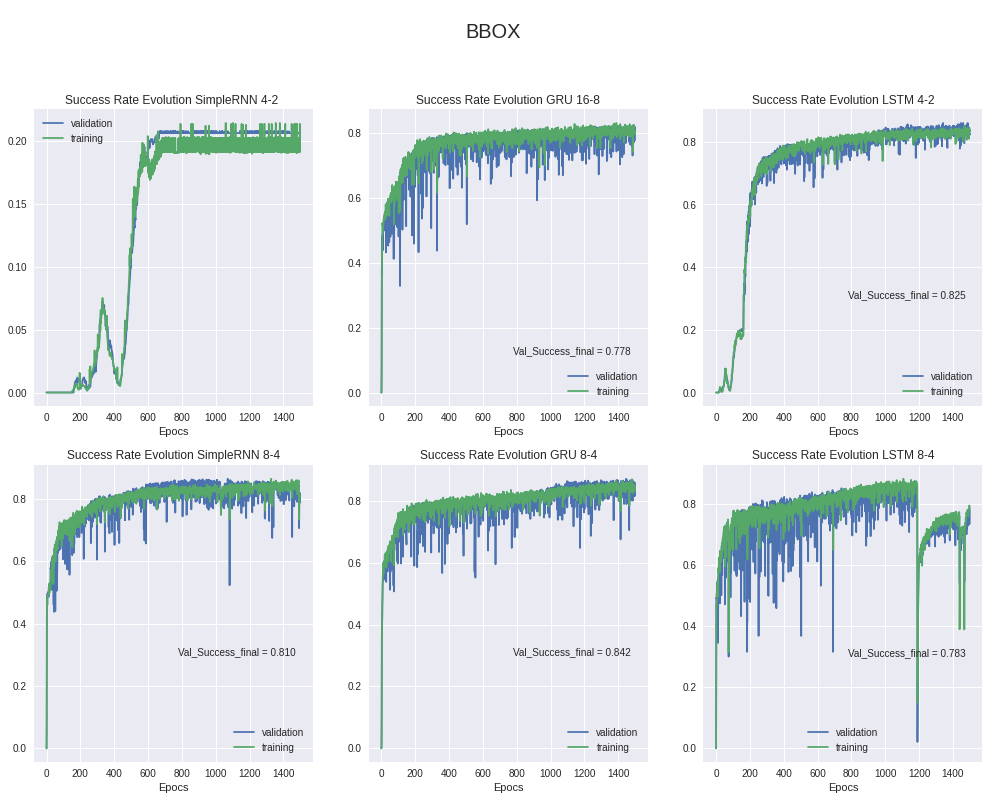

In [16]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la RNN 4-2
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['val_porcentaje_margen'],label='validation')
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['porcentaje_margen'],label="training")
axes[0,0].legend()
axes[0,0].set_title('Success Rate Evolution SimpleRNN 4-2 ')
axes[0,0].set_xlabel('Epocs')
axes[0,0].annotate('Val_Success_final = %.3f'% history_RNN84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la RNN 18-4
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['val_porcentaje_margen'],label='validation')
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['porcentaje_margen'],label="training")
axes[1,0].legend()
axes[1,0].set_title('Success Rate Evolution SimpleRNN 8-4')
axes[1,0].set_xlabel('Epocs')
axes[1,0].annotate('Val_Success_final = %.3f'% history_RNN168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['val_porcentaje_margen'],label='validation')
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['porcentaje_margen'],label="training")
axes[0,1].legend()
axes[0,1].set_title('Success Rate Evolution GRU 16-8')
axes[0,1].set_xlabel('Epocs')
axes[0,1].annotate('Val_Success_final = %.3f'% history_GRU168.history['val_porcentaje_margen'][-1], (1250, 0.12), xytext=(-80, 0), 
           textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8-4
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['val_porcentaje_margen'],label='validation')
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['porcentaje_margen'],label="training")
axes[1,1].legend()
axes[1,1].set_title('Success Rate Evolution GRU 8-4')
axes[1,1].set_xlabel('Epocs')
axes[1,1].annotate('Val_Success_final = %.3f'% history_GRU1684.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 4-2
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['val_porcentaje_margen'],label='validation')
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['porcentaje_margen'],label="training")
axes[0,2].legend()
axes[0,2].set_title('Success Rate Evolution LSTM 4-2')
axes[0,2].set_xlabel('Epocs')
axes[0,2].annotate('Val_Success_final = %.3f'% history_LSTM84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 8-4
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['val_porcentaje_margen'],label='validation')
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['porcentaje_margen'],label="training")
axes[1,2].legend()
axes[1,2].set_title('Success Rate Evolution LSTM 8-4')
axes[1,2].set_xlabel('Epocs')
axes[1,2].annotate('Val_Success_final = %.3f'% history_LSTM168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

In [19]:
# Calculo la prediccion para mi conjunto test
predictedRNN84 = pd.DataFrame(modelRNN84.predict(Xtt))
predictedRNN168 = pd.DataFrame(modelRNN168.predict(Xtt))
predictedGRU168 = pd.DataFrame(modelGRU168.predict(Xtt))
predictedGRU1684 = pd.DataFrame(modelGRU1684.predict(Xtt))
predictedLSTM84 = pd.DataFrame(modelLSTM84.predict(Xtt))
predictedLSTM168 = pd.DataFrame(modelLSTM168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseRNN84 = sqrt(mean_squared_error(ytt, predictedRNN84))
rmseRNN168 = sqrt(mean_squared_error(ytt, predictedRNN168))
rmseGRU168 = sqrt(mean_squared_error(ytt, predictedGRU168))
rmseGRU1684 = sqrt(mean_squared_error(ytt, predictedGRU1684))
rmseLSTM84 = sqrt(mean_squared_error(ytt, predictedLSTM84))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
print(rmseRNN84,rmseRNN168,rmseGRU168,rmseGRU1684,rmseLSTM84,rmseLSTM168)

15.95278526412613 119.35555283912305 1.3863783985538483 3.3692180035773642 1.6015529072996444 5.785170231438428


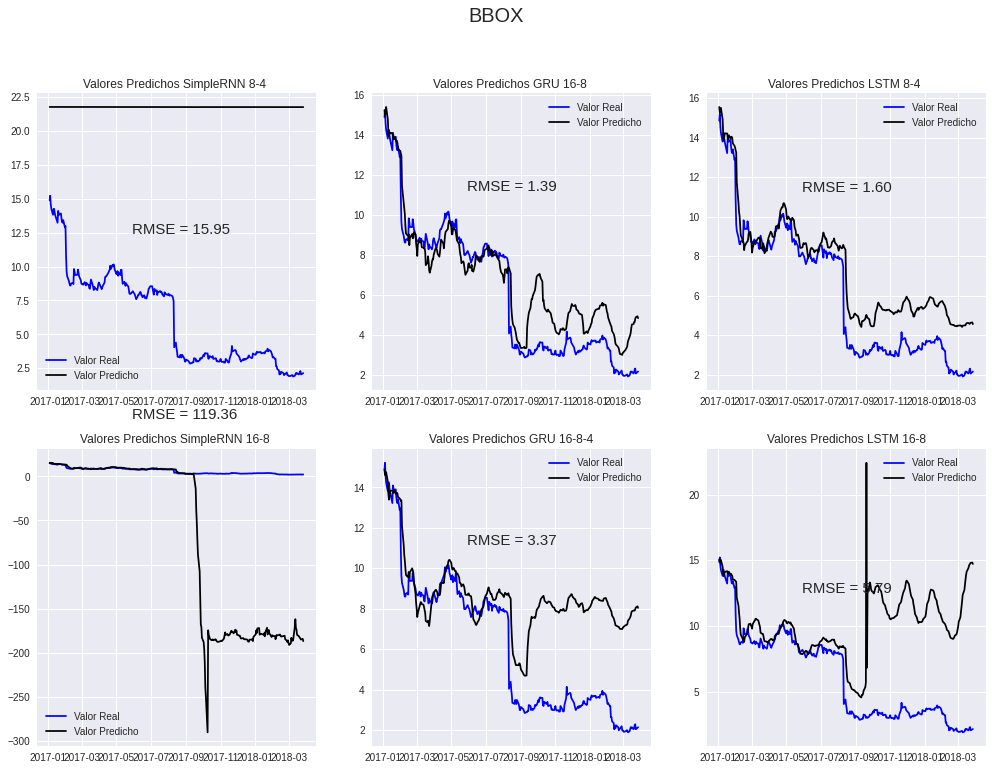

In [18]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)


# Plot de la RNN 8-4
axes[0,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,0].plot(index_time_t,predictedRNN84, label="Valor Predicho", color = "black")
axes[0,0].legend()
axes[0,0].set_title('Valores Predichos SimpleRNN 8-4 ')
axes[0,0].annotate('RMSE = %.2f'% rmseRNN84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)


# Plot de la RNN 16-8
axes[1,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,0].plot(index_time_t,predictedRNN168, label="Valor Predicho", color = "black")
axes[1,0].legend()
axes[1,0].set_title('Valores Predichos SimpleRNN 16-8 ')
axes[1,0].annotate('RMSE = %.2f'% rmseRNN168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8
axes[0,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,1].plot(index_time_t,predictedGRU168, label="Valor Predicho", color = "black")
axes[0,1].legend()
axes[0,1].set_title('Valores Predichos GRU 16-8 ')
axes[0,1].annotate('RMSE = %.2f'% rmseGRU168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8-4
axes[1,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,1].plot(index_time_t,predictedGRU1684, label="Valor Predicho", color = "black")
axes[1,1].legend()
axes[1,1].set_title('Valores Predichos GRU 16-8-4')
axes[1,1].annotate('RMSE = %.2f'% rmseGRU1684, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 8-4
axes[0,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,2].plot(index_time_t,predictedLSTM84, label="Valor Predicho", color = "black")
axes[0,2].legend()
axes[0,2].set_title('Valores Predichos LSTM 8-4 ')
axes[0,2].annotate('RMSE = %.2f'% rmseLSTM84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,2].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1,2].legend()
axes[1,2].set_title('Valores Predichos LSTM 16-8')
axes[1,2].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [42]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedLSTM84
# Es un margen movil, segun lo que busquemos
margen = 0.03
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({0.0: 269, -1.0: 25, 1.0: 14})


In [43]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor    pred dif
2018-03-26     37516.4        0      0  2.125  4.6432   0
Valor Final = 37516.38
Ganancia con margen = -62483.62


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [44]:
movimientos_alza.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/BBOX/Alza3LSTM20-84.csv")

In [45]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor    pred dif
2018-03-26      110118        0         20777      0  2.125  4.6432   0
Valor Final = 65967.26
Ganancia con margen = -34032.74


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [46]:
movimientos_ab.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/BBOX/AlzaBaja3LSTM20-84.csv")

In [47]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor    pred dif
2018-03-26      306543        0         57838      0  2.125  4.6432   0
Valor Final = 183636.83
Ganancia con margen = 83636.83


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [48]:
movimientos_baja.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/BBOX/Baja3LSTM20-84.csv")